In [1]:
import numpy as np
import h5py
import Analysis
from copy import deepcopy

def AddFitMetadata(path, h5_path, A, extra_dict=None):
        h5 = h5py.File(path)
        
        try: 
            h5.create_group(h5_path)
        except:
            del h5[h5_path]
            h5.create_group(h5_path)
            

        fa = h5[h5_path].attrs
        fit = A.SaveFit()

        for key, val in fit.items():
            if key not in ['Data', 'energies', 'loglike', 'PSC']:
                fa.create('flux_'+key,val['flux'])
                fa.create('fluxunc_'+key,val['fluxunc'])        

        fa.create('loglike_total',np.sum(A.loglike))
        fa.create('loglike',A.loglike)
        fa.create('energies',A.central_energies)
        fa.create('bins', A.bin_edges)
        fa.create('irf', A.irf)
        fa.create('evclass', A.evclass)
        fa.create('convtype', A.convtype)
        fa.create('phfile', A.phfile)
        fa.create('tag', A.tag)

        if extra_dict is not None:
            for key, val in extra_dict.items():
                if key == 'residual':
                    try:
                        del h5[h5_path+'/residual']
                    except: 
                        pass

                    h5.create_dataset(h5_path+'/residual', data=val, dtype='float32')
                    print 'Saving new residual... Shape = ', val.shape
                else:
                    fa.create(key, val)
        h5.close()

def LoadModel(basedir, galprop_tag):
    # Load various diffuse models and run fits.
    print 'Running Analysis for model', galprop_tag
    A = Analysis.Analysis(tag='P8R2_CLEAN_V6_calore', basepath='/data/GCE_sys/')
    A.GenSquareMask(l_range=[-20.,20.], b_range=[-20.,20.], plane_mask=2.)
    A.BinPhotons(infile='binned_photons_'+A.tag+'.npy')
    # Load 2FGL 
    A.AddPointSourceTemplate(fixNorm=True,pscmap='PSC_' + A.tag + '_fgl3_with_ext.npy')
    A.CalculatePixelWeights(diffuse_model='fermi_diffuse_'+A.tag+'.npy',psc_model='PSC_' + A.tag + '_fgl3_with_ext.npy',
                        alpha_psc=5., f_psc=0.1)
    A.AddIsotropicTemplate(fixNorm=False, fixSpectrum=False) # External chi^2 used to fix normalization within uncertainties
    
    A.AddFermiBubbleTemplate(template_file='./bubble_templates_diskcut30.0.fits', 
                         spec_file='./reduced_bubble_spec_apj_793_64.dat', fixSpectrum=False, fixNorm=False)
    
    
    A.AddHDF5Template(hdf5file=basedir +'/'+ galprop_tag+'.hdf5',verbosity=1, multiplier=2., bremsfrac=1.25, 
                  E_subsample=2, fixSpectrum=False, separate_ics=False)
    return A



In [2]:
A = LoadModel('/data/GCE_sys/new','Mod_A_2D_XCO_P8')

Running Analysis for model Mod_A_2D_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...


In [6]:
# Add spike 
import Tools
try:
    h5.close()
except:
    pass

h5 = h5py.File('./spike_template.hdf5', 'r')


energies = h5['/templates/energies'][()]
comps, comps_new = {}, {}
comps['ics'] = h5['/templates/ics'][()]
comps['pi0'] = h5['/templates/pi0'][()]

comps_new['pi0'] = np.zeros((A.n_bins, 12*A.nside**2))
comps_new['ics'] = np.zeros((A.n_bins, 12*A.nside**2))


def RunAsync(component):
    for i_E in range(A.n_bins):
    
        comps_new[component][i_E] = Tools.InterpolateHealpix(comps[component], energies,  A.bin_edges[i_E],
                                                             A.bin_edges[i_E+1], E_bins=3,
                                                             nside_out=A.nside)
for key in comps:
    print 'Integrating and Resampling', key, 'templates...'
    sys.stdout.flush()
    RunAsync(key)
            
            
A.AddTemplate(name='ICS_Spike', healpixCube=comps_new['ics'], fixSpectrum=False, fixNorm=False,
                               value=1., ApplyIRF=True, sourceClass='GEN', limits=[0., None], multiplier=1, noPSF=False)
A.AddTemplate(name='Pi0_Spike', healpixCube=comps_new['pi0'], fixSpectrum=False, fixNorm=False,
                               value=1., ApplyIRF=True, sourceClass='GEN', limits=[0., None], multiplier=1, noPSF=False)

h5.close()


Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...


In [13]:


try:
    A.DeleteTemplate('DM')
except: 
    pass
    
for key, template in A.templateList.items():
    if 'Spike' in key: 
        template.limits=[None,None]
    else: 
        template.limits=[None, None]
A.ResetFit()    
    
# #--------------------------------------------
# GC fit without DM
A.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=True)[0]
AddFitMetadata('spike_template.hdf5', h5_path='/fit_results/GC_no_dm/', A=A, extra_dict={'residual':np.array([A.residual[i]*A.mask for i in range(A.n_bins)])})


#--------------------------------------------
# GCE Fit
A.ResetFit()    
A.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
               r_s=20.0, axesratio=1, offset=(0, 0), spec_file=None,)
A.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=True)[0]

AddFitMetadata('spike_template.hdf5', h5_path='/fit_results/GC/', A=A, extra_dict={'residual':np.array([A.residual[i]*A.mask for i in range(A.n_bins)])})




try:
    A.DeleteTemplate('DM')
except: 
    pass

for key, template in A.templateList.items():
    if 'Spike' in key: 
        template.limits=[0.,100]
    else: 
        template.limits=[None, None]
A.ResetFit()    

#--------------------------------------------
# GC fit without DM, limiting templates to >0 
A.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=True)[0]
AddFitMetadata('spike_template.hdf5', h5_path='/fit_results/GC_no_dm_positive/', A=A, extra_dict={'residual':np.array([A.residual[i]*A.mask for i in range(A.n_bins)])})



# #--------------------------------------------
# # GC fit without DM, limiting templates to >0 

A.ResetFit()    
A.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
               r_s=20.0, axesratio=1, offset=(0, 0), spec_file=None,)
A.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=True)[0]

AddFitMetadata('spike_template.hdf5', h5_path='/fit_results/GC_positive/', A=A, extra_dict={'residual':np.array([A.residual[i]*A.mask for i in range(A.n_bins)])})



        

Masking completed in 4.7596e-01 s
Write likelihood tempfile to  /tmp/tmph5jTgE
Code generation completed in 9.6393e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -602595.204272 
 TOTAL NCALL = 192 
 NCALLS = 192 
 
 
 EDM = 0.000798002512996 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_0 
 5.322160e+00 
 2.613244e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_0 
 1.078482e+00 
 7.746675e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_0 
 8.814163e-01 
 1.244463e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_0 
 9.602330e-01 
 1.951139e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_0 
 1.515417e+00 
 1.511101e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_0 
 -3.438960e+01 
 1.634175e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{0}$ & 5.322e+00 & 2.613e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{0}$ & 1.078e+00 & 7.747e-03 & & & & & \\
\hline
4 & $Isotropic_{0}$ & 8.814e-01 & 1.244e-01 & & & & & \\
\hline
5 & $ICS_{0}$ & 9.602e-01 & 1.951e-02 & & & & & \\
\hline
6 & $Bubbles_{0}$ & 1.515e+00 & 1.511e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{0}$ & -3.439e+01 & 1.634e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.32e-01 s
Masking completed in 1.7909e-01 s
Write likelihood tempfile to  /tmp/tmpYkYWGi
Code generation completed in 9.6893e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -476277.14483 
 TOTAL NCALL = 170 
 NCALLS = 170 
 
 
 EDM = 0.00291205673888 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_1 
 3.850552e+00 
 2.640160e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_1 
 1.091372e+00 
 8.213703e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_1 
 9.718678e-01 
 1.354662e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_1 
 9.271586e-01 
 2.209780e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_1 
 1.332703e+00 
 1.458952e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_1 
 -2.369718e+01 
 1.956556e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{1}$ & 3.851e+00 & 2.640e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{1}$ & 1.091e+00 & 8.214e-03 & & & & & \\
\hline
4 & $Isotropic_{1}$ & 9.719e-01 & 1.355e-01 & & & & & \\
\hline
5 & $ICS_{1}$ & 9.272e-01 & 2.210e-02 & & & & & \\
\hline
6 & $Bubbles_{1}$ & 1.333e+00 & 1.459e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{1}$ & -2.370e+01 & 1.957e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.05e-01 s
Masking completed in 1.8411e-01 s
Write likelihood tempfile to  /tmp/tmpHhyxkU
Code generation completed in 9.6607e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -373953.992275 
 TOTAL NCALL = 192 
 NCALLS = 192 
 
 
 EDM = 7.07106645579e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_2 
 3.482112e+00 
 2.775949e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_2 
 1.096364e+00 
 8.822274e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_2 
 7.747671e-01 
 1.417386e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_2 
 9.790495e-01 
 2.451718e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_2 
 1.429111e+00 
 1.432803e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_2 
 -2.004322e+01 
 2.145252e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{2}$ & 3.482e+00 & 2.776e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{2}$ & 1.096e+00 & 8.822e-03 & & & & & \\
\hline
4 & $Isotropic_{2}$ & 7.748e-01 & 1.417e-01 & & & & & \\
\hline
5 & $ICS_{2}$ & 9.790e-01 & 2.452e-02 & & & & & \\
\hline
6 & $Bubbles_{2}$ & 1.429e+00 & 1.433e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{2}$ & -2.004e+01 & 2.145e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.31e-01 s
Masking completed in 1.8314e-01 s
Write likelihood tempfile to  /tmp/tmpJmo3qS
Code generation completed in 9.5296e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -286173.597206 
 TOTAL NCALL = 164 
 NCALLS = 164 
 
 
 EDM = 1.2777285925e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_3 
 3.285153e+00 
 2.977791e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_3 
 1.094080e+00 
 9.398058e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_3 
 8.439875e-01 
 1.484685e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_3 
 9.499446e-01 
 2.735542e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_3 
 1.455037e+00 
 1.480154e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_3 
 -1.563747e+01 
 2.378051e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{3}$ & 3.285e+00 & 2.978e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{3}$ & 1.094e+00 & 9.398e-03 & & & & & \\
\hline
4 & $Isotropic_{3}$ & 8.440e-01 & 1.485e-01 & & & & & \\
\hline
5 & $ICS_{3}$ & 9.499e-01 & 2.736e-02 & & & & & \\
\hline
6 & $Bubbles_{3}$ & 1.455e+00 & 1.480e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{3}$ & -1.564e+01 & 2.378e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.98e-01 s
Masking completed in 1.9095e-01 s
Write likelihood tempfile to  /tmp/tmpUDURl0
Code generation completed in 9.7013e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -276000.682772 
 TOTAL NCALL = 163 
 NCALLS = 163 
 
 
 EDM = 1.10519449205e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_4 
 2.803081e+00 
 2.921161e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_4 
 1.081922e+00 
 9.370068e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_4 
 8.995446e-01 
 1.375252e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_4 
 9.693823e-01 
 2.726675e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_4 
 1.132906e+00 
 1.346790e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_4 
 -1.100054e+01 
 2.371788e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{4}$ & 2.803e+00 & 2.921e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{4}$ & 1.082e+00 & 9.370e-03 & & & & & \\
\hline
4 & $Isotropic_{4}$ & 8.995e-01 & 1.375e-01 & & & & & \\
\hline
5 & $ICS_{4}$ & 9.694e-01 & 2.727e-02 & & & & & \\
\hline
6 & $Bubbles_{4}$ & 1.133e+00 & 1.347e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{4}$ & -1.100e+01 & 2.372e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.97e-01 s
Masking completed in 1.8401e-01 s
Write likelihood tempfile to  /tmp/tmpo0GPXI
Code generation completed in 9.5987e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -274098.924457 
 TOTAL NCALL = 179 
 NCALLS = 179 
 
 
 EDM = 1.11276507877e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_5 
 3.294597e+00 
 2.953848e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_5 
 1.121192e+00 
 9.433129e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_5 
 9.001929e-01 
 1.220139e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_5 
 9.284104e-01 
 2.702255e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_5 
 1.201086e+00 
 1.209764e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_5 
 -8.889832e+00 
 2.339494e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{5}$ & 3.295e+00 & 2.954e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{5}$ & 1.121e+00 & 9.433e-03 & & & & & \\
\hline
4 & $Isotropic_{5}$ & 9.002e-01 & 1.220e-01 & & & & & \\
\hline
5 & $ICS_{5}$ & 9.284e-01 & 2.702e-02 & & & & & \\
\hline
6 & $Bubbles_{5}$ & 1.201e+00 & 1.210e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{5}$ & -8.890e+00 & 2.339e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.16e-01 s
Masking completed in 1.8293e-01 s
Write likelihood tempfile to  /tmp/tmpLvqdUq
Code generation completed in 1.0059e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -263546.132349 
 TOTAL NCALL = 162 
 NCALLS = 162 
 
 
 EDM = 0.000159239789971 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_6 
 2.730858e+00 
 2.718402e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_6 
 1.096708e+00 
 9.162956e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_6 
 8.632764e-01 
 1.068730e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_6 
 9.051536e-01 
 2.558106e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_6 
 1.204546e+00 
 1.130526e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_6 
 -8.397173e+00 
 2.206292e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{6}$ & 2.731e+00 & 2.718e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{6}$ & 1.097e+00 & 9.163e-03 & & & & & \\
\hline
4 & $Isotropic_{6}$ & 8.633e-01 & 1.069e-01 & & & & & \\
\hline
5 & $ICS_{6}$ & 9.052e-01 & 2.558e-02 & & & & & \\
\hline
6 & $Bubbles_{6}$ & 1.205e+00 & 1.131e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{6}$ & -8.397e+00 & 2.206e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.96e-01 s
Masking completed in 1.8191e-01 s
Write likelihood tempfile to  /tmp/tmpiqJ4i8
Code generation completed in 9.5201e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -245083.094066 
 TOTAL NCALL = 181 
 NCALLS = 181 
 
 
 EDM = 0.00270999036192 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_7 
 2.993056e+00 
 2.799528e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_7 
 1.115580e+00 
 9.369957e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_7 
 9.338945e-01 
 1.026458e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_7 
 8.677082e-01 
 2.568368e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_7 
 1.383951e+00 
 1.051536e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_7 
 -5.430417e+00 
 2.176018e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{7}$ & 2.993e+00 & 2.800e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{7}$ & 1.116e+00 & 9.370e-03 & & & & & \\
\hline
4 & $Isotropic_{7}$ & 9.339e-01 & 1.026e-01 & & & & & \\
\hline
5 & $ICS_{7}$ & 8.677e-01 & 2.568e-02 & & & & & \\
\hline
6 & $Bubbles_{7}$ & 1.384e+00 & 1.052e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{7}$ & -5.430e+00 & 2.176e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.20e-01 s
Masking completed in 1.8355e-01 s
Write likelihood tempfile to  /tmp/tmpFLmbGz
Code generation completed in 9.2292e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -230480.243857 
 TOTAL NCALL = 181 
 NCALLS = 181 
 
 
 EDM = 2.55188296482e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_8 
 2.220427e+00 
 2.617827e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_8 
 1.067536e+00 
 9.237703e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_8 
 8.498369e-01 
 1.020534e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_8 
 8.944936e-01 
 2.534149e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_8 
 1.304329e+00 
 1.023578e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_8 
 2.029781e-01 
 2.110166e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{8}$ & 2.220e+00 & 2.618e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{8}$ & 1.068e+00 & 9.238e-03 & & & & & \\
\hline
4 & $Isotropic_{8}$ & 8.498e-01 & 1.021e-01 & & & & & \\
\hline
5 & $ICS_{8}$ & 8.945e-01 & 2.534e-02 & & & & & \\
\hline
6 & $Bubbles_{8}$ & 1.304e+00 & 1.024e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{8}$ & 2.030e-01 & 2.110e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.20e-01 s
Masking completed in 1.8389e-01 s
Write likelihood tempfile to  /tmp/tmpOE_097
Code generation completed in 9.6607e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206701.914458 
 TOTAL NCALL = 180 
 NCALLS = 180 
 
 
 EDM = 0.000230293660409 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_9 
 2.370223e+00 
 2.682503e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_9 
 1.086119e+00 
 9.572911e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_9 
 9.018753e-01 
 1.019224e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_9 
 8.886577e-01 
 2.605636e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_9 
 1.328140e+00 
 1.040143e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_9 
 1.695023e-01 
 2.121923e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{9}$ & 2.370e+00 & 2.683e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{9}$ & 1.086e+00 & 9.573e-03 & & & & & \\
\hline
4 & $Isotropic_{9}$ & 9.019e-01 & 1.019e-01 & & & & & \\
\hline
5 & $ICS_{9}$ & 8.887e-01 & 2.606e-02 & & & & & \\
\hline
6 & $Bubbles_{9}$ & 1.328e+00 & 1.040e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{9}$ & 1.695e-01 & 2.122e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.18e-01 s
Masking completed in 1.8252e-01 s
Write likelihood tempfile to  /tmp/tmp6NcPia
Code generation completed in 9.8586e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188835.142446 
 TOTAL NCALL = 181 
 NCALLS = 181 
 
 
 EDM = 0.000696314704429 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_10 
 2.855071e+00 
 2.474275e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_10 
 1.060280e+00 
 9.593913e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_10 
 9.822253e-01 
 1.060582e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_10 
 8.739318e-01 
 2.572516e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_10 
 1.355399e+00 
 9.676348e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_10 
 1.065434e-01 
 2.048811e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{10}$ & 2.855e+00 & 2.474e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{10}$ & 1.060e+00 & 9.594e-03 & & & & & \\
\hline
4 & $Isotropic_{10}$ & 9.822e-01 & 1.061e-01 & & & & & \\
\hline
5 & $ICS_{10}$ & 8.739e-01 & 2.573e-02 & & & & & \\
\hline
6 & $Bubbles_{10}$ & 1.355e+00 & 9.676e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{10}$ & 1.065e-01 & 2.049e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.19e-01 s
Masking completed in 1.8279e-01 s
Write likelihood tempfile to  /tmp/tmphmzdtS
Code generation completed in 1.2519e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -155080.189017 
 TOTAL NCALL = 178 
 NCALLS = 178 
 
 
 EDM = 0.000212807490634 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_11 
 2.495161e+00 
 2.438147e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_11 
 1.048547e+00 
 1.005529e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_11 
 1.003037e+00 
 1.110981e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_11 
 8.691844e-01 
 2.664506e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_11 
 1.428001e+00 
 9.758060e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_11 
 3.368894e+00 
 2.087965e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{11}$ & 2.495e+00 & 2.438e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{11}$ & 1.049e+00 & 1.006e-02 & & & & & \\
\hline
4 & $Isotropic_{11}$ & 1.003e+00 & 1.111e-01 & & & & & \\
\hline
5 & $ICS_{11}$ & 8.692e-01 & 2.665e-02 & & & & & \\
\hline
6 & $Bubbles_{11}$ & 1.428e+00 & 9.758e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{11}$ & 3.369e+00 & 2.088e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.15e-01 s
Masking completed in 1.8306e-01 s
Write likelihood tempfile to  /tmp/tmpmH8hXx
Code generation completed in 9.9993e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -122754.910276 
 TOTAL NCALL = 180 
 NCALLS = 180 
 
 
 EDM = 0.000243523667558 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_12 
 2.424390e+00 
 2.333718e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_12 
 1.063157e+00 
 1.075690e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_12 
 9.984287e-01 
 1.182545e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_12 
 7.978990e-01 
 2.705171e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_12 
 1.587048e+00 
 9.028956e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_12 
 5.794025e+00 
 2.049041e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{12}$ & 2.424e+00 & 2.334e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{12}$ & 1.063e+00 & 1.076e-02 & & & & & \\
\hline
4 & $Isotropic_{12}$ & 9.984e-01 & 1.183e-01 & & & & & \\
\hline
5 & $ICS_{12}$ & 7.979e-01 & 2.705e-02 & & & & & \\
\hline
6 & $Bubbles_{12}$ & 1.587e+00 & 9.029e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{12}$ & 5.794e+00 & 2.049e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.18e-01 s
Masking completed in 1.8187e-01 s
Write likelihood tempfile to  /tmp/tmp1WBcv0
Code generation completed in 1.0071e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -88992.5906481 
 TOTAL NCALL = 176 
 NCALLS = 176 
 
 
 EDM = 1.76722274078e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_13 
 2.431475e+00 
 2.123483e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_13 
 1.015709e+00 
 1.147505e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_13 
 8.715972e-01 
 1.232661e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_13 
 8.330331e-01 
 2.665154e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_13 
 1.498409e+00 
 8.761478e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_13 
 7.814683e+00 
 1.913088e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{13}$ & 2.431e+00 & 2.123e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{13}$ & 1.016e+00 & 1.148e-02 & & & & & \\
\hline
4 & $Isotropic_{13}$ & 8.716e-01 & 1.233e-01 & & & & & \\
\hline
5 & $ICS_{13}$ & 8.330e-01 & 2.665e-02 & & & & & \\
\hline
6 & $Bubbles_{13}$ & 1.498e+00 & 8.761e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{13}$ & 7.815e+00 & 1.913e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.15e-01 s
Masking completed in 1.8541e-01 s
Write likelihood tempfile to  /tmp/tmpRwSSeP
Code generation completed in 1.0312e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -61060.3149957 
 TOTAL NCALL = 175 
 NCALLS = 175 
 
 
 EDM = 9.8517206348e-07 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_14 
 1.775538e+00 
 1.876448e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_14 
 1.076952e+00 
 1.286252e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_14 
 8.435349e-01 
 1.104207e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_14 
 7.928955e-01 
 2.617620e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_14 
 1.270555e+00 
 7.863523e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_14 
 1.023820e+01 
 1.696011e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{14}$ & 1.776e+00 & 1.876e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{14}$ & 1.077e+00 & 1.286e-02 & & & & & \\
\hline
4 & $Isotropic_{14}$ & 8.435e-01 & 1.104e-01 & & & & & \\
\hline
5 & $ICS_{14}$ & 7.929e-01 & 2.618e-02 & & & & & \\
\hline
6 & $Bubbles_{14}$ & 1.271e+00 & 7.864e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{14}$ & 1.024e+01 & 1.696e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.16e-01 s
Masking completed in 1.8807e-01 s
Write likelihood tempfile to  /tmp/tmplxjbAY
Code generation completed in 9.5201e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -32846.1466804 
 TOTAL NCALL = 161 
 NCALLS = 161 
 
 
 EDM = 0.00486354309254 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_15 
 2.187051e+00 
 1.810395e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_15 
 1.055788e+00 
 1.491403e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_15 
 8.798545e-01 
 1.060386e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_15 
 8.878990e-01 
 2.693528e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_15 
 1.233218e+00 
 7.652700e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_15 
 8.837353e+00 
 1.512964e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{15}$ & 2.187e+00 & 1.810e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{15}$ & 1.056e+00 & 1.491e-02 & & & & & \\
\hline
4 & $Isotropic_{15}$ & 8.799e-01 & 1.060e-01 & & & & & \\
\hline
5 & $ICS_{15}$ & 8.879e-01 & 2.694e-02 & & & & & \\
\hline
6 & $Bubbles_{15}$ & 1.233e+00 & 7.653e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{15}$ & 8.837e+00 & 1.513e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.96e-01 s
Masking completed in 1.8414e-01 s
Write likelihood tempfile to  /tmp/tmpS0DJHQ
Code generation completed in 9.6011e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -10114.1741756 
 TOTAL NCALL = 159 
 NCALLS = 159 
 
 
 EDM = 0.0089521010478 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_16 
 2.487630e+00 
 1.925780e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_16 
 1.099386e+00 
 1.817206e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_16 
 8.551206e-01 
 1.228940e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_16 
 9.179616e-01 
 2.975802e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_16 
 1.405006e+00 
 8.512662e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_16 
 6.975487e+00 
 1.624033e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{16}$ & 2.488e+00 & 1.926e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{16}$ & 1.099e+00 & 1.817e-02 & & & & & \\
\hline
4 & $Isotropic_{16}$ & 8.551e-01 & 1.229e-01 & & & & & \\
\hline
5 & $ICS_{16}$ & 9.180e-01 & 2.976e-02 & & & & & \\
\hline
6 & $Bubbles_{16}$ & 1.405e+00 & 8.513e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{16}$ & 6.975e+00 & 1.624e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.93e-01 s
Masking completed in 1.8500e-01 s
Write likelihood tempfile to  /tmp/tmpXmNeCO
Code generation completed in 9.6202e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 7752.56265899 
 TOTAL NCALL = 174 
 NCALLS = 174 
 
 
 EDM = 7.72030306358e-08 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_17 
 2.348452e+00 
 2.033574e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_17 
 1.145301e+00 
 2.232091e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_17 
 8.446354e-01 
 1.450838e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_17 
 9.431030e-01 
 3.288172e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_17 
 1.387234e+00 
 8.708549e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_17 
 2.940653e+00 
 1.641087e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{17}$ & 2.348e+00 & 2.034e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{17}$ & 1.145e+00 & 2.232e-02 & & & & & \\
\hline
4 & $Isotropic_{17}$ & 8.446e-01 & 1.451e-01 & & & & & \\
\hline
5 & $ICS_{17}$ & 9.431e-01 & 3.288e-02 & & & & & \\
\hline
6 & $Bubbles_{17}$ & 1.387e+00 & 8.709e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{17}$ & 2.941e+00 & 1.641e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.13e-01 s
Masking completed in 1.8251e-01 s
Write likelihood tempfile to  /tmp/tmpRcYuEh
Code generation completed in 9.6393e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 17837.5736231 
 TOTAL NCALL = 161 
 NCALLS = 161 
 
 
 EDM = 0.00458402632133 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_18 
 1.704757e+00 
 2.229783e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_18 
 1.207071e+00 
 2.838209e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_18 
 9.021184e-01 
 1.480806e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_18 
 9.354448e-01 
 3.650679e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_18 
 1.087049e+00 
 7.533327e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_18 
 1.057326e+00 
 1.778693e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{18}$ & 1.705e+00 & 2.230e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{18}$ & 1.207e+00 & 2.838e-02 & & & & & \\
\hline
4 & $Isotropic_{18}$ & 9.021e-01 & 1.481e-01 & & & & & \\
\hline
5 & $ICS_{18}$ & 9.354e-01 & 3.651e-02 & & & & & \\
\hline
6 & $Bubbles_{18}$ & 1.087e+00 & 7.533e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{18}$ & 1.057e+00 & 1.779e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.96e-01 s
Masking completed in 1.8322e-01 s
Write likelihood tempfile to  /tmp/tmpIqJy9H
Code generation completed in 9.4914e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 21484.0999325 
 TOTAL NCALL = 161 
 NCALLS = 161 
 
 
 EDM = 0.000157893252549 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_19 
 2.371560e+00 
 2.785435e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_19 
 1.189372e+00 
 3.756997e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_19 
 9.933911e-01 
 1.296484e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_19 
 8.780192e-01 
 4.178047e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_19 
 1.000416e+00 
 6.767629e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_19 
 6.724132e+00 
 2.171181e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{19}$ & 2.372e+00 & 2.785e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{19}$ & 1.189e+00 & 3.757e-02 & & & & & \\
\hline
4 & $Isotropic_{19}$ & 9.934e-01 & 1.296e-01 & & & & & \\
\hline
5 & $ICS_{19}$ & 8.780e-01 & 4.178e-02 & & & & & \\
\hline
6 & $Bubbles_{19}$ & 1.000e+00 & 6.768e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{19}$ & 6.724e+00 & 2.171e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.98e-01 s
Masking completed in 1.8353e-01 s
Write likelihood tempfile to  /tmp/tmpSLwtMX
Code generation completed in 9.5105e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 20567.7558212 
 TOTAL NCALL = 148 
 NCALLS = 148 
 
 
 EDM = 0.00577319974035 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_20 
 1.038709e+00 
 3.162610e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_20 
 1.171382e+00 
 5.422732e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_20 
 9.256127e-01 
 1.260849e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_20 
 1.051460e+00 
 5.244271e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_20 
 1.050169e+00 
 6.937734e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_20 
 4.201120e+00 
 2.807892e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{20}$ & 1.039e+00 & 3.163e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{20}$ & 1.171e+00 & 5.423e-02 & & & & & \\
\hline
4 & $Isotropic_{20}$ & 9.256e-01 & 1.261e-01 & & & & & \\
\hline
5 & $ICS_{20}$ & 1.051e+00 & 5.244e-02 & & & & & \\
\hline
6 & $Bubbles_{20}$ & 1.050e+00 & 6.938e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{20}$ & 4.201e+00 & 2.808e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.82e-01 s
Masking completed in 1.8421e-01 s
Write likelihood tempfile to  /tmp/tmpCm_9ee
Code generation completed in 9.5701e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 16577.6715806 
 TOTAL NCALL = 119 
 NCALLS = 119 
 
 
 EDM = 0.00575754776473 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_21 
 1.654303e+00 
 5.094954e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_21 
 1.149869e+00 
 8.169537e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_21 
 9.845028e-01 
 1.195346e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_21 
 1.110823e+00 
 6.834673e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_21 
 1.080504e+00 
 7.280985e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_21 
 6.364955e+00 
 4.403721e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{21}$ & 1.654e+00 & 5.095e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{21}$ & 1.150e+00 & 8.170e-02 & & & & & \\
\hline
4 & $Isotropic_{21}$ & 9.845e-01 & 1.195e-01 & & & & & \\
\hline
5 & $ICS_{21}$ & 1.111e+00 & 6.835e-02 & & & & & \\
\hline
6 & $Bubbles_{21}$ & 1.081e+00 & 7.281e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{21}$ & 6.365e+00 & 4.404e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.48e-01 s
Masking completed in 1.8605e-01 s
Write likelihood tempfile to  /tmp/tmpWQ4He6
Code generation completed in 1.6577e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 10279.5089738 
 TOTAL NCALL = 163 
 NCALLS = 163 
 
 
 EDM = 1.72298311652e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_22 
 3.976535e+00 
 9.647463e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_22 
 1.656784e+00 
 1.639470e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_22 
 9.303485e-01 
 1.238485e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_22 
 1.188059e+00 
 1.191238e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_22 
 7.801320e-01 
 7.510273e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_22 
 6.737515e+00 
 7.700424e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{22}$ & 3.977e+00 & 9.647e-01 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{22}$ & 1.657e+00 & 1.639e-01 & & & & & \\
\hline
4 & $Isotropic_{22}$ & 9.303e-01 & 1.238e-01 & & & & & \\
\hline
5 & $ICS_{22}$ & 1.188e+00 & 1.191e-01 & & & & & \\
\hline
6 & $Bubbles_{22}$ & 7.801e-01 & 7.510e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{22}$ & 6.738e+00 & 7.700e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.12e-01 s
Masking completed in 1.8431e-01 s
Write likelihood tempfile to  /tmp/tmpg0U9F1
Code generation completed in 9.8586e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 3835.37862758 
 TOTAL NCALL = 167 
 NCALLS = 167 
 
 
 EDM = 3.60805541377e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_23 
 7.184151e+00 
 3.508428e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_23 
 2.020087e+00 
 4.714960e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_23 
 9.167842e-01 
 2.207670e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_23 
 2.234324e+00 
 3.426783e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_23 
 7.163103e-01 
 1.303316e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_23 
 -6.754352e+00 
 2.191296e+01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{23}$ & 7.184e+00 & 3.508e+00 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{23}$ & 2.020e+00 & 4.715e-01 & & & & & \\
\hline
4 & $Isotropic_{23}$ & 9.168e-01 & 2.208e-01 & & & & & \\
\hline
5 & $ICS_{23}$ & 2.234e+00 & 3.427e-01 & & & & & \\
\hline
6 & $Bubbles_{23}$ & 7.163e-01 & 1.303e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{23}$ & -6.754e+00 & 2.191e+01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.05e-01 s


Minos status for ICS_Spike_0: VALID 
 
 
 Error 
 -0.270107331916 
 0.260229969959 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_0: VALID 
 
 
 Error 
 -0.00807871980273 
 0.00759043511765 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_0: VALID 
 
 
 Error 
 -0.129829515556 
 0.130716620026 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_0: VALID 
 
 
 Error 
 -0.0201925528797 
 0.0203984067814 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_0: VALID 
 
 
 Error 
 -0.154279411948 
 0.156715696263 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_0: VALID 
 
 
 Error 
 -1.64272333394 
 1.70119545982 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_0 
 5.322160e+00 
 2.613265e-01 
 -2.701073e-01 
 2.602300e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_0 
 1.078482e+00 
 7.746688e-03 
 -8.078720e-03 
 7.590435e-03 
 
 
 
 
 
 
 4 
 Isotropic_0 
 8.814163e-01 
 1.244486e-01 
 -1.298295e-01 
 1.307166e-01 
 
 
 
 
 
 
 5 
 ICS_0 
 9.602330e-01 
 1.951163e-02 
 -2.019255e-02 
 2.039841e-02 
 
 
 
 
 
 
 6 
 Bubbles_0 
 1.515417e+00 
 1.511119e-01 
 -1.542794e-01 
 1.567157e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_0 
 -3.438960e+01 
 1.634192e+00 
 -1.642723e+00 
 1.701195e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{0}$ & 5.322e+00 & 2.613e-01 & -2.701e-01 & 2.602e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{0}$ & 1.078e+00 & 7.747e-03 & -8.079e-03 & 7.590e-03 & & & \\
\hline
4 & $Isotropic_{0}$ & 8.814e-01 & 1.244e-01 & -1.298e-01 & 1.307e-01 & & & \\
\hline
5 & $ICS_{0}$ & 9.602e-01 & 1.951e-02 & -2.019e-02 & 2.040e-02 & & & \\
\hline
6 & $Bubbles_{0}$ & 1.515e+00 & 1.511e-01 & -1.543e-01 & 1.567e-01 & & & \\
\hline
7 & Pi0 $Spike_{0}$ & -3.439e+01 & 1.634e+00 & -1.643e+00 & 1.701e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_0
 
 
 
 
 
 
 
 Pi0_Brems_0
 
 
 
 
 
 
 
 Isotropic_0
 
 
 
 
 
 
 
 ICS_0
 
 
 
 
 
 
 
 Bubbles_0
 
 
 
 
 
 
 
 Pi0_Spike_0
 
 
 
 
 
 
 
 ICS_Spike_0 
 
 
 1.00
 
 
 
 0.18
 
 
 
 0.01
 
 
 
 0.05
 
 
 
 -0.18
 
 
 
 -0.69
 
 
 
 
 
 Pi0_Brems_0 
 
 
 0.18
 
 
 
 1.00
 
 
 
 0.10
 
 
 
 -0.46
 
 
 
 -0.00
 
 
 
 -0.27
 
 
 
 
 
 Isotropic_0 
 
 
 0.01
 
 
 
 0.10
 
 
 
 1.00
 
 
 
 -0.76
 
 
 
 -0.76
 
 
 
 0.31
 
 
 
 
 
 ICS_0 
 
 
 0.05
 
 
 
 -0.46
 
 
 
 -0.76
 
 
 
 1.00
 
 
 
 0.31
 
 
 
 -0.42
 
 
 
 
 
 Bubbles_0 
 
 
 -0.18
 
 
 
 -0.00
 
 
 
 -0.76
 
 
 
 0.31
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 
 
 Pi0_Spike_0 
 
 
 -0.69
 
 
 
 -0.27
 
 
 
 0.31
 
 
 
 -0.42
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{0}$} & \rotatebox{90}{Pi0 $Brems_{0}$} & \rotatebox{90}{$Isotropic_{0}$} & \rotatebox{90}{$ICS_{0}$} & \rotatebox{90}{$Bubbles_{0}$} & \rotatebox{90}{Pi0 $Spike_{0}$}\\
\hline
ICS $Spike_{0}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{226,160,138} -0.69\\
\hline
Pi0 $Brems_{0}$ & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{188,217,167} -0.27\\
\hline
$Isotropic_{0}$ & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{233,150,133} -0.76 & \cellcolor[RGB]{192,212,165} 0.31\\
\hline
$ICS_{0}$ & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{202,196,157} -0.42\\
\hline
$Bubbles_{0}$ & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{233,150,133} -0.76 & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04\\
\hline
Pi0 $Spike_{0}$ & \cellcolor[RGB]{226,160,138} -0.69 & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{192,212,165} 0.31 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_1: VALID 
 
 
 Error 
 -0.263648331273 
 0.272800832503 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_1: VALID 
 
 
 Error 
 -0.00844039137945 
 0.00817873584758 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_1: VALID 
 
 
 Error 
 -0.152270288858 
 0.131483171932 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_1: VALID 
 
 
 Error 
 -0.0214267983301 
 0.0247114145006 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_1: VALID 
 
 
 Error 
 -0.142645623168 
 0.157231712221 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_1: VALID 
 
 
 Error 
 -2.10177147155 
 1.92179912433 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_1 
 3.850552e+00 
 2.640143e-01 
 -2.636483e-01 
 2.728008e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_1 
 1.091372e+00 
 8.213691e-03 
 -8.440391e-03 
 8.178736e-03 
 
 
 
 
 
 
 4 
 Isotropic_1 
 9.718678e-01 
 1.354657e-01 
 -1.522703e-01 
 1.314832e-01 
 
 
 
 
 
 
 5 
 ICS_1 
 9.271586e-01 
 2.209768e-02 
 -2.142680e-02 
 2.471141e-02 
 
 
 
 
 
 
 6 
 Bubbles_1 
 1.332703e+00 
 1.458950e-01 
 -1.426456e-01 
 1.572317e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_1 
 -2.369718e+01 
 1.956541e+00 
 -2.101771e+00 
 1.921799e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{1}$ & 3.851e+00 & 2.640e-01 & -2.636e-01 & 2.728e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{1}$ & 1.091e+00 & 8.214e-03 & -8.440e-03 & 8.179e-03 & & & \\
\hline
4 & $Isotropic_{1}$ & 9.719e-01 & 1.355e-01 & -1.523e-01 & 1.315e-01 & & & \\
\hline
5 & $ICS_{1}$ & 9.272e-01 & 2.210e-02 & -2.143e-02 & 2.471e-02 & & & \\
\hline
6 & $Bubbles_{1}$ & 1.333e+00 & 1.459e-01 & -1.426e-01 & 1.572e-01 & & & \\
\hline
7 & Pi0 $Spike_{1}$ & -2.370e+01 & 1.957e+00 & -2.102e+00 & 1.922e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_1
 
 
 
 
 
 
 
 Pi0_Brems_1
 
 
 
 
 
 
 
 Isotropic_1
 
 
 
 
 
 
 
 ICS_1
 
 
 
 
 
 
 
 Bubbles_1
 
 
 
 
 
 
 
 Pi0_Spike_1
 
 
 
 
 
 
 
 ICS_Spike_1 
 
 
 1.00
 
 
 
 0.17
 
 
 
 -0.06
 
 
 
 0.16
 
 
 
 -0.13
 
 
 
 -0.69
 
 
 
 
 
 Pi0_Brems_1 
 
 
 0.17
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 -0.41
 
 
 
 0.00
 
 
 
 -0.24
 
 
 
 
 
 Isotropic_1 
 
 
 -0.06
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.77
 
 
 
 -0.74
 
 
 
 0.39
 
 
 
 
 
 ICS_1 
 
 
 0.16
 
 
 
 -0.41
 
 
 
 -0.77
 
 
 
 1.00
 
 
 
 0.30
 
 
 
 -0.54
 
 
 
 
 
 Bubbles_1 
 
 
 -0.13
 
 
 
 0.00
 
 
 
 -0.74
 
 
 
 0.30
 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 
 
 Pi0_Spike_1 
 
 
 -0.69
 
 
 
 -0.24
 
 
 
 0.39
 
 
 
 -0.54
 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{1}$} & \rotatebox{90}{Pi0 $Brems_{1}$} & \rotatebox{90}{$Isotropic_{1}$} & \rotatebox{90}{$ICS_{1}$} & \rotatebox{90}{$Bubbles_{1}$} & \rotatebox{90}{Pi0 $Spike_{1}$}\\
\hline
ICS $Spike_{1}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{177,233,175} 0.16 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{227,159,138} -0.69\\
\hline
Pi0 $Brems_{1}$ & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{201,197,157} -0.41 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{185,221,169} -0.24\\
\hline
$Isotropic_{1}$ & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{233,149,133} -0.77 & \cellcolor[RGB]{231,152,135} -0.74 & \cellcolor[RGB]{199,201,159} 0.39\\
\hline
$ICS_{1}$ & \cellcolor[RGB]{177,233,175} 0.16 & \cellcolor[RGB]{201,197,157} -0.41 & \cellcolor[RGB]{233,149,133} -0.77 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{190,213,166} 0.30 & \cellcolor[RGB]{213,180,149} -0.54\\
\hline
$Bubbles_{1}$ & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{231,152,135} -0.74 & \cellcolor[RGB]{190,213,166} 0.30 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} -0.09\\
\hline
Pi0 $Spike_{1}$ & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{185,221,169} -0.24 & \cellcolor[RGB]{199,201,159} 0.39 & \cellcolor[RGB]{213,180,149} -0.54 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_2: VALID 
 
 
 Error 
 -0.281276084857 
 0.280616577568 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_2: VALID 
 
 
 Error 
 -0.00888048790993 
 0.00889372862846 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_2: VALID 
 
 
 Error 
 -0.1467594279 
 0.147448373129 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_2: VALID 
 
 
 Error 
 -0.025495753459 
 0.0253254775191 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_2: VALID 
 
 
 Error 
 -0.146195375267 
 0.146015078198 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_2: VALID 
 
 
 Error 
 -2.18690186374 
 2.20901422352 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_2 
 3.482112e+00 
 2.775996e-01 
 -2.812761e-01 
 2.806166e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_2 
 1.096364e+00 
 8.822295e-03 
 -8.880488e-03 
 8.893729e-03 
 
 
 
 
 
 
 4 
 Isotropic_2 
 7.747671e-01 
 1.417392e-01 
 -1.467594e-01 
 1.474484e-01 
 
 
 
 
 
 
 5 
 ICS_2 
 9.790495e-01 
 2.451740e-02 
 -2.549575e-02 
 2.532548e-02 
 
 
 
 
 
 
 6 
 Bubbles_2 
 1.429111e+00 
 1.432802e-01 
 -1.461954e-01 
 1.460151e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_2 
 -2.004322e+01 
 2.145299e+00 
 -2.186902e+00 
 2.209014e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{2}$ & 3.482e+00 & 2.776e-01 & -2.813e-01 & 2.806e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{2}$ & 1.096e+00 & 8.822e-03 & -8.880e-03 & 8.894e-03 & & & \\
\hline
4 & $Isotropic_{2}$ & 7.748e-01 & 1.417e-01 & -1.468e-01 & 1.474e-01 & & & \\
\hline
5 & $ICS_{2}$ & 9.790e-01 & 2.452e-02 & -2.550e-02 & 2.533e-02 & & & \\
\hline
6 & $Bubbles_{2}$ & 1.429e+00 & 1.433e-01 & -1.462e-01 & 1.460e-01 & & & \\
\hline
7 & Pi0 $Spike_{2}$ & -2.004e+01 & 2.145e+00 & -2.187e+00 & 2.209e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_2
 
 
 
 
 
 
 
 Pi0_Brems_2
 
 
 
 
 
 
 
 Isotropic_2
 
 
 
 
 
 
 
 ICS_2
 
 
 
 
 
 
 
 Bubbles_2
 
 
 
 
 
 
 
 Pi0_Spike_2
 
 
 
 
 
 
 
 ICS_Spike_2 
 
 
 1.00
 
 
 
 0.16
 
 
 
 -0.09
 
 
 
 0.20
 
 
 
 -0.10
 
 
 
 -0.70
 
 
 
 
 
 Pi0_Brems_2 
 
 
 0.16
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.40
 
 
 
 0.00
 
 
 
 -0.23
 
 
 
 
 
 Isotropic_2 
 
 
 -0.09
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.76
 
 
 
 -0.73
 
 
 
 0.40
 
 
 
 
 
 ICS_2 
 
 
 0.20
 
 
 
 -0.40
 
 
 
 -0.76
 
 
 
 1.00
 
 
 
 0.27
 
 
 
 -0.58
 
 
 
 
 
 Bubbles_2 
 
 
 -0.10
 
 
 
 0.00
 
 
 
 -0.73
 
 
 
 0.27
 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 
 
 Pi0_Spike_2 
 
 
 -0.70
 
 
 
 -0.23
 
 
 
 0.40
 
 
 
 -0.58
 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{2}$} & \rotatebox{90}{Pi0 $Brems_{2}$} & \rotatebox{90}{$Isotropic_{2}$} & \rotatebox{90}{$ICS_{2}$} & \rotatebox{90}{$Bubbles_{2}$} & \rotatebox{90}{Pi0 $Spike_{2}$}\\
\hline
ICS $Spike_{2}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,231,175} 0.16 & \cellcolor[RGB]{172,241,180} -0.09 & \cellcolor[RGB]{182,226,172} 0.20 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{227,158,138} -0.70\\
\hline
Pi0 $Brems_{2}$ & \cellcolor[RGB]{178,231,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{200,199,158} -0.40 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{184,222,170} -0.23\\
\hline
$Isotropic_{2}$ & \cellcolor[RGB]{172,241,180} -0.09 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{230,155,136} -0.73 & \cellcolor[RGB]{200,199,158} 0.40\\
\hline
$ICS_{2}$ & \cellcolor[RGB]{182,226,172} 0.20 & \cellcolor[RGB]{200,199,158} -0.40 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{216,175,146} -0.58\\
\hline
$Bubbles_{2}$ & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{230,155,136} -0.73 & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,241,180} -0.09\\
\hline
Pi0 $Spike_{2}$ & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{184,222,170} -0.23 & \cellcolor[RGB]{200,199,158} 0.40 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{171,241,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_3: VALID 
 
 
 Error 
 -0.298796550538 
 0.302254131435 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_3: VALID 
 
 
 Error 
 -0.00942153460072 
 0.00946928457687 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_3: VALID 
 
 
 Error 
 -0.148428026349 
 0.148629942116 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_3: VALID 
 
 
 Error 
 -0.0273782460797 
 0.0274167028647 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_3: VALID 
 
 
 Error 
 -0.14890847441 
 0.14842086603 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_3: VALID 
 
 
 Error 
 -2.40603258886 
 2.39155111336 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_3 
 3.285153e+00 
 2.970187e-01 
 -2.987966e-01 
 3.022541e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_3 
 1.094080e+00 
 9.383068e-03 
 -9.421535e-03 
 9.469285e-03 
 
 
 
 
 
 
 4 
 Isotropic_3 
 8.439875e-01 
 1.440005e-01 
 -1.484280e-01 
 1.486299e-01 
 
 
 
 
 
 
 5 
 ICS_3 
 9.499446e-01 
 2.653785e-02 
 -2.737825e-02 
 2.741670e-02 
 
 
 
 
 
 
 6 
 Bubbles_3 
 1.455037e+00 
 1.465230e-01 
 -1.489085e-01 
 1.484209e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_3 
 -1.563747e+01 
 2.343562e+00 
 -2.406033e+00 
 2.391551e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{3}$ & 3.285e+00 & 2.970e-01 & -2.988e-01 & 3.023e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{3}$ & 1.094e+00 & 9.383e-03 & -9.422e-03 & 9.469e-03 & & & \\
\hline
4 & $Isotropic_{3}$ & 8.440e-01 & 1.440e-01 & -1.484e-01 & 1.486e-01 & & & \\
\hline
5 & $ICS_{3}$ & 9.499e-01 & 2.654e-02 & -2.738e-02 & 2.742e-02 & & & \\
\hline
6 & $Bubbles_{3}$ & 1.455e+00 & 1.465e-01 & -1.489e-01 & 1.484e-01 & & & \\
\hline
7 & Pi0 $Spike_{3}$ & -1.564e+01 & 2.344e+00 & -2.406e+00 & 2.392e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_3
 
 
 
 
 
 
 
 Pi0_Brems_3
 
 
 
 
 
 
 
 Isotropic_3
 
 
 
 
 
 
 
 ICS_3
 
 
 
 
 
 
 
 Bubbles_3
 
 
 
 
 
 
 
 Pi0_Spike_3
 
 
 
 
 
 
 
 ICS_Spike_3 
 
 
 1.00
 
 
 
 0.14
 
 
 
 -0.12
 
 
 
 0.25
 
 
 
 -0.09
 
 
 
 -0.71
 
 
 
 
 
 Pi0_Brems_3 
 
 
 0.14
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.41
 
 
 
 0.01
 
 
 
 -0.20
 
 
 
 
 
 Isotropic_3 
 
 
 -0.12
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.74
 
 
 
 -0.69
 
 
 
 0.41
 
 
 
 
 
 ICS_3 
 
 
 0.25
 
 
 
 -0.41
 
 
 
 -0.74
 
 
 
 1.00
 
 
 
 0.22
 
 
 
 -0.61
 
 
 
 
 
 Bubbles_3 
 
 
 -0.09
 
 
 
 0.01
 
 
 
 -0.69
 
 
 
 0.22
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 
 
 Pi0_Spike_3 
 
 
 -0.71
 
 
 
 -0.20
 
 
 
 0.41
 
 
 
 -0.61
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{3}$} & \rotatebox{90}{Pi0 $Brems_{3}$} & \rotatebox{90}{$Isotropic_{3}$} & \rotatebox{90}{$ICS_{3}$} & \rotatebox{90}{$Bubbles_{3}$} & \rotatebox{90}{Pi0 $Spike_{3}$}\\
\hline
ICS $Spike_{3}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{228,157,137} -0.71\\
\hline
Pi0 $Brems_{3}$ & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{200,199,158} -0.41 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{182,226,172} -0.20\\
\hline
$Isotropic_{3}$ & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{201,197,158} 0.41\\
\hline
$ICS_{3}$ & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{200,199,158} -0.41 & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{183,225,171} 0.22 & \cellcolor[RGB]{219,170,144} -0.61\\
\hline
$Bubbles_{3}$ & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{183,225,171} 0.22 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.07\\
\hline
Pi0 $Spike_{3}$ & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{182,226,172} -0.20 & \cellcolor[RGB]{201,197,158} 0.41 & \cellcolor[RGB]{219,170,144} -0.61 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_4: VALID 
 
 
 Error 
 -0.293020239119 
 0.296291275045 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_4: VALID 
 
 
 Error 
 -0.00938675505846 
 0.00944603963797 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_4: VALID 
 
 
 Error 
 -0.137763631024 
 0.137653523179 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_4: VALID 
 
 
 Error 
 -0.0272800254954 
 0.0272971312727 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_4: VALID 
 
 
 Error 
 -0.135476346864 
 0.135360618421 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_4: VALID 
 
 
 Error 
 -2.39519143896 
 2.38474631891 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_4 
 2.803081e+00 
 2.912383e-01 
 -2.930202e-01 
 2.962913e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_4 
 1.081922e+00 
 9.357427e-03 
 -9.386755e-03 
 9.446040e-03 
 
 
 
 
 
 
 4 
 Isotropic_4 
 8.995446e-01 
 1.340739e-01 
 -1.377636e-01 
 1.376535e-01 
 
 
 
 
 
 
 5 
 ICS_4 
 9.693823e-01 
 2.650467e-02 
 -2.728003e-02 
 2.729713e-02 
 
 
 
 
 
 
 6 
 Bubbles_4 
 1.132906e+00 
 1.338452e-01 
 -1.354763e-01 
 1.353606e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_4 
 -1.100054e+01 
 2.336791e+00 
 -2.395191e+00 
 2.384746e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{4}$ & 2.803e+00 & 2.912e-01 & -2.930e-01 & 2.963e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{4}$ & 1.082e+00 & 9.357e-03 & -9.387e-03 & 9.446e-03 & & & \\
\hline
4 & $Isotropic_{4}$ & 8.995e-01 & 1.341e-01 & -1.378e-01 & 1.377e-01 & & & \\
\hline
5 & $ICS_{4}$ & 9.694e-01 & 2.650e-02 & -2.728e-02 & 2.730e-02 & & & \\
\hline
6 & $Bubbles_{4}$ & 1.133e+00 & 1.338e-01 & -1.355e-01 & 1.354e-01 & & & \\
\hline
7 & Pi0 $Spike_{4}$ & -1.100e+01 & 2.337e+00 & -2.395e+00 & 2.385e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_4
 
 
 
 
 
 
 
 Pi0_Brems_4
 
 
 
 
 
 
 
 Isotropic_4
 
 
 
 
 
 
 
 ICS_4
 
 
 
 
 
 
 
 Bubbles_4
 
 
 
 
 
 
 
 Pi0_Spike_4
 
 
 
 
 
 
 
 ICS_Spike_4 
 
 
 1.00
 
 
 
 0.12
 
 
 
 -0.13
 
 
 
 0.28
 
 
 
 -0.08
 
 
 
 -0.71
 
 
 
 
 
 Pi0_Brems_4 
 
 
 0.12
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.41
 
 
 
 0.01
 
 
 
 -0.19
 
 
 
 
 
 Isotropic_4 
 
 
 -0.13
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.72
 
 
 
 -0.66
 
 
 
 0.41
 
 
 
 
 
 ICS_4 
 
 
 0.28
 
 
 
 -0.41
 
 
 
 -0.72
 
 
 
 1.00
 
 
 
 0.16
 
 
 
 -0.63
 
 
 
 
 
 Bubbles_4 
 
 
 -0.08
 
 
 
 0.01
 
 
 
 -0.66
 
 
 
 0.16
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 
 
 Pi0_Spike_4 
 
 
 -0.71
 
 
 
 -0.19
 
 
 
 0.41
 
 
 
 -0.63
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{4}$} & \rotatebox{90}{Pi0 $Brems_{4}$} & \rotatebox{90}{$Isotropic_{4}$} & \rotatebox{90}{$ICS_{4}$} & \rotatebox{90}{$Bubbles_{4}$} & \rotatebox{90}{Pi0 $Spike_{4}$}\\
\hline
ICS $Spike_{4}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,237,178} 0.12 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{188,216,167} 0.28 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{228,157,137} -0.71\\
\hline
Pi0 $Brems_{4}$ & \cellcolor[RGB]{174,237,178} 0.12 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{180,229,173} -0.19\\
\hline
$Isotropic_{4}$ & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{229,156,137} -0.72 & \cellcolor[RGB]{224,163,140} -0.66 & \cellcolor[RGB]{200,198,158} 0.41\\
\hline
$ICS_{4}$ & \cellcolor[RGB]{188,216,167} 0.28 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{229,156,137} -0.72 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{221,168,143} -0.63\\
\hline
$Bubbles_{4}$ & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{224,163,140} -0.66 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} -0.05\\
\hline
Pi0 $Spike_{4}$ & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{180,229,173} -0.19 & \cellcolor[RGB]{200,198,158} 0.41 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_5: VALID 
 
 
 Error 
 -0.296215630141 
 0.297301420194 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_5: VALID 
 
 
 Error 
 -0.00947491891346 
 0.0094846797251 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_5: VALID 
 
 
 Error 
 -0.122443741338 
 0.122749466104 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_5: VALID 
 
 
 Error 
 -0.0270384050896 
 0.0270388608189 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_5: VALID 
 
 
 Error 
 -0.122119475916 
 0.121690340601 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_5: VALID 
 
 
 Error 
 -2.34552165497 
 2.3474183204 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_5 
 3.294597e+00 
 2.934644e-01 
 -2.962156e-01 
 2.973014e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_5 
 1.121192e+00 
 9.421980e-03 
 -9.474919e-03 
 9.484680e-03 
 
 
 
 
 
 
 4 
 Isotropic_5 
 9.001929e-01 
 1.199218e-01 
 -1.224437e-01 
 1.227495e-01 
 
 
 
 
 
 
 5 
 ICS_5 
 9.284104e-01 
 2.635100e-02 
 -2.703841e-02 
 2.703886e-02 
 
 
 
 
 
 
 6 
 Bubbles_5 
 1.201086e+00 
 1.207979e-01 
 -1.221195e-01 
 1.216903e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_5 
 -8.889832e+00 
 2.298268e+00 
 -2.345522e+00 
 2.347418e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{5}$ & 3.295e+00 & 2.935e-01 & -2.962e-01 & 2.973e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{5}$ & 1.121e+00 & 9.422e-03 & -9.475e-03 & 9.485e-03 & & & \\
\hline
4 & $Isotropic_{5}$ & 9.002e-01 & 1.199e-01 & -1.224e-01 & 1.227e-01 & & & \\
\hline
5 & $ICS_{5}$ & 9.284e-01 & 2.635e-02 & -2.704e-02 & 2.704e-02 & & & \\
\hline
6 & $Bubbles_{5}$ & 1.201e+00 & 1.208e-01 & -1.221e-01 & 1.217e-01 & & & \\
\hline
7 & Pi0 $Spike_{5}$ & -8.890e+00 & 2.298e+00 & -2.346e+00 & 2.347e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_5
 
 
 
 
 
 
 
 Pi0_Brems_5
 
 
 
 
 
 
 
 Isotropic_5
 
 
 
 
 
 
 
 ICS_5
 
 
 
 
 
 
 
 Bubbles_5
 
 
 
 
 
 
 
 Pi0_Spike_5
 
 
 
 
 
 
 
 ICS_Spike_5 
 
 
 1.00
 
 
 
 0.11
 
 
 
 -0.13
 
 
 
 0.29
 
 
 
 -0.09
 
 
 
 -0.71
 
 
 
 
 
 Pi0_Brems_5 
 
 
 0.11
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.42
 
 
 
 0.02
 
 
 
 -0.18
 
 
 
 
 
 Isotropic_5 
 
 
 -0.13
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.68
 
 
 
 -0.63
 
 
 
 0.38
 
 
 
 
 
 ICS_5 
 
 
 0.29
 
 
 
 -0.42
 
 
 
 -0.68
 
 
 
 1.00
 
 
 
 0.09
 
 
 
 -0.63
 
 
 
 
 
 Bubbles_5 
 
 
 -0.09
 
 
 
 0.02
 
 
 
 -0.63
 
 
 
 0.09
 
 
 
 1.00
 
 
 
 -0.02
 
 
 
 
 
 Pi0_Spike_5 
 
 
 -0.71
 
 
 
 -0.18
 
 
 
 0.38
 
 
 
 -0.63
 
 
 
 -0.02
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{5}$} & \rotatebox{90}{Pi0 $Brems_{5}$} & \rotatebox{90}{$Isotropic_{5}$} & \rotatebox{90}{$ICS_{5}$} & \rotatebox{90}{$Bubbles_{5}$} & \rotatebox{90}{Pi0 $Spike_{5}$}\\
\hline
ICS $Spike_{5}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{175,237,177} -0.13 & \cellcolor[RGB]{190,214,166} 0.29 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{228,157,137} -0.71\\
\hline
Pi0 $Brems_{5}$ & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} 0.07 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{180,229,174} -0.18\\
\hline
$Isotropic_{5}$ & \cellcolor[RGB]{175,237,177} -0.13 & \cellcolor[RGB]{169,245,182} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{198,202,160} 0.38\\
\hline
$ICS_{5}$ & \cellcolor[RGB]{190,214,166} 0.29 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,180} 0.09 & \cellcolor[RGB]{221,168,143} -0.63\\
\hline
$Bubbles_{5}$ & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{172,241,180} 0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,252,185} -0.02\\
\hline
Pi0 $Spike_{5}$ & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{180,229,174} -0.18 & \cellcolor[RGB]{198,202,160} 0.38 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_6: VALID 
 
 
 Error 
 -0.275142619988 
 0.270580043203 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_6: VALID 
 
 
 Error 
 -0.00916908324833 
 0.00925178284534 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_6: VALID 
 
 
 Error 
 -0.106171487241 
 0.108970233653 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_6: VALID 
 
 
 Error 
 -0.0260591483999 
 0.0251822272099 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_6: VALID 
 
 
 Error 
 -0.114150460638 
 0.113560970927 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_6: VALID 
 
 
 Error 
 -2.17763327955 
 2.24844684777 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_6 
 2.730858e+00 
 2.698936e-01 
 -2.751426e-01 
 2.705800e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_6 
 1.096708e+00 
 9.154368e-03 
 -9.169083e-03 
 9.251783e-03 
 
 
 
 
 
 
 4 
 Isotropic_6 
 8.632764e-01 
 1.056934e-01 
 -1.061715e-01 
 1.089702e-01 
 
 
 
 
 
 
 5 
 ICS_6 
 9.051536e-01 
 2.503982e-02 
 -2.605915e-02 
 2.518223e-02 
 
 
 
 
 
 
 6 
 Bubbles_6 
 1.204546e+00 
 1.130703e-01 
 -1.141505e-01 
 1.135610e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_6 
 -8.397173e+00 
 2.170142e+00 
 -2.177633e+00 
 2.248447e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{6}$ & 2.731e+00 & 2.699e-01 & -2.751e-01 & 2.706e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{6}$ & 1.097e+00 & 9.154e-03 & -9.169e-03 & 9.252e-03 & & & \\
\hline
4 & $Isotropic_{6}$ & 8.633e-01 & 1.057e-01 & -1.062e-01 & 1.090e-01 & & & \\
\hline
5 & $ICS_{6}$ & 9.052e-01 & 2.504e-02 & -2.606e-02 & 2.518e-02 & & & \\
\hline
6 & $Bubbles_{6}$ & 1.205e+00 & 1.131e-01 & -1.142e-01 & 1.136e-01 & & & \\
\hline
7 & Pi0 $Spike_{6}$ & -8.397e+00 & 2.170e+00 & -2.178e+00 & 2.248e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_6
 
 
 
 
 
 
 
 Pi0_Brems_6
 
 
 
 
 
 
 
 Isotropic_6
 
 
 
 
 
 
 
 ICS_6
 
 
 
 
 
 
 
 Bubbles_6
 
 
 
 
 
 
 
 Pi0_Spike_6
 
 
 
 
 
 
 
 ICS_Spike_6 
 
 
 1.00
 
 
 
 0.10
 
 
 
 -0.12
 
 
 
 0.30
 
 
 
 -0.09
 
 
 
 -0.71
 
 
 
 
 
 Pi0_Brems_6 
 
 
 0.10
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 -0.44
 
 
 
 0.02
 
 
 
 -0.18
 
 
 
 
 
 Isotropic_6 
 
 
 -0.12
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 -0.64
 
 
 
 -0.58
 
 
 
 0.36
 
 
 
 
 
 ICS_6 
 
 
 0.30
 
 
 
 -0.44
 
 
 
 -0.64
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 -0.63
 
 
 
 
 
 Bubbles_6 
 
 
 -0.09
 
 
 
 0.02
 
 
 
 -0.58
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 
 
 Pi0_Spike_6 
 
 
 -0.71
 
 
 
 -0.18
 
 
 
 0.36
 
 
 
 -0.63
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{6}$} & \rotatebox{90}{Pi0 $Brems_{6}$} & \rotatebox{90}{$Isotropic_{6}$} & \rotatebox{90}{$ICS_{6}$} & \rotatebox{90}{$Bubbles_{6}$} & \rotatebox{90}{Pi0 $Spike_{6}$}\\
\hline
ICS $Spike_{6}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{174,237,177} -0.12 & \cellcolor[RGB]{191,213,165} 0.30 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{228,157,137} -0.71\\
\hline
Pi0 $Brems_{6}$ & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{179,230,174} -0.18\\
\hline
$Isotropic_{6}$ & \cellcolor[RGB]{174,237,177} -0.12 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{217,174,146} -0.58 & \cellcolor[RGB]{196,205,161} 0.36\\
\hline
$ICS_{6}$ & \cellcolor[RGB]{191,213,165} 0.30 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{221,168,143} -0.63\\
\hline
$Bubbles_{6}$ & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{217,174,146} -0.58 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,184} 0.02\\
\hline
Pi0 $Spike_{6}$ & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{196,205,161} 0.36 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_7: VALID 
 
 
 Error 
 -0.286177192136 
 0.280906536324 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_7: VALID 
 
 
 Error 
 -0.00930817204276 
 0.0095989223417 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_7: VALID 
 
 
 Error 
 -0.103469079016 
 0.105385464885 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_7: VALID 
 
 
 Error 
 -0.0264779679752 
 0.0260992811443 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_7: VALID 
 
 
 Error 
 -0.102673675286 
 0.109641533084 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_7: VALID 
 
 
 Error 
 -2.22405537436 
 2.21843916198 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_7 
 2.993056e+00 
 2.799539e-01 
 -2.861772e-01 
 2.809065e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_7 
 1.115580e+00 
 9.369967e-03 
 -9.308172e-03 
 9.598922e-03 
 
 
 
 
 
 
 4 
 Isotropic_7 
 9.338945e-01 
 1.026466e-01 
 -1.034691e-01 
 1.053855e-01 
 
 
 
 
 
 
 5 
 ICS_7 
 8.677082e-01 
 2.568392e-02 
 -2.647797e-02 
 2.609928e-02 
 
 
 
 
 
 
 6 
 Bubbles_7 
 1.383951e+00 
 1.051539e-01 
 -1.026737e-01 
 1.096415e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_7 
 -5.430417e+00 
 2.176027e+00 
 -2.224055e+00 
 2.218439e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{7}$ & 2.993e+00 & 2.800e-01 & -2.862e-01 & 2.809e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{7}$ & 1.116e+00 & 9.370e-03 & -9.308e-03 & 9.599e-03 & & & \\
\hline
4 & $Isotropic_{7}$ & 9.339e-01 & 1.026e-01 & -1.035e-01 & 1.054e-01 & & & \\
\hline
5 & $ICS_{7}$ & 8.677e-01 & 2.568e-02 & -2.648e-02 & 2.610e-02 & & & \\
\hline
6 & $Bubbles_{7}$ & 1.384e+00 & 1.052e-01 & -1.027e-01 & 1.096e-01 & & & \\
\hline
7 & Pi0 $Spike_{7}$ & -5.430e+00 & 2.176e+00 & -2.224e+00 & 2.218e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_7
 
 
 
 
 
 
 
 Pi0_Brems_7
 
 
 
 
 
 
 
 Isotropic_7
 
 
 
 
 
 
 
 ICS_7
 
 
 
 
 
 
 
 Bubbles_7
 
 
 
 
 
 
 
 Pi0_Spike_7
 
 
 
 
 
 
 
 ICS_Spike_7 
 
 
 1.00
 
 
 
 0.09
 
 
 
 -0.12
 
 
 
 0.31
 
 
 
 -0.09
 
 
 
 -0.70
 
 
 
 
 
 Pi0_Brems_7 
 
 
 0.09
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 -0.45
 
 
 
 0.03
 
 
 
 -0.17
 
 
 
 
 
 Isotropic_7 
 
 
 -0.12
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 -0.61
 
 
 
 -0.55
 
 
 
 0.34
 
 
 
 
 
 ICS_7 
 
 
 0.31
 
 
 
 -0.45
 
 
 
 -0.61
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.63
 
 
 
 
 
 Bubbles_7 
 
 
 -0.09
 
 
 
 0.03
 
 
 
 -0.55
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 
 
 Pi0_Spike_7 
 
 
 -0.70
 
 
 
 -0.17
 
 
 
 0.34
 
 
 
 -0.63
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{7}$} & \rotatebox{90}{Pi0 $Brems_{7}$} & \rotatebox{90}{$Isotropic_{7}$} & \rotatebox{90}{$ICS_{7}$} & \rotatebox{90}{$Bubbles_{7}$} & \rotatebox{90}{Pi0 $Spike_{7}$}\\
\hline
ICS $Spike_{7}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{227,158,138} -0.70\\
\hline
Pi0 $Brems_{7}$ & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{204,193,155} -0.45 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{179,230,174} -0.17\\
\hline
$Isotropic_{7}$ & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{220,170,144} -0.61 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{194,208,163} 0.34\\
\hline
$ICS_{7}$ & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{204,193,155} -0.45 & \cellcolor[RGB]{220,170,144} -0.61 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{221,168,143} -0.63\\
\hline
$Bubbles_{7}$ & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05\\
\hline
Pi0 $Spike_{7}$ & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{194,208,163} 0.34 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_8: VALID 
 
 
 Error 
 -0.263907719848 
 0.264735415705 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_8: VALID 
 
 
 Error 
 -0.00926961371254 
 0.00930855743694 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_8: VALID 
 
 
 Error 
 -0.103194040343 
 0.10341907754 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_8: VALID 
 
 
 Error 
 -0.0258451164606 
 0.0258163143613 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_8: VALID 
 
 
 Error 
 -0.102623214021 
 0.103098909009 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_8: VALID 
 
 
 Error 
 -2.14481992389 
 2.14809801012 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_8 
 2.220427e+00 
 2.617833e-01 
 -2.639077e-01 
 2.647354e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_8 
 1.067536e+00 
 9.237712e-03 
 -9.269614e-03 
 9.308557e-03 
 
 
 
 
 
 
 4 
 Isotropic_8 
 8.498369e-01 
 1.020540e-01 
 -1.031940e-01 
 1.034191e-01 
 
 
 
 
 
 
 5 
 ICS_8 
 8.944936e-01 
 2.534165e-02 
 -2.584512e-02 
 2.581631e-02 
 
 
 
 
 
 
 6 
 Bubbles_8 
 1.304329e+00 
 1.023580e-01 
 -1.026232e-01 
 1.030989e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_8 
 2.029781e-01 
 2.110171e+00 
 -2.144820e+00 
 2.148098e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{8}$ & 2.220e+00 & 2.618e-01 & -2.639e-01 & 2.647e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{8}$ & 1.068e+00 & 9.238e-03 & -9.270e-03 & 9.309e-03 & & & \\
\hline
4 & $Isotropic_{8}$ & 8.498e-01 & 1.021e-01 & -1.032e-01 & 1.034e-01 & & & \\
\hline
5 & $ICS_{8}$ & 8.945e-01 & 2.534e-02 & -2.585e-02 & 2.582e-02 & & & \\
\hline
6 & $Bubbles_{8}$ & 1.304e+00 & 1.024e-01 & -1.026e-01 & 1.031e-01 & & & \\
\hline
7 & Pi0 $Spike_{8}$ & 2.030e-01 & 2.110e+00 & -2.145e+00 & 2.148e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_8
 
 
 
 
 
 
 
 Pi0_Brems_8
 
 
 
 
 
 
 
 Isotropic_8
 
 
 
 
 
 
 
 ICS_8
 
 
 
 
 
 
 
 Bubbles_8
 
 
 
 
 
 
 
 Pi0_Spike_8
 
 
 
 
 
 
 
 ICS_Spike_8 
 
 
 1.00
 
 
 
 0.06
 
 
 
 -0.12
 
 
 
 0.33
 
 
 
 -0.08
 
 
 
 -0.70
 
 
 
 
 
 Pi0_Brems_8 
 
 
 0.06
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.45
 
 
 
 0.03
 
 
 
 -0.16
 
 
 
 
 
 Isotropic_8 
 
 
 -0.12
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.59
 
 
 
 -0.53
 
 
 
 0.32
 
 
 
 
 
 ICS_8 
 
 
 0.33
 
 
 
 -0.45
 
 
 
 -0.59
 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.64
 
 
 
 
 
 Bubbles_8 
 
 
 -0.08
 
 
 
 0.03
 
 
 
 -0.53
 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Spike_8 
 
 
 -0.70
 
 
 
 -0.16
 
 
 
 0.32
 
 
 
 -0.64
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{8}$} & \rotatebox{90}{Pi0 $Brems_{8}$} & \rotatebox{90}{$Isotropic_{8}$} & \rotatebox{90}{$ICS_{8}$} & \rotatebox{90}{$Bubbles_{8}$} & \rotatebox{90}{Pi0 $Spike_{8}$}\\
\hline
ICS $Spike_{8}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{193,209,164} 0.33 & \cellcolor[RGB]{171,242,180} -0.08 & \cellcolor[RGB]{227,159,138} -0.70\\
\hline
Pi0 $Brems_{8}$ & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{205,192,155} -0.45 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{177,233,175} -0.16\\
\hline
$Isotropic_{8}$ & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{217,174,146} -0.59 & \cellcolor[RGB]{212,182,150} -0.53 & \cellcolor[RGB]{193,210,164} 0.32\\
\hline
$ICS_{8}$ & \cellcolor[RGB]{193,209,164} 0.33 & \cellcolor[RGB]{205,192,155} -0.45 & \cellcolor[RGB]{217,174,146} -0.59 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{222,166,142} -0.64\\
\hline
$Bubbles_{8}$ & \cellcolor[RGB]{171,242,180} -0.08 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{212,182,150} -0.53 & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} 0.07\\
\hline
Pi0 $Spike_{8}$ & \cellcolor[RGB]{227,159,138} -0.70 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{193,210,164} 0.32 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_9: VALID 
 
 
 Error 
 -0.270342039618 
 0.2710552791 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_9: VALID 
 
 
 Error 
 -0.00954874339983 
 0.00970603567857 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_9: VALID 
 
 
 Error 
 -0.102794471488 
 0.10320782887 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_9: VALID 
 
 
 Error 
 -0.0266064775532 
 0.0264480400844 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_9: VALID 
 
 
 Error 
 -0.103382387174 
 0.105603860268 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_9: VALID 
 
 
 Error 
 -2.16012237815 
 2.15270444653 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_9 
 2.370223e+00 
 2.682514e-01 
 -2.703420e-01 
 2.710553e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_9 
 1.086119e+00 
 9.572918e-03 
 -9.548743e-03 
 9.706036e-03 
 
 
 
 
 
 
 4 
 Isotropic_9 
 9.018753e-01 
 1.019231e-01 
 -1.027945e-01 
 1.032078e-01 
 
 
 
 
 
 
 5 
 ICS_9 
 8.886577e-01 
 2.605655e-02 
 -2.660648e-02 
 2.644804e-02 
 
 
 
 
 
 
 6 
 Bubbles_9 
 1.328140e+00 
 1.040145e-01 
 -1.033824e-01 
 1.056039e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_9 
 1.695023e-01 
 2.121932e+00 
 -2.160122e+00 
 2.152704e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{9}$ & 2.370e+00 & 2.683e-01 & -2.703e-01 & 2.711e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{9}$ & 1.086e+00 & 9.573e-03 & -9.549e-03 & 9.706e-03 & & & \\
\hline
4 & $Isotropic_{9}$ & 9.019e-01 & 1.019e-01 & -1.028e-01 & 1.032e-01 & & & \\
\hline
5 & $ICS_{9}$ & 8.887e-01 & 2.606e-02 & -2.661e-02 & 2.645e-02 & & & \\
\hline
6 & $Bubbles_{9}$ & 1.328e+00 & 1.040e-01 & -1.034e-01 & 1.056e-01 & & & \\
\hline
7 & Pi0 $Spike_{9}$ & 1.695e-01 & 2.122e+00 & -2.160e+00 & 2.153e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_9
 
 
 
 
 
 
 
 Pi0_Brems_9
 
 
 
 
 
 
 
 Isotropic_9
 
 
 
 
 
 
 
 ICS_9
 
 
 
 
 
 
 
 Bubbles_9
 
 
 
 
 
 
 
 Pi0_Spike_9
 
 
 
 
 
 
 
 ICS_Spike_9 
 
 
 1.00
 
 
 
 0.06
 
 
 
 -0.11
 
 
 
 0.33
 
 
 
 -0.08
 
 
 
 -0.69
 
 
 
 
 
 Pi0_Brems_9 
 
 
 0.06
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.46
 
 
 
 0.03
 
 
 
 -0.16
 
 
 
 
 
 Isotropic_9 
 
 
 -0.11
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.56
 
 
 
 -0.50
 
 
 
 0.31
 
 
 
 
 
 ICS_9 
 
 
 0.33
 
 
 
 -0.46
 
 
 
 -0.56
 
 
 
 1.00
 
 
 
 -0.12
 
 
 
 -0.64
 
 
 
 
 
 Bubbles_9 
 
 
 -0.08
 
 
 
 0.03
 
 
 
 -0.50
 
 
 
 -0.12
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 
 
 Pi0_Spike_9 
 
 
 -0.69
 
 
 
 -0.16
 
 
 
 0.31
 
 
 
 -0.64
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{9}$} & \rotatebox{90}{Pi0 $Brems_{9}$} & \rotatebox{90}{$Isotropic_{9}$} & \rotatebox{90}{$ICS_{9}$} & \rotatebox{90}{$Bubbles_{9}$} & \rotatebox{90}{Pi0 $Spike_{9}$}\\
\hline
ICS $Spike_{9}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{193,209,164} 0.33 & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{226,160,139} -0.69\\
\hline
Pi0 $Brems_{9}$ & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{177,233,175} -0.16\\
\hline
$Isotropic_{9}$ & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{191,212,165} 0.31\\
\hline
$ICS_{9}$ & \cellcolor[RGB]{193,209,164} 0.33 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{222,166,142} -0.64\\
\hline
$Bubbles_{9}$ & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,180} 0.08\\
\hline
Pi0 $Spike_{9}$ & \cellcolor[RGB]{226,160,139} -0.69 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_10: VALID 
 
 
 Error 
 -0.248736888385 
 0.250480890209 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_10: VALID 
 
 
 Error 
 -0.0099119822153 
 0.00940149731661 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_10: VALID 
 
 
 Error 
 -0.107004679855 
 0.107124400308 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_10: VALID 
 
 
 Error 
 -0.0258986818524 
 0.0264393129583 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_10: VALID 
 
 
 Error 
 -0.0984645769922 
 0.0959845140077 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_10: VALID 
 
 
 Error 
 -2.04880942635 
 2.11301377285 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_10 
 2.855071e+00 
 2.474282e-01 
 -2.487369e-01 
 2.504809e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_10 
 1.060280e+00 
 9.593923e-03 
 -9.911982e-03 
 9.401497e-03 
 
 
 
 
 
 
 4 
 Isotropic_10 
 9.822253e-01 
 1.060585e-01 
 -1.070047e-01 
 1.071244e-01 
 
 
 
 
 
 
 5 
 ICS_10 
 8.739318e-01 
 2.572529e-02 
 -2.589868e-02 
 2.643931e-02 
 
 
 
 
 
 
 6 
 Bubbles_10 
 1.355399e+00 
 9.676354e-02 
 -9.846458e-02 
 9.598451e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_10 
 1.065434e-01 
 2.048816e+00 
 -2.048809e+00 
 2.113014e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{10}$ & 2.855e+00 & 2.474e-01 & -2.487e-01 & 2.505e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{10}$ & 1.060e+00 & 9.594e-03 & -9.912e-03 & 9.401e-03 & & & \\
\hline
4 & $Isotropic_{10}$ & 9.822e-01 & 1.061e-01 & -1.070e-01 & 1.071e-01 & & & \\
\hline
5 & $ICS_{10}$ & 8.739e-01 & 2.573e-02 & -2.590e-02 & 2.644e-02 & & & \\
\hline
6 & $Bubbles_{10}$ & 1.355e+00 & 9.676e-02 & -9.846e-02 & 9.598e-02 & & & \\
\hline
7 & Pi0 $Spike_{10}$ & 1.065e-01 & 2.049e+00 & -2.049e+00 & 2.113e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_10
 
 
 
 
 
 
 
 Pi0_Brems_10
 
 
 
 
 
 
 
 Isotropic_10
 
 
 
 
 
 
 
 ICS_10
 
 
 
 
 
 
 
 Bubbles_10
 
 
 
 
 
 
 
 Pi0_Spike_10
 
 
 
 
 
 
 
 ICS_Spike_10 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.10
 
 
 
 0.33
 
 
 
 -0.08
 
 
 
 -0.67
 
 
 
 
 
 Pi0_Brems_10 
 
 
 0.05
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.46
 
 
 
 0.02
 
 
 
 -0.16
 
 
 
 
 
 Isotropic_10 
 
 
 -0.10
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.53
 
 
 
 -0.49
 
 
 
 0.29
 
 
 
 
 
 ICS_10 
 
 
 0.33
 
 
 
 -0.46
 
 
 
 -0.53
 
 
 
 1.00
 
 
 
 -0.15
 
 
 
 -0.64
 
 
 
 
 
 Bubbles_10 
 
 
 -0.08
 
 
 
 0.02
 
 
 
 -0.49
 
 
 
 -0.15
 
 
 
 1.00
 
 
 
 0.09
 
 
 
 
 
 Pi0_Spike_10 
 
 
 -0.67
 
 
 
 -0.16
 
 
 
 0.29
 
 
 
 -0.64
 
 
 
 0.09
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{10}$} & \rotatebox{90}{Pi0 $Brems_{10}$} & \rotatebox{90}{$Isotropic_{10}$} & \rotatebox{90}{$ICS_{10}$} & \rotatebox{90}{$Bubbles_{10}$} & \rotatebox{90}{Pi0 $Spike_{10}$}\\
\hline
ICS $Spike_{10}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{170,244,181} -0.08 & \cellcolor[RGB]{225,162,139} -0.67\\
\hline
Pi0 $Brems_{10}$ & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{206,190,154} -0.46 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{177,233,175} -0.16\\
\hline
$Isotropic_{10}$ & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{208,187,153} -0.49 & \cellcolor[RGB]{190,214,166} 0.29\\
\hline
$ICS_{10}$ & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{206,190,154} -0.46 & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,234,176} -0.15 & \cellcolor[RGB]{222,166,142} -0.64\\
\hline
$Bubbles_{10}$ & \cellcolor[RGB]{170,244,181} -0.08 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{208,187,153} -0.49 & \cellcolor[RGB]{176,234,176} -0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,179} 0.09\\
\hline
Pi0 $Spike_{10}$ & \cellcolor[RGB]{225,162,139} -0.67 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{190,214,166} 0.29 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{172,241,179} 0.09 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_11: VALID 
 
 
 Error 
 -0.244413524119 
 0.246866635178 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_11: VALID 
 
 
 Error 
 -0.0102235479846 
 0.0099910752996 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_11: VALID 
 
 
 Error 
 -0.111949132946 
 0.111891259296 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_11: VALID 
 
 
 Error 
 -0.0268323493782 
 0.0272686767854 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_11: VALID 
 
 
 Error 
 -0.0991501880645 
 0.0967588857464 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_11: VALID 
 
 
 Error 
 -2.10590594701 
 2.12729761588 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_11 
 2.495161e+00 
 2.438151e-01 
 -2.444135e-01 
 2.468666e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_11 
 1.048547e+00 
 1.005531e-02 
 -1.022355e-02 
 9.991075e-03 
 
 
 
 
 
 
 4 
 Isotropic_11 
 1.003037e+00 
 1.110985e-01 
 -1.119491e-01 
 1.118913e-01 
 
 
 
 
 
 
 5 
 ICS_11 
 8.691844e-01 
 2.664519e-02 
 -2.683235e-02 
 2.726868e-02 
 
 
 
 
 
 
 6 
 Bubbles_11 
 1.428001e+00 
 9.758066e-02 
 -9.915019e-02 
 9.675889e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_11 
 3.368894e+00 
 2.087968e+00 
 -2.105906e+00 
 2.127298e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{11}$ & 2.495e+00 & 2.438e-01 & -2.444e-01 & 2.469e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{11}$ & 1.049e+00 & 1.006e-02 & -1.022e-02 & 9.991e-03 & & & \\
\hline
4 & $Isotropic_{11}$ & 1.003e+00 & 1.111e-01 & -1.119e-01 & 1.119e-01 & & & \\
\hline
5 & $ICS_{11}$ & 8.692e-01 & 2.665e-02 & -2.683e-02 & 2.727e-02 & & & \\
\hline
6 & $Bubbles_{11}$ & 1.428e+00 & 9.758e-02 & -9.915e-02 & 9.676e-02 & & & \\
\hline
7 & Pi0 $Spike_{11}$ & 3.369e+00 & 2.088e+00 & -2.106e+00 & 2.127e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_11
 
 
 
 
 
 
 
 Pi0_Brems_11
 
 
 
 
 
 
 
 Isotropic_11
 
 
 
 
 
 
 
 ICS_11
 
 
 
 
 
 
 
 Bubbles_11
 
 
 
 
 
 
 
 Pi0_Spike_11
 
 
 
 
 
 
 
 ICS_Spike_11 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.10
 
 
 
 0.33
 
 
 
 -0.07
 
 
 
 -0.66
 
 
 
 
 
 Pi0_Brems_11 
 
 
 0.04
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.47
 
 
 
 0.02
 
 
 
 -0.16
 
 
 
 
 
 Isotropic_11 
 
 
 -0.10
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.51
 
 
 
 -0.46
 
 
 
 0.28
 
 
 
 
 
 ICS_11 
 
 
 0.33
 
 
 
 -0.47
 
 
 
 -0.51
 
 
 
 1.00
 
 
 
 -0.18
 
 
 
 -0.64
 
 
 
 
 
 Bubbles_11 
 
 
 -0.07
 
 
 
 0.02
 
 
 
 -0.46
 
 
 
 -0.18
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Pi0_Spike_11 
 
 
 -0.66
 
 
 
 -0.16
 
 
 
 0.28
 
 
 
 -0.64
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{11}$} & \rotatebox{90}{Pi0 $Brems_{11}$} & \rotatebox{90}{$Isotropic_{11}$} & \rotatebox{90}{$ICS_{11}$} & \rotatebox{90}{$Bubbles_{11}$} & \rotatebox{90}{Pi0 $Spike_{11}$}\\
\hline
ICS $Spike_{11}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{224,163,140} -0.66\\
\hline
Pi0 $Brems_{11}$ & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{178,232,175} -0.16\\
\hline
$Isotropic_{11}$ & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{210,185,151} -0.51 & \cellcolor[RGB]{206,191,154} -0.46 & \cellcolor[RGB]{188,216,167} 0.28\\
\hline
$ICS_{11}$ & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{210,185,151} -0.51 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,229,174} -0.18 & \cellcolor[RGB]{222,166,141} -0.64\\
\hline
$Bubbles_{11}$ & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{206,191,154} -0.46 & \cellcolor[RGB]{180,229,174} -0.18 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
Pi0 $Spike_{11}$ & \cellcolor[RGB]{224,163,140} -0.66 & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{188,216,167} 0.28 & \cellcolor[RGB]{222,166,141} -0.64 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_12: VALID 
 
 
 Error 
 -0.235722701204 
 0.233747873266 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_12: VALID 
 
 
 Error 
 -0.0107370766082 
 0.0108830955083 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_12: VALID 
 
 
 Error 
 -0.118595851734 
 0.119370028 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_12: VALID 
 
 
 Error 
 -0.0273928198574 
 0.0274199582561 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_12: VALID 
 
 
 Error 
 -0.0904913236804 
 0.0906958017247 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_12: VALID 
 
 
 Error 
 -2.06775580799 
 2.07712619784 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_12 
 2.424390e+00 
 2.333722e-01 
 -2.357227e-01 
 2.337479e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_12 
 1.063157e+00 
 1.075692e-02 
 -1.073708e-02 
 1.088310e-02 
 
 
 
 
 
 
 4 
 Isotropic_12 
 9.984287e-01 
 1.182548e-01 
 -1.185959e-01 
 1.193700e-01 
 
 
 
 
 
 
 5 
 ICS_12 
 7.978990e-01 
 2.705183e-02 
 -2.739282e-02 
 2.741996e-02 
 
 
 
 
 
 
 6 
 Bubbles_12 
 1.587048e+00 
 9.028957e-02 
 -9.049132e-02 
 9.069580e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_12 
 5.794025e+00 
 2.049044e+00 
 -2.067756e+00 
 2.077126e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{12}$ & 2.424e+00 & 2.334e-01 & -2.357e-01 & 2.337e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{12}$ & 1.063e+00 & 1.076e-02 & -1.074e-02 & 1.088e-02 & & & \\
\hline
4 & $Isotropic_{12}$ & 9.984e-01 & 1.183e-01 & -1.186e-01 & 1.194e-01 & & & \\
\hline
5 & $ICS_{12}$ & 7.979e-01 & 2.705e-02 & -2.739e-02 & 2.742e-02 & & & \\
\hline
6 & $Bubbles_{12}$ & 1.587e+00 & 9.029e-02 & -9.049e-02 & 9.070e-02 & & & \\
\hline
7 & Pi0 $Spike_{12}$ & 5.794e+00 & 2.049e+00 & -2.068e+00 & 2.077e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_12
 
 
 
 
 
 
 
 Pi0_Brems_12
 
 
 
 
 
 
 
 Isotropic_12
 
 
 
 
 
 
 
 ICS_12
 
 
 
 
 
 
 
 Bubbles_12
 
 
 
 
 
 
 
 Pi0_Spike_12
 
 
 
 
 
 
 
 ICS_Spike_12 
 
 
 1.00
 
 
 
 0.03
 
 
 
 -0.08
 
 
 
 0.31
 
 
 
 -0.06
 
 
 
 -0.63
 
 
 
 
 
 Pi0_Brems_12 
 
 
 0.03
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.48
 
 
 
 0.02
 
 
 
 -0.17
 
 
 
 
 
 Isotropic_12 
 
 
 -0.08
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.49
 
 
 
 -0.45
 
 
 
 0.26
 
 
 
 
 
 ICS_12 
 
 
 0.31
 
 
 
 -0.48
 
 
 
 -0.49
 
 
 
 1.00
 
 
 
 -0.19
 
 
 
 -0.63
 
 
 
 
 
 Bubbles_12 
 
 
 -0.06
 
 
 
 0.02
 
 
 
 -0.45
 
 
 
 -0.19
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Pi0_Spike_12 
 
 
 -0.63
 
 
 
 -0.17
 
 
 
 0.26
 
 
 
 -0.63
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{12}$} & \rotatebox{90}{Pi0 $Brems_{12}$} & \rotatebox{90}{$Isotropic_{12}$} & \rotatebox{90}{$ICS_{12}$} & \rotatebox{90}{$Bubbles_{12}$} & \rotatebox{90}{Pi0 $Spike_{12}$}\\
\hline
ICS $Spike_{12}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{221,168,143} -0.63\\
\hline
Pi0 $Brems_{12}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{178,231,175} -0.17\\
\hline
$Isotropic_{12}$ & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{205,192,155} -0.45 & \cellcolor[RGB]{187,219,168} 0.26\\
\hline
$ICS_{12}$ & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{181,227,173} -0.19 & \cellcolor[RGB]{221,168,143} -0.63\\
\hline
$Bubbles_{12}$ & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{205,192,155} -0.45 & \cellcolor[RGB]{181,227,173} -0.19 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
Pi0 $Spike_{12}$ & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{178,231,175} -0.17 & \cellcolor[RGB]{187,219,168} 0.26 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_13: VALID 
 
 
 Error 
 -0.212013597333 
 0.213166894611 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_13: VALID 
 
 
 Error 
 -0.0115101054961 
 0.011505730362 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_13: VALID 
 
 
 Error 
 -0.123780761999 
 0.123836930402 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_13: VALID 
 
 
 Error 
 -0.0269205287559 
 0.0269199465103 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_13: VALID 
 
 
 Error 
 -0.0878108077786 
 0.0878444985008 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_13: VALID 
 
 
 Error 
 -1.91753769501 
 1.92555065763 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_13 
 2.431475e+00 
 2.118263e-01 
 -2.120136e-01 
 2.131669e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_13 
 1.015709e+00 
 1.145985e-02 
 -1.151011e-02 
 1.150573e-02 
 
 
 
 
 
 
 4 
 Isotropic_13 
 8.715972e-01 
 1.232776e-01 
 -1.237808e-01 
 1.238369e-01 
 
 
 
 
 
 
 5 
 ICS_13 
 8.330331e-01 
 2.665460e-02 
 -2.692053e-02 
 2.691995e-02 
 
 
 
 
 
 
 6 
 Bubbles_13 
 1.498409e+00 
 8.760052e-02 
 -8.781081e-02 
 8.784450e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_13 
 7.814683e+00 
 1.906286e+00 
 -1.917538e+00 
 1.925551e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{13}$ & 2.431e+00 & 2.118e-01 & -2.120e-01 & 2.132e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{13}$ & 1.016e+00 & 1.146e-02 & -1.151e-02 & 1.151e-02 & & & \\
\hline
4 & $Isotropic_{13}$ & 8.716e-01 & 1.233e-01 & -1.238e-01 & 1.238e-01 & & & \\
\hline
5 & $ICS_{13}$ & 8.330e-01 & 2.665e-02 & -2.692e-02 & 2.692e-02 & & & \\
\hline
6 & $Bubbles_{13}$ & 1.498e+00 & 8.760e-02 & -8.781e-02 & 8.784e-02 & & & \\
\hline
7 & Pi0 $Spike_{13}$ & 7.815e+00 & 1.906e+00 & -1.918e+00 & 1.926e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_13
 
 
 
 
 
 
 
 Pi0_Brems_13
 
 
 
 
 
 
 
 Isotropic_13
 
 
 
 
 
 
 
 ICS_13
 
 
 
 
 
 
 
 Bubbles_13
 
 
 
 
 
 
 
 Pi0_Spike_13
 
 
 
 
 
 
 
 ICS_Spike_13 
 
 
 1.00
 
 
 
 0.01
 
 
 
 -0.05
 
 
 
 0.26
 
 
 
 -0.05
 
 
 
 -0.58
 
 
 
 
 
 Pi0_Brems_13 
 
 
 0.01
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.51
 
 
 
 0.01
 
 
 
 -0.16
 
 
 
 
 
 Isotropic_13 
 
 
 -0.05
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.45
 
 
 
 -0.44
 
 
 
 0.22
 
 
 
 
 
 ICS_13 
 
 
 0.26
 
 
 
 -0.51
 
 
 
 -0.45
 
 
 
 1.00
 
 
 
 -0.22
 
 
 
 -0.59
 
 
 
 
 
 Bubbles_13 
 
 
 -0.05
 
 
 
 0.01
 
 
 
 -0.44
 
 
 
 -0.22
 
 
 
 1.00
 
 
 
 0.12
 
 
 
 
 
 Pi0_Spike_13 
 
 
 -0.58
 
 
 
 -0.16
 
 
 
 0.22
 
 
 
 -0.59
 
 
 
 0.12
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{13}$} & \rotatebox{90}{Pi0 $Brems_{13}$} & \rotatebox{90}{$Isotropic_{13}$} & \rotatebox{90}{$ICS_{13}$} & \rotatebox{90}{$Bubbles_{13}$} & \rotatebox{90}{Pi0 $Spike_{13}$}\\
\hline
ICS $Spike_{13}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{186,219,168} 0.26 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{216,175,146} -0.58\\
\hline
Pi0 $Brems_{13}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{178,232,175} -0.16\\
\hline
$Isotropic_{13}$ & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{205,192,155} -0.45 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{183,224,171} 0.22\\
\hline
$ICS_{13}$ & \cellcolor[RGB]{186,219,168} 0.26 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{205,192,155} -0.45 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{217,173,145} -0.59\\
\hline
$Bubbles_{13}$ & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,237,178} 0.12\\
\hline
Pi0 $Spike_{13}$ & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{183,224,171} 0.22 & \cellcolor[RGB]{217,173,145} -0.59 & \cellcolor[RGB]{174,237,178} 0.12 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_14: VALID 
 
 
 Error 
 -0.186832784833 
 0.188384650339 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_14: VALID 
 
 
 Error 
 -0.0129009492918 
 0.0129122485609 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_14: VALID 
 
 
 Error 
 -0.110685456965 
 0.110730630542 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_14: VALID 
 
 
 Error 
 -0.026344057127 
 0.0263433937099 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_14: VALID 
 
 
 Error 
 -0.0787269672467 
 0.078787805299 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_14: VALID 
 
 
 Error 
 -1.69553023603 
 1.70103506576 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_14 
 1.775538e+00 
 1.872209e-01 
 -1.868328e-01 
 1.883847e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_14 
 1.076952e+00 
 1.285748e-02 
 -1.290095e-02 
 1.291225e-02 
 
 
 
 
 
 
 4 
 Isotropic_14 
 8.435349e-01 
 1.104385e-01 
 -1.106855e-01 
 1.107306e-01 
 
 
 
 
 
 
 5 
 ICS_14 
 7.928955e-01 
 2.615776e-02 
 -2.634406e-02 
 2.634339e-02 
 
 
 
 
 
 
 6 
 Bubbles_14 
 1.270555e+00 
 7.859342e-02 
 -7.872697e-02 
 7.878781e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_14 
 1.023820e+01 
 1.689938e+00 
 -1.695530e+00 
 1.701035e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{14}$ & 1.776e+00 & 1.872e-01 & -1.868e-01 & 1.884e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{14}$ & 1.077e+00 & 1.286e-02 & -1.290e-02 & 1.291e-02 & & & \\
\hline
4 & $Isotropic_{14}$ & 8.435e-01 & 1.104e-01 & -1.107e-01 & 1.107e-01 & & & \\
\hline
5 & $ICS_{14}$ & 7.929e-01 & 2.616e-02 & -2.634e-02 & 2.634e-02 & & & \\
\hline
6 & $Bubbles_{14}$ & 1.271e+00 & 7.859e-02 & -7.873e-02 & 7.879e-02 & & & \\
\hline
7 & Pi0 $Spike_{14}$ & 1.024e+01 & 1.690e+00 & -1.696e+00 & 1.701e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_14
 
 
 
 
 
 
 
 Pi0_Brems_14
 
 
 
 
 
 
 
 Isotropic_14
 
 
 
 
 
 
 
 ICS_14
 
 
 
 
 
 
 
 Bubbles_14
 
 
 
 
 
 
 
 Pi0_Spike_14
 
 
 
 
 
 
 
 ICS_Spike_14 
 
 
 1.00
 
 
 
 -0.02
 
 
 
 -0.01
 
 
 
 0.17
 
 
 
 -0.02
 
 
 
 -0.49
 
 
 
 
 
 Pi0_Brems_14 
 
 
 -0.02
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.58
 
 
 
 0.03
 
 
 
 -0.16
 
 
 
 
 
 Isotropic_14 
 
 
 -0.01
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.38
 
 
 
 -0.39
 
 
 
 0.16
 
 
 
 
 
 ICS_14 
 
 
 0.17
 
 
 
 -0.58
 
 
 
 -0.38
 
 
 
 1.00
 
 
 
 -0.28
 
 
 
 -0.52
 
 
 
 
 
 Bubbles_14 
 
 
 -0.02
 
 
 
 0.03
 
 
 
 -0.39
 
 
 
 -0.28
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 
 
 Pi0_Spike_14 
 
 
 -0.49
 
 
 
 -0.16
 
 
 
 0.16
 
 
 
 -0.52
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{14}$} & \rotatebox{90}{Pi0 $Brems_{14}$} & \rotatebox{90}{$Isotropic_{14}$} & \rotatebox{90}{$ICS_{14}$} & \rotatebox{90}{$Bubbles_{14}$} & \rotatebox{90}{Pi0 $Spike_{14}$}\\
\hline
ICS $Spike_{14}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{208,187,152} -0.49\\
\hline
Pi0 $Brems_{14}$ & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{177,233,175} -0.16\\
\hline
$Isotropic_{14}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{199,200,159} -0.39 & \cellcolor[RGB]{178,232,175} 0.16\\
\hline
$ICS_{14}$ & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{189,216,167} -0.28 & \cellcolor[RGB]{211,183,150} -0.52\\
\hline
$Bubbles_{14}$ & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{199,200,159} -0.39 & \cellcolor[RGB]{189,216,167} -0.28 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
Pi0 $Spike_{14}$ & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{211,183,150} -0.52 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_15: VALID 
 
 
 Error 
 -0.175834067079 
 0.188809751525 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_15: VALID 
 
 
 Error 
 -0.0140089285471 
 0.0160629953354 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_15: VALID 
 
 
 Error 
 -0.110581774703 
 0.103091894246 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_15: VALID 
 
 
 Error 
 -0.0272649980568 
 0.02713968165 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_15: VALID 
 
 
 Error 
 -0.076216026437 
 0.077828972297 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_15: VALID 
 
 
 Error 
 -1.63413003157 
 1.41378340411 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_15 
 2.187051e+00 
 1.810280e-01 
 -1.758341e-01 
 1.888098e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_15 
 1.055788e+00 
 1.491402e-02 
 -1.400893e-02 
 1.606300e-02 
 
 
 
 
 
 
 4 
 Isotropic_15 
 8.798545e-01 
 1.060385e-01 
 -1.105818e-01 
 1.030919e-01 
 
 
 
 
 
 
 5 
 ICS_15 
 8.878990e-01 
 2.693520e-02 
 -2.726500e-02 
 2.713968e-02 
 
 
 
 
 
 
 6 
 Bubbles_15 
 1.233218e+00 
 7.652696e-02 
 -7.621603e-02 
 7.782897e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_15 
 8.837353e+00 
 1.512903e+00 
 -1.634130e+00 
 1.413783e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{15}$ & 2.187e+00 & 1.810e-01 & -1.758e-01 & 1.888e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{15}$ & 1.056e+00 & 1.491e-02 & -1.401e-02 & 1.606e-02 & & & \\
\hline
4 & $Isotropic_{15}$ & 8.799e-01 & 1.060e-01 & -1.106e-01 & 1.031e-01 & & & \\
\hline
5 & $ICS_{15}$ & 8.879e-01 & 2.694e-02 & -2.726e-02 & 2.714e-02 & & & \\
\hline
6 & $Bubbles_{15}$ & 1.233e+00 & 7.653e-02 & -7.622e-02 & 7.783e-02 & & & \\
\hline
7 & Pi0 $Spike_{15}$ & 8.837e+00 & 1.513e+00 & -1.634e+00 & 1.414e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_15
 
 
 
 
 
 
 
 Pi0_Brems_15
 
 
 
 
 
 
 
 Isotropic_15
 
 
 
 
 
 
 
 ICS_15
 
 
 
 
 
 
 
 Bubbles_15
 
 
 
 
 
 
 
 Pi0_Spike_15
 
 
 
 
 
 
 
 ICS_Spike_15 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 0.02
 
 
 
 0.09
 
 
 
 0.01
 
 
 
 -0.39
 
 
 
 
 
 Pi0_Brems_15 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.64
 
 
 
 0.03
 
 
 
 -0.15
 
 
 
 
 
 Isotropic_15 
 
 
 0.02
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.33
 
 
 
 -0.36
 
 
 
 0.12
 
 
 
 
 
 ICS_15 
 
 
 0.09
 
 
 
 -0.64
 
 
 
 -0.33
 
 
 
 1.00
 
 
 
 -0.31
 
 
 
 -0.44
 
 
 
 
 
 Bubbles_15 
 
 
 0.01
 
 
 
 0.03
 
 
 
 -0.36
 
 
 
 -0.31
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 
 
 Pi0_Spike_15 
 
 
 -0.39
 
 
 
 -0.15
 
 
 
 0.12
 
 
 
 -0.44
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{15}$} & \rotatebox{90}{Pi0 $Brems_{15}$} & \rotatebox{90}{$Isotropic_{15}$} & \rotatebox{90}{$ICS_{15}$} & \rotatebox{90}{$Bubbles_{15}$} & \rotatebox{90}{Pi0 $Spike_{15}$}\\
\hline
ICS $Spike_{15}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{172,241,180} 0.09 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{198,201,159} -0.39\\
\hline
Pi0 $Brems_{15}$ & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{222,167,142} -0.64 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{176,234,176} -0.15\\
\hline
$Isotropic_{15}$ & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,208,163} -0.33 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{174,238,178} 0.12\\
\hline
$ICS_{15}$ & \cellcolor[RGB]{172,241,180} 0.09 & \cellcolor[RGB]{222,167,142} -0.64 & \cellcolor[RGB]{194,208,163} -0.33 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{204,194,156} -0.44\\
\hline
$Bubbles_{15}$ & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
Pi0 $Spike_{15}$ & \cellcolor[RGB]{198,201,159} -0.39 & \cellcolor[RGB]{176,234,176} -0.15 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{204,194,156} -0.44 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_16: VALID 
 
 
 Error 
 -0.203193373084 
 0.185503112065 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_16: VALID 
 
 
 Error 
 -0.0193141261763 
 0.0174481806706 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_16: VALID 
 
 
 Error 
 -0.126440839453 
 0.121866570952 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_16: VALID 
 
 
 Error 
 -0.0310473488088 
 0.029234404209 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_16: VALID 
 
 
 Error 
 -0.0806818599392 
 0.0912240137984 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_16: VALID 
 
 
 Error 
 -1.44984610248 
 1.83044273203 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_16 
 2.487630e+00 
 1.925724e-01 
 -2.031934e-01 
 1.855031e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_16 
 1.099386e+00 
 1.817206e-02 
 -1.931413e-02 
 1.744818e-02 
 
 
 
 
 
 
 4 
 Isotropic_16 
 8.551206e-01 
 1.228940e-01 
 -1.264408e-01 
 1.218666e-01 
 
 
 
 
 
 
 5 
 ICS_16 
 9.179616e-01 
 2.975799e-02 
 -3.104735e-02 
 2.923440e-02 
 
 
 
 
 
 
 6 
 Bubbles_16 
 1.405006e+00 
 8.512659e-02 
 -8.068186e-02 
 9.122401e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_16 
 6.975487e+00 
 1.624004e+00 
 -1.449846e+00 
 1.830443e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{16}$ & 2.488e+00 & 1.926e-01 & -2.032e-01 & 1.855e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{16}$ & 1.099e+00 & 1.817e-02 & -1.931e-02 & 1.745e-02 & & & \\
\hline
4 & $Isotropic_{16}$ & 8.551e-01 & 1.229e-01 & -1.264e-01 & 1.219e-01 & & & \\
\hline
5 & $ICS_{16}$ & 9.180e-01 & 2.976e-02 & -3.105e-02 & 2.923e-02 & & & \\
\hline
6 & $Bubbles_{16}$ & 1.405e+00 & 8.513e-02 & -8.068e-02 & 9.122e-02 & & & \\
\hline
7 & Pi0 $Spike_{16}$ & 6.975e+00 & 1.624e+00 & -1.450e+00 & 1.830e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_16
 
 
 
 
 
 
 
 Pi0_Brems_16
 
 
 
 
 
 
 
 Isotropic_16
 
 
 
 
 
 
 
 ICS_16
 
 
 
 
 
 
 
 Bubbles_16
 
 
 
 
 
 
 
 Pi0_Spike_16
 
 
 
 
 
 
 
 ICS_Spike_16 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 0.02
 
 
 
 0.08
 
 
 
 0.01
 
 
 
 -0.35
 
 
 
 
 
 Pi0_Brems_16 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.65
 
 
 
 0.02
 
 
 
 -0.16
 
 
 
 
 
 Isotropic_16 
 
 
 0.02
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.33
 
 
 
 -0.36
 
 
 
 0.11
 
 
 
 
 
 ICS_16 
 
 
 0.08
 
 
 
 -0.65
 
 
 
 -0.33
 
 
 
 1.00
 
 
 
 -0.30
 
 
 
 -0.42
 
 
 
 
 
 Bubbles_16 
 
 
 0.01
 
 
 
 0.02
 
 
 
 -0.36
 
 
 
 -0.30
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 
 
 Pi0_Spike_16 
 
 
 -0.35
 
 
 
 -0.16
 
 
 
 0.11
 
 
 
 -0.42
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{16}$} & \rotatebox{90}{Pi0 $Brems_{16}$} & \rotatebox{90}{$Isotropic_{16}$} & \rotatebox{90}{$ICS_{16}$} & \rotatebox{90}{$Bubbles_{16}$} & \rotatebox{90}{Pi0 $Spike_{16}$}\\
\hline
ICS $Spike_{16}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{196,205,162} -0.35\\
\hline
Pi0 $Brems_{16}$ & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{177,233,175} -0.16\\
\hline
$Isotropic_{16}$ & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{196,204,161} -0.36 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$ICS_{16}$ & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} -0.30 & \cellcolor[RGB]{201,197,157} -0.42\\
\hline
$Bubbles_{16}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{196,204,161} -0.36 & \cellcolor[RGB]{191,212,165} -0.30 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
Pi0 $Spike_{16}$ & \cellcolor[RGB]{196,205,162} -0.35 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_17: VALID 
 
 
 Error 
 -0.201643911258 
 0.204685289807 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_17: VALID 
 
 
 Error 
 -0.0223405746416 
 0.0223941520972 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_17: VALID 
 
 
 Error 
 -0.145202212991 
 0.145215083835 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_17: VALID 
 
 
 Error 
 -0.0329385633201 
 0.032969744752 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_17: VALID 
 
 
 Error 
 -0.0870620991692 
 0.0871284635272 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_17: VALID 
 
 
 Error 
 -1.64081512232 
 1.64280423713 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_17 
 2.348452e+00 
 2.031129e-01 
 -2.016439e-01 
 2.046853e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_17 
 1.145301e+00 
 2.232093e-02 
 -2.234057e-02 
 2.239415e-02 
 
 
 
 
 
 
 4 
 Isotropic_17 
 8.446354e-01 
 1.450844e-01 
 -1.452022e-01 
 1.452151e-01 
 
 
 
 
 
 
 5 
 ICS_17 
 9.431030e-01 
 3.286084e-02 
 -3.293856e-02 
 3.296974e-02 
 
 
 
 
 
 
 6 
 Bubbles_17 
 1.387234e+00 
 8.702489e-02 
 -8.706210e-02 
 8.712846e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_17 
 2.940653e+00 
 1.640044e+00 
 -1.640815e+00 
 1.642804e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{17}$ & 2.348e+00 & 2.031e-01 & -2.016e-01 & 2.047e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{17}$ & 1.145e+00 & 2.232e-02 & -2.234e-02 & 2.239e-02 & & & \\
\hline
4 & $Isotropic_{17}$ & 8.446e-01 & 1.451e-01 & -1.452e-01 & 1.452e-01 & & & \\
\hline
5 & $ICS_{17}$ & 9.431e-01 & 3.286e-02 & -3.294e-02 & 3.297e-02 & & & \\
\hline
6 & $Bubbles_{17}$ & 1.387e+00 & 8.702e-02 & -8.706e-02 & 8.713e-02 & & & \\
\hline
7 & Pi0 $Spike_{17}$ & 2.941e+00 & 1.640e+00 & -1.641e+00 & 1.643e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_17
 
 
 
 
 
 
 
 Pi0_Brems_17
 
 
 
 
 
 
 
 Isotropic_17
 
 
 
 
 
 
 
 ICS_17
 
 
 
 
 
 
 
 Bubbles_17
 
 
 
 
 
 
 
 Pi0_Spike_17
 
 
 
 
 
 
 
 ICS_Spike_17 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 0.03
 
 
 
 0.03
 
 
 
 0.03
 
 
 
 -0.28
 
 
 
 
 
 Pi0_Brems_17 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.67
 
 
 
 0.01
 
 
 
 -0.15
 
 
 
 
 
 Isotropic_17 
 
 
 0.03
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.34
 
 
 
 -0.38
 
 
 
 0.10
 
 
 
 
 
 ICS_17 
 
 
 0.03
 
 
 
 -0.67
 
 
 
 -0.34
 
 
 
 1.00
 
 
 
 -0.27
 
 
 
 -0.37
 
 
 
 
 
 Bubbles_17 
 
 
 0.03
 
 
 
 0.01
 
 
 
 -0.38
 
 
 
 -0.27
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Pi0_Spike_17 
 
 
 -0.28
 
 
 
 -0.15
 
 
 
 0.10
 
 
 
 -0.37
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{17}$} & \rotatebox{90}{Pi0 $Brems_{17}$} & \rotatebox{90}{$Isotropic_{17}$} & \rotatebox{90}{$ICS_{17}$} & \rotatebox{90}{$Bubbles_{17}$} & \rotatebox{90}{Pi0 $Spike_{17}$}\\
\hline
ICS $Spike_{17}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{189,215,166} -0.28\\
\hline
Pi0 $Brems_{17}$ & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{177,233,176} -0.15\\
\hline
$Isotropic_{17}$ & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,207,162} -0.34 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{173,240,179} 0.10\\
\hline
$ICS_{17}$ & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{194,207,162} -0.34 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{197,203,160} -0.37\\
\hline
$Bubbles_{17}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
Pi0 $Spike_{17}$ & \cellcolor[RGB]{189,215,166} -0.28 & \cellcolor[RGB]{177,233,176} -0.15 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{197,203,160} -0.37 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_18: VALID 
 
 
 Error 
 -0.210890205976 
 0.237939924093 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_18: VALID 
 
 
 Error 
 -0.0284635090748 
 0.0287883993599 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_18: VALID 
 
 
 Error 
 -0.155843540515 
 0.14225586675 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_18: VALID 
 
 
 Error 
 -0.0376596567156 
 0.0360830999882 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_18: VALID 
 
 
 Error 
 -0.0698124101803 
 0.0817188157534 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_18: VALID 
 
 
 Error 
 -1.79448071122 
 1.78652935164 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_18 
 1.704757e+00 
 2.229732e-01 
 -2.108902e-01 
 2.379399e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_18 
 1.207071e+00 
 2.838212e-02 
 -2.846351e-02 
 2.878840e-02 
 
 
 
 
 
 
 4 
 Isotropic_18 
 9.021184e-01 
 1.480806e-01 
 -1.558435e-01 
 1.422559e-01 
 
 
 
 
 
 
 5 
 ICS_18 
 9.354448e-01 
 3.650681e-02 
 -3.765966e-02 
 3.608310e-02 
 
 
 
 
 
 
 6 
 Bubbles_18 
 1.087049e+00 
 7.533319e-02 
 -6.981241e-02 
 8.171882e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_18 
 1.057326e+00 
 1.778674e+00 
 -1.794481e+00 
 1.786529e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{18}$ & 1.705e+00 & 2.230e-01 & -2.109e-01 & 2.379e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{18}$ & 1.207e+00 & 2.838e-02 & -2.846e-02 & 2.879e-02 & & & \\
\hline
4 & $Isotropic_{18}$ & 9.021e-01 & 1.481e-01 & -1.558e-01 & 1.423e-01 & & & \\
\hline
5 & $ICS_{18}$ & 9.354e-01 & 3.651e-02 & -3.766e-02 & 3.608e-02 & & & \\
\hline
6 & $Bubbles_{18}$ & 1.087e+00 & 7.533e-02 & -6.981e-02 & 8.172e-02 & & & \\
\hline
7 & Pi0 $Spike_{18}$ & 1.057e+00 & 1.779e+00 & -1.794e+00 & 1.787e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_18
 
 
 
 
 
 
 
 Pi0_Brems_18
 
 
 
 
 
 
 
 Isotropic_18
 
 
 
 
 
 
 
 ICS_18
 
 
 
 
 
 
 
 Bubbles_18
 
 
 
 
 
 
 
 Pi0_Spike_18
 
 
 
 
 
 
 
 ICS_Spike_18 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 0.04
 
 
 
 0.02
 
 
 
 0.04
 
 
 
 -0.25
 
 
 
 
 
 Pi0_Brems_18 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.70
 
 
 
 0.02
 
 
 
 -0.16
 
 
 
 
 
 Isotropic_18 
 
 
 0.04
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.32
 
 
 
 -0.36
 
 
 
 0.09
 
 
 
 
 
 ICS_18 
 
 
 0.02
 
 
 
 -0.70
 
 
 
 -0.32
 
 
 
 1.00
 
 
 
 -0.28
 
 
 
 -0.33
 
 
 
 
 
 Bubbles_18 
 
 
 0.04
 
 
 
 0.02
 
 
 
 -0.36
 
 
 
 -0.28
 
 
 
 1.00
 
 
 
 0.10
 
 
 
 
 
 Pi0_Spike_18 
 
 
 -0.25
 
 
 
 -0.16
 
 
 
 0.09
 
 
 
 -0.33
 
 
 
 0.10
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{18}$} & \rotatebox{90}{Pi0 $Brems_{18}$} & \rotatebox{90}{$Isotropic_{18}$} & \rotatebox{90}{$ICS_{18}$} & \rotatebox{90}{$Bubbles_{18}$} & \rotatebox{90}{Pi0 $Spike_{18}$}\\
\hline
ICS $Spike_{18}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{186,220,169} -0.25\\
\hline
Pi0 $Brems_{18}$ & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{177,232,175} -0.16\\
\hline
$Isotropic_{18}$ & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{196,204,161} -0.36 & \cellcolor[RGB]{171,242,180} 0.09\\
\hline
$ICS_{18}$ & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,216,167} -0.28 & \cellcolor[RGB]{193,209,163} -0.33\\
\hline
$Bubbles_{18}$ & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{196,204,161} -0.36 & \cellcolor[RGB]{188,216,167} -0.28 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
Pi0 $Spike_{18}$ & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{177,232,175} -0.16 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_19: VALID 
 
 
 Error 
 -0.272868372372 
 0.284713647536 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_19: VALID 
 
 
 Error 
 -0.0378190969286 
 0.0377253030099 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_19: VALID 
 
 
 Error 
 -0.130993904779 
 0.128698599588 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_19: VALID 
 
 
 Error 
 -0.0419527992094 
 0.0421520739636 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_19: VALID 
 
 
 Error 
 -0.0668551800288 
 0.0687360846183 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_19: VALID 
 
 
 Error 
 -2.18599271832 
 2.16577060381 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_19 
 2.371560e+00 
 2.785383e-01 
 -2.728684e-01 
 2.847136e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_19 
 1.189372e+00 
 3.757005e-02 
 -3.781910e-02 
 3.772530e-02 
 
 
 
 
 
 
 4 
 Isotropic_19 
 9.933911e-01 
 1.296483e-01 
 -1.309939e-01 
 1.286986e-01 
 
 
 
 
 
 
 5 
 ICS_19 
 8.780192e-01 
 4.178057e-02 
 -4.195280e-02 
 4.215207e-02 
 
 
 
 
 
 
 6 
 Bubbles_19 
 1.000416e+00 
 6.767623e-02 
 -6.685518e-02 
 6.873608e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_19 
 6.724132e+00 
 2.171165e+00 
 -2.185993e+00 
 2.165771e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{19}$ & 2.372e+00 & 2.785e-01 & -2.729e-01 & 2.847e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{19}$ & 1.189e+00 & 3.757e-02 & -3.782e-02 & 3.773e-02 & & & \\
\hline
4 & $Isotropic_{19}$ & 9.934e-01 & 1.296e-01 & -1.310e-01 & 1.287e-01 & & & \\
\hline
5 & $ICS_{19}$ & 8.780e-01 & 4.178e-02 & -4.195e-02 & 4.215e-02 & & & \\
\hline
6 & $Bubbles_{19}$ & 1.000e+00 & 6.768e-02 & -6.686e-02 & 6.874e-02 & & & \\
\hline
7 & Pi0 $Spike_{19}$ & 6.724e+00 & 2.171e+00 & -2.186e+00 & 2.166e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_19
 
 
 
 
 
 
 
 Pi0_Brems_19
 
 
 
 
 
 
 
 Isotropic_19
 
 
 
 
 
 
 
 ICS_19
 
 
 
 
 
 
 
 Bubbles_19
 
 
 
 
 
 
 
 Pi0_Spike_19
 
 
 
 
 
 
 
 ICS_Spike_19 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 0.04
 
 
 
 0.01
 
 
 
 0.04
 
 
 
 -0.21
 
 
 
 
 
 Pi0_Brems_19 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.70
 
 
 
 0.00
 
 
 
 -0.18
 
 
 
 
 
 Isotropic_19 
 
 
 0.04
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.30
 
 
 
 -0.32
 
 
 
 0.08
 
 
 
 
 
 ICS_19 
 
 
 0.01
 
 
 
 -0.70
 
 
 
 -0.30
 
 
 
 1.00
 
 
 
 -0.28
 
 
 
 -0.31
 
 
 
 
 
 Bubbles_19 
 
 
 0.04
 
 
 
 0.00
 
 
 
 -0.32
 
 
 
 -0.28
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Pi0_Spike_19 
 
 
 -0.21
 
 
 
 -0.18
 
 
 
 0.08
 
 
 
 -0.31
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{19}$} & \rotatebox{90}{Pi0 $Brems_{19}$} & \rotatebox{90}{$Isotropic_{19}$} & \rotatebox{90}{$ICS_{19}$} & \rotatebox{90}{$Bubbles_{19}$} & \rotatebox{90}{Pi0 $Spike_{19}$}\\
\hline
ICS $Spike_{19}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{182,225,172} -0.21\\
\hline
Pi0 $Brems_{19}$ & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{228,158,137} -0.70 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{180,229,174} -0.18\\
\hline
$Isotropic_{19}$ & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,213,165} -0.30 & \cellcolor[RGB]{192,211,164} -0.32 & \cellcolor[RGB]{171,243,180} 0.08\\
\hline
$ICS_{19}$ & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{228,158,137} -0.70 & \cellcolor[RGB]{191,213,165} -0.30 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,216,167} -0.28 & \cellcolor[RGB]{192,211,165} -0.31\\
\hline
$Bubbles_{19}$ & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{192,211,164} -0.32 & \cellcolor[RGB]{188,216,167} -0.28 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
Pi0 $Spike_{19}$ & \cellcolor[RGB]{182,225,172} -0.21 & \cellcolor[RGB]{180,229,174} -0.18 & \cellcolor[RGB]{171,243,180} 0.08 & \cellcolor[RGB]{192,211,165} -0.31 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_20: VALID 
 
 
 Error 
 -0.304721621766 
 0.332744006533 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_20: VALID 
 
 
 Error 
 -0.054090984664 
 0.0557799131805 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_20: VALID 
 
 
 Error 
 -0.13068511269 
 0.123376169657 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_20: VALID 
 
 
 Error 
 -0.055263037407 
 0.0512049208196 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_20: VALID 
 
 
 Error 
 -0.0626062473177 
 0.0771378914899 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_20: VALID 
 
 
 Error 
 -2.83271730712 
 2.83193079083 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_20 
 1.038709e+00 
 3.162553e-01 
 -3.047216e-01 
 3.327440e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_20 
 1.171382e+00 
 5.422762e-02 
 -5.409098e-02 
 5.577991e-02 
 
 
 
 
 
 
 4 
 Isotropic_20 
 9.256127e-01 
 1.260750e-01 
 -1.306851e-01 
 1.233762e-01 
 
 
 
 
 
 
 5 
 ICS_20 
 1.051460e+00 
 5.244240e-02 
 -5.526304e-02 
 5.120492e-02 
 
 
 
 
 
 
 6 
 Bubbles_20 
 1.050169e+00 
 6.937626e-02 
 -6.260625e-02 
 7.713789e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_20 
 4.201120e+00 
 2.807877e+00 
 -2.832717e+00 
 2.831931e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{20}$ & 1.039e+00 & 3.163e-01 & -3.047e-01 & 3.327e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{20}$ & 1.171e+00 & 5.423e-02 & -5.409e-02 & 5.578e-02 & & & \\
\hline
4 & $Isotropic_{20}$ & 9.256e-01 & 1.261e-01 & -1.307e-01 & 1.234e-01 & & & \\
\hline
5 & $ICS_{20}$ & 1.051e+00 & 5.244e-02 & -5.526e-02 & 5.120e-02 & & & \\
\hline
6 & $Bubbles_{20}$ & 1.050e+00 & 6.938e-02 & -6.261e-02 & 7.714e-02 & & & \\
\hline
7 & Pi0 $Spike_{20}$ & 4.201e+00 & 2.808e+00 & -2.833e+00 & 2.832e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_20
 
 
 
 
 
 
 
 Pi0_Brems_20
 
 
 
 
 
 
 
 Isotropic_20
 
 
 
 
 
 
 
 ICS_20
 
 
 
 
 
 
 
 Bubbles_20
 
 
 
 
 
 
 
 Pi0_Spike_20
 
 
 
 
 
 
 
 ICS_Spike_20 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 0.03
 
 
 
 0.00
 
 
 
 0.05
 
 
 
 -0.19
 
 
 
 
 
 Pi0_Brems_20 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 -0.72
 
 
 
 0.00
 
 
 
 -0.20
 
 
 
 
 
 Isotropic_20 
 
 
 0.03
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.23
 
 
 
 -0.25
 
 
 
 0.06
 
 
 
 
 
 ICS_20 
 
 
 0.00
 
 
 
 -0.72
 
 
 
 -0.23
 
 
 
 1.00
 
 
 
 -0.31
 
 
 
 -0.30
 
 
 
 
 
 Bubbles_20 
 
 
 0.05
 
 
 
 0.00
 
 
 
 -0.25
 
 
 
 -0.31
 
 
 
 1.00
 
 
 
 0.12
 
 
 
 
 
 Pi0_Spike_20 
 
 
 -0.19
 
 
 
 -0.20
 
 
 
 0.06
 
 
 
 -0.30
 
 
 
 0.12
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{20}$} & \rotatebox{90}{Pi0 $Brems_{20}$} & \rotatebox{90}{$Isotropic_{20}$} & \rotatebox{90}{$ICS_{20}$} & \rotatebox{90}{$Bubbles_{20}$} & \rotatebox{90}{Pi0 $Spike_{20}$}\\
\hline
ICS $Spike_{20}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{180,228,173} -0.19\\
\hline
Pi0 $Brems_{20}$ & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{229,156,136} -0.72 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{181,227,173} -0.20\\
\hline
$Isotropic_{20}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{185,222,170} -0.23 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{169,246,182} 0.06\\
\hline
$ICS_{20}$ & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{229,156,136} -0.72 & \cellcolor[RGB]{185,222,170} -0.23 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{191,213,165} -0.30\\
\hline
$Bubbles_{20}$ & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,237,177} 0.12\\
\hline
Pi0 $Spike_{20}$ & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{181,227,173} -0.20 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{191,213,165} -0.30 & \cellcolor[RGB]{174,237,177} 0.12 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_21: VALID 
 
 
 Error 
 -0.462289389671 
 0.569202761963 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_21: VALID 
 
 
 Error 
 -0.0848655700737 
 0.0809308132827 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_21: VALID 
 
 
 Error 
 -0.117956823235 
 0.122738746431 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_21: VALID 
 
 
 Error 
 -0.0660127248581 
 0.0728353570438 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_21: VALID 
 
 
 Error 
 -0.0752059188289 
 0.0716054818689 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_21: VALID 
 
 
 Error 
 -4.53294411946 
 4.37176440369 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_21 
 1.654303e+00 
 5.094834e-01 
 -4.622894e-01 
 5.692028e-01 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_21 
 1.149869e+00 
 8.169647e-02 
 -8.486557e-02 
 8.093081e-02 
 
 
 
 
 
 
 4 
 Isotropic_21 
 9.845028e-01 
 1.195295e-01 
 -1.179568e-01 
 1.227387e-01 
 
 
 
 
 
 
 5 
 ICS_21 
 1.110823e+00 
 6.834375e-02 
 -6.601272e-02 
 7.283536e-02 
 
 
 
 
 
 
 6 
 Bubbles_21 
 1.080504e+00 
 7.279666e-02 
 -7.520592e-02 
 7.160548e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_21 
 6.364955e+00 
 4.403691e+00 
 -4.532944e+00 
 4.371764e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{21}$ & 1.654e+00 & 5.095e-01 & -4.623e-01 & 5.692e-01 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{21}$ & 1.150e+00 & 8.170e-02 & -8.487e-02 & 8.093e-02 & & & \\
\hline
4 & $Isotropic_{21}$ & 9.845e-01 & 1.195e-01 & -1.180e-01 & 1.227e-01 & & & \\
\hline
5 & $ICS_{21}$ & 1.111e+00 & 6.834e-02 & -6.601e-02 & 7.284e-02 & & & \\
\hline
6 & $Bubbles_{21}$ & 1.081e+00 & 7.280e-02 & -7.521e-02 & 7.161e-02 & & & \\
\hline
7 & Pi0 $Spike_{21}$ & 6.365e+00 & 4.404e+00 & -4.533e+00 & 4.372e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_21
 
 
 
 
 
 
 
 Pi0_Brems_21
 
 
 
 
 
 
 
 Isotropic_21
 
 
 
 
 
 
 
 ICS_21
 
 
 
 
 
 
 
 Bubbles_21
 
 
 
 
 
 
 
 Pi0_Spike_21
 
 
 
 
 
 
 
 ICS_Spike_21 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 0.02
 
 
 
 0.03
 
 
 
 0.05
 
 
 
 -0.19
 
 
 
 
 
 Pi0_Brems_21 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 -0.70
 
 
 
 -0.02
 
 
 
 -0.24
 
 
 
 
 
 Isotropic_21 
 
 
 0.02
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 -0.20
 
 
 
 -0.18
 
 
 
 0.06
 
 
 
 
 
 ICS_21 
 
 
 0.03
 
 
 
 -0.70
 
 
 
 -0.20
 
 
 
 1.00
 
 
 
 -0.30
 
 
 
 -0.31
 
 
 
 
 
 Bubbles_21 
 
 
 0.05
 
 
 
 -0.02
 
 
 
 -0.18
 
 
 
 -0.30
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 
 
 Pi0_Spike_21 
 
 
 -0.19
 
 
 
 -0.24
 
 
 
 0.06
 
 
 
 -0.31
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{21}$} & \rotatebox{90}{Pi0 $Brems_{21}$} & \rotatebox{90}{$Isotropic_{21}$} & \rotatebox{90}{$ICS_{21}$} & \rotatebox{90}{$Bubbles_{21}$} & \rotatebox{90}{Pi0 $Spike_{21}$}\\
\hline
ICS $Spike_{21}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{181,227,173} -0.19\\
\hline
Pi0 $Brems_{21}$ & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{185,221,169} -0.24\\
\hline
$Isotropic_{21}$ & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{181,227,173} -0.20 & \cellcolor[RGB]{179,229,174} -0.18 & \cellcolor[RGB]{168,246,182} 0.06\\
\hline
$ICS_{21}$ & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{181,227,173} -0.20 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{190,213,165} -0.30 & \cellcolor[RGB]{192,211,164} -0.31\\
\hline
$Bubbles_{21}$ & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{179,229,174} -0.18 & \cellcolor[RGB]{190,213,165} -0.30 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
Pi0 $Spike_{21}$ & \cellcolor[RGB]{181,227,173} -0.19 & \cellcolor[RGB]{185,221,169} -0.24 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{192,211,164} -0.31 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_22: VALID 
 
 
 Error 
 -0.94223068674 
 1.00498520471 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_22: VALID 
 
 
 Error 
 -0.163284538985 
 0.166434504316 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_22: VALID 
 
 
 Error 
 -0.123758195113 
 0.123975470687 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_22: VALID 
 
 
 Error 
 -0.119388060983 
 0.118776929309 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_22: VALID 
 
 
 Error 
 -0.074867086217 
 0.0752321942881 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_22: VALID 
 
 
 Error 
 -7.72168541102 
 7.7388431284 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_22 
 3.976535e+00 
 9.739924e-01 
 -9.422307e-01 
 1.004985e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_22 
 1.656784e+00 
 1.632555e-01 
 -1.632845e-01 
 1.664345e-01 
 
 
 
 
 
 
 4 
 Isotropic_22 
 9.303485e-01 
 1.238217e-01 
 -1.237582e-01 
 1.239755e-01 
 
 
 
 
 
 
 5 
 ICS_22 
 1.188059e+00 
 1.178525e-01 
 -1.193881e-01 
 1.187769e-01 
 
 
 
 
 
 
 6 
 Bubbles_22 
 7.801320e-01 
 7.495457e-02 
 -7.486709e-02 
 7.523219e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_22 
 6.737515e+00 
 7.701341e+00 
 -7.721685e+00 
 7.738843e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{22}$ & 3.977e+00 & 9.740e-01 & -9.422e-01 & 1.005e+00 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{22}$ & 1.657e+00 & 1.633e-01 & -1.633e-01 & 1.664e-01 & & & \\
\hline
4 & $Isotropic_{22}$ & 9.303e-01 & 1.238e-01 & -1.238e-01 & 1.240e-01 & & & \\
\hline
5 & $ICS_{22}$ & 1.188e+00 & 1.179e-01 & -1.194e-01 & 1.188e-01 & & & \\
\hline
6 & $Bubbles_{22}$ & 7.801e-01 & 7.495e-02 & -7.487e-02 & 7.523e-02 & & & \\
\hline
7 & Pi0 $Spike_{22}$ & 6.738e+00 & 7.701e+00 & -7.722e+00 & 7.739e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_22
 
 
 
 
 
 
 
 Pi0_Brems_22
 
 
 
 
 
 
 
 Isotropic_22
 
 
 
 
 
 
 
 ICS_22
 
 
 
 
 
 
 
 Bubbles_22
 
 
 
 
 
 
 
 Pi0_Spike_22
 
 
 
 
 
 
 
 ICS_Spike_22 
 
 
 1.00
 
 
 
 -0.02
 
 
 
 0.02
 
 
 
 0.01
 
 
 
 0.04
 
 
 
 -0.15
 
 
 
 
 
 Pi0_Brems_22 
 
 
 -0.02
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 -0.71
 
 
 
 -0.01
 
 
 
 -0.28
 
 
 
 
 
 Isotropic_22 
 
 
 0.02
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 -0.16
 
 
 
 -0.12
 
 
 
 0.05
 
 
 
 
 
 ICS_22 
 
 
 0.01
 
 
 
 -0.71
 
 
 
 -0.16
 
 
 
 1.00
 
 
 
 -0.28
 
 
 
 -0.30
 
 
 
 
 
 Bubbles_22 
 
 
 0.04
 
 
 
 -0.01
 
 
 
 -0.12
 
 
 
 -0.28
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Pi0_Spike_22 
 
 
 -0.15
 
 
 
 -0.28
 
 
 
 0.05
 
 
 
 -0.30
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{22}$} & \rotatebox{90}{Pi0 $Brems_{22}$} & \rotatebox{90}{$Isotropic_{22}$} & \rotatebox{90}{$ICS_{22}$} & \rotatebox{90}{$Bubbles_{22}$} & \rotatebox{90}{Pi0 $Spike_{22}$}\\
\hline
ICS $Spike_{22}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{177,234,176} -0.15\\
\hline
Pi0 $Brems_{22}$ & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{189,216,167} -0.28\\
\hline
$Isotropic_{22}$ & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{174,237,177} -0.12 & \cellcolor[RGB]{167,248,183} 0.05\\
\hline
$ICS_{22}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,216,167} -0.28 & \cellcolor[RGB]{190,213,165} -0.30\\
\hline
$Bubbles_{22}$ & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{174,237,177} -0.12 & \cellcolor[RGB]{188,216,167} -0.28 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
Pi0 $Spike_{22}$ & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{189,216,167} -0.28 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{190,213,165} -0.30 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_23: VALID 
 
 
 Error 
 -3.24210370606 
 3.65580789253 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_23: VALID 
 
 
 Error 
 -0.465727056045 
 0.471190619197 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_23: VALID 
 
 
 Error 
 -0.220880272266 
 0.220736926795 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_23: VALID 
 
 
 Error 
 -0.339345339303 
 0.347551857032 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_23: VALID 
 
 
 Error 
 -0.130562965921 
 0.130683754023 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_23: VALID 
 
 
 Error 
 -22.1499079975 
 21.8514665074 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_23 
 7.184151e+00 
 3.447370e+00 
 -3.242104e+00 
 3.655808e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_23 
 2.020087e+00 
 4.630796e-01 
 -4.657271e-01 
 4.711906e-01 
 
 
 
 
 
 
 4 
 Isotropic_23 
 9.167842e-01 
 2.207675e-01 
 -2.208803e-01 
 2.207369e-01 
 
 
 
 
 
 
 5 
 ICS_23 
 2.234324e+00 
 3.391734e-01 
 -3.393453e-01 
 3.475519e-01 
 
 
 
 
 
 
 6 
 Bubbles_23 
 7.163103e-01 
 1.304677e-01 
 -1.305630e-01 
 1.306838e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_23 
 -6.754352e+00 
 2.185660e+01 
 -2.214991e+01 
 2.185147e+01 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{23}$ & 7.184e+00 & 3.447e+00 & -3.242e+00 & 3.656e+00 & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{23}$ & 2.020e+00 & 4.631e-01 & -4.657e-01 & 4.712e-01 & & & \\
\hline
4 & $Isotropic_{23}$ & 9.168e-01 & 2.208e-01 & -2.209e-01 & 2.207e-01 & & & \\
\hline
5 & $ICS_{23}$ & 2.234e+00 & 3.392e-01 & -3.393e-01 & 3.476e-01 & & & \\
\hline
6 & $Bubbles_{23}$ & 7.163e-01 & 1.305e-01 & -1.306e-01 & 1.307e-01 & & & \\
\hline
7 & Pi0 $Spike_{23}$ & -6.754e+00 & 2.186e+01 & -2.215e+01 & 2.185e+01 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_23
 
 
 
 
 
 
 
 Pi0_Brems_23
 
 
 
 
 
 
 
 Isotropic_23
 
 
 
 
 
 
 
 ICS_23
 
 
 
 
 
 
 
 Bubbles_23
 
 
 
 
 
 
 
 Pi0_Spike_23
 
 
 
 
 
 
 
 ICS_Spike_23 
 
 
 1.00
 
 
 
 0.02
 
 
 
 0.01
 
 
 
 0.05
 
 
 
 0.01
 
 
 
 -0.22
 
 
 
 
 
 Pi0_Brems_23 
 
 
 0.02
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 -0.66
 
 
 
 -0.01
 
 
 
 -0.34
 
 
 
 
 
 Isotropic_23 
 
 
 0.01
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 -0.06
 
 
 
 0.04
 
 
 
 
 
 ICS_23 
 
 
 0.05
 
 
 
 -0.66
 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 -0.26
 
 
 
 -0.34
 
 
 
 
 
 Bubbles_23 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 -0.06
 
 
 
 -0.26
 
 
 
 1.00
 
 
 
 0.14
 
 
 
 
 
 Pi0_Spike_23 
 
 
 -0.22
 
 
 
 -0.34
 
 
 
 0.04
 
 
 
 -0.34
 
 
 
 0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{23}$} & \rotatebox{90}{Pi0 $Brems_{23}$} & \rotatebox{90}{$Isotropic_{23}$} & \rotatebox{90}{$ICS_{23}$} & \rotatebox{90}{$Bubbles_{23}$} & \rotatebox{90}{Pi0 $Spike_{23}$}\\
\hline
ICS $Spike_{23}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{183,224,171} -0.22\\
\hline
Pi0 $Brems_{23}$ & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{224,163,140} -0.66 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{194,208,163} -0.34\\
\hline
$Isotropic_{23}$ & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,240,179} -0.11 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{167,249,183} 0.04\\
\hline
$ICS_{23}$ & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{224,163,140} -0.66 & \cellcolor[RGB]{173,240,179} -0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{195,207,162} -0.34\\
\hline
$Bubbles_{23}$ & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
Pi0 $Spike_{23}$ & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{194,208,163} -0.34 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{195,207,162} -0.34 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Saving new residual... Shape =  (24, 786432)
Masking completed in 2.0037e-01 s
Write likelihood tempfile to  /tmp/tmprb1WIh
Code generation completed in 1.1051e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -602669.898476 
 TOTAL NCALL = 265 
 NCALLS = 265 
 
 
 EDM = 0.000420685534986 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_0 
 3.158609e+02 
 2.363331e+01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_0 
 -1.154779e-01 
 4.661977e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_0 
 1.102321e+00 
 7.935391e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_0 
 1.206741e+00 
 1.251503e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_0 
 7.662572e-01 
 2.363761e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_0 
 4.786838e-01 
 1.683104e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_0 
 -2.867986e+01 
 1.619235e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{0}$ & 3.159e+02 & 2.363e+01 & & & & & \\
\hline
2 & ICS $Spike_{0}$ & -1.155e-01 & 4.662e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{0}$ & 1.102e+00 & 7.935e-03 & & & & & \\
\hline
5 & $Isotropic_{0}$ & 1.207e+00 & 1.252e-01 & & & & & \\
\hline
6 & $ICS_{0}$ & 7.663e-01 & 2.364e-02 & & & & & \\
\hline
7 & $Bubbles_{0}$ & 4.787e-01 & 1.683e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{0}$ & -2.868e+01 & 1.619e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.34e-01 s
Masking completed in 2.0110e-01 s
Write likelihood tempfile to  /tmp/tmpRoCr1o
Code generation completed in 1.0431e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_1 = -0.185713
    ICS_Spike_1 = -5.397812
            PSC = +1.000000
    Pi0_Brems_1 = +0.876673
    Isotropic_1 = -0.210961
          ICS_1 = +0.776279
      Bubbles_1 = -0.992399
    Pi0_Spike_1 = -33.725444

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_1 = -0.244998
    ICS_Spike_1 = -5.717703
            PSC = +1.000000
    Pi0_Brems_1 = +0.870507
    Isotropic_1 = -0.271509
          ICS_1 = +0.765093
      Bubbles_1 = -1.092019
    Pi0_Spike_1 = -35.461716

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_1 = -0.247963
    ICS_Spike_1 = -5.733697
            PSC = +1.000000
    Pi0_Brems_1 = +0.870198
    Isotropic_1 = -0.274536
          ICS_1 = +0.764534


FCN = -476352.360973 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 0.00143133686542 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_1 
 1.538324e+00 
 1.279325e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_1 
 -1.291194e+00 
 4.997233e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_1 
 1.119143e+00 
 8.790238e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_1 
 1.189326e+00 
 1.450306e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_1 
 7.480643e-01 
 2.773172e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_1 
 3.714988e-01 
 1.739798e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_1 
 -2.158701e+01 
 2.126051e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{1}$ & 1.538e+00 & 1.279e-01 & & & & & \\
\hline
2 & ICS $Spike_{1}$ & -1.291e+00 & 4.997e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{1}$ & 1.119e+00 & 8.790e-03 & & & & & \\
\hline
5 & $Isotropic_{1}$ & 1.189e+00 & 1.450e-01 & & & & & \\
\hline
6 & $ICS_{1}$ & 7.481e-01 & 2.773e-02 & & & & & \\
\hline
7 & $Bubbles_{1}$ & 3.715e-01 & 1.740e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{1}$ & -2.159e+01 & 2.126e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.80e-01 s
Masking completed in 2.0066e-01 s
Write likelihood tempfile to  /tmp/tmpMwpIO8
Code generation completed in 1.0612e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_2 = +0.068849
    ICS_Spike_2 = -3.954676
            PSC = +1.000000
    Pi0_Brems_2 = +0.918322
    Isotropic_2 = +0.086754
          ICS_2 = +0.832365
      Bubbles_2 = -0.417365
    Pi0_Spike_2 = -24.392138

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_2 = +0.022291
    ICS_Spike_2 = -4.202410
            PSC = +1.000000
    Pi0_Brems_2 = +0.914238
    Isotropic_2 = +0.041092
          ICS_2 = +0.823983
      Bubbles_2 = -0.488233
    Pi0_Spike_2 = -25.661745

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_2 = +0.019963
    ICS_Spike_2 = -4.214797
            PSC = +1.000000
    Pi0_Brems_2 = +0.914034
    Isotropic_2 = +0.038809
          ICS_2 = +0.823564


FCN = -374023.348226 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 0.000361461364206 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_2 
 1.586840e+00 
 1.380839e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_2 
 -1.481021e+00 
 4.984395e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_2 
 1.126448e+00 
 9.471781e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_2 
 9.257624e-01 
 1.490224e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_2 
 8.081656e-01 
 2.952219e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_2 
 5.294667e-01 
 1.678884e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_2 
 -2.038207e+01 
 2.282402e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{2}$ & 1.587e+00 & 1.381e-01 & & & & & \\
\hline
2 & ICS $Spike_{2}$ & -1.481e+00 & 4.984e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{2}$ & 1.126e+00 & 9.472e-03 & & & & & \\
\hline
5 & $Isotropic_{2}$ & 9.258e-01 & 1.490e-01 & & & & & \\
\hline
6 & $ICS_{2}$ & 8.082e-01 & 2.952e-02 & & & & & \\
\hline
7 & $Bubbles_{2}$ & 5.295e-01 & 1.679e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{2}$ & -2.038e+01 & 2.282e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.79e-01 s
Masking completed in 2.0045e-01 s
Write likelihood tempfile to  /tmp/tmpNxLJMg
Code generation completed in 6.0110e-02 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -286236.235978 
 TOTAL NCALL = 257 
 NCALLS = 257 
 
 
 EDM = 3.03934711469e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_3 
 6.417397e+00 
 5.394504e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_3 
 -1.521142e+00 
 4.831901e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_3 
 1.124851e+00 
 9.744246e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_3 
 8.863258e-01 
 1.430322e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_3 
 7.973421e-01 
 2.889328e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_3 
 6.054923e-01 
 1.621143e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_3 
 -1.842603e+01 
 2.301107e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{3}$ & 6.417e+00 & 5.395e-01 & & & & & \\
\hline
2 & ICS $Spike_{3}$ & -1.521e+00 & 4.832e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{3}$ & 1.125e+00 & 9.744e-03 & & & & & \\
\hline
5 & $Isotropic_{3}$ & 8.863e-01 & 1.430e-01 & & & & & \\
\hline
6 & $ICS_{3}$ & 7.973e-01 & 2.889e-02 & & & & & \\
\hline
7 & $Bubbles_{3}$ & 6.055e-01 & 1.621e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{3}$ & -1.843e+01 & 2.301e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.50e-01 s
Masking completed in 1.9954e-01 s
Write likelihood tempfile to  /tmp/tmpVdUTM0
Code generation completed in 1.0312e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -276044.690559 
 TOTAL NCALL = 255 
 NCALLS = 255 
 
 
 EDM = 1.45542705511e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_4 
 8.580149e+00 
 8.648205e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_4 
 -1.047818e+00 
 4.689531e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_4 
 1.107839e+00 
 9.727657e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_4 
 8.927272e-01 
 1.335290e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_4 
 8.536610e-01 
 2.849877e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_4 
 4.649761e-01 
 1.491857e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_4 
 -1.499199e+01 
 2.335826e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{4}$ & 8.580e+00 & 8.648e-01 & & & & & \\
\hline
2 & ICS $Spike_{4}$ & -1.048e+00 & 4.690e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{4}$ & 1.108e+00 & 9.728e-03 & & & & & \\
\hline
5 & $Isotropic_{4}$ & 8.927e-01 & 1.335e-01 & & & & & \\
\hline
6 & $ICS_{4}$ & 8.537e-01 & 2.850e-02 & & & & & \\
\hline
7 & $Bubbles_{4}$ & 4.650e-01 & 1.492e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{4}$ & -1.499e+01 & 2.336e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.21e-01 s
Masking completed in 2.0251e-01 s
Write likelihood tempfile to  /tmp/tmpxtkkTo
Code generation completed in 1.0180e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_5 = +0.118830
    ICS_Spike_5 = -6.470156
            PSC = +1.000000
    Pi0_Brems_5 = +0.889147
    Isotropic_5 = -0.384507
          ICS_5 = +0.744293
      Bubbles_5 = -1.127808
    Pi0_Spike_5 = -31.714957

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_5 = +0.074771
    ICS_Spike_5 = -6.843664
            PSC = +1.000000
    Pi0_Brems_5 = +0.883604
    Isotropic_5 = -0.453733
          ICS_5 = +0.731508
      Bubbles_5 = -1.234198
    Pi0_Spike_5 = -33.350705

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_5 = +0.072568
    ICS_Spike_5 = -6.862339
            PSC = +1.000000
    Pi0_Brems_5 = +0.883327
    Isotropic_5 = -0.457194
          ICS_5 = +0.730868


FCN = -274165.766449 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 0.000339199805565 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_5 
 9.346589e-01 
 8.554098e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_5 
 -1.269309e+00 
 4.957163e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_5 
 1.152933e+00 
 1.006879e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_5 
 8.769763e-01 
 1.232850e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_5 
 7.936408e-01 
 2.990548e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_5 
 4.279231e-01 
 1.445445e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_5 
 -1.514315e+01 
 2.447302e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{5}$ & 9.347e-01 & 8.554e-02 & & & & & \\
\hline
2 & ICS $Spike_{5}$ & -1.269e+00 & 4.957e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{5}$ & 1.153e+00 & 1.007e-02 & & & & & \\
\hline
5 & $Isotropic_{5}$ & 8.770e-01 & 1.233e-01 & & & & & \\
\hline
6 & $ICS_{5}$ & 7.936e-01 & 2.991e-02 & & & & & \\
\hline
7 & $Bubbles_{5}$ & 4.279e-01 & 1.445e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{5}$ & -1.514e+01 & 2.447e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.78e-01 s
Masking completed in 1.9811e-01 s
Write likelihood tempfile to  /tmp/tmptN6Uu5
Code generation completed in 1.0381e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_6 = -0.109070
    ICS_Spike_6 = -7.664041
            PSC = +1.000000
    Pi0_Brems_6 = +0.845194
    Isotropic_6 = -0.708093
          ICS_6 = +0.669341
      Bubbles_6 = -1.598211
    Pi0_Spike_6 = -39.444134

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_6 = -0.164524
    ICS_Spike_6 = -8.097243
            PSC = +1.000000
    Pi0_Brems_6 = +0.837454
    Isotropic_6 = -0.793498
          ICS_6 = +0.652808
      Bubbles_6 = -1.728122
    Pi0_Spike_6 = -41.466341

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_6 = -0.167296
    ICS_Spike_6 = -8.118903
            PSC = +1.000000
    Pi0_Brems_6 = +0.837067
    Isotropic_6 = -0.797768
          ICS_6 = +0.651981


FCN = -263613.924515 
 TOTAL NCALL = 142 
 NCALLS = 142 
 
 
 EDM = 0.000245427949599 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_6 
 9.120524e-01 
 8.331311e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_6 
 -1.324202e+00 
 4.420476e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_6 
 1.128244e+00 
 9.932400e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_6 
 8.234112e-01 
 1.084387e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_6 
 7.841067e-01 
 2.851850e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_6 
 4.549275e-01 
 1.385094e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_6 
 -1.604550e+01 
 2.393894e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{6}$ & 9.121e-01 & 8.331e-02 & & & & & \\
\hline
2 & ICS $Spike_{6}$ & -1.324e+00 & 4.420e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{6}$ & 1.128e+00 & 9.932e-03 & & & & & \\
\hline
5 & $Isotropic_{6}$ & 8.234e-01 & 1.084e-01 & & & & & \\
\hline
6 & $ICS_{6}$ & 7.841e-01 & 2.852e-02 & & & & & \\
\hline
7 & $Bubbles_{6}$ & 4.549e-01 & 1.385e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{6}$ & -1.605e+01 & 2.394e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.82e-01 s
Masking completed in 1.9853e-01 s
Write likelihood tempfile to  /tmp/tmpvGMWTW
Code generation completed in 1.0419e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_7 = +0.135229
    ICS_Spike_7 = -4.641738
            PSC = +1.000000
    Pi0_Brems_7 = +0.905577
    Isotropic_7 = -0.153020
          ICS_7 = +0.769139
      Bubbles_7 = -0.571153
    Pi0_Spike_7 = -25.910405

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_7 = +0.091991
    ICS_Spike_7 = -4.923825
            PSC = +1.000000
    Pi0_Brems_7 = +0.900856
    Isotropic_7 = -0.210671
          ICS_7 = +0.757596
      Bubbles_7 = -0.649711
    Pi0_Spike_7 = -27.255926

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_7 = +0.089829
    ICS_Spike_7 = -4.937929
            PSC = +1.000000
    Pi0_Brems_7 = +0.900620
    Isotropic_7 = -0.213554
          ICS_7 = +0.757019


FCN = -245158.801689 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 0.000353177120147 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_7 
 1.167687e+00 
 9.905920e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_7 
 -1.334181e+00 
 4.436321e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_7 
 1.149210e+00 
 1.003875e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_7 
 8.792941e-01 
 1.045539e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_7 
 7.443895e-01 
 2.866215e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_7 
 6.222853e-01 
 1.280788e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_7 
 -1.486839e+01 
 2.375518e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{7}$ & 1.168e+00 & 9.906e-02 & & & & & \\
\hline
2 & ICS $Spike_{7}$ & -1.334e+00 & 4.436e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{7}$ & 1.149e+00 & 1.004e-02 & & & & & \\
\hline
5 & $Isotropic_{7}$ & 8.793e-01 & 1.046e-01 & & & & & \\
\hline
6 & $ICS_{7}$ & 7.444e-01 & 2.866e-02 & & & & & \\
\hline
7 & $Bubbles_{7}$ & 6.223e-01 & 1.281e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{7}$ & -1.487e+01 & 2.376e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.79e-01 s
Masking completed in 1.9878e-01 s
Write likelihood tempfile to  /tmp/tmpjLRxO6
Code generation completed in 1.0140e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_8 = -0.031116
    ICS_Spike_8 = -6.987897
            PSC = +1.000000
    Pi0_Brems_8 = +0.846797
    Isotropic_8 = -0.739857
          ICS_8 = +0.671821
      Bubbles_8 = -1.312262
    Pi0_Spike_8 = -35.853126

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_8 = -0.082672
    ICS_Spike_8 = -7.387292
            PSC = +1.000000
    Pi0_Brems_8 = +0.839137
    Isotropic_8 = -0.826850
          ICS_8 = +0.655412
      Bubbles_8 = -1.427875
    Pi0_Spike_8 = -37.695782

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_8 = -0.085250
    ICS_Spike_8 = -7.407261
            PSC = +1.000000
    Pi0_Brems_8 = +0.838754
    Isotropic_8 = -0.831199
          ICS_8 = +0.654591


FCN = -230555.351337 
 TOTAL NCALL = 142 
 NCALLS = 142 
 
 
 EDM = 0.000244290927404 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_8 
 9.198468e-01 
 7.914093e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_8 
 -1.620885e+00 
 4.015069e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_8 
 1.099863e+00 
 1.006792e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_8 
 7.832526e-01 
 1.039538e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_8 
 7.867399e-01 
 2.830848e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_8 
 5.506166e-01 
 1.277616e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_8 
 -1.050679e+01 
 2.389345e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{8}$ & 9.198e-01 & 7.914e-02 & & & & & \\
\hline
2 & ICS $Spike_{8}$ & -1.621e+00 & 4.015e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{8}$ & 1.100e+00 & 1.007e-02 & & & & & \\
\hline
5 & $Isotropic_{8}$ & 7.833e-01 & 1.040e-01 & & & & & \\
\hline
6 & $ICS_{8}$ & 7.867e-01 & 2.831e-02 & & & & & \\
\hline
7 & $Bubbles_{8}$ & 5.506e-01 & 1.278e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{8}$ & -1.051e+01 & 2.389e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.81e-01 s
Masking completed in 2.0187e-01 s
Write likelihood tempfile to  /tmp/tmp0HpEyF
Code generation completed in 1.1199e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_9 = +0.111563
    ICS_Spike_9 = -5.433749
            PSC = +1.000000
    Pi0_Brems_9 = +0.884856
    Isotropic_9 = -0.405001
          ICS_9 = +0.734838
      Bubbles_9 = -0.853303
    Pi0_Spike_9 = -28.257332

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_9 = +0.067141
    ICS_Spike_9 = -5.755437
            PSC = +1.000000
    Pi0_Brems_9 = +0.879098
    Isotropic_9 = -0.475251
          ICS_9 = +0.721580
      Bubbles_9 = -0.945968
    Pi0_Spike_9 = -29.720198

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_9 = +0.064920
    ICS_Spike_9 = -5.771521
            PSC = +1.000000
    Pi0_Brems_9 = +0.878811
    Isotropic_9 = -0.478764
          ICS_9 = +0.720917


FCN = -206788.306974 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 4.52401965014e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_9 
 1.078744e+00 
 8.561892e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_9 
 -1.720995e+00 
 3.984671e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_9 
 1.121722e+00 
 1.024968e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_9 
 8.187029e-01 
 1.033892e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_9 
 7.769582e-01 
 2.862481e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_9 
 4.955798e-01 
 1.287813e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_9 
 -1.241818e+01 
 2.398168e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{9}$ & 1.079e+00 & 8.562e-02 & & & & & \\
\hline
2 & ICS $Spike_{9}$ & -1.721e+00 & 3.985e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{9}$ & 1.122e+00 & 1.025e-02 & & & & & \\
\hline
5 & $Isotropic_{9}$ & 8.187e-01 & 1.034e-01 & & & & & \\
\hline
6 & $ICS_{9}$ & 7.770e-01 & 2.862e-02 & & & & & \\
\hline
7 & $Bubbles_{9}$ & 4.956e-01 & 1.288e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{9}$ & -1.242e+01 & 2.398e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.81e-01 s
Masking completed in 1.9920e-01 s
Write likelihood tempfile to  /tmp/tmpZ42NWn
Code generation completed in 1.0359e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_10 = +0.064709
    ICS_Spike_10 = -5.140103
             PSC = +1.000000
    Pi0_Brems_10 = +0.852099
    Isotropic_10 = -0.710688
          ICS_10 = +0.683423
      Bubbles_10 = -0.960211
    Pi0_Spike_10 = -32.513142

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_10 = +0.017945
    ICS_Spike_10 = -5.447108
             PSC = +1.000000
    Pi0_Brems_10 = +0.844704
    Isotropic_10 = -0.796223
          ICS_10 = +0.667594
      Bubbles_10 = -1.058221
    Pi0_Spike_10 = -34.188799

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_10 = +0.015607
    ICS_Spike_10 = -5.462458
             PSC = +1.000000
    Pi0_Brems_10 = +0.844335
    Isotropic_10 = -0.800499
       

FCN = -188942.778806 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 0.000102879648802 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_10 
 1.126608e+00 
 8.157939e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_10 
 -1.278921e+00 
 3.657436e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_10 
 1.099371e+00 
 1.036746e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_10 
 9.001184e-01 
 1.076244e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_10 
 7.626901e-01 
 2.841179e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_10 
 4.605620e-01 
 1.223030e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_10 
 -1.512468e+01 
 2.415853e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{10}$ & 1.127e+00 & 8.158e-02 & & & & & \\
\hline
2 & ICS $Spike_{10}$ & -1.279e+00 & 3.657e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{10}$ & 1.099e+00 & 1.037e-02 & & & & & \\
\hline
5 & $Isotropic_{10}$ & 9.001e-01 & 1.076e-01 & & & & & \\
\hline
6 & $ICS_{10}$ & 7.627e-01 & 2.841e-02 & & & & & \\
\hline
7 & $Bubbles_{10}$ & 4.606e-01 & 1.223e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{10}$ & -1.512e+01 & 2.416e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.80e-01 s
Masking completed in 2.0368e-01 s
Write likelihood tempfile to  /tmp/tmpymeVnX
Code generation completed in 1.0250e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_11 = +0.088405
    ICS_Spike_11 = -5.568291
             PSC = +1.000000
    Pi0_Brems_11 = +0.841577
    Isotropic_11 = -0.830813
          ICS_11 = +0.666859
      Bubbles_11 = -0.986462
    Pi0_Spike_11 = -33.947313

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_11 = +0.042825
    ICS_Spike_11 = -5.896706
             PSC = +1.000000
    Pi0_Brems_11 = +0.833656
    Isotropic_11 = -0.922354
          ICS_11 = +0.650202
      Bubbles_11 = -1.085785
    Pi0_Spike_11 = -35.694679

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_11 = +0.040546
    ICS_Spike_11 = -5.913126
             PSC = +1.000000
    Pi0_Brems_11 = +0.833260
    Isotropic_11 = -0.926931
       

FCN = -155236.835233 
 TOTAL NCALL = 142 
 NCALLS = 142 
 
 
 EDM = 0.000270556019666 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_11 
 1.288946e+00 
 7.759859e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_11 
 -2.243479e+00 
 3.426256e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_11 
 1.098089e+00 
 1.092649e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_11 
 9.053363e-01 
 1.125664e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_11 
 7.450304e-01 
 2.930028e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_11 
 3.051209e-01 
 1.251094e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_11 
 -1.720218e+01 
 2.524162e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{11}$ & 1.289e+00 & 7.760e-02 & & & & & \\
\hline
2 & ICS $Spike_{11}$ & -2.243e+00 & 3.426e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{11}$ & 1.098e+00 & 1.093e-02 & & & & & \\
\hline
5 & $Isotropic_{11}$ & 9.053e-01 & 1.126e-01 & & & & & \\
\hline
6 & $ICS_{11}$ & 7.450e-01 & 2.930e-02 & & & & & \\
\hline
7 & $Bubbles_{11}$ & 3.051e-01 & 1.251e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{11}$ & -1.720e+01 & 2.524e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.81e-01 s
Masking completed in 2.1136e-01 s
Write likelihood tempfile to  /tmp/tmpitW2OL
Code generation completed in 1.0259e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_12 = +0.144906
    ICS_Spike_12 = -3.292470
             PSC = +1.000000
    Pi0_Brems_12 = +0.871027
    Isotropic_12 = -0.555018
          ICS_12 = +0.723512
      Bubbles_12 = -0.328619
    Pi0_Spike_12 = -25.951114

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_12 = +0.102152
    ICS_Spike_12 = -3.507093
             PSC = +1.000000
    Pi0_Brems_12 = +0.864578
    Isotropic_12 = -0.632769
          ICS_12 = +0.709687
      Bubbles_12 = -0.395050
    Pi0_Spike_12 = -27.298670

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_12 = +0.100014
    ICS_Spike_12 = -3.517825
             PSC = +1.000000
    Pi0_Brems_12 = +0.864256
    Isotropic_12 = -0.636657
       

FCN = -122841.249564 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 3.73472181072e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_12 
 1.189419e+00 
 9.604820e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_12 
 -1.030428e+00 
 3.427665e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_12 
 1.101099e+00 
 1.146316e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_12 
 9.399184e-01 
 1.197092e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_12 
 7.032467e-01 
 2.971848e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_12 
 8.254391e-01 
 1.148821e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_12 
 -9.633074e+00 
 2.489765e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{12}$ & 1.189e+00 & 9.605e-02 & & & & & \\
\hline
2 & ICS $Spike_{12}$ & -1.030e+00 & 3.428e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{12}$ & 1.101e+00 & 1.146e-02 & & & & & \\
\hline
5 & $Isotropic_{12}$ & 9.399e-01 & 1.197e-01 & & & & & \\
\hline
6 & $ICS_{12}$ & 7.032e-01 & 2.972e-02 & & & & & \\
\hline
7 & $Bubbles_{12}$ & 8.254e-01 & 1.149e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{12}$ & -9.633e+00 & 2.490e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.79e-01 s
Masking completed in 2.1161e-01 s
Write likelihood tempfile to  /tmp/tmpTVQvDJ
Code generation completed in 1.0359e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_13 = +0.010274
    ICS_Spike_13 = -4.428966
             PSC = +1.000000
    Pi0_Brems_13 = +0.798359
    Isotropic_13 = -1.280836
          ICS_13 = +0.616042
      Bubbles_13 = -0.849863
    Pi0_Spike_13 = -35.042564

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_13 = -0.039212
    ICS_Spike_13 = -4.700415
             PSC = +1.000000
    Pi0_Brems_13 = +0.788277
    Isotropic_13 = -1.394878
          ICS_13 = +0.596844
      Bubbles_13 = -0.942356
    Pi0_Spike_13 = -36.844692

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_13 = -0.041686
    ICS_Spike_13 = -4.713987
             PSC = +1.000000
    Pi0_Brems_13 = +0.787773
    Isotropic_13 = -1.400580
       

FCN = -89092.7569565 
 TOTAL NCALL = 142 
 NCALLS = 142 
 
 
 EDM = 0.000263735494325 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_13 
 1.023059e+00 
 7.974434e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_13 
 -1.040569e+00 
 3.178617e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_13 
 1.053151e+00 
 1.236392e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_13 
 8.493115e-01 
 1.250299e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_13 
 7.189369e-01 
 3.048790e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_13 
 7.554826e-01 
 1.118188e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_13 
 -6.679710e+00 
 2.400675e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{13}$ & 1.023e+00 & 7.974e-02 & & & & & \\
\hline
2 & ICS $Spike_{13}$ & -1.041e+00 & 3.179e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{13}$ & 1.053e+00 & 1.236e-02 & & & & & \\
\hline
5 & $Isotropic_{13}$ & 8.493e-01 & 1.250e-01 & & & & & \\
\hline
6 & $ICS_{13}$ & 7.189e-01 & 3.049e-02 & & & & & \\
\hline
7 & $Bubbles_{13}$ & 7.555e-01 & 1.118e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{13}$ & -6.680e+00 & 2.401e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.82e-01 s
Masking completed in 2.2816e-01 s
Write likelihood tempfile to  /tmp/tmptsjoet
Code generation completed in 1.0169e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_14 = +0.150002
    ICS_Spike_14 = -2.594803
             PSC = +1.000000
    Pi0_Brems_14 = +0.863591
    Isotropic_14 = -0.602854
          ICS_14 = +0.720875
      Bubbles_14 = -0.280070
    Pi0_Spike_14 = -21.699632

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_14 = +0.107502
    ICS_Spike_14 = -2.774543
             PSC = +1.000000
    Pi0_Brems_14 = +0.856771
    Isotropic_14 = -0.682997
          ICS_14 = +0.706919
      Bubbles_14 = -0.344073
    Pi0_Spike_14 = -22.834613

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_14 = +0.105377
    ICS_Spike_14 = -2.783530
             PSC = +1.000000
    Pi0_Brems_14 = +0.856430
    Isotropic_14 = -0.687004
       

FCN = -61160.1887048 
 TOTAL NCALL = 142 
 NCALLS = 142 
 
 
 EDM = 0.000198497509559 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_14 
 1.203043e+00 
 9.250138e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_14 
 -1.442202e+00 
 2.834560e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_14 
 1.111590e+00 
 1.343845e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_14 
 8.748063e-01 
 1.114777e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_14 
 6.520519e-01 
 2.974551e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_14 
 6.739806e-01 
 9.440773e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_14 
 -7.592619e-01 
 2.065798e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{14}$ & 1.203e+00 & 9.250e-02 & & & & & \\
\hline
2 & ICS $Spike_{14}$ & -1.442e+00 & 2.835e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{14}$ & 1.112e+00 & 1.344e-02 & & & & & \\
\hline
5 & $Isotropic_{14}$ & 8.748e-01 & 1.115e-01 & & & & & \\
\hline
6 & $ICS_{14}$ & 6.521e-01 & 2.975e-02 & & & & & \\
\hline
7 & $Bubbles_{14}$ & 6.740e-01 & 9.441e-02 & & & & & \\
\hline
8 & Pi0 $Spike_{14}$ & -7.593e-01 & 2.066e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.82e-01 s
Masking completed in 2.5603e-01 s
Write likelihood tempfile to  /tmp/tmpDQXPN4
Code generation completed in 1.0140e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -32946.5737457 
 TOTAL NCALL = 208 
 NCALLS = 208 
 
 
 EDM = 0.00837687364391 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_15 
 1.262083e+00 
 8.871305e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_15 
 -1.065642e+00 
 2.756929e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_15 
 1.090157e+00 
 1.508829e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_15 
 9.291761e-01 
 1.060640e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_15 
 7.127014e-01 
 2.932418e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_15 
 7.093248e-01 
 8.390698e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_15 
 7.941753e-01 
 1.654593e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{15}$ & 1.262e+00 & 8.871e-02 & & & & & \\
\hline
2 & ICS $Spike_{15}$ & -1.066e+00 & 2.757e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{15}$ & 1.090e+00 & 1.509e-02 & & & & & \\
\hline
5 & $Isotropic_{15}$ & 9.292e-01 & 1.061e-01 & & & & & \\
\hline
6 & $ICS_{15}$ & 7.127e-01 & 2.932e-02 & & & & & \\
\hline
7 & $Bubbles_{15}$ & 7.093e-01 & 8.391e-02 & & & & & \\
\hline
8 & Pi0 $Spike_{15}$ & 7.942e-01 & 1.655e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.63e-01 s
Masking completed in 2.9711e-01 s
Write likelihood tempfile to  /tmp/tmpODuWkU
Code generation completed in 1.0149e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -10220.2990927 
 TOTAL NCALL = 220 
 NCALLS = 220 
 
 
 EDM = 1.45646923907e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_16 
 1.430095e+00 
 9.875833e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_16 
 -9.935516e-01 
 2.888073e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_16 
 1.135130e+00 
 1.830961e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_16 
 9.306880e-01 
 1.229407e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_16 
 7.203664e-01 
 3.233299e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_16 
 8.413908e-01 
 9.244209e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_16 
 -1.104647e+00 
 1.769703e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{16}$ & 1.430e+00 & 9.876e-02 & & & & & \\
\hline
2 & ICS $Spike_{16}$ & -9.936e-01 & 2.888e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{16}$ & 1.135e+00 & 1.831e-02 & & & & & \\
\hline
5 & $Isotropic_{16}$ & 9.307e-01 & 1.229e-01 & & & & & \\
\hline
6 & $ICS_{16}$ & 7.204e-01 & 3.233e-02 & & & & & \\
\hline
7 & $Bubbles_{16}$ & 8.414e-01 & 9.244e-02 & & & & & \\
\hline
8 & Pi0 $Spike_{16}$ & -1.105e+00 & 1.770e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.79e-01 s
Masking completed in 3.2887e-01 s
Write likelihood tempfile to  /tmp/tmploscYY
Code generation completed in 1.0140e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 7654.78888124 
 TOTAL NCALL = 205 
 NCALLS = 205 
 
 
 EDM = 0.00329728248228 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_17 
 1.684734e+00 
 1.215859e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_17 
 -1.110840e+00 
 3.000385e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_17 
 1.184606e+00 
 2.242429e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_17 
 9.555330e-01 
 1.451626e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_17 
 7.245024e-01 
 3.596924e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_17 
 8.690668e-01 
 9.321622e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_17 
 -4.331976e+00 
 1.780237e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{17}$ & 1.685e+00 & 1.216e-01 & & & & & \\
\hline
2 & ICS $Spike_{17}$ & -1.111e+00 & 3.000e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{17}$ & 1.185e+00 & 2.242e-02 & & & & & \\
\hline
5 & $Isotropic_{17}$ & 9.555e-01 & 1.452e-01 & & & & & \\
\hline
6 & $ICS_{17}$ & 7.245e-01 & 3.597e-02 & & & & & \\
\hline
7 & $Bubbles_{17}$ & 8.691e-01 & 9.322e-02 & & & & & \\
\hline
8 & Pi0 $Spike_{17}$ & -4.332e+00 & 1.780e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.61e-01 s
Masking completed in 3.7028e-01 s
Write likelihood tempfile to  /tmp/tmpIvxkKx
Code generation completed in 1.0209e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 17766.1606723 
 TOTAL NCALL = 219 
 NCALLS = 219 
 
 
 EDM = 2.35947011366e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_18 
 2.688875e+00 
 2.260589e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_18 
 -1.453130e+00 
 3.207471e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_18 
 1.242969e+00 
 2.838699e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_18 
 9.841349e-01 
 1.479298e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_18 
 7.218129e-01 
 4.004072e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_18 
 7.459217e-01 
 7.938641e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_18 
 -4.931439e+00 
 1.902974e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{18}$ & 2.689e+00 & 2.261e-01 & & & & & \\
\hline
2 & ICS $Spike_{18}$ & -1.453e+00 & 3.207e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{18}$ & 1.243e+00 & 2.839e-02 & & & & & \\
\hline
5 & $Isotropic_{18}$ & 9.841e-01 & 1.479e-01 & & & & & \\
\hline
6 & $ICS_{18}$ & 7.218e-01 & 4.004e-02 & & & & & \\
\hline
7 & $Bubbles_{18}$ & 7.459e-01 & 7.939e-02 & & & & & \\
\hline
8 & Pi0 $Spike_{18}$ & -4.931e+00 & 1.903e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.76e-01 s
Masking completed in 4.1173e-01 s
Write likelihood tempfile to  /tmp/tmpYwpN25
Code generation completed in 1.0118e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 21434.3798386 
 TOTAL NCALL = 188 
 NCALLS = 188 
 
 
 EDM = 0.00281044889672 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_19 
 2.142759e+00 
 2.158774e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_19 
 -7.393156e-01 
 3.901034e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_19 
 1.237090e+00 
 3.772507e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_19 
 1.045344e+00 
 1.295780e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_19 
 6.623390e-01 
 4.627136e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_19 
 7.516894e-01 
 7.117145e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_19 
 1.138383e+00 
 2.342212e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{19}$ & 2.143e+00 & 2.159e-01 & & & & & \\
\hline
2 & ICS $Spike_{19}$ & -7.393e-01 & 3.901e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{19}$ & 1.237e+00 & 3.773e-02 & & & & & \\
\hline
5 & $Isotropic_{19}$ & 1.045e+00 & 1.296e-01 & & & & & \\
\hline
6 & $ICS_{19}$ & 6.623e-01 & 4.627e-02 & & & & & \\
\hline
7 & $Bubbles_{19}$ & 7.517e-01 & 7.117e-02 & & & & & \\
\hline
8 & Pi0 $Spike_{19}$ & 1.138e+00 & 2.342e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.40e-01 s
Masking completed in 4.4325e-01 s
Write likelihood tempfile to  /tmp/tmp5LC9yc
Code generation completed in 1.0140e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 20547.756826 
 TOTAL NCALL = 222 
 NCALLS = 222 
 
 
 EDM = 0.00203717057521 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_20 
 3.509411e+00 
 5.555683e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_20 
 -1.143934e+00 
 4.381957e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_20 
 1.206825e+00 
 5.439133e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_20 
 9.395672e-01 
 1.260289e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_20 
 8.879509e-01 
 5.774338e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_20 
 9.131851e-01 
 7.239393e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_20 
 -3.812673e-01 
 2.964506e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{20}$ & 3.509e+00 & 5.556e-01 & & & & & \\
\hline
2 & ICS $Spike_{20}$ & -1.144e+00 & 4.382e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{20}$ & 1.207e+00 & 5.439e-02 & & & & & \\
\hline
5 & $Isotropic_{20}$ & 9.396e-01 & 1.260e-01 & & & & & \\
\hline
6 & $ICS_{20}$ & 8.880e-01 & 5.774e-02 & & & & & \\
\hline
7 & $Bubbles_{20}$ & 9.132e-01 & 7.239e-02 & & & & & \\
\hline
8 & Pi0 $Spike_{20}$ & -3.813e-01 & 2.965e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.82e-01 s
Masking completed in 4.7008e-01 s
Write likelihood tempfile to  /tmp/tmp06KD65
Code generation completed in 1.6452e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 16549.3073146 
 TOTAL NCALL = 204 
 NCALLS = 204 
 
 
 EDM = 5.49482557709e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_21 
 4.687408e+00 
 6.269184e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_21 
 -2.045619e+00 
 6.444918e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_21 
 1.218367e+00 
 8.221133e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_21 
 9.944653e-01 
 1.194514e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_21 
 8.639970e-01 
 7.473292e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_21 
 9.076545e-01 
 7.534567e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_21 
 -2.085398e+00 
 4.793605e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{21}$ & 4.687e+00 & 6.269e-01 & & & & & \\
\hline
2 & ICS $Spike_{21}$ & -2.046e+00 & 6.445e-01 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{21}$ & 1.218e+00 & 8.221e-02 & & & & & \\
\hline
5 & $Isotropic_{21}$ & 9.945e-01 & 1.195e-01 & & & & & \\
\hline
6 & $ICS_{21}$ & 8.640e-01 & 7.473e-02 & & & & & \\
\hline
7 & $Bubbles_{21}$ & 9.077e-01 & 7.535e-02 & & & & & \\
\hline
8 & Pi0 $Spike_{21}$ & -2.085e+00 & 4.794e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.14e-01 s
Masking completed in 5.0844e-01 s
Write likelihood tempfile to  /tmp/tmpOw9tvu
Code generation completed in 1.0331e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 10274.787899 
 TOTAL NCALL = 208 
 NCALLS = 208 
 
 
 EDM = 0.00241450166709 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_22 
 4.076606e+00 
 1.353456e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_22 
 1.600457e+00 
 1.192258e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_22 
 1.718742e+00 
 1.644459e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_22 
 9.276570e-01 
 1.237928e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_22 
 1.009481e+00 
 1.300981e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_22 
 7.221888e-01 
 7.713927e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_22 
 1.885819e+00 
 8.246354e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{22}$ & 4.077e+00 & 1.353e+00 & & & & & \\
\hline
2 & ICS $Spike_{22}$ & 1.600e+00 & 1.192e+00 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{22}$ & 1.719e+00 & 1.644e-01 & & & & & \\
\hline
5 & $Isotropic_{22}$ & 9.277e-01 & 1.238e-01 & & & & & \\
\hline
6 & $ICS_{22}$ & 1.009e+00 & 1.301e-01 & & & & & \\
\hline
7 & $Bubbles_{22}$ & 7.222e-01 & 7.714e-02 & & & & & \\
\hline
8 & Pi0 $Spike_{22}$ & 1.886e+00 & 8.246e+00 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.67e-01 s
Masking completed in 5.4196e-01 s
Write likelihood tempfile to  /tmp/tmpO0hJVt
Code generation completed in 1.0140e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 3834.70983441 
 TOTAL NCALL = 213 
 NCALLS = 213 
 
 
 EDM = 5.87113994714e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_23 
 3.014890e+02 
 2.624282e+02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_23 
 4.313101e+00 
 4.055885e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_23 
 2.073488e+00 
 4.706784e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_23 
 9.151220e-01 
 2.207574e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_23 
 2.032883e+00 
 3.828865e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_23 
 6.896799e-01 
 1.323146e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Pi0_Spike_23 
 -1.027800e+01 
 2.287685e+01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{23}$ & 3.015e+02 & 2.624e+02 & & & & & \\
\hline
2 & ICS $Spike_{23}$ & 4.313e+00 & 4.056e+00 & & & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{23}$ & 2.073e+00 & 4.707e-01 & & & & & \\
\hline
5 & $Isotropic_{23}$ & 9.151e-01 & 2.208e-01 & & & & & \\
\hline
6 & $ICS_{23}$ & 2.033e+00 & 3.829e-01 & & & & & \\
\hline
7 & $Bubbles_{23}$ & 6.897e-01 & 1.323e-01 & & & & & \\
\hline
8 & Pi0 $Spike_{23}$ & -1.028e+01 & 2.288e+01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.74e-01 s


Minos status for DM_0: VALID 
 
 
 Error 
 -25.1991184407 
 25.850833614 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_0: VALID 
 
 
 Error 
 -0.513045640408 
 0.49334563038 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_0: VALID 
 
 
 Error 
 -0.0079979416926 
 0.00812807245767 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_0: VALID 
 
 
 Error 
 -0.131978041891 
 0.132346205947 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_0: VALID 
 
 
 Error 
 -0.0257587104839 
 0.0252848821333 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_0: VALID 
 
 
 Error 
 -0.177906834129 
 0.175652140977 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_0: VALID 
 
 
 Error 
 -1.64587808441 
 1.72004406271 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_0 
 3.158609e+02 
 2.363130e+01 
 -2.519912e+01 
 2.585083e+01 
 
 
 
 
 
 
 2 
 ICS_Spike_0 
 -1.154779e-01 
 4.661456e-01 
 -5.130456e-01 
 4.933456e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_0 
 1.102321e+00 
 7.935325e-03 
 -7.997942e-03 
 8.128072e-03 
 
 
 
 
 
 
 5 
 Isotropic_0 
 1.206741e+00 
 1.251478e-01 
 -1.319780e-01 
 1.323462e-01 
 
 
 
 
 
 
 6 
 ICS_0 
 7.662572e-01 
 2.363637e-02 
 -2.575871e-02 
 2.528488e-02 
 
 
 
 
 
 
 7 
 Bubbles_0 
 4.786838e-01 
 1.683063e-01 
 -1.779068e-01 
 1.756521e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_0 
 -2.867986e+01 
 1.619122e+00 
 -1.645878e+00 
 1.720044e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{0}$ & 3.159e+02 & 2.363e+01 & -2.520e+01 & 2.585e+01 & & & \\
\hline
2 & ICS $Spike_{0}$ & -1.155e-01 & 4.661e-01 & -5.130e-01 & 4.933e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{0}$ & 1.102e+00 & 7.935e-03 & -7.998e-03 & 8.128e-03 & & & \\
\hline
5 & $Isotropic_{0}$ & 1.207e+00 & 1.251e-01 & -1.320e-01 & 1.323e-01 & & & \\
\hline
6 & $ICS_{0}$ & 7.663e-01 & 2.364e-02 & -2.576e-02 & 2.528e-02 & & & \\
\hline
7 & $Bubbles_{0}$ & 4.787e-01 & 1.683e-01 & -1.779e-01 & 1.757e-01 & & & \\
\hline
8 & Pi0 $Spike_{0}$ & -2.868e+01 & 1.619e+00 & -1.646e+00 & 1.720e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_0
 
 
 
 
 
 
 
 ICS_Spike_0
 
 
 
 
 
 
 
 Pi0_Brems_0
 
 
 
 
 
 
 
 Isotropic_0
 
 
 
 
 
 
 
 ICS_0
 
 
 
 
 
 
 
 Bubbles_0
 
 
 
 
 
 
 
 Pi0_Spike_0
 
 
 
 
 
 
 
 DM_0 
 
 
 1.00
 
 
 
 -0.84
 
 
 
 0.22
 
 
 
 0.16
 
 
 
 -0.59
 
 
 
 -0.45
 
 
 
 0.22
 
 
 
 
 
 ICS_Spike_0 
 
 
 -0.84
 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 -0.13
 
 
 
 0.52
 
 
 
 0.29
 
 
 
 -0.56
 
 
 
 
 
 Pi0_Brems_0 
 
 
 0.22
 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 -0.50
 
 
 
 -0.10
 
 
 
 -0.21
 
 
 
 
 
 Isotropic_0 
 
 
 0.16
 
 
 
 -0.13
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 -0.70
 
 
 
 -0.75
 
 
 
 0.32
 
 
 
 
 
 ICS_0 
 
 
 -0.59
 
 
 
 0.52
 
 
 
 -0.50
 
 
 
 -0.70
 
 
 
 1.00
 
 
 
 0.48
 
 
 
 -0.45
 
 
 
 
 
 Bubbles_0 
 
 
 -0.45
 
 
 
 0.29
 
 
 
 -0.10
 
 
 
 -0.75
 
 
 
 0.48
 
 
 
 1.00
 
 
 
 -0.13
 
 
 
 
 
 Pi0_Spike_0 
 
 
 0.22
 
 
 
 -0.56
 
 
 
 -0.21
 
 
 
 0.32
 
 
 
 -0.45
 
 
 
 -0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{0}$} & \rotatebox{90}{ICS $Spike_{0}$} & \rotatebox{90}{Pi0 $Brems_{0}$} & \rotatebox{90}{$Isotropic_{0}$} & \rotatebox{90}{$ICS_{0}$} & \rotatebox{90}{$Bubbles_{0}$} & \rotatebox{90}{Pi0 $Spike_{0}$}\\
\hline
$DM_{0}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{240,139,128} -0.84 & \cellcolor[RGB]{183,224,171} 0.22 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{217,174,146} -0.59 & \cellcolor[RGB]{204,193,155} -0.45 & \cellcolor[RGB]{184,223,171} 0.22\\
\hline
ICS $Spike_{0}$ & \cellcolor[RGB]{240,139,128} -0.84 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,180} -0.09 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{211,183,150} 0.52 & \cellcolor[RGB]{190,214,166} 0.29 & \cellcolor[RGB]{215,177,147} -0.56\\
\hline
Pi0 $Brems_{0}$ & \cellcolor[RGB]{183,224,171} 0.22 & \cellcolor[RGB]{172,241,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{182,226,172} -0.21\\
\hline
$Isotropic_{0}$ & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{192,210,164} 0.32\\
\hline
$ICS_{0}$ & \cellcolor[RGB]{217,174,146} -0.59 & \cellcolor[RGB]{211,183,150} 0.52 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{208,188,153} 0.48 & \cellcolor[RGB]{204,192,155} -0.45\\
\hline
$Bubbles_{0}$ & \cellcolor[RGB]{204,193,155} -0.45 & \cellcolor[RGB]{190,214,166} 0.29 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{208,188,153} 0.48 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} -0.13\\
\hline
Pi0 $Spike_{0}$ & \cellcolor[RGB]{184,223,171} 0.22 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{182,226,172} -0.21 & \cellcolor[RGB]{192,210,164} 0.32 & \cellcolor[RGB]{204,192,155} -0.45 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_1: VALID 
 
 
 Error 
 -0.122990352868 
 0.124795280003 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_1: VALID 
 
 
 Error 
 -0.486530437098 
 0.478838601639 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_1: VALID 
 
 
 Error 
 -0.00830944383355 
 0.00891294380566 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_1: VALID 
 
 
 Error 
 -0.13729531417 
 0.146235481063 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_1: VALID 
 
 
 Error 
 -0.0278806131771 
 0.0261858504116 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_1: VALID 
 
 
 Error 
 -0.174360260466 
 0.163591590382 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_1: VALID 
 
 
 Error 
 -1.93794608419 
 1.96680787934 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_1 
 1.538324e+00 
 1.161489e-01 
 -1.229904e-01 
 1.247953e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_1 
 -1.291194e+00 
 4.529969e-01 
 -4.865304e-01 
 4.788386e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_1 
 1.119143e+00 
 8.477141e-03 
 -8.309444e-03 
 8.912944e-03 
 
 
 
 
 
 
 5 
 Isotropic_1 
 1.189326e+00 
 1.350380e-01 
 -1.372953e-01 
 1.462355e-01 
 
 
 
 
 
 
 6 
 ICS_1 
 7.480643e-01 
 2.531071e-02 
 -2.788061e-02 
 2.618585e-02 
 
 
 
 
 
 
 7 
 Bubbles_1 
 3.714988e-01 
 1.620244e-01 
 -1.743603e-01 
 1.635916e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_1 
 -2.158701e+01 
 1.896389e+00 
 -1.937946e+00 
 1.966808e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{1}$ & 1.538e+00 & 1.161e-01 & -1.230e-01 & 1.248e-01 & & & \\
\hline
2 & ICS $Spike_{1}$ & -1.291e+00 & 4.530e-01 & -4.865e-01 & 4.788e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{1}$ & 1.119e+00 & 8.477e-03 & -8.309e-03 & 8.913e-03 & & & \\
\hline
5 & $Isotropic_{1}$ & 1.189e+00 & 1.350e-01 & -1.373e-01 & 1.462e-01 & & & \\
\hline
6 & $ICS_{1}$ & 7.481e-01 & 2.531e-02 & -2.788e-02 & 2.619e-02 & & & \\
\hline
7 & $Bubbles_{1}$ & 3.715e-01 & 1.620e-01 & -1.744e-01 & 1.636e-01 & & & \\
\hline
8 & Pi0 $Spike_{1}$ & -2.159e+01 & 1.896e+00 & -1.938e+00 & 1.967e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_1
 
 
 
 
 
 
 
 ICS_Spike_1
 
 
 
 
 
 
 
 Pi0_Brems_1
 
 
 
 
 
 
 
 Isotropic_1
 
 
 
 
 
 
 
 ICS_1
 
 
 
 
 
 
 
 Bubbles_1
 
 
 
 
 
 
 
 Pi0_Spike_1
 
 
 
 
 
 
 
 DM_1 
 
 
 1.00
 
 
 
 -0.83
 
 
 
 0.24
 
 
 
 0.10
 
 
 
 -0.52
 
 
 
 -0.44
 
 
 
 0.06
 
 
 
 
 
 ICS_Spike_1 
 
 
 -0.83
 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 -0.12
 
 
 
 0.50
 
 
 
 0.30
 
 
 
 -0.44
 
 
 
 
 
 Pi0_Brems_1 
 
 
 0.24
 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 -0.48
 
 
 
 -0.11
 
 
 
 -0.23
 
 
 
 
 
 Isotropic_1 
 
 
 0.10
 
 
 
 -0.12
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 -0.70
 
 
 
 -0.71
 
 
 
 0.38
 
 
 
 
 
 ICS_1 
 
 
 -0.52
 
 
 
 0.50
 
 
 
 -0.48
 
 
 
 -0.70
 
 
 
 1.00
 
 
 
 0.46
 
 
 
 -0.48
 
 
 
 
 
 Bubbles_1 
 
 
 -0.44
 
 
 
 0.30
 
 
 
 -0.11
 
 
 
 -0.71
 
 
 
 0.46
 
 
 
 1.00
 
 
 
 -0.10
 
 
 
 
 
 Pi0_Spike_1 
 
 
 0.06
 
 
 
 -0.44
 
 
 
 -0.23
 
 
 
 0.38
 
 
 
 -0.48
 
 
 
 -0.10
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{1}$} & \rotatebox{90}{ICS $Spike_{1}$} & \rotatebox{90}{Pi0 $Brems_{1}$} & \rotatebox{90}{$Isotropic_{1}$} & \rotatebox{90}{$ICS_{1}$} & \rotatebox{90}{$Bubbles_{1}$} & \rotatebox{90}{Pi0 $Spike_{1}$}\\
\hline
$DM_{1}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{239,141,129} -0.83 & \cellcolor[RGB]{185,221,169} 0.24 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{211,183,150} -0.52 & \cellcolor[RGB]{204,194,156} -0.44 & \cellcolor[RGB]{168,246,182} 0.06\\
\hline
ICS $Spike_{1}$ & \cellcolor[RGB]{239,141,129} -0.83 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{174,237,178} -0.12 & \cellcolor[RGB]{209,185,151} 0.50 & \cellcolor[RGB]{191,212,165} 0.30 & \cellcolor[RGB]{204,193,155} -0.44\\
\hline
Pi0 $Brems_{1}$ & \cellcolor[RGB]{185,221,169} 0.24 & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{173,240,179} -0.11 & \cellcolor[RGB]{184,223,170} -0.23\\
\hline
$Isotropic_{1}$ & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{174,237,178} -0.12 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{228,158,138} -0.70 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{198,202,160} 0.38\\
\hline
$ICS_{1}$ & \cellcolor[RGB]{211,183,150} -0.52 & \cellcolor[RGB]{209,185,151} 0.50 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{228,158,138} -0.70 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{205,192,155} 0.46 & \cellcolor[RGB]{207,189,153} -0.48\\
\hline
$Bubbles_{1}$ & \cellcolor[RGB]{204,194,156} -0.44 & \cellcolor[RGB]{191,212,165} 0.30 & \cellcolor[RGB]{173,240,179} -0.11 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{205,192,155} 0.46 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,240,179} -0.10\\
\hline
Pi0 $Spike_{1}$ & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{204,193,155} -0.44 & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{198,202,160} 0.38 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_2: VALID 
 
 
 Error 
 -0.132798358139 
 0.133051611788 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_2: VALID 
 
 
 Error 
 -0.489687087305 
 0.490203842644 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_2: VALID 
 
 
 Error 
 -0.00910574447716 
 0.00943078888028 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_2: VALID 
 
 
 Error 
 -0.144745287413 
 0.148637031545 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_2: VALID 
 
 
 Error 
 -0.0292749148324 
 0.0285402699554 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_2: VALID 
 
 
 Error 
 -0.16691807956 
 0.162097964938 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_2: VALID 
 
 
 Error 
 -2.13156614541 
 2.13671779205 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_2 
 1.586840e+00 
 1.258085e-01 
 -1.327984e-01 
 1.330516e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_2 
 -1.481021e+00 
 4.642917e-01 
 -4.896871e-01 
 4.902038e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_2 
 1.126448e+00 
 9.144229e-03 
 -9.105744e-03 
 9.430789e-03 
 
 
 
 
 
 
 5 
 Isotropic_2 
 9.257624e-01 
 1.409527e-01 
 -1.447453e-01 
 1.486370e-01 
 
 
 
 
 
 
 6 
 ICS_2 
 8.081656e-01 
 2.737109e-02 
 -2.927491e-02 
 2.854027e-02 
 
 
 
 
 
 
 7 
 Bubbles_2 
 5.294667e-01 
 1.590472e-01 
 -1.669181e-01 
 1.620980e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_2 
 -2.038207e+01 
 2.084678e+00 
 -2.131566e+00 
 2.136718e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{2}$ & 1.587e+00 & 1.258e-01 & -1.328e-01 & 1.331e-01 & & & \\
\hline
2 & ICS $Spike_{2}$ & -1.481e+00 & 4.643e-01 & -4.897e-01 & 4.902e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{2}$ & 1.126e+00 & 9.144e-03 & -9.106e-03 & 9.431e-03 & & & \\
\hline
5 & $Isotropic_{2}$ & 9.258e-01 & 1.410e-01 & -1.447e-01 & 1.486e-01 & & & \\
\hline
6 & $ICS_{2}$ & 8.082e-01 & 2.737e-02 & -2.927e-02 & 2.854e-02 & & & \\
\hline
7 & $Bubbles_{2}$ & 5.295e-01 & 1.590e-01 & -1.669e-01 & 1.621e-01 & & & \\
\hline
8 & Pi0 $Spike_{2}$ & -2.038e+01 & 2.085e+00 & -2.132e+00 & 2.137e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_2
 
 
 
 
 
 
 
 ICS_Spike_2
 
 
 
 
 
 
 
 Pi0_Brems_2
 
 
 
 
 
 
 
 Isotropic_2
 
 
 
 
 
 
 
 ICS_2
 
 
 
 
 
 
 
 Bubbles_2
 
 
 
 
 
 
 
 Pi0_Spike_2
 
 
 
 
 
 
 
 DM_2 
 
 
 1.00
 
 
 
 -0.82
 
 
 
 0.26
 
 
 
 0.07
 
 
 
 -0.48
 
 
 
 -0.44
 
 
 
 -0.04
 
 
 
 
 
 ICS_Spike_2 
 
 
 -0.82
 
 
 
 1.00
 
 
 
 -0.12
 
 
 
 -0.11
 
 
 
 0.49
 
 
 
 0.31
 
 
 
 -0.38
 
 
 
 
 
 Pi0_Brems_2 
 
 
 0.26
 
 
 
 -0.12
 
 
 
 1.00
 
 
 
 0.09
 
 
 
 -0.47
 
 
 
 -0.11
 
 
 
 -0.24
 
 
 
 
 
 Isotropic_2 
 
 
 0.07
 
 
 
 -0.11
 
 
 
 0.09
 
 
 
 1.00
 
 
 
 -0.69
 
 
 
 -0.68
 
 
 
 0.39
 
 
 
 
 
 ICS_2 
 
 
 -0.48
 
 
 
 0.49
 
 
 
 -0.47
 
 
 
 -0.69
 
 
 
 1.00
 
 
 
 0.42
 
 
 
 -0.47
 
 
 
 
 
 Bubbles_2 
 
 
 -0.44
 
 
 
 0.31
 
 
 
 -0.11
 
 
 
 -0.68
 
 
 
 0.42
 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 
 
 Pi0_Spike_2 
 
 
 -0.04
 
 
 
 -0.38
 
 
 
 -0.24
 
 
 
 0.39
 
 
 
 -0.47
 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{2}$} & \rotatebox{90}{ICS $Spike_{2}$} & \rotatebox{90}{Pi0 $Brems_{2}$} & \rotatebox{90}{$Isotropic_{2}$} & \rotatebox{90}{$ICS_{2}$} & \rotatebox{90}{$Bubbles_{2}$} & \rotatebox{90}{Pi0 $Spike_{2}$}\\
\hline
$DM_{2}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{238,142,130} -0.82 & \cellcolor[RGB]{186,219,168} 0.26 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{167,249,183} -0.04\\
\hline
ICS $Spike_{2}$ & \cellcolor[RGB]{238,142,130} -0.82 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{173,239,179} -0.11 & \cellcolor[RGB]{208,187,152} 0.49 & \cellcolor[RGB]{192,211,165} 0.31 & \cellcolor[RGB]{198,203,160} -0.38\\
\hline
Pi0 $Brems_{2}$ & \cellcolor[RGB]{186,219,168} 0.26 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{173,239,179} -0.11 & \cellcolor[RGB]{185,221,169} -0.24\\
\hline
$Isotropic_{2}$ & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{173,239,179} -0.11 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{199,201,159} 0.39\\
\hline
$ICS_{2}$ & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{208,187,152} 0.49 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{202,196,157} 0.42 & \cellcolor[RGB]{207,189,153} -0.47\\
\hline
$Bubbles_{2}$ & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{192,211,165} 0.31 & \cellcolor[RGB]{173,239,179} -0.11 & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{202,196,157} 0.42 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} -0.06\\
\hline
Pi0 $Spike_{2}$ & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{198,203,160} -0.38 & \cellcolor[RGB]{185,221,169} -0.24 & \cellcolor[RGB]{199,201,159} 0.39 & \cellcolor[RGB]{207,189,153} -0.47 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_3: VALID 
 
 
 Error 
 -0.565001098071 
 0.566395709876 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_3: VALID 
 
 
 Error 
 -0.505922605914 
 0.505909355452 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_3: VALID 
 
 
 Error 
 -0.00989051062675 
 0.00982481813139 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_3: VALID 
 
 
 Error 
 -0.147519218699 
 0.147647546145 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_3: VALID 
 
 
 Error 
 -0.0302672321336 
 0.030148585065 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_3: VALID 
 
 
 Error 
 -0.165956188042 
 0.166547580454 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_3: VALID 
 
 
 Error 
 -2.33748273676 
 2.3599671674 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_3 
 6.417397e+00 
 5.394708e-01 
 -5.650011e-01 
 5.663957e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_3 
 -1.521142e+00 
 4.832123e-01 
 -5.059226e-01 
 5.059094e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_3 
 1.124851e+00 
 9.744235e-03 
 -9.890511e-03 
 9.824818e-03 
 
 
 
 
 
 
 5 
 Isotropic_3 
 8.863258e-01 
 1.430319e-01 
 -1.475192e-01 
 1.476475e-01 
 
 
 
 
 
 
 6 
 ICS_3 
 7.973421e-01 
 2.889346e-02 
 -3.026723e-02 
 3.014859e-02 
 
 
 
 
 
 
 7 
 Bubbles_3 
 6.054923e-01 
 1.621154e-01 
 -1.659562e-01 
 1.665476e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_3 
 -1.842603e+01 
 2.301113e+00 
 -2.337483e+00 
 2.359967e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{3}$ & 6.417e+00 & 5.395e-01 & -5.650e-01 & 5.664e-01 & & & \\
\hline
2 & ICS $Spike_{3}$ & -1.521e+00 & 4.832e-01 & -5.059e-01 & 5.059e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{3}$ & 1.125e+00 & 9.744e-03 & -9.891e-03 & 9.825e-03 & & & \\
\hline
5 & $Isotropic_{3}$ & 8.863e-01 & 1.430e-01 & -1.475e-01 & 1.476e-01 & & & \\
\hline
6 & $ICS_{3}$ & 7.973e-01 & 2.889e-02 & -3.027e-02 & 3.015e-02 & & & \\
\hline
7 & $Bubbles_{3}$ & 6.055e-01 & 1.621e-01 & -1.660e-01 & 1.665e-01 & & & \\
\hline
8 & Pi0 $Spike_{3}$ & -1.843e+01 & 2.301e+00 & -2.337e+00 & 2.360e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_3
 
 
 
 
 
 
 
 ICS_Spike_3
 
 
 
 
 
 
 
 Pi0_Brems_3
 
 
 
 
 
 
 
 Isotropic_3
 
 
 
 
 
 
 
 ICS_3
 
 
 
 
 
 
 
 Bubbles_3
 
 
 
 
 
 
 
 Pi0_Spike_3
 
 
 
 
 
 
 
 DM_3 
 
 
 1.00
 
 
 
 -0.81
 
 
 
 0.26
 
 
 
 0.01
 
 
 
 -0.43
 
 
 
 -0.43
 
 
 
 -0.12
 
 
 
 
 
 ICS_Spike_3 
 
 
 -0.81
 
 
 
 1.00
 
 
 
 -0.13
 
 
 
 -0.08
 
 
 
 0.48
 
 
 
 0.31
 
 
 
 -0.32
 
 
 
 
 
 Pi0_Brems_3 
 
 
 0.26
 
 
 
 -0.13
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.47
 
 
 
 -0.10
 
 
 
 -0.24
 
 
 
 
 
 Isotropic_3 
 
 
 0.01
 
 
 
 -0.08
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.67
 
 
 
 -0.63
 
 
 
 0.40
 
 
 
 
 
 ICS_3 
 
 
 -0.43
 
 
 
 0.48
 
 
 
 -0.47
 
 
 
 -0.67
 
 
 
 1.00
 
 
 
 0.36
 
 
 
 -0.48
 
 
 
 
 
 Bubbles_3 
 
 
 -0.43
 
 
 
 0.31
 
 
 
 -0.10
 
 
 
 -0.63
 
 
 
 0.36
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 
 
 Pi0_Spike_3 
 
 
 -0.12
 
 
 
 -0.32
 
 
 
 -0.24
 
 
 
 0.40
 
 
 
 -0.48
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{3}$} & \rotatebox{90}{ICS $Spike_{3}$} & \rotatebox{90}{Pi0 $Brems_{3}$} & \rotatebox{90}{$Isotropic_{3}$} & \rotatebox{90}{$ICS_{3}$} & \rotatebox{90}{$Bubbles_{3}$} & \rotatebox{90}{Pi0 $Spike_{3}$}\\
\hline
$DM_{3}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{237,144,130} -0.81 & \cellcolor[RGB]{187,219,168} 0.26 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{202,195,156} -0.43 & \cellcolor[RGB]{203,195,156} -0.43 & \cellcolor[RGB]{174,237,178} -0.12\\
\hline
ICS $Spike_{3}$ & \cellcolor[RGB]{237,144,130} -0.81 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{207,188,153} 0.48 & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{192,211,164} -0.32\\
\hline
Pi0 $Brems_{3}$ & \cellcolor[RGB]{187,219,168} 0.26 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{173,240,179} -0.10 & \cellcolor[RGB]{185,221,170} -0.24\\
\hline
$Isotropic_{3}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{221,167,142} -0.63 & \cellcolor[RGB]{200,199,158} 0.40\\
\hline
$ICS_{3}$ & \cellcolor[RGB]{202,195,156} -0.43 & \cellcolor[RGB]{207,188,153} 0.48 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{196,204,161} 0.36 & \cellcolor[RGB]{207,188,153} -0.48\\
\hline
$Bubbles_{3}$ & \cellcolor[RGB]{203,195,156} -0.43 & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{173,240,179} -0.10 & \cellcolor[RGB]{221,167,142} -0.63 & \cellcolor[RGB]{196,204,161} 0.36 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
Pi0 $Spike_{3}$ & \cellcolor[RGB]{174,237,178} -0.12 & \cellcolor[RGB]{192,211,164} -0.32 & \cellcolor[RGB]{185,221,170} -0.24 & \cellcolor[RGB]{200,199,158} 0.40 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_4: VALID 
 
 
 Error 
 -0.9025581905 
 0.907206414054 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_4: VALID 
 
 
 Error 
 -0.488308311044 
 0.490700867971 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_4: VALID 
 
 
 Error 
 -0.00981596784335 
 0.00985582949752 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_4: VALID 
 
 
 Error 
 -0.137128550459 
 0.137126085916 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_4: VALID 
 
 
 Error 
 -0.0296737735413 
 0.0295956820999 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_4: VALID 
 
 
 Error 
 -0.152704608139 
 0.152242231488 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_4: VALID 
 
 
 Error 
 -2.38393840515 
 2.37876609775 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_4 
 8.580149e+00 
 8.648251e-01 
 -9.025582e-01 
 9.072064e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_4 
 -1.047818e+00 
 4.689575e-01 
 -4.883083e-01 
 4.907009e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_4 
 1.107839e+00 
 9.727650e-03 
 -9.815968e-03 
 9.855829e-03 
 
 
 
 
 
 
 5 
 Isotropic_4 
 8.927272e-01 
 1.335284e-01 
 -1.371286e-01 
 1.371261e-01 
 
 
 
 
 
 
 6 
 ICS_4 
 8.536610e-01 
 2.849874e-02 
 -2.967377e-02 
 2.959568e-02 
 
 
 
 
 
 
 7 
 Bubbles_4 
 4.649761e-01 
 1.491854e-01 
 -1.527046e-01 
 1.522422e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_4 
 -1.499199e+01 
 2.335828e+00 
 -2.383938e+00 
 2.378766e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{4}$ & 8.580e+00 & 8.648e-01 & -9.026e-01 & 9.072e-01 & & & \\
\hline
2 & ICS $Spike_{4}$ & -1.048e+00 & 4.690e-01 & -4.883e-01 & 4.907e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{4}$ & 1.108e+00 & 9.728e-03 & -9.816e-03 & 9.856e-03 & & & \\
\hline
5 & $Isotropic_{4}$ & 8.927e-01 & 1.335e-01 & -1.371e-01 & 1.371e-01 & & & \\
\hline
6 & $ICS_{4}$ & 8.537e-01 & 2.850e-02 & -2.967e-02 & 2.960e-02 & & & \\
\hline
7 & $Bubbles_{4}$ & 4.650e-01 & 1.492e-01 & -1.527e-01 & 1.522e-01 & & & \\
\hline
8 & Pi0 $Spike_{4}$ & -1.499e+01 & 2.336e+00 & -2.384e+00 & 2.379e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_4
 
 
 
 
 
 
 
 ICS_Spike_4
 
 
 
 
 
 
 
 Pi0_Brems_4
 
 
 
 
 
 
 
 Isotropic_4
 
 
 
 
 
 
 
 ICS_4
 
 
 
 
 
 
 
 Bubbles_4
 
 
 
 
 
 
 
 Pi0_Spike_4
 
 
 
 
 
 
 
 DM_4 
 
 
 1.00
 
 
 
 -0.80
 
 
 
 0.26
 
 
 
 -0.02
 
 
 
 -0.39
 
 
 
 -0.45
 
 
 
 -0.19
 
 
 
 
 
 ICS_Spike_4 
 
 
 -0.80
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 -0.06
 
 
 
 0.47
 
 
 
 0.31
 
 
 
 -0.26
 
 
 
 
 
 Pi0_Brems_4 
 
 
 0.26
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 -0.47
 
 
 
 -0.11
 
 
 
 -0.24
 
 
 
 
 
 Isotropic_4 
 
 
 -0.02
 
 
 
 -0.06
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 -0.65
 
 
 
 -0.59
 
 
 
 0.40
 
 
 
 
 
 ICS_4 
 
 
 -0.39
 
 
 
 0.47
 
 
 
 -0.47
 
 
 
 -0.65
 
 
 
 1.00
 
 
 
 0.31
 
 
 
 -0.48
 
 
 
 
 
 Bubbles_4 
 
 
 -0.45
 
 
 
 0.31
 
 
 
 -0.11
 
 
 
 -0.59
 
 
 
 0.31
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 
 
 Pi0_Spike_4 
 
 
 -0.19
 
 
 
 -0.26
 
 
 
 -0.24
 
 
 
 0.40
 
 
 
 -0.48
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{4}$} & \rotatebox{90}{ICS $Spike_{4}$} & \rotatebox{90}{Pi0 $Brems_{4}$} & \rotatebox{90}{$Isotropic_{4}$} & \rotatebox{90}{$ICS_{4}$} & \rotatebox{90}{$Bubbles_{4}$} & \rotatebox{90}{Pi0 $Spike_{4}$}\\
\hline
$DM_{4}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{237,144,131} -0.80 & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{199,200,159} -0.39 & \cellcolor[RGB]{204,193,155} -0.45 & \cellcolor[RGB]{181,228,173} -0.19\\
\hline
ICS $Spike_{4}$ & \cellcolor[RGB]{237,144,131} -0.80 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{206,190,154} 0.47 & \cellcolor[RGB]{192,211,164} 0.31 & \cellcolor[RGB]{187,218,168} -0.26\\
\hline
Pi0 $Brems_{4}$ & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{173,239,179} -0.11 & \cellcolor[RGB]{185,222,170} -0.24\\
\hline
$Isotropic_{4}$ & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{217,173,145} -0.59 & \cellcolor[RGB]{199,200,159} 0.40\\
\hline
$ICS_{4}$ & \cellcolor[RGB]{199,200,159} -0.39 & \cellcolor[RGB]{206,190,154} 0.47 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{192,212,165} 0.31 & \cellcolor[RGB]{207,188,153} -0.48\\
\hline
$Bubbles_{4}$ & \cellcolor[RGB]{204,193,155} -0.45 & \cellcolor[RGB]{192,211,164} 0.31 & \cellcolor[RGB]{173,239,179} -0.11 & \cellcolor[RGB]{217,173,145} -0.59 & \cellcolor[RGB]{192,212,165} 0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04\\
\hline
Pi0 $Spike_{4}$ & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{185,222,170} -0.24 & \cellcolor[RGB]{199,200,159} 0.40 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_5: VALID 
 
 
 Error 
 -0.0798355405802 
 0.0799490538173 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_5: VALID 
 
 
 Error 
 -0.474395880213 
 0.475967661273 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_5: VALID 
 
 
 Error 
 -0.00970595927194 
 0.0101206778051 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_5: VALID 
 
 
 Error 
 -0.120261716186 
 0.124110293985 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_5: VALID 
 
 
 Error 
 -0.0296043850457 
 0.0286072431404 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_5: VALID 
 
 
 Error 
 -0.139523099429 
 0.13739955794 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_5: VALID 
 
 
 Error 
 -2.35099220653 
 2.35986500413 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_5 
 9.346589e-01 
 7.661575e-02 
 -7.983554e-02 
 7.994905e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_5 
 -1.269309e+00 
 4.570652e-01 
 -4.743959e-01 
 4.759677e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_5 
 1.152933e+00 
 9.801438e-03 
 -9.705959e-03 
 1.012068e-02 
 
 
 
 
 
 
 5 
 Isotropic_5 
 8.769763e-01 
 1.194743e-01 
 -1.202617e-01 
 1.241103e-01 
 
 
 
 
 
 
 6 
 ICS_5 
 7.936408e-01 
 2.811475e-02 
 -2.960439e-02 
 2.860724e-02 
 
 
 
 
 
 
 7 
 Bubbles_5 
 4.279231e-01 
 1.358418e-01 
 -1.395231e-01 
 1.373996e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_5 
 -1.514315e+01 
 2.313250e+00 
 -2.350992e+00 
 2.359865e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{5}$ & 9.347e-01 & 7.662e-02 & -7.984e-02 & 7.995e-02 & & & \\
\hline
2 & ICS $Spike_{5}$ & -1.269e+00 & 4.571e-01 & -4.744e-01 & 4.760e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{5}$ & 1.153e+00 & 9.801e-03 & -9.706e-03 & 1.012e-02 & & & \\
\hline
5 & $Isotropic_{5}$ & 8.770e-01 & 1.195e-01 & -1.203e-01 & 1.241e-01 & & & \\
\hline
6 & $ICS_{5}$ & 7.936e-01 & 2.811e-02 & -2.960e-02 & 2.861e-02 & & & \\
\hline
7 & $Bubbles_{5}$ & 4.279e-01 & 1.358e-01 & -1.395e-01 & 1.374e-01 & & & \\
\hline
8 & Pi0 $Spike_{5}$ & -1.514e+01 & 2.313e+00 & -2.351e+00 & 2.360e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_5
 
 
 
 
 
 
 
 ICS_Spike_5
 
 
 
 
 
 
 
 Pi0_Brems_5
 
 
 
 
 
 
 
 Isotropic_5
 
 
 
 
 
 
 
 ICS_5
 
 
 
 
 
 
 
 Bubbles_5
 
 
 
 
 
 
 
 Pi0_Spike_5
 
 
 
 
 
 
 
 DM_5 
 
 
 1.00
 
 
 
 -0.79
 
 
 
 0.26
 
 
 
 -0.02
 
 
 
 -0.38
 
 
 
 -0.46
 
 
 
 -0.24
 
 
 
 
 
 ICS_Spike_5 
 
 
 -0.79
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 -0.06
 
 
 
 0.46
 
 
 
 0.32
 
 
 
 -0.23
 
 
 
 
 
 Pi0_Brems_5 
 
 
 0.26
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 -0.48
 
 
 
 -0.10
 
 
 
 -0.25
 
 
 
 
 
 Isotropic_5 
 
 
 -0.02
 
 
 
 -0.06
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 -0.62
 
 
 
 -0.55
 
 
 
 0.37
 
 
 
 
 
 ICS_5 
 
 
 -0.38
 
 
 
 0.46
 
 
 
 -0.48
 
 
 
 -0.62
 
 
 
 1.00
 
 
 
 0.25
 
 
 
 -0.46
 
 
 
 
 
 Bubbles_5 
 
 
 -0.46
 
 
 
 0.32
 
 
 
 -0.10
 
 
 
 -0.55
 
 
 
 0.25
 
 
 
 1.00
 
 
 
 0.10
 
 
 
 
 
 Pi0_Spike_5 
 
 
 -0.24
 
 
 
 -0.23
 
 
 
 -0.25
 
 
 
 0.37
 
 
 
 -0.46
 
 
 
 0.10
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{5}$} & \rotatebox{90}{ICS $Spike_{5}$} & \rotatebox{90}{Pi0 $Brems_{5}$} & \rotatebox{90}{$Isotropic_{5}$} & \rotatebox{90}{$ICS_{5}$} & \rotatebox{90}{$Bubbles_{5}$} & \rotatebox{90}{Pi0 $Spike_{5}$}\\
\hline
$DM_{5}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{236,146,132} -0.79 & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{185,221,170} -0.24\\
\hline
ICS $Spike_{5}$ & \cellcolor[RGB]{236,146,132} -0.79 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{206,190,154} 0.46 & \cellcolor[RGB]{193,210,164} 0.32 & \cellcolor[RGB]{184,222,170} -0.23\\
\hline
Pi0 $Brems_{5}$ & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{186,220,169} -0.25\\
\hline
$Isotropic_{5}$ & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{220,169,143} -0.62 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{197,203,160} 0.37\\
\hline
$ICS_{5}$ & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{206,190,154} 0.46 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{220,169,143} -0.62 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{186,219,168} 0.25 & \cellcolor[RGB]{206,191,154} -0.46\\
\hline
$Bubbles_{5}$ & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{193,210,164} 0.32 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{186,219,168} 0.25 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,179} 0.10\\
\hline
Pi0 $Spike_{5}$ & \cellcolor[RGB]{185,221,170} -0.24 & \cellcolor[RGB]{184,222,170} -0.23 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{197,203,160} 0.37 & \cellcolor[RGB]{206,191,154} -0.46 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_6: VALID 
 
 
 Error 
 -0.0779602966496 
 0.0767607086448 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_6: VALID 
 
 
 Error 
 -0.422663119494 
 0.424453237449 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_6: VALID 
 
 
 Error 
 -0.00968618042932 
 0.00958593541758 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_6: VALID 
 
 
 Error 
 -0.105776178512 
 0.108804455445 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_6: VALID 
 
 
 Error 
 -0.0275393240322 
 0.027011598024 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_6: VALID 
 
 
 Error 
 -0.130176744078 
 0.130085596033 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_6: VALID 
 
 
 Error 
 -2.2213873239 
 2.29407370267 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_6 
 9.120524e-01 
 7.438454e-02 
 -7.796030e-02 
 7.676071e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_6 
 -1.324202e+00 
 4.087883e-01 
 -4.226631e-01 
 4.244532e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_6 
 1.128244e+00 
 9.536315e-03 
 -9.686180e-03 
 9.585935e-03 
 
 
 
 
 
 
 5 
 Isotropic_6 
 8.234112e-01 
 1.054382e-01 
 -1.057762e-01 
 1.088045e-01 
 
 
 
 
 
 
 6 
 ICS_6 
 7.841067e-01 
 2.649275e-02 
 -2.753932e-02 
 2.701160e-02 
 
 
 
 
 
 
 7 
 Bubbles_6 
 4.549275e-01 
 1.280215e-01 
 -1.301767e-01 
 1.300856e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_6 
 -1.604550e+01 
 2.220139e+00 
 -2.221387e+00 
 2.294074e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{6}$ & 9.121e-01 & 7.438e-02 & -7.796e-02 & 7.676e-02 & & & \\
\hline
2 & ICS $Spike_{6}$ & -1.324e+00 & 4.088e-01 & -4.227e-01 & 4.245e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{6}$ & 1.128e+00 & 9.536e-03 & -9.686e-03 & 9.586e-03 & & & \\
\hline
5 & $Isotropic_{6}$ & 8.234e-01 & 1.054e-01 & -1.058e-01 & 1.088e-01 & & & \\
\hline
6 & $ICS_{6}$ & 7.841e-01 & 2.649e-02 & -2.754e-02 & 2.701e-02 & & & \\
\hline
7 & $Bubbles_{6}$ & 4.549e-01 & 1.280e-01 & -1.302e-01 & 1.301e-01 & & & \\
\hline
8 & Pi0 $Spike_{6}$ & -1.605e+01 & 2.220e+00 & -2.221e+00 & 2.294e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_6
 
 
 
 
 
 
 
 ICS_Spike_6
 
 
 
 
 
 
 
 Pi0_Brems_6
 
 
 
 
 
 
 
 Isotropic_6
 
 
 
 
 
 
 
 ICS_6
 
 
 
 
 
 
 
 Bubbles_6
 
 
 
 
 
 
 
 Pi0_Spike_6
 
 
 
 
 
 
 
 DM_6 
 
 
 1.00
 
 
 
 -0.78
 
 
 
 0.26
 
 
 
 -0.04
 
 
 
 -0.36
 
 
 
 -0.47
 
 
 
 -0.30
 
 
 
 
 
 ICS_Spike_6 
 
 
 -0.78
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 -0.05
 
 
 
 0.46
 
 
 
 0.32
 
 
 
 -0.19
 
 
 
 
 
 Pi0_Brems_6 
 
 
 0.26
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.49
 
 
 
 -0.10
 
 
 
 -0.26
 
 
 
 
 
 Isotropic_6 
 
 
 -0.04
 
 
 
 -0.05
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.59
 
 
 
 -0.50
 
 
 
 0.35
 
 
 
 
 
 ICS_6 
 
 
 -0.36
 
 
 
 0.46
 
 
 
 -0.49
 
 
 
 -0.59
 
 
 
 1.00
 
 
 
 0.18
 
 
 
 -0.44
 
 
 
 
 
 Bubbles_6 
 
 
 -0.47
 
 
 
 0.32
 
 
 
 -0.10
 
 
 
 -0.50
 
 
 
 0.18
 
 
 
 1.00
 
 
 
 0.16
 
 
 
 
 
 Pi0_Spike_6 
 
 
 -0.30
 
 
 
 -0.19
 
 
 
 -0.26
 
 
 
 0.35
 
 
 
 -0.44
 
 
 
 0.16
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{6}$} & \rotatebox{90}{ICS $Spike_{6}$} & \rotatebox{90}{Pi0 $Brems_{6}$} & \rotatebox{90}{$Isotropic_{6}$} & \rotatebox{90}{$ICS_{6}$} & \rotatebox{90}{$Bubbles_{6}$} & \rotatebox{90}{Pi0 $Spike_{6}$}\\
\hline
$DM_{6}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{235,148,132} -0.78 & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{207,189,153} -0.47 & \cellcolor[RGB]{190,213,166} -0.30\\
\hline
ICS $Spike_{6}$ & \cellcolor[RGB]{235,148,132} -0.78 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{205,192,155} 0.46 & \cellcolor[RGB]{193,210,164} 0.32 & \cellcolor[RGB]{181,228,173} -0.19\\
\hline
Pi0 $Brems_{6}$ & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{187,219,168} -0.26\\
\hline
$Isotropic_{6}$ & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{217,174,146} -0.59 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{195,207,162} 0.35\\
\hline
$ICS_{6}$ & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{205,192,155} 0.46 & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{217,174,146} -0.59 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{204,193,156} -0.44\\
\hline
$Bubbles_{6}$ & \cellcolor[RGB]{207,189,153} -0.47 & \cellcolor[RGB]{193,210,164} 0.32 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,232,175} 0.16\\
\hline
Pi0 $Spike_{6}$ & \cellcolor[RGB]{190,213,166} -0.30 & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{195,207,162} 0.35 & \cellcolor[RGB]{204,193,156} -0.44 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_7: VALID 
 
 
 Error 
 -0.093896483141 
 0.0937198891342 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_7: VALID 
 
 
 Error 
 -0.428130562783 
 0.432321734916 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_7: VALID 
 
 
 Error 
 -0.00963282787538 
 0.0101037339766 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_7: VALID 
 
 
 Error 
 -0.1031119525 
 0.104875727225 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_7: VALID 
 
 
 Error 
 -0.0279650578646 
 0.0274188996097 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_7: VALID 
 
 
 Error 
 -0.122778664714 
 0.121327517697 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_7: VALID 
 
 
 Error 
 -2.30238192922 
 2.28539587405 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_7 
 1.167687e+00 
 9.039972e-02 
 -9.389648e-02 
 9.371989e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_7 
 -1.334181e+00 
 4.163953e-01 
 -4.281306e-01 
 4.323217e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_7 
 1.149210e+00 
 9.763711e-03 
 -9.632828e-03 
 1.010373e-02 
 
 
 
 
 
 
 5 
 Isotropic_7 
 8.792941e-01 
 1.025050e-01 
 -1.031120e-01 
 1.048757e-01 
 
 
 
 
 
 
 6 
 ICS_7 
 7.443895e-01 
 2.697883e-02 
 -2.796506e-02 
 2.741890e-02 
 
 
 
 
 
 
 7 
 Bubbles_7 
 6.222853e-01 
 1.202285e-01 
 -1.227787e-01 
 1.213275e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_7 
 -1.486839e+01 
 2.256187e+00 
 -2.302382e+00 
 2.285396e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{7}$ & 1.168e+00 & 9.040e-02 & -9.390e-02 & 9.372e-02 & & & \\
\hline
2 & ICS $Spike_{7}$ & -1.334e+00 & 4.164e-01 & -4.281e-01 & 4.323e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{7}$ & 1.149e+00 & 9.764e-03 & -9.633e-03 & 1.010e-02 & & & \\
\hline
5 & $Isotropic_{7}$ & 8.793e-01 & 1.025e-01 & -1.031e-01 & 1.049e-01 & & & \\
\hline
6 & $ICS_{7}$ & 7.444e-01 & 2.698e-02 & -2.797e-02 & 2.742e-02 & & & \\
\hline
7 & $Bubbles_{7}$ & 6.223e-01 & 1.202e-01 & -1.228e-01 & 1.213e-01 & & & \\
\hline
8 & Pi0 $Spike_{7}$ & -1.487e+01 & 2.256e+00 & -2.302e+00 & 2.285e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_7
 
 
 
 
 
 
 
 ICS_Spike_7
 
 
 
 
 
 
 
 Pi0_Brems_7
 
 
 
 
 
 
 
 Isotropic_7
 
 
 
 
 
 
 
 ICS_7
 
 
 
 
 
 
 
 Bubbles_7
 
 
 
 
 
 
 
 Pi0_Spike_7
 
 
 
 
 
 
 
 DM_7 
 
 
 1.00
 
 
 
 -0.77
 
 
 
 0.26
 
 
 
 -0.05
 
 
 
 -0.34
 
 
 
 -0.49
 
 
 
 -0.34
 
 
 
 
 
 ICS_Spike_7 
 
 
 -0.77
 
 
 
 1.00
 
 
 
 -0.15
 
 
 
 -0.04
 
 
 
 0.44
 
 
 
 0.33
 
 
 
 -0.15
 
 
 
 
 
 Pi0_Brems_7 
 
 
 0.26
 
 
 
 -0.15
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.49
 
 
 
 -0.10
 
 
 
 -0.26
 
 
 
 
 
 Isotropic_7 
 
 
 -0.05
 
 
 
 -0.04
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.56
 
 
 
 -0.46
 
 
 
 0.33
 
 
 
 
 
 ICS_7 
 
 
 -0.34
 
 
 
 0.44
 
 
 
 -0.49
 
 
 
 -0.56
 
 
 
 1.00
 
 
 
 0.14
 
 
 
 -0.43
 
 
 
 
 
 Bubbles_7 
 
 
 -0.49
 
 
 
 0.33
 
 
 
 -0.10
 
 
 
 -0.46
 
 
 
 0.14
 
 
 
 1.00
 
 
 
 0.20
 
 
 
 
 
 Pi0_Spike_7 
 
 
 -0.34
 
 
 
 -0.15
 
 
 
 -0.26
 
 
 
 0.33
 
 
 
 -0.43
 
 
 
 0.20
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{7}$} & \rotatebox{90}{ICS $Spike_{7}$} & \rotatebox{90}{Pi0 $Brems_{7}$} & \rotatebox{90}{$Isotropic_{7}$} & \rotatebox{90}{$ICS_{7}$} & \rotatebox{90}{$Bubbles_{7}$} & \rotatebox{90}{Pi0 $Spike_{7}$}\\
\hline
$DM_{7}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{195,207,162} -0.34 & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{194,208,163} -0.34\\
\hline
ICS $Spike_{7}$ & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,234,176} -0.15 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{204,193,155} 0.44 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{177,233,175} -0.15\\
\hline
Pi0 $Brems_{7}$ & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{176,234,176} -0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{209,186,152} -0.49 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{187,218,168} -0.26\\
\hline
$Isotropic_{7}$ & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{214,177,147} -0.56 & \cellcolor[RGB]{206,190,154} -0.46 & \cellcolor[RGB]{193,209,163} 0.33\\
\hline
$ICS_{7}$ & \cellcolor[RGB]{195,207,162} -0.34 & \cellcolor[RGB]{204,193,155} 0.44 & \cellcolor[RGB]{209,186,152} -0.49 & \cellcolor[RGB]{214,177,147} -0.56 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,177} 0.14 & \cellcolor[RGB]{202,195,156} -0.43\\
\hline
$Bubbles_{7}$ & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{206,190,154} -0.46 & \cellcolor[RGB]{176,235,177} 0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{182,226,172} 0.20\\
\hline
Pi0 $Spike_{7}$ & \cellcolor[RGB]{194,208,163} -0.34 & \cellcolor[RGB]{177,233,175} -0.15 & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{202,195,156} -0.43 & \cellcolor[RGB]{182,226,172} 0.20 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_8: VALID 
 
 
 Error 
 -0.0748083539861 
 0.0736652557777 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_8: VALID 
 
 
 Error 
 -0.389706480051 
 0.391003303135 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_8: VALID 
 
 
 Error 
 -0.00982221074353 
 0.00957760483042 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_8: VALID 
 
 
 Error 
 -0.103056534154 
 0.103462905507 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_8: VALID 
 
 
 Error 
 -0.0268580031875 
 0.0269825796803 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_8: VALID 
 
 
 Error 
 -0.118855172984 
 0.119610699481 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_8: VALID 
 
 
 Error 
 -2.24465773811 
 2.29319124926 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_8 
 9.198468e-01 
 7.171632e-02 
 -7.480835e-02 
 7.366526e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_8 
 -1.620885e+00 
 3.789195e-01 
 -3.897065e-01 
 3.910033e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_8 
 1.099863e+00 
 9.611973e-03 
 -9.822211e-03 
 9.577605e-03 
 
 
 
 
 
 
 5 
 Isotropic_8 
 7.832526e-01 
 1.020121e-01 
 -1.030565e-01 
 1.034629e-01 
 
 
 
 
 
 
 6 
 ICS_8 
 7.867399e-01 
 2.630689e-02 
 -2.685800e-02 
 2.698258e-02 
 
 
 
 
 
 
 7 
 Bubbles_8 
 5.506166e-01 
 1.175738e-01 
 -1.188552e-01 
 1.196107e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_8 
 -1.050679e+01 
 2.231906e+00 
 -2.244658e+00 
 2.293191e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{8}$ & 9.198e-01 & 7.172e-02 & -7.481e-02 & 7.367e-02 & & & \\
\hline
2 & ICS $Spike_{8}$ & -1.621e+00 & 3.789e-01 & -3.897e-01 & 3.910e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{8}$ & 1.100e+00 & 9.612e-03 & -9.822e-03 & 9.578e-03 & & & \\
\hline
5 & $Isotropic_{8}$ & 7.833e-01 & 1.020e-01 & -1.031e-01 & 1.035e-01 & & & \\
\hline
6 & $ICS_{8}$ & 7.867e-01 & 2.631e-02 & -2.686e-02 & 2.698e-02 & & & \\
\hline
7 & $Bubbles_{8}$ & 5.506e-01 & 1.176e-01 & -1.189e-01 & 1.196e-01 & & & \\
\hline
8 & Pi0 $Spike_{8}$ & -1.051e+01 & 2.232e+00 & -2.245e+00 & 2.293e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_8
 
 
 
 
 
 
 
 ICS_Spike_8
 
 
 
 
 
 
 
 Pi0_Brems_8
 
 
 
 
 
 
 
 Isotropic_8
 
 
 
 
 
 
 
 ICS_8
 
 
 
 
 
 
 
 Bubbles_8
 
 
 
 
 
 
 
 Pi0_Spike_8
 
 
 
 
 
 
 
 DM_8 
 
 
 1.00
 
 
 
 -0.76
 
 
 
 0.26
 
 
 
 -0.06
 
 
 
 -0.31
 
 
 
 -0.50
 
 
 
 -0.38
 
 
 
 
 
 ICS_Spike_8 
 
 
 -0.76
 
 
 
 1.00
 
 
 
 -0.15
 
 
 
 -0.03
 
 
 
 0.43
 
 
 
 0.33
 
 
 
 -0.12
 
 
 
 
 
 Pi0_Brems_8 
 
 
 0.26
 
 
 
 -0.15
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.50
 
 
 
 -0.10
 
 
 
 -0.26
 
 
 
 
 
 Isotropic_8 
 
 
 -0.06
 
 
 
 -0.03
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.54
 
 
 
 -0.44
 
 
 
 0.31
 
 
 
 
 
 ICS_8 
 
 
 -0.31
 
 
 
 0.43
 
 
 
 -0.50
 
 
 
 -0.54
 
 
 
 1.00
 
 
 
 0.09
 
 
 
 -0.43
 
 
 
 
 
 Bubbles_8 
 
 
 -0.50
 
 
 
 0.33
 
 
 
 -0.10
 
 
 
 -0.44
 
 
 
 0.09
 
 
 
 1.00
 
 
 
 0.24
 
 
 
 
 
 Pi0_Spike_8 
 
 
 -0.38
 
 
 
 -0.12
 
 
 
 -0.26
 
 
 
 0.31
 
 
 
 -0.43
 
 
 
 0.24
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{8}$} & \rotatebox{90}{ICS $Spike_{8}$} & \rotatebox{90}{Pi0 $Brems_{8}$} & \rotatebox{90}{$Isotropic_{8}$} & \rotatebox{90}{$ICS_{8}$} & \rotatebox{90}{$Bubbles_{8}$} & \rotatebox{90}{Pi0 $Spike_{8}$}\\
\hline
$DM_{8}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{186,219,168} 0.26 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{198,201,159} -0.38\\
\hline
ICS $Spike_{8}$ & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{203,195,156} 0.43 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{174,237,178} -0.12\\
\hline
Pi0 $Brems_{8}$ & \cellcolor[RGB]{186,219,168} 0.26 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{187,219,168} -0.26\\
\hline
$Isotropic_{8}$ & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{212,180,149} -0.54 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{192,211,164} 0.31\\
\hline
$ICS_{8}$ & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{203,195,156} 0.43 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{212,180,149} -0.54 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{203,195,156} -0.43\\
\hline
$Bubbles_{8}$ & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{186,220,169} 0.24\\
\hline
Pi0 $Spike_{8}$ & \cellcolor[RGB]{198,201,159} -0.38 & \cellcolor[RGB]{174,237,178} -0.12 & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{192,211,164} 0.31 & \cellcolor[RGB]{203,195,156} -0.43 & \cellcolor[RGB]{186,220,169} 0.24 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_9: VALID 
 
 
 Error 
 -0.0810703690959 
 0.0813466471375 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_9: VALID 
 
 
 Error 
 -0.389996519821 
 0.3907149023 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_9: VALID 
 
 
 Error 
 -0.00997822953388 
 0.0101341899007 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_9: VALID 
 
 
 Error 
 -0.102603249607 
 0.103360376866 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_9: VALID 
 
 
 Error 
 -0.0275709925134 
 0.027321381628 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_9: VALID 
 
 
 Error 
 -0.121650547098 
 0.121365333949 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_9: VALID 
 
 
 Error 
 -2.30937014824 
 2.30570604043 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_9 
 1.078744e+00 
 7.864653e-02 
 -8.107037e-02 
 8.134665e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_9 
 -1.720995e+00 
 3.799686e-01 
 -3.899965e-01 
 3.907149e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_9 
 1.121722e+00 
 9.968119e-03 
 -9.978230e-03 
 1.013419e-02 
 
 
 
 
 
 
 5 
 Isotropic_9 
 8.187029e-01 
 1.019445e-01 
 -1.026032e-01 
 1.033604e-01 
 
 
 
 
 
 
 6 
 ICS_9 
 7.769582e-01 
 2.688662e-02 
 -2.757099e-02 
 2.732138e-02 
 
 
 
 
 
 
 7 
 Bubbles_9 
 4.955798e-01 
 1.199601e-01 
 -1.216505e-01 
 1.213653e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_9 
 -1.241818e+01 
 2.270871e+00 
 -2.309370e+00 
 2.305706e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{9}$ & 1.079e+00 & 7.865e-02 & -8.107e-02 & 8.135e-02 & & & \\
\hline
2 & ICS $Spike_{9}$ & -1.721e+00 & 3.800e-01 & -3.900e-01 & 3.907e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{9}$ & 1.122e+00 & 9.968e-03 & -9.978e-03 & 1.013e-02 & & & \\
\hline
5 & $Isotropic_{9}$ & 8.187e-01 & 1.019e-01 & -1.026e-01 & 1.034e-01 & & & \\
\hline
6 & $ICS_{9}$ & 7.770e-01 & 2.689e-02 & -2.757e-02 & 2.732e-02 & & & \\
\hline
7 & $Bubbles_{9}$ & 4.956e-01 & 1.200e-01 & -1.217e-01 & 1.214e-01 & & & \\
\hline
8 & Pi0 $Spike_{9}$ & -1.242e+01 & 2.271e+00 & -2.309e+00 & 2.306e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_9
 
 
 
 
 
 
 
 ICS_Spike_9
 
 
 
 
 
 
 
 Pi0_Brems_9
 
 
 
 
 
 
 
 Isotropic_9
 
 
 
 
 
 
 
 ICS_9
 
 
 
 
 
 
 
 Bubbles_9
 
 
 
 
 
 
 
 Pi0_Spike_9
 
 
 
 
 
 
 
 DM_9 
 
 
 1.00
 
 
 
 -0.75
 
 
 
 0.25
 
 
 
 -0.06
 
 
 
 -0.29
 
 
 
 -0.50
 
 
 
 -0.41
 
 
 
 
 
 ICS_Spike_9 
 
 
 -0.75
 
 
 
 1.00
 
 
 
 -0.15
 
 
 
 -0.02
 
 
 
 0.42
 
 
 
 0.33
 
 
 
 -0.10
 
 
 
 
 
 Pi0_Brems_9 
 
 
 0.25
 
 
 
 -0.15
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 -0.50
 
 
 
 -0.10
 
 
 
 -0.26
 
 
 
 
 
 Isotropic_9 
 
 
 -0.06
 
 
 
 -0.02
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.52
 
 
 
 -0.41
 
 
 
 0.30
 
 
 
 
 
 ICS_9 
 
 
 -0.29
 
 
 
 0.42
 
 
 
 -0.50
 
 
 
 -0.52
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.42
 
 
 
 
 
 Bubbles_9 
 
 
 -0.50
 
 
 
 0.33
 
 
 
 -0.10
 
 
 
 -0.41
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 0.27
 
 
 
 
 
 Pi0_Spike_9 
 
 
 -0.41
 
 
 
 -0.10
 
 
 
 -0.26
 
 
 
 0.30
 
 
 
 -0.42
 
 
 
 0.27
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{9}$} & \rotatebox{90}{ICS $Spike_{9}$} & \rotatebox{90}{Pi0 $Brems_{9}$} & \rotatebox{90}{$Isotropic_{9}$} & \rotatebox{90}{$ICS_{9}$} & \rotatebox{90}{$Bubbles_{9}$} & \rotatebox{90}{Pi0 $Spike_{9}$}\\
\hline
$DM_{9}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{232,151,134} -0.75 & \cellcolor[RGB]{186,219,168} 0.25 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{190,214,166} -0.29 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{201,197,157} -0.41\\
\hline
ICS $Spike_{9}$ & \cellcolor[RGB]{232,151,134} -0.75 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{202,196,157} 0.42 & \cellcolor[RGB]{194,208,163} 0.33 & \cellcolor[RGB]{172,241,179} -0.10\\
\hline
Pi0 $Brems_{9}$ & \cellcolor[RGB]{186,219,168} 0.25 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{187,218,168} -0.26\\
\hline
$Isotropic_{9}$ & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{210,183,150} -0.52 & \cellcolor[RGB]{200,198,158} -0.41 & \cellcolor[RGB]{191,213,165} 0.30\\
\hline
$ICS_{9}$ & \cellcolor[RGB]{190,214,166} -0.29 & \cellcolor[RGB]{202,196,157} 0.42 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{210,183,150} -0.52 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{202,196,157} -0.42\\
\hline
$Bubbles_{9}$ & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{194,208,163} 0.33 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{200,198,158} -0.41 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,217,167} 0.27\\
\hline
Pi0 $Spike_{9}$ & \cellcolor[RGB]{201,197,157} -0.41 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{191,213,165} 0.30 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_10: VALID 
 
 
 Error 
 -0.0765192741275 
 0.0755975383946 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_10: VALID 
 
 
 Error 
 -0.354452961593 
 0.35660989568 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_10: VALID 
 
 
 Error 
 -0.0101098664446 
 0.0100416746535 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_10: VALID 
 
 
 Error 
 -0.106432525196 
 0.107571307336 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_10: VALID 
 
 
 Error 
 -0.0268586802589 
 0.0268169131483 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_10: VALID 
 
 
 Error 
 -0.114261276171 
 0.113689144655 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_10: VALID 
 
 
 Error 
 -2.24793580628 
 2.30044470388 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_10 
 1.126608e+00 
 7.381529e-02 
 -7.651927e-02 
 7.559754e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_10 
 -1.278921e+00 
 3.469320e-01 
 -3.544530e-01 
 3.566099e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_10 
 1.099371e+00 
 9.992057e-03 
 -1.010987e-02 
 1.004167e-02 
 
 
 
 
 
 
 5 
 Isotropic_10 
 9.001184e-01 
 1.060718e-01 
 -1.064325e-01 
 1.075713e-01 
 
 
 
 
 
 
 6 
 ICS_10 
 7.626901e-01 
 2.634994e-02 
 -2.685868e-02 
 2.681691e-02 
 
 
 
 
 
 
 7 
 Bubbles_10 
 4.605620e-01 
 1.125571e-01 
 -1.142613e-01 
 1.136891e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_10 
 -1.512468e+01 
 2.238346e+00 
 -2.247936e+00 
 2.300445e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{10}$ & 1.127e+00 & 7.382e-02 & -7.652e-02 & 7.560e-02 & & & \\
\hline
2 & ICS $Spike_{10}$ & -1.279e+00 & 3.469e-01 & -3.545e-01 & 3.566e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{10}$ & 1.099e+00 & 9.992e-03 & -1.011e-02 & 1.004e-02 & & & \\
\hline
5 & $Isotropic_{10}$ & 9.001e-01 & 1.061e-01 & -1.064e-01 & 1.076e-01 & & & \\
\hline
6 & $ICS_{10}$ & 7.627e-01 & 2.635e-02 & -2.686e-02 & 2.682e-02 & & & \\
\hline
7 & $Bubbles_{10}$ & 4.606e-01 & 1.126e-01 & -1.143e-01 & 1.137e-01 & & & \\
\hline
8 & Pi0 $Spike_{10}$ & -1.512e+01 & 2.238e+00 & -2.248e+00 & 2.300e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_10
 
 
 
 
 
 
 
 ICS_Spike_10
 
 
 
 
 
 
 
 Pi0_Brems_10
 
 
 
 
 
 
 
 Isotropic_10
 
 
 
 
 
 
 
 ICS_10
 
 
 
 
 
 
 
 Bubbles_10
 
 
 
 
 
 
 
 Pi0_Spike_10
 
 
 
 
 
 
 
 DM_10 
 
 
 1.00
 
 
 
 -0.75
 
 
 
 0.25
 
 
 
 -0.05
 
 
 
 -0.27
 
 
 
 -0.51
 
 
 
 -0.45
 
 
 
 
 
 ICS_Spike_10 
 
 
 -0.75
 
 
 
 1.00
 
 
 
 -0.15
 
 
 
 -0.03
 
 
 
 0.41
 
 
 
 0.34
 
 
 
 -0.05
 
 
 
 
 
 Pi0_Brems_10 
 
 
 0.25
 
 
 
 -0.15
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 -0.50
 
 
 
 -0.10
 
 
 
 -0.27
 
 
 
 
 
 Isotropic_10 
 
 
 -0.05
 
 
 
 -0.03
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.50
 
 
 
 -0.40
 
 
 
 0.28
 
 
 
 
 
 ICS_10 
 
 
 -0.27
 
 
 
 0.41
 
 
 
 -0.50
 
 
 
 -0.50
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 -0.42
 
 
 
 
 
 Bubbles_10 
 
 
 -0.51
 
 
 
 0.34
 
 
 
 -0.10
 
 
 
 -0.40
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 0.31
 
 
 
 
 
 Pi0_Spike_10 
 
 
 -0.45
 
 
 
 -0.05
 
 
 
 -0.27
 
 
 
 0.28
 
 
 
 -0.42
 
 
 
 0.31
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{10}$} & \rotatebox{90}{ICS $Spike_{10}$} & \rotatebox{90}{Pi0 $Brems_{10}$} & \rotatebox{90}{$Isotropic_{10}$} & \rotatebox{90}{$ICS_{10}$} & \rotatebox{90}{$Bubbles_{10}$} & \rotatebox{90}{Pi0 $Spike_{10}$}\\
\hline
$DM_{10}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{205,192,155} -0.45\\
\hline
ICS $Spike_{10}$ & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,233,176} -0.15 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{200,198,158} 0.41 & \cellcolor[RGB]{194,207,162} 0.34 & \cellcolor[RGB]{168,247,182} -0.05\\
\hline
Pi0 $Brems_{10}$ & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{177,233,176} -0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{173,240,179} -0.10 & \cellcolor[RGB]{188,217,167} -0.27\\
\hline
$Isotropic_{10}$ & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{199,200,159} -0.40 & \cellcolor[RGB]{189,216,167} 0.28\\
\hline
$ICS_{10}$ & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{200,198,158} 0.41 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{201,197,157} -0.42\\
\hline
$Bubbles_{10}$ & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{194,207,162} 0.34 & \cellcolor[RGB]{173,240,179} -0.10 & \cellcolor[RGB]{199,200,159} -0.40 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{192,212,165} 0.31\\
\hline
Pi0 $Spike_{10}$ & \cellcolor[RGB]{205,192,155} -0.45 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{189,216,167} 0.28 & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{192,212,165} 0.31 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_11: VALID 
 
 
 Error 
 -0.0724472757925 
 0.071752908304 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_11: VALID 
 
 
 Error 
 -0.33954604881 
 0.336641970808 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_11: VALID 
 
 
 Error 
 -0.0106566750945 
 0.0105008626787 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_11: VALID 
 
 
 Error 
 -0.111284462493 
 0.112575446225 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_11: VALID 
 
 
 Error 
 -0.0275700458731 
 0.0273805059091 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_11: VALID 
 
 
 Error 
 -0.116207385635 
 0.115399955115 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_11: VALID 
 
 
 Error 
 -2.3092409786 
 2.39324777346 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_11 
 1.288946e+00 
 7.009834e-02 
 -7.244728e-02 
 7.175291e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_11 
 -2.243479e+00 
 3.305470e-01 
 -3.395460e-01 
 3.366420e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_11 
 1.098089e+00 
 1.049460e-02 
 -1.065668e-02 
 1.050086e-02 
 
 
 
 
 
 
 5 
 Isotropic_11 
 9.053363e-01 
 1.111067e-01 
 -1.112845e-01 
 1.125754e-01 
 
 
 
 
 
 
 6 
 ICS_11 
 7.450304e-01 
 2.703104e-02 
 -2.757005e-02 
 2.738051e-02 
 
 
 
 
 
 
 7 
 Bubbles_11 
 3.051209e-01 
 1.143977e-01 
 -1.162074e-01 
 1.154000e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_11 
 -1.720218e+01 
 2.314671e+00 
 -2.309241e+00 
 2.393248e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{11}$ & 1.289e+00 & 7.010e-02 & -7.245e-02 & 7.175e-02 & & & \\
\hline
2 & ICS $Spike_{11}$ & -2.243e+00 & 3.305e-01 & -3.395e-01 & 3.366e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{11}$ & 1.098e+00 & 1.049e-02 & -1.066e-02 & 1.050e-02 & & & \\
\hline
5 & $Isotropic_{11}$ & 9.053e-01 & 1.111e-01 & -1.113e-01 & 1.126e-01 & & & \\
\hline
6 & $ICS_{11}$ & 7.450e-01 & 2.703e-02 & -2.757e-02 & 2.738e-02 & & & \\
\hline
7 & $Bubbles_{11}$ & 3.051e-01 & 1.144e-01 & -1.162e-01 & 1.154e-01 & & & \\
\hline
8 & Pi0 $Spike_{11}$ & -1.720e+01 & 2.315e+00 & -2.309e+00 & 2.393e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_11
 
 
 
 
 
 
 
 ICS_Spike_11
 
 
 
 
 
 
 
 Pi0_Brems_11
 
 
 
 
 
 
 
 Isotropic_11
 
 
 
 
 
 
 
 ICS_11
 
 
 
 
 
 
 
 Bubbles_11
 
 
 
 
 
 
 
 Pi0_Spike_11
 
 
 
 
 
 
 
 DM_11 
 
 
 1.00
 
 
 
 -0.74
 
 
 
 0.25
 
 
 
 -0.05
 
 
 
 -0.24
 
 
 
 -0.53
 
 
 
 -0.48
 
 
 
 
 
 ICS_Spike_11 
 
 
 -0.74
 
 
 
 1.00
 
 
 
 -0.15
 
 
 
 -0.03
 
 
 
 0.39
 
 
 
 0.35
 
 
 
 -0.02
 
 
 
 
 
 Pi0_Brems_11 
 
 
 0.25
 
 
 
 -0.15
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 -0.50
 
 
 
 -0.11
 
 
 
 -0.29
 
 
 
 
 
 Isotropic_11 
 
 
 -0.05
 
 
 
 -0.03
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.48
 
 
 
 -0.38
 
 
 
 0.26
 
 
 
 
 
 ICS_11 
 
 
 -0.24
 
 
 
 0.39
 
 
 
 -0.50
 
 
 
 -0.48
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.41
 
 
 
 
 
 Bubbles_11 
 
 
 -0.53
 
 
 
 0.35
 
 
 
 -0.11
 
 
 
 -0.38
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.34
 
 
 
 
 
 Pi0_Spike_11 
 
 
 -0.48
 
 
 
 -0.02
 
 
 
 -0.29
 
 
 
 0.26
 
 
 
 -0.41
 
 
 
 0.34
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{11}$} & \rotatebox{90}{ICS $Spike_{11}$} & \rotatebox{90}{Pi0 $Brems_{11}$} & \rotatebox{90}{$Isotropic_{11}$} & \rotatebox{90}{$ICS_{11}$} & \rotatebox{90}{$Bubbles_{11}$} & \rotatebox{90}{Pi0 $Spike_{11}$}\\
\hline
$DM_{11}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{231,152,135} -0.74 & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{186,220,169} -0.24 & \cellcolor[RGB]{211,182,150} -0.53 & \cellcolor[RGB]{208,188,153} -0.48\\
\hline
ICS $Spike_{11}$ & \cellcolor[RGB]{231,152,135} -0.74 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{199,201,159} 0.39 & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
Pi0 $Brems_{11}$ & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{173,240,179} -0.11 & \cellcolor[RGB]{189,215,166} -0.29\\
\hline
$Isotropic_{11}$ & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{187,218,168} 0.26\\
\hline
$ICS_{11}$ & \cellcolor[RGB]{186,220,169} -0.24 & \cellcolor[RGB]{199,201,159} 0.39 & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{201,198,158} -0.41\\
\hline
$Bubbles_{11}$ & \cellcolor[RGB]{211,182,150} -0.53 & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{173,240,179} -0.11 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{195,207,162} 0.34\\
\hline
Pi0 $Spike_{11}$ & \cellcolor[RGB]{208,188,153} -0.48 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{189,215,166} -0.29 & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{195,207,162} 0.34 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_12: VALID 
 
 
 Error 
 -0.090253633713 
 0.0898513504048 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_12: VALID 
 
 
 Error 
 -0.333415555863 
 0.336054999894 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_12: VALID 
 
 
 Error 
 -0.011245236936 
 0.0112638433999 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_12: VALID 
 
 
 Error 
 -0.118602280041 
 0.119402842411 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_12: VALID 
 
 
 Error 
 -0.0280199534569 
 0.0280516475259 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_12: VALID 
 
 
 Error 
 -0.10739617024 
 0.106504081478 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_12: VALID 
 
 
 Error 
 -2.33790560216 
 2.35742402605 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_12 
 1.189419e+00 
 8.783336e-02 
 -9.025363e-02 
 8.985135e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_12 
 -1.030428e+00 
 3.281624e-01 
 -3.334156e-01 
 3.360550e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_12 
 1.101099e+00 
 1.117476e-02 
 -1.124524e-02 
 1.126384e-02 
 
 
 
 
 
 
 5 
 Isotropic_12 
 9.399184e-01 
 1.183029e-01 
 -1.186023e-01 
 1.194028e-01 
 
 
 
 
 
 
 6 
 ICS_12 
 7.032467e-01 
 2.764281e-02 
 -2.801995e-02 
 2.805165e-02 
 
 
 
 
 
 
 7 
 Bubbles_12 
 8.254391e-01 
 1.058143e-01 
 -1.073962e-01 
 1.065041e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_12 
 -9.633074e+00 
 2.315805e+00 
 -2.337906e+00 
 2.357424e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{12}$ & 1.189e+00 & 8.783e-02 & -9.025e-02 & 8.985e-02 & & & \\
\hline
2 & ICS $Spike_{12}$ & -1.030e+00 & 3.282e-01 & -3.334e-01 & 3.361e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{12}$ & 1.101e+00 & 1.117e-02 & -1.125e-02 & 1.126e-02 & & & \\
\hline
5 & $Isotropic_{12}$ & 9.399e-01 & 1.183e-01 & -1.186e-01 & 1.194e-01 & & & \\
\hline
6 & $ICS_{12}$ & 7.032e-01 & 2.764e-02 & -2.802e-02 & 2.805e-02 & & & \\
\hline
7 & $Bubbles_{12}$ & 8.254e-01 & 1.058e-01 & -1.074e-01 & 1.065e-01 & & & \\
\hline
8 & Pi0 $Spike_{12}$ & -9.633e+00 & 2.316e+00 & -2.338e+00 & 2.357e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_12
 
 
 
 
 
 
 
 ICS_Spike_12
 
 
 
 
 
 
 
 Pi0_Brems_12
 
 
 
 
 
 
 
 Isotropic_12
 
 
 
 
 
 
 
 ICS_12
 
 
 
 
 
 
 
 Bubbles_12
 
 
 
 
 
 
 
 Pi0_Spike_12
 
 
 
 
 
 
 
 DM_12 
 
 
 1.00
 
 
 
 -0.75
 
 
 
 0.24
 
 
 
 -0.04
 
 
 
 -0.25
 
 
 
 -0.53
 
 
 
 -0.49
 
 
 
 
 
 ICS_Spike_12 
 
 
 -0.75
 
 
 
 1.00
 
 
 
 -0.15
 
 
 
 -0.02
 
 
 
 0.38
 
 
 
 0.36
 
 
 
 0.01
 
 
 
 
 
 Pi0_Brems_12 
 
 
 0.24
 
 
 
 -0.15
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 -0.51
 
 
 
 -0.11
 
 
 
 -0.28
 
 
 
 
 
 Isotropic_12 
 
 
 -0.04
 
 
 
 -0.02
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.46
 
 
 
 -0.37
 
 
 
 0.24
 
 
 
 
 
 ICS_12 
 
 
 -0.25
 
 
 
 0.38
 
 
 
 -0.51
 
 
 
 -0.46
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.40
 
 
 
 
 
 Bubbles_12 
 
 
 -0.53
 
 
 
 0.36
 
 
 
 -0.11
 
 
 
 -0.37
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.35
 
 
 
 
 
 Pi0_Spike_12 
 
 
 -0.49
 
 
 
 0.01
 
 
 
 -0.28
 
 
 
 0.24
 
 
 
 -0.40
 
 
 
 0.35
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{12}$} & \rotatebox{90}{ICS $Spike_{12}$} & \rotatebox{90}{Pi0 $Brems_{12}$} & \rotatebox{90}{$Isotropic_{12}$} & \rotatebox{90}{$ICS_{12}$} & \rotatebox{90}{$Bubbles_{12}$} & \rotatebox{90}{Pi0 $Spike_{12}$}\\
\hline
$DM_{12}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{185,221,169} 0.24 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{211,182,150} -0.53 & \cellcolor[RGB]{208,186,152} -0.49\\
\hline
ICS $Spike_{12}$ & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,233,175} -0.15 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{198,202,160} 0.38 & \cellcolor[RGB]{196,205,161} 0.36 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
Pi0 $Brems_{12}$ & \cellcolor[RGB]{185,221,169} 0.24 & \cellcolor[RGB]{177,233,175} -0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{173,240,179} -0.11 & \cellcolor[RGB]{189,216,167} -0.28\\
\hline
$Isotropic_{12}$ & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{197,203,160} -0.37 & \cellcolor[RGB]{185,221,169} 0.24\\
\hline
$ICS_{12}$ & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{198,202,160} 0.38 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{199,200,159} -0.40\\
\hline
$Bubbles_{12}$ & \cellcolor[RGB]{211,182,150} -0.53 & \cellcolor[RGB]{196,205,161} 0.36 & \cellcolor[RGB]{173,240,179} -0.11 & \cellcolor[RGB]{197,203,160} -0.37 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{195,206,162} 0.35\\
\hline
Pi0 $Spike_{12}$ & \cellcolor[RGB]{208,186,152} -0.49 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{189,216,167} -0.28 & \cellcolor[RGB]{185,221,169} 0.24 & \cellcolor[RGB]{199,200,159} -0.40 & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_13: VALID 
 
 
 Error 
 -0.072576153792 
 0.0718487931925 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_13: VALID 
 
 
 Error 
 -0.30754834327 
 0.30849853285 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_13: VALID 
 
 
 Error 
 -0.0119064715242 
 0.0118242398895 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_13: VALID 
 
 
 Error 
 -0.124292240044 
 0.123448103572 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_13: VALID 
 
 
 Error 
 -0.0276122334303 
 0.0281570908793 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_13: VALID 
 
 
 Error 
 -0.102495711021 
 0.100829273811 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_13: VALID 
 
 
 Error 
 -2.15826937126 
 2.18128652066 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_13 
 1.023059e+00 
 7.074162e-02 
 -7.257615e-02 
 7.184879e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_13 
 -1.040569e+00 
 3.029067e-01 
 -3.075483e-01 
 3.084985e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_13 
 1.053151e+00 
 1.179322e-02 
 -1.190647e-02 
 1.182424e-02 
 
 
 
 
 
 
 5 
 Isotropic_13 
 8.493115e-01 
 1.232997e-01 
 -1.242922e-01 
 1.234481e-01 
 
 
 
 
 
 
 6 
 ICS_13 
 7.189369e-01 
 2.755502e-02 
 -2.761223e-02 
 2.815709e-02 
 
 
 
 
 
 
 7 
 Bubbles_13 
 7.554826e-01 
 1.008035e-01 
 -1.024957e-01 
 1.008293e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_13 
 -6.679710e+00 
 2.147691e+00 
 -2.158269e+00 
 2.181287e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{13}$ & 1.023e+00 & 7.074e-02 & -7.258e-02 & 7.185e-02 & & & \\
\hline
2 & ICS $Spike_{13}$ & -1.041e+00 & 3.029e-01 & -3.075e-01 & 3.085e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{13}$ & 1.053e+00 & 1.179e-02 & -1.191e-02 & 1.182e-02 & & & \\
\hline
5 & $Isotropic_{13}$ & 8.493e-01 & 1.233e-01 & -1.243e-01 & 1.234e-01 & & & \\
\hline
6 & $ICS_{13}$ & 7.189e-01 & 2.756e-02 & -2.761e-02 & 2.816e-02 & & & \\
\hline
7 & $Bubbles_{13}$ & 7.555e-01 & 1.008e-01 & -1.025e-01 & 1.008e-01 & & & \\
\hline
8 & Pi0 $Spike_{13}$ & -6.680e+00 & 2.148e+00 & -2.158e+00 & 2.181e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_13
 
 
 
 
 
 
 
 ICS_Spike_13
 
 
 
 
 
 
 
 Pi0_Brems_13
 
 
 
 
 
 
 
 Isotropic_13
 
 
 
 
 
 
 
 ICS_13
 
 
 
 
 
 
 
 Bubbles_13
 
 
 
 
 
 
 
 Pi0_Spike_13
 
 
 
 
 
 
 
 DM_13 
 
 
 1.00
 
 
 
 -0.76
 
 
 
 0.21
 
 
 
 -0.02
 
 
 
 -0.27
 
 
 
 -0.50
 
 
 
 -0.47
 
 
 
 
 
 ICS_Spike_13 
 
 
 -0.76
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 -0.02
 
 
 
 0.37
 
 
 
 0.35
 
 
 
 0.03
 
 
 
 
 
 Pi0_Brems_13 
 
 
 0.21
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.54
 
 
 
 -0.09
 
 
 
 -0.26
 
 
 
 
 
 Isotropic_13 
 
 
 -0.02
 
 
 
 -0.02
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.43
 
 
 
 -0.38
 
 
 
 0.20
 
 
 
 
 
 ICS_13 
 
 
 -0.27
 
 
 
 0.37
 
 
 
 -0.54
 
 
 
 -0.43
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.36
 
 
 
 
 
 Bubbles_13 
 
 
 -0.50
 
 
 
 0.35
 
 
 
 -0.09
 
 
 
 -0.38
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.33
 
 
 
 
 
 Pi0_Spike_13 
 
 
 -0.47
 
 
 
 0.03
 
 
 
 -0.26
 
 
 
 0.20
 
 
 
 -0.36
 
 
 
 0.33
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{13}$} & \rotatebox{90}{ICS $Spike_{13}$} & \rotatebox{90}{Pi0 $Brems_{13}$} & \rotatebox{90}{$Isotropic_{13}$} & \rotatebox{90}{$ICS_{13}$} & \rotatebox{90}{$Bubbles_{13}$} & \rotatebox{90}{Pi0 $Spike_{13}$}\\
\hline
$DM_{13}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{182,225,171} 0.21 & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{207,189,153} -0.47\\
\hline
ICS $Spike_{13}$ & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{197,203,161} 0.37 & \cellcolor[RGB]{196,206,162} 0.35 & \cellcolor[RGB]{166,250,184} 0.03\\
\hline
Pi0 $Brems_{13}$ & \cellcolor[RGB]{182,225,171} 0.21 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{213,180,149} -0.54 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{187,219,168} -0.26\\
\hline
$Isotropic_{13}$ & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{203,195,156} -0.43 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{182,226,172} 0.20\\
\hline
$ICS_{13}$ & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{197,203,161} 0.37 & \cellcolor[RGB]{213,180,149} -0.54 & \cellcolor[RGB]{203,195,156} -0.43 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{197,204,161} -0.36\\
\hline
$Bubbles_{13}$ & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{196,206,162} 0.35 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,208,163} 0.33\\
\hline
Pi0 $Spike_{13}$ & \cellcolor[RGB]{207,189,153} -0.47 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{182,226,172} 0.20 & \cellcolor[RGB]{197,204,161} -0.36 & \cellcolor[RGB]{194,208,163} 0.33 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_14: VALID 
 
 
 Error 
 -0.0847552047587 
 0.086259186531 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_14: VALID 
 
 
 Error 
 -0.280796629237 
 0.278706149085 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_14: VALID 
 
 
 Error 
 -0.013274730385 
 0.0130538853866 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_14: VALID 
 
 
 Error 
 -0.110816486209 
 0.110698769065 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_14: VALID 
 
 
 Error 
 -0.0278905006457 
 0.0281029243765 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_14: VALID 
 
 
 Error 
 -0.0896264056159 
 0.0874855454155 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_14: VALID 
 
 
 Error 
 -1.88790763167 
 1.89242379733 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_14 
 1.203043e+00 
 8.407722e-02 
 -8.475520e-02 
 8.625919e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_14 
 -1.442202e+00 
 2.757349e-01 
 -2.807966e-01 
 2.787061e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_14 
 1.111590e+00 
 1.309695e-02 
 -1.327473e-02 
 1.305389e-02 
 
 
 
 
 
 
 5 
 Isotropic_14 
 8.748063e-01 
 1.104513e-01 
 -1.108165e-01 
 1.106988e-01 
 
 
 
 
 
 
 6 
 ICS_14 
 6.520519e-01 
 2.772700e-02 
 -2.789050e-02 
 2.810292e-02 
 
 
 
 
 
 
 7 
 Bubbles_14 
 6.739806e-01 
 8.801872e-02 
 -8.962641e-02 
 8.748555e-02 
 
 
 
 
 
 
 8 
 Pi0_Spike_14 
 -7.592619e-01 
 1.878322e+00 
 -1.887908e+00 
 1.892424e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{14}$ & 1.203e+00 & 8.408e-02 & -8.476e-02 & 8.626e-02 & & & \\
\hline
2 & ICS $Spike_{14}$ & -1.442e+00 & 2.757e-01 & -2.808e-01 & 2.787e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{14}$ & 1.112e+00 & 1.310e-02 & -1.327e-02 & 1.305e-02 & & & \\
\hline
5 & $Isotropic_{14}$ & 8.748e-01 & 1.105e-01 & -1.108e-01 & 1.107e-01 & & & \\
\hline
6 & $ICS_{14}$ & 6.521e-01 & 2.773e-02 & -2.789e-02 & 2.810e-02 & & & \\
\hline
7 & $Bubbles_{14}$ & 6.740e-01 & 8.802e-02 & -8.963e-02 & 8.749e-02 & & & \\
\hline
8 & Pi0 $Spike_{14}$ & -7.593e-01 & 1.878e+00 & -1.888e+00 & 1.892e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_14
 
 
 
 
 
 
 
 ICS_Spike_14
 
 
 
 
 
 
 
 Pi0_Brems_14
 
 
 
 
 
 
 
 Isotropic_14
 
 
 
 
 
 
 
 ICS_14
 
 
 
 
 
 
 
 Bubbles_14
 
 
 
 
 
 
 
 Pi0_Spike_14
 
 
 
 
 
 
 
 DM_14 
 
 
 1.00
 
 
 
 -0.77
 
 
 
 0.17
 
 
 
 0.01
 
 
 
 -0.33
 
 
 
 -0.47
 
 
 
 -0.42
 
 
 
 
 
 ICS_Spike_14 
 
 
 -0.77
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 -0.02
 
 
 
 0.37
 
 
 
 0.35
 
 
 
 0.04
 
 
 
 
 
 Pi0_Brems_14 
 
 
 0.17
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.59
 
 
 
 -0.05
 
 
 
 -0.23
 
 
 
 
 
 Isotropic_14 
 
 
 0.01
 
 
 
 -0.02
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.37
 
 
 
 -0.36
 
 
 
 0.14
 
 
 
 
 
 ICS_14 
 
 
 -0.33
 
 
 
 0.37
 
 
 
 -0.59
 
 
 
 -0.37
 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.30
 
 
 
 
 
 Bubbles_14 
 
 
 -0.47
 
 
 
 0.35
 
 
 
 -0.05
 
 
 
 -0.36
 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 0.31
 
 
 
 
 
 Pi0_Spike_14 
 
 
 -0.42
 
 
 
 0.04
 
 
 
 -0.23
 
 
 
 0.14
 
 
 
 -0.30
 
 
 
 0.31
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{14}$} & \rotatebox{90}{ICS $Spike_{14}$} & \rotatebox{90}{Pi0 $Brems_{14}$} & \rotatebox{90}{$Isotropic_{14}$} & \rotatebox{90}{$ICS_{14}$} & \rotatebox{90}{$Bubbles_{14}$} & \rotatebox{90}{Pi0 $Spike_{14}$}\\
\hline
$DM_{14}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{194,208,163} -0.33 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{202,196,157} -0.42\\
\hline
ICS $Spike_{14}$ & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,177} -0.14 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{197,203,160} 0.37 & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{166,249,183} 0.04\\
\hline
Pi0 $Brems_{14}$ & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{176,235,177} -0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{218,173,145} -0.59 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{184,223,170} -0.23\\
\hline
$Isotropic_{14}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{197,204,161} -0.37 & \cellcolor[RGB]{197,204,161} -0.36 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$ICS_{14}$ & \cellcolor[RGB]{194,208,163} -0.33 & \cellcolor[RGB]{197,203,160} 0.37 & \cellcolor[RGB]{218,173,145} -0.59 & \cellcolor[RGB]{197,204,161} -0.37 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.08 & \cellcolor[RGB]{190,213,165} -0.30\\
\hline
$Bubbles_{14}$ & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{197,204,161} -0.36 & \cellcolor[RGB]{170,244,181} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} 0.31\\
\hline
Pi0 $Spike_{14}$ & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{190,213,165} -0.30 & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_15: VALID 
 
 
 Error 
 -0.0897989637671 
 0.091303003019 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_15: VALID 
 
 
 Error 
 -0.284988885247 
 0.276784011312 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_15: VALID 
 
 
 Error 
 -0.0144845239481 
 0.0160838413961 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_15: VALID 
 
 
 Error 
 -0.105443954413 
 0.108866592764 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_15: VALID 
 
 
 Error 
 -0.0293497633158 
 0.0302493182547 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_15: VALID 
 
 
 Error 
 -0.088558011283 
 0.0813416739429 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_15: VALID 
 
 
 Error 
 -1.82886809925 
 1.51685714511 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_15 
 1.262083e+00 
 8.871212e-02 
 -8.979896e-02 
 9.130300e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_15 
 -1.065642e+00 
 2.756903e-01 
 -2.849889e-01 
 2.767840e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_15 
 1.090157e+00 
 1.508827e-02 
 -1.448452e-02 
 1.608384e-02 
 
 
 
 
 
 
 5 
 Isotropic_15 
 9.291761e-01 
 1.060640e-01 
 -1.054440e-01 
 1.088666e-01 
 
 
 
 
 
 
 6 
 ICS_15 
 7.127014e-01 
 2.932407e-02 
 -2.934976e-02 
 3.024932e-02 
 
 
 
 
 
 
 7 
 Bubbles_15 
 7.093248e-01 
 8.390672e-02 
 -8.855801e-02 
 8.134167e-02 
 
 
 
 
 
 
 8 
 Pi0_Spike_15 
 7.941753e-01 
 1.654591e+00 
 -1.828868e+00 
 1.516857e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{15}$ & 1.262e+00 & 8.871e-02 & -8.980e-02 & 9.130e-02 & & & \\
\hline
2 & ICS $Spike_{15}$ & -1.066e+00 & 2.757e-01 & -2.850e-01 & 2.768e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{15}$ & 1.090e+00 & 1.509e-02 & -1.448e-02 & 1.608e-02 & & & \\
\hline
5 & $Isotropic_{15}$ & 9.292e-01 & 1.061e-01 & -1.054e-01 & 1.089e-01 & & & \\
\hline
6 & $ICS_{15}$ & 7.127e-01 & 2.932e-02 & -2.935e-02 & 3.025e-02 & & & \\
\hline
7 & $Bubbles_{15}$ & 7.093e-01 & 8.391e-02 & -8.856e-02 & 8.134e-02 & & & \\
\hline
8 & Pi0 $Spike_{15}$ & 7.942e-01 & 1.655e+00 & -1.829e+00 & 1.517e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_15
 
 
 
 
 
 
 
 ICS_Spike_15
 
 
 
 
 
 
 
 Pi0_Brems_15
 
 
 
 
 
 
 
 Isotropic_15
 
 
 
 
 
 
 
 ICS_15
 
 
 
 
 
 
 
 Bubbles_15
 
 
 
 
 
 
 
 Pi0_Spike_15
 
 
 
 
 
 
 
 DM_15 
 
 
 1.00
 
 
 
 -0.79
 
 
 
 0.15
 
 
 
 0.03
 
 
 
 -0.40
 
 
 
 -0.44
 
 
 
 -0.36
 
 
 
 
 
 ICS_Spike_15 
 
 
 -0.79
 
 
 
 1.00
 
 
 
 -0.13
 
 
 
 -0.02
 
 
 
 0.38
 
 
 
 0.34
 
 
 
 0.05
 
 
 
 
 
 Pi0_Brems_15 
 
 
 0.15
 
 
 
 -0.13
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.64
 
 
 
 -0.03
 
 
 
 -0.20
 
 
 
 
 
 Isotropic_15 
 
 
 0.03
 
 
 
 -0.02
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.32
 
 
 
 -0.35
 
 
 
 0.10
 
 
 
 
 
 ICS_15 
 
 
 -0.40
 
 
 
 0.38
 
 
 
 -0.64
 
 
 
 -0.32
 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.24
 
 
 
 
 
 Bubbles_15 
 
 
 -0.44
 
 
 
 0.34
 
 
 
 -0.03
 
 
 
 -0.35
 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 0.27
 
 
 
 
 
 Pi0_Spike_15 
 
 
 -0.36
 
 
 
 0.05
 
 
 
 -0.20
 
 
 
 0.10
 
 
 
 -0.24
 
 
 
 0.27
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{15}$} & \rotatebox{90}{ICS $Spike_{15}$} & \rotatebox{90}{Pi0 $Brems_{15}$} & \rotatebox{90}{$Isotropic_{15}$} & \rotatebox{90}{$ICS_{15}$} & \rotatebox{90}{$Bubbles_{15}$} & \rotatebox{90}{Pi0 $Spike_{15}$}\\
\hline
$DM_{15}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{236,146,132} -0.79 & \cellcolor[RGB]{177,234,176} 0.15 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{199,200,159} -0.40 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{196,205,161} -0.36\\
\hline
ICS $Spike_{15}$ & \cellcolor[RGB]{236,146,132} -0.79 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{198,202,160} 0.38 & \cellcolor[RGB]{195,207,162} 0.34 & \cellcolor[RGB]{167,247,183} 0.05\\
\hline
Pi0 $Brems_{15}$ & \cellcolor[RGB]{177,234,176} 0.15 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{221,167,142} -0.64 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{181,227,172} -0.20\\
\hline
$Isotropic_{15}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{195,207,162} -0.35 & \cellcolor[RGB]{173,240,179} 0.10\\
\hline
$ICS_{15}$ & \cellcolor[RGB]{199,200,159} -0.40 & \cellcolor[RGB]{198,202,160} 0.38 & \cellcolor[RGB]{221,167,142} -0.64 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.08 & \cellcolor[RGB]{185,221,170} -0.24\\
\hline
$Bubbles_{15}$ & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{195,207,162} 0.34 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{195,207,162} -0.35 & \cellcolor[RGB]{170,244,181} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,217,168} 0.27\\
\hline
Pi0 $Spike_{15}$ & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{185,221,170} -0.24 & \cellcolor[RGB]{188,217,168} 0.27 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_16: VALID 
 
 
 Error 
 -0.0989983053543 
 0.0994557612549 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_16: VALID 
 
 
 Error 
 -0.28901541856 
 0.290962182981 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_16: VALID 
 
 
 Error 
 -0.0183353221093 
 0.0183706321006 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_16: VALID 
 
 
 Error 
 -0.12304312484 
 0.123073887212 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_16: VALID 
 
 
 Error 
 -0.0324695812437 
 0.0325184323214 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_16: VALID 
 
 
 Error 
 -0.0925335760993 
 0.0924269260284 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_16: VALID 
 
 
 Error 
 -1.77229871408 
 1.7684919874 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_16 
 1.430095e+00 
 9.854220e-02 
 -9.899831e-02 
 9.945576e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_16 
 -9.935516e-01 
 2.882378e-01 
 -2.890154e-01 
 2.909622e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_16 
 1.135130e+00 
 1.830898e-02 
 -1.833532e-02 
 1.837063e-02 
 
 
 
 
 
 
 5 
 Isotropic_16 
 9.306880e-01 
 1.229464e-01 
 -1.230431e-01 
 1.230739e-01 
 
 
 
 
 
 
 6 
 ICS_16 
 7.203664e-01 
 3.235217e-02 
 -3.246958e-02 
 3.251843e-02 
 
 
 
 
 
 
 7 
 Bubbles_16 
 8.413908e-01 
 9.228607e-02 
 -9.253358e-02 
 9.242693e-02 
 
 
 
 
 
 
 8 
 Pi0_Spike_16 
 -1.104647e+00 
 1.767291e+00 
 -1.772299e+00 
 1.768492e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{16}$ & 1.430e+00 & 9.854e-02 & -9.900e-02 & 9.946e-02 & & & \\
\hline
2 & ICS $Spike_{16}$ & -9.936e-01 & 2.882e-01 & -2.890e-01 & 2.910e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{16}$ & 1.135e+00 & 1.831e-02 & -1.834e-02 & 1.837e-02 & & & \\
\hline
5 & $Isotropic_{16}$ & 9.307e-01 & 1.229e-01 & -1.230e-01 & 1.231e-01 & & & \\
\hline
6 & $ICS_{16}$ & 7.204e-01 & 3.235e-02 & -3.247e-02 & 3.252e-02 & & & \\
\hline
7 & $Bubbles_{16}$ & 8.414e-01 & 9.229e-02 & -9.253e-02 & 9.243e-02 & & & \\
\hline
8 & Pi0 $Spike_{16}$ & -1.105e+00 & 1.767e+00 & -1.772e+00 & 1.768e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_16
 
 
 
 
 
 
 
 ICS_Spike_16
 
 
 
 
 
 
 
 Pi0_Brems_16
 
 
 
 
 
 
 
 Isotropic_16
 
 
 
 
 
 
 
 ICS_16
 
 
 
 
 
 
 
 Bubbles_16
 
 
 
 
 
 
 
 Pi0_Spike_16
 
 
 
 
 
 
 
 DM_16 
 
 
 1.00
 
 
 
 -0.79
 
 
 
 0.13
 
 
 
 0.04
 
 
 
 -0.39
 
 
 
 -0.42
 
 
 
 -0.34
 
 
 
 
 
 ICS_Spike_16 
 
 
 -0.79
 
 
 
 1.00
 
 
 
 -0.12
 
 
 
 -0.02
 
 
 
 0.37
 
 
 
 0.33
 
 
 
 0.04
 
 
 
 
 
 Pi0_Brems_16 
 
 
 0.13
 
 
 
 -0.12
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 -0.64
 
 
 
 -0.02
 
 
 
 -0.20
 
 
 
 
 
 Isotropic_16 
 
 
 0.04
 
 
 
 -0.02
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 -0.32
 
 
 
 -0.36
 
 
 
 0.10
 
 
 
 
 
 ICS_16 
 
 
 -0.39
 
 
 
 0.37
 
 
 
 -0.64
 
 
 
 -0.32
 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.23
 
 
 
 
 
 Bubbles_16 
 
 
 -0.42
 
 
 
 0.33
 
 
 
 -0.02
 
 
 
 -0.36
 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 0.25
 
 
 
 
 
 Pi0_Spike_16 
 
 
 -0.34
 
 
 
 0.04
 
 
 
 -0.20
 
 
 
 0.10
 
 
 
 -0.23
 
 
 
 0.25
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{16}$} & \rotatebox{90}{ICS $Spike_{16}$} & \rotatebox{90}{Pi0 $Brems_{16}$} & \rotatebox{90}{$Isotropic_{16}$} & \rotatebox{90}{$ICS_{16}$} & \rotatebox{90}{$Bubbles_{16}$} & \rotatebox{90}{Pi0 $Spike_{16}$}\\
\hline
$DM_{16}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{235,146,132} -0.79 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{199,200,159} -0.39 & \cellcolor[RGB]{202,197,157} -0.42 & \cellcolor[RGB]{194,208,163} -0.34\\
\hline
ICS $Spike_{16}$ & \cellcolor[RGB]{235,146,132} -0.79 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,237,178} -0.12 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{197,203,160} 0.37 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{167,248,183} 0.04\\
\hline
Pi0 $Brems_{16}$ & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{174,237,178} -0.12 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{181,227,172} -0.20\\
\hline
$Isotropic_{16}$ & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{172,241,179} 0.10\\
\hline
$ICS_{16}$ & \cellcolor[RGB]{199,200,159} -0.39 & \cellcolor[RGB]{197,203,160} 0.37 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{184,223,170} -0.23\\
\hline
$Bubbles_{16}$ & \cellcolor[RGB]{202,197,157} -0.42 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{186,220,169} 0.25\\
\hline
Pi0 $Spike_{16}$ & \cellcolor[RGB]{194,208,163} -0.34 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_17: VALID 
 
 
 Error 
 -0.116887185582 
 0.128940675489 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_17: VALID 
 
 
 Error 
 -0.313891290687 
 0.292494829824 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_17: VALID 
 
 
 Error 
 -0.0233480637032 
 0.0218070425559 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_17: VALID 
 
 
 Error 
 -0.145643256143 
 0.145943121167 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_17: VALID 
 
 
 Error 
 -0.0350161208564 
 0.0375644166507 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_17: VALID 
 
 
 Error 
 -0.098414493816 
 0.0891674367254 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_17: VALID 
 
 
 Error 
 -1.86679229474 
 1.71703461985 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_17 
 1.684734e+00 
 1.215862e-01 
 -1.168872e-01 
 1.289407e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_17 
 -1.110840e+00 
 3.000392e-01 
 -3.138913e-01 
 2.924948e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_17 
 1.184606e+00 
 2.242433e-02 
 -2.334806e-02 
 2.180704e-02 
 
 
 
 
 
 
 5 
 Isotropic_17 
 9.555330e-01 
 1.451627e-01 
 -1.456433e-01 
 1.459431e-01 
 
 
 
 
 
 
 6 
 ICS_17 
 7.245024e-01 
 3.596933e-02 
 -3.501612e-02 
 3.756442e-02 
 
 
 
 
 
 
 7 
 Bubbles_17 
 8.690668e-01 
 9.321628e-02 
 -9.841449e-02 
 8.916744e-02 
 
 
 
 
 
 
 8 
 Pi0_Spike_17 
 -4.331976e+00 
 1.780238e+00 
 -1.866792e+00 
 1.717035e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{17}$ & 1.685e+00 & 1.216e-01 & -1.169e-01 & 1.289e-01 & & & \\
\hline
2 & ICS $Spike_{17}$ & -1.111e+00 & 3.000e-01 & -3.139e-01 & 2.925e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{17}$ & 1.185e+00 & 2.242e-02 & -2.335e-02 & 2.181e-02 & & & \\
\hline
5 & $Isotropic_{17}$ & 9.555e-01 & 1.452e-01 & -1.456e-01 & 1.459e-01 & & & \\
\hline
6 & $ICS_{17}$ & 7.245e-01 & 3.597e-02 & -3.502e-02 & 3.756e-02 & & & \\
\hline
7 & $Bubbles_{17}$ & 8.691e-01 & 9.322e-02 & -9.841e-02 & 8.917e-02 & & & \\
\hline
8 & Pi0 $Spike_{17}$ & -4.332e+00 & 1.780e+00 & -1.867e+00 & 1.717e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_17
 
 
 
 
 
 
 
 ICS_Spike_17
 
 
 
 
 
 
 
 Pi0_Brems_17
 
 
 
 
 
 
 
 Isotropic_17
 
 
 
 
 
 
 
 ICS_17
 
 
 
 
 
 
 
 Bubbles_17
 
 
 
 
 
 
 
 Pi0_Spike_17
 
 
 
 
 
 
 
 DM_17 
 
 
 1.00
 
 
 
 -0.79
 
 
 
 0.11
 
 
 
 0.05
 
 
 
 -0.41
 
 
 
 -0.40
 
 
 
 -0.31
 
 
 
 
 
 ICS_Spike_17 
 
 
 -0.79
 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 -0.02
 
 
 
 0.36
 
 
 
 0.32
 
 
 
 0.05
 
 
 
 
 
 Pi0_Brems_17 
 
 
 0.11
 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 -0.66
 
 
 
 -0.02
 
 
 
 -0.19
 
 
 
 
 
 Isotropic_17 
 
 
 0.05
 
 
 
 -0.02
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 -0.34
 
 
 
 -0.38
 
 
 
 0.09
 
 
 
 
 
 ICS_17 
 
 
 -0.41
 
 
 
 0.36
 
 
 
 -0.66
 
 
 
 -0.34
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.20
 
 
 
 
 
 Bubbles_17 
 
 
 -0.40
 
 
 
 0.32
 
 
 
 -0.02
 
 
 
 -0.38
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.21
 
 
 
 
 
 Pi0_Spike_17 
 
 
 -0.31
 
 
 
 0.05
 
 
 
 -0.19
 
 
 
 0.09
 
 
 
 -0.20
 
 
 
 0.21
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{17}$} & \rotatebox{90}{ICS $Spike_{17}$} & \rotatebox{90}{Pi0 $Brems_{17}$} & \rotatebox{90}{$Isotropic_{17}$} & \rotatebox{90}{$ICS_{17}$} & \rotatebox{90}{$Bubbles_{17}$} & \rotatebox{90}{Pi0 $Spike_{17}$}\\
\hline
$DM_{17}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{235,146,132} -0.79 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{200,200,159} -0.40 & \cellcolor[RGB]{191,212,165} -0.31\\
\hline
ICS $Spike_{17}$ & \cellcolor[RGB]{235,146,132} -0.79 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,238,178} -0.11 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{196,205,161} 0.36 & \cellcolor[RGB]{193,210,164} 0.32 & \cellcolor[RGB]{168,247,182} 0.05\\
\hline
Pi0 $Brems_{17}$ & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{173,238,178} -0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{223,164,141} -0.66 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{180,228,173} -0.19\\
\hline
$Isotropic_{17}$ & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,208,163} -0.34 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{171,242,180} 0.09\\
\hline
$ICS_{17}$ & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{196,205,161} 0.36 & \cellcolor[RGB]{223,164,141} -0.66 & \cellcolor[RGB]{194,208,163} -0.34 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{181,227,172} -0.20\\
\hline
$Bubbles_{17}$ & \cellcolor[RGB]{200,200,159} -0.40 & \cellcolor[RGB]{193,210,164} 0.32 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{183,225,171} 0.21\\
\hline
Pi0 $Spike_{17}$ & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{183,225,171} 0.21 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_18: VALID 
 
 
 Error 
 -0.227953184197 
 0.227562037199 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_18: VALID 
 
 
 Error 
 -0.320101687056 
 0.326114566116 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_18: VALID 
 
 
 Error 
 -0.0284795477843 
 0.0285739170705 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_18: VALID 
 
 
 Error 
 -0.148239446558 
 0.14832935638 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_18: VALID 
 
 
 Error 
 -0.0403379185429 
 0.0404366171169 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_18: VALID 
 
 
 Error 
 -0.0795709270498 
 0.0797898244879 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_18: VALID 
 
 
 Error 
 -1.90576465083 
 1.90896052383 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_18 
 2.688875e+00 
 2.250149e-01 
 -2.279532e-01 
 2.275620e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_18 
 -1.453130e+00 
 3.196155e-01 
 -3.201017e-01 
 3.261146e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_18 
 1.242969e+00 
 2.840575e-02 
 -2.847955e-02 
 2.857392e-02 
 
 
 
 
 
 
 5 
 Isotropic_18 
 9.841349e-01 
 1.480691e-01 
 -1.482394e-01 
 1.483294e-01 
 
 
 
 
 
 
 6 
 ICS_18 
 7.218129e-01 
 4.008071e-02 
 -4.033792e-02 
 4.043662e-02 
 
 
 
 
 
 
 7 
 Bubbles_18 
 7.459217e-01 
 7.944865e-02 
 -7.957093e-02 
 7.978982e-02 
 
 
 
 
 
 
 8 
 Pi0_Spike_18 
 -4.931439e+00 
 1.903290e+00 
 -1.905765e+00 
 1.908961e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{18}$ & 2.689e+00 & 2.250e-01 & -2.280e-01 & 2.276e-01 & & & \\
\hline
2 & ICS $Spike_{18}$ & -1.453e+00 & 3.196e-01 & -3.201e-01 & 3.261e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{18}$ & 1.243e+00 & 2.841e-02 & -2.848e-02 & 2.857e-02 & & & \\
\hline
5 & $Isotropic_{18}$ & 9.841e-01 & 1.481e-01 & -1.482e-01 & 1.483e-01 & & & \\
\hline
6 & $ICS_{18}$ & 7.218e-01 & 4.008e-02 & -4.034e-02 & 4.044e-02 & & & \\
\hline
7 & $Bubbles_{18}$ & 7.459e-01 & 7.945e-02 & -7.957e-02 & 7.979e-02 & & & \\
\hline
8 & Pi0 $Spike_{18}$ & -4.931e+00 & 1.903e+00 & -1.906e+00 & 1.909e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_18
 
 
 
 
 
 
 
 ICS_Spike_18
 
 
 
 
 
 
 
 Pi0_Brems_18
 
 
 
 
 
 
 
 Isotropic_18
 
 
 
 
 
 
 
 ICS_18
 
 
 
 
 
 
 
 Bubbles_18
 
 
 
 
 
 
 
 Pi0_Spike_18
 
 
 
 
 
 
 
 DM_18 
 
 
 1.00
 
 
 
 -0.78
 
 
 
 0.09
 
 
 
 0.04
 
 
 
 -0.42
 
 
 
 -0.36
 
 
 
 -0.27
 
 
 
 
 
 ICS_Spike_18 
 
 
 -0.78
 
 
 
 1.00
 
 
 
 -0.10
 
 
 
 -0.02
 
 
 
 0.35
 
 
 
 0.30
 
 
 
 0.03
 
 
 
 
 
 Pi0_Brems_18 
 
 
 0.09
 
 
 
 -0.10
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 -0.67
 
 
 
 -0.01
 
 
 
 -0.18
 
 
 
 
 
 Isotropic_18 
 
 
 0.04
 
 
 
 -0.02
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 -0.32
 
 
 
 -0.36
 
 
 
 0.07
 
 
 
 
 
 ICS_18 
 
 
 -0.42
 
 
 
 0.35
 
 
 
 -0.67
 
 
 
 -0.32
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 -0.18
 
 
 
 
 
 Bubbles_18 
 
 
 -0.36
 
 
 
 0.30
 
 
 
 -0.01
 
 
 
 -0.36
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 0.18
 
 
 
 
 
 Pi0_Spike_18 
 
 
 -0.27
 
 
 
 0.03
 
 
 
 -0.18
 
 
 
 0.07
 
 
 
 -0.18
 
 
 
 0.18
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{18}$} & \rotatebox{90}{ICS $Spike_{18}$} & \rotatebox{90}{Pi0 $Brems_{18}$} & \rotatebox{90}{$Isotropic_{18}$} & \rotatebox{90}{$ICS_{18}$} & \rotatebox{90}{$Bubbles_{18}$} & \rotatebox{90}{Pi0 $Spike_{18}$}\\
\hline
$DM_{18}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{234,148,132} -0.78 & \cellcolor[RGB]{171,241,180} 0.09 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{196,204,161} -0.36 & \cellcolor[RGB]{188,217,167} -0.27\\
\hline
ICS $Spike_{18}$ & \cellcolor[RGB]{234,148,132} -0.78 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{190,213,165} 0.30 & \cellcolor[RGB]{166,250,184} 0.03\\
\hline
Pi0 $Brems_{18}$ & \cellcolor[RGB]{171,241,180} 0.09 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{180,229,173} -0.18\\
\hline
$Isotropic_{18}$ & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{192,211,164} -0.32 & \cellcolor[RGB]{197,204,161} -0.36 & \cellcolor[RGB]{170,244,181} 0.07\\
\hline
$ICS_{18}$ & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{192,211,164} -0.32 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{179,230,174} -0.18\\
\hline
$Bubbles_{18}$ & \cellcolor[RGB]{196,204,161} -0.36 & \cellcolor[RGB]{190,213,165} 0.30 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{197,204,161} -0.36 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,229,173} 0.18\\
\hline
Pi0 $Spike_{18}$ & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_19: VALID 
 
 
 Error 
 -0.214889619043 
 0.224102709223 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_19: VALID 
 
 
 Error 
 -0.400158536675 
 0.391277220088 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_19: VALID 
 
 
 Error 
 -0.0396331501234 
 0.0366093810768 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_19: VALID 
 
 
 Error 
 -0.128898191115 
 0.131410774589 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_19: VALID 
 
 
 Error 
 -0.0446082157206 
 0.0491874825299 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_19: VALID 
 
 
 Error 
 -0.0742802672814 
 0.0691226554274 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_19: VALID 
 
 
 Error 
 -2.40361740702 
 2.30836666303 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_19 
 2.142759e+00 
 2.158788e-01 
 -2.148896e-01 
 2.241027e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_19 
 -7.393156e-01 
 3.901059e-01 
 -4.001585e-01 
 3.912772e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_19 
 1.237090e+00 
 3.772519e-02 
 -3.963315e-02 
 3.660938e-02 
 
 
 
 
 
 
 5 
 Isotropic_19 
 1.045344e+00 
 1.295781e-01 
 -1.288982e-01 
 1.314108e-01 
 
 
 
 
 
 
 6 
 ICS_19 
 6.623390e-01 
 4.627160e-02 
 -4.460822e-02 
 4.918748e-02 
 
 
 
 
 
 
 7 
 Bubbles_19 
 7.516894e-01 
 7.117156e-02 
 -7.428027e-02 
 6.912266e-02 
 
 
 
 
 
 
 8 
 Pi0_Spike_19 
 1.138383e+00 
 2.342212e+00 
 -2.403617e+00 
 2.308367e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{19}$ & 2.143e+00 & 2.159e-01 & -2.149e-01 & 2.241e-01 & & & \\
\hline
2 & ICS $Spike_{19}$ & -7.393e-01 & 3.901e-01 & -4.002e-01 & 3.913e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{19}$ & 1.237e+00 & 3.773e-02 & -3.963e-02 & 3.661e-02 & & & \\
\hline
5 & $Isotropic_{19}$ & 1.045e+00 & 1.296e-01 & -1.289e-01 & 1.314e-01 & & & \\
\hline
6 & $ICS_{19}$ & 6.623e-01 & 4.627e-02 & -4.461e-02 & 4.919e-02 & & & \\
\hline
7 & $Bubbles_{19}$ & 7.517e-01 & 7.117e-02 & -7.428e-02 & 6.912e-02 & & & \\
\hline
8 & Pi0 $Spike_{19}$ & 1.138e+00 & 2.342e+00 & -2.404e+00 & 2.308e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_19
 
 
 
 
 
 
 
 ICS_Spike_19
 
 
 
 
 
 
 
 Pi0_Brems_19
 
 
 
 
 
 
 
 Isotropic_19
 
 
 
 
 
 
 
 ICS_19
 
 
 
 
 
 
 
 Bubbles_19
 
 
 
 
 
 
 
 Pi0_Spike_19
 
 
 
 
 
 
 
 DM_19 
 
 
 1.00
 
 
 
 -0.76
 
 
 
 0.11
 
 
 
 0.03
 
 
 
 -0.43
 
 
 
 -0.35
 
 
 
 -0.25
 
 
 
 
 
 ICS_Spike_19 
 
 
 -0.76
 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 -0.01
 
 
 
 0.35
 
 
 
 0.29
 
 
 
 0.04
 
 
 
 
 
 Pi0_Brems_19 
 
 
 0.11
 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.68
 
 
 
 -0.03
 
 
 
 -0.21
 
 
 
 
 
 Isotropic_19 
 
 
 0.03
 
 
 
 -0.01
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.29
 
 
 
 -0.32
 
 
 
 0.07
 
 
 
 
 
 ICS_19 
 
 
 -0.43
 
 
 
 0.35
 
 
 
 -0.68
 
 
 
 -0.29
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 -0.17
 
 
 
 
 
 Bubbles_19 
 
 
 -0.35
 
 
 
 0.29
 
 
 
 -0.03
 
 
 
 -0.32
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 0.19
 
 
 
 
 
 Pi0_Spike_19 
 
 
 -0.25
 
 
 
 0.04
 
 
 
 -0.21
 
 
 
 0.07
 
 
 
 -0.17
 
 
 
 0.19
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{19}$} & \rotatebox{90}{ICS $Spike_{19}$} & \rotatebox{90}{Pi0 $Brems_{19}$} & \rotatebox{90}{$Isotropic_{19}$} & \rotatebox{90}{$ICS_{19}$} & \rotatebox{90}{$Bubbles_{19}$} & \rotatebox{90}{Pi0 $Spike_{19}$}\\
\hline
$DM_{19}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{203,195,156} -0.43 & \cellcolor[RGB]{196,205,162} -0.35 & \cellcolor[RGB]{186,219,168} -0.25\\
\hline
ICS $Spike_{19}$ & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{189,215,166} 0.29 & \cellcolor[RGB]{166,249,183} 0.04\\
\hline
Pi0 $Brems_{19}$ & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{225,161,139} -0.68 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{182,225,171} -0.21\\
\hline
$Isotropic_{19}$ & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{190,214,166} -0.29 & \cellcolor[RGB]{192,210,164} -0.32 & \cellcolor[RGB]{170,244,181} 0.07\\
\hline
$ICS_{19}$ & \cellcolor[RGB]{203,195,156} -0.43 & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{225,161,139} -0.68 & \cellcolor[RGB]{190,214,166} -0.29 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{178,231,174} -0.17\\
\hline
$Bubbles_{19}$ & \cellcolor[RGB]{196,205,162} -0.35 & \cellcolor[RGB]{189,215,166} 0.29 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{192,210,164} -0.32 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,229,173} 0.19\\
\hline
Pi0 $Spike_{19}$ & \cellcolor[RGB]{186,219,168} -0.25 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{182,225,171} -0.21 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{180,229,173} 0.19 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_20: VALID 
 
 
 Error 
 -0.546419926109 
 0.587578736151 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_20: VALID 
 
 
 Error 
 -0.453347313567 
 0.439283127596 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_20: VALID 
 
 
 Error 
 -0.0525937778438 
 0.0572982251339 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_20: VALID 
 
 
 Error 
 -0.12424952067 
 0.12863316175 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_20: VALID 
 
 
 Error 
 -0.0609474378549 
 0.0561936110782 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_20: VALID 
 
 
 Error 
 -0.0752858287884 
 0.0704207033744 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_20: VALID 
 
 
 Error 
 -2.9558442819 
 3.00563120269 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_20 
 3.509411e+00 
 5.555610e-01 
 -5.464199e-01 
 5.875787e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_20 
 -1.143934e+00 
 4.381888e-01 
 -4.533473e-01 
 4.392831e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_20 
 1.206825e+00 
 5.439114e-02 
 -5.259378e-02 
 5.729823e-02 
 
 
 
 
 
 
 5 
 Isotropic_20 
 9.395672e-01 
 1.260185e-01 
 -1.242495e-01 
 1.286332e-01 
 
 
 
 
 
 
 6 
 ICS_20 
 8.879509e-01 
 5.774226e-02 
 -6.094744e-02 
 5.619361e-02 
 
 
 
 
 
 
 7 
 Bubbles_20 
 9.131851e-01 
 7.239251e-02 
 -7.528583e-02 
 7.042070e-02 
 
 
 
 
 
 
 8 
 Pi0_Spike_20 
 -3.812673e-01 
 2.964508e+00 
 -2.955844e+00 
 3.005631e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{20}$ & 3.509e+00 & 5.556e-01 & -5.464e-01 & 5.876e-01 & & & \\
\hline
2 & ICS $Spike_{20}$ & -1.144e+00 & 4.382e-01 & -4.533e-01 & 4.393e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{20}$ & 1.207e+00 & 5.439e-02 & -5.259e-02 & 5.730e-02 & & & \\
\hline
5 & $Isotropic_{20}$ & 9.396e-01 & 1.260e-01 & -1.242e-01 & 1.286e-01 & & & \\
\hline
6 & $ICS_{20}$ & 8.880e-01 & 5.774e-02 & -6.095e-02 & 5.619e-02 & & & \\
\hline
7 & $Bubbles_{20}$ & 9.132e-01 & 7.239e-02 & -7.529e-02 & 7.042e-02 & & & \\
\hline
8 & Pi0 $Spike_{20}$ & -3.813e-01 & 2.965e+00 & -2.956e+00 & 3.006e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_20
 
 
 
 
 
 
 
 ICS_Spike_20
 
 
 
 
 
 
 
 Pi0_Brems_20
 
 
 
 
 
 
 
 Isotropic_20
 
 
 
 
 
 
 
 ICS_20
 
 
 
 
 
 
 
 Bubbles_20
 
 
 
 
 
 
 
 Pi0_Spike_20
 
 
 
 
 
 
 
 DM_20 
 
 
 1.00
 
 
 
 -0.75
 
 
 
 0.10
 
 
 
 0.02
 
 
 
 -0.42
 
 
 
 -0.32
 
 
 
 -0.25
 
 
 
 
 
 ICS_Spike_20 
 
 
 -0.75
 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 0.00
 
 
 
 0.33
 
 
 
 0.26
 
 
 
 0.04
 
 
 
 
 
 Pi0_Brems_20 
 
 
 0.10
 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.69
 
 
 
 -0.02
 
 
 
 -0.22
 
 
 
 
 
 Isotropic_20 
 
 
 0.02
 
 
 
 0.00
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.22
 
 
 
 -0.25
 
 
 
 0.05
 
 
 
 
 
 ICS_20 
 
 
 -0.42
 
 
 
 0.33
 
 
 
 -0.69
 
 
 
 -0.22
 
 
 
 1.00
 
 
 
 -0.12
 
 
 
 -0.16
 
 
 
 
 
 Bubbles_20 
 
 
 -0.32
 
 
 
 0.26
 
 
 
 -0.02
 
 
 
 -0.25
 
 
 
 -0.12
 
 
 
 1.00
 
 
 
 0.19
 
 
 
 
 
 Pi0_Spike_20 
 
 
 -0.25
 
 
 
 0.04
 
 
 
 -0.22
 
 
 
 0.05
 
 
 
 -0.16
 
 
 
 0.19
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{20}$} & \rotatebox{90}{ICS $Spike_{20}$} & \rotatebox{90}{Pi0 $Brems_{20}$} & \rotatebox{90}{$Isotropic_{20}$} & \rotatebox{90}{$ICS_{20}$} & \rotatebox{90}{$Bubbles_{20}$} & \rotatebox{90}{Pi0 $Spike_{20}$}\\
\hline
$DM_{20}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{232,151,134} -0.75 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{192,210,164} -0.32 & \cellcolor[RGB]{186,220,169} -0.25\\
\hline
ICS $Spike_{20}$ & \cellcolor[RGB]{232,151,134} -0.75 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{166,249,183} 0.04\\
\hline
Pi0 $Brems_{20}$ & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{226,160,138} -0.69 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{183,224,171} -0.22\\
\hline
$Isotropic_{20}$ & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{184,223,171} -0.22 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{168,246,182} 0.05\\
\hline
$ICS_{20}$ & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{226,160,138} -0.69 & \cellcolor[RGB]{184,223,171} -0.22 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{178,232,175} -0.16\\
\hline
$Bubbles_{20}$ & \cellcolor[RGB]{192,210,164} -0.32 & \cellcolor[RGB]{187,218,168} 0.26 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,228,173} 0.19\\
\hline
Pi0 $Spike_{20}$ & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{168,246,182} 0.05 & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{180,228,173} 0.19 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_21: VALID 
 
 
 Error 
 -0.636137711812 
 0.637305590751 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_21: VALID 
 
 
 Error 
 -0.640117084192 
 0.66688180902 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_21: VALID 
 
 
 Error 
 -0.0825793684329 
 0.0832928943525 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_21: VALID 
 
 
 Error 
 -0.119520622326 
 0.119538435346 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_21: VALID 
 
 
 Error 
 -0.0755670197957 
 0.0759174026252 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_21: VALID 
 
 
 Error 
 -0.0754916797834 
 0.0757633677729 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_21: VALID 
 
 
 Error 
 -4.81977728654 
 4.81104469551 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_21 
 4.687408e+00 
 6.258499e-01 
 -6.361377e-01 
 6.373056e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_21 
 -2.045619e+00 
 6.439354e-01 
 -6.401171e-01 
 6.668818e-01 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_21 
 1.218367e+00 
 8.220854e-02 
 -8.257937e-02 
 8.329289e-02 
 
 
 
 
 
 
 5 
 Isotropic_21 
 9.944653e-01 
 1.194583e-01 
 -1.195206e-01 
 1.195384e-01 
 
 
 
 
 
 
 6 
 ICS_21 
 8.639970e-01 
 7.478566e-02 
 -7.556702e-02 
 7.591740e-02 
 
 
 
 
 
 
 7 
 Bubbles_21 
 9.076545e-01 
 7.541447e-02 
 -7.549168e-02 
 7.576337e-02 
 
 
 
 
 
 
 8 
 Pi0_Spike_21 
 -2.085398e+00 
 4.794969e+00 
 -4.819777e+00 
 4.811045e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{21}$ & 4.687e+00 & 6.258e-01 & -6.361e-01 & 6.373e-01 & & & \\
\hline
2 & ICS $Spike_{21}$ & -2.046e+00 & 6.439e-01 & -6.401e-01 & 6.669e-01 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{21}$ & 1.218e+00 & 8.221e-02 & -8.258e-02 & 8.329e-02 & & & \\
\hline
5 & $Isotropic_{21}$ & 9.945e-01 & 1.195e-01 & -1.195e-01 & 1.195e-01 & & & \\
\hline
6 & $ICS_{21}$ & 8.640e-01 & 7.479e-02 & -7.557e-02 & 7.592e-02 & & & \\
\hline
7 & $Bubbles_{21}$ & 9.077e-01 & 7.541e-02 & -7.549e-02 & 7.576e-02 & & & \\
\hline
8 & Pi0 $Spike_{21}$ & -2.085e+00 & 4.795e+00 & -4.820e+00 & 4.811e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_21
 
 
 
 
 
 
 
 ICS_Spike_21
 
 
 
 
 
 
 
 Pi0_Brems_21
 
 
 
 
 
 
 
 Isotropic_21
 
 
 
 
 
 
 
 ICS_21
 
 
 
 
 
 
 
 Bubbles_21
 
 
 
 
 
 
 
 Pi0_Spike_21
 
 
 
 
 
 
 
 DM_21 
 
 
 1.00
 
 
 
 -0.71
 
 
 
 0.11
 
 
 
 0.00
 
 
 
 -0.41
 
 
 
 -0.31
 
 
 
 -0.25
 
 
 
 
 
 ICS_Spike_21 
 
 
 -0.71
 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 0.01
 
 
 
 0.32
 
 
 
 0.24
 
 
 
 0.02
 
 
 
 
 
 Pi0_Brems_21 
 
 
 0.11
 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 -0.67
 
 
 
 -0.05
 
 
 
 -0.28
 
 
 
 
 
 Isotropic_21 
 
 
 0.00
 
 
 
 0.01
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 -0.18
 
 
 
 -0.18
 
 
 
 0.06
 
 
 
 
 
 ICS_21 
 
 
 -0.41
 
 
 
 0.32
 
 
 
 -0.67
 
 
 
 -0.18
 
 
 
 1.00
 
 
 
 -0.13
 
 
 
 -0.18
 
 
 
 
 
 Bubbles_21 
 
 
 -0.31
 
 
 
 0.24
 
 
 
 -0.05
 
 
 
 -0.18
 
 
 
 -0.13
 
 
 
 1.00
 
 
 
 0.20
 
 
 
 
 
 Pi0_Spike_21 
 
 
 -0.25
 
 
 
 0.02
 
 
 
 -0.28
 
 
 
 0.06
 
 
 
 -0.18
 
 
 
 0.20
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{21}$} & \rotatebox{90}{ICS $Spike_{21}$} & \rotatebox{90}{Pi0 $Brems_{21}$} & \rotatebox{90}{$Isotropic_{21}$} & \rotatebox{90}{$ICS_{21}$} & \rotatebox{90}{$Bubbles_{21}$} & \rotatebox{90}{Pi0 $Spike_{21}$}\\
\hline
$DM_{21}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{186,220,169} -0.25\\
\hline
ICS $Spike_{21}$ & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{193,210,164} 0.32 & \cellcolor[RGB]{185,221,170} 0.24 & \cellcolor[RGB]{165,252,185} 0.02\\
\hline
Pi0 $Brems_{21}$ & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{189,216,167} -0.28\\
\hline
$Isotropic_{21}$ & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{168,246,182} 0.06\\
\hline
$ICS_{21}$ & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{193,210,164} 0.32 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,237,177} -0.13 & \cellcolor[RGB]{180,229,173} -0.18\\
\hline
$Bubbles_{21}$ & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{185,221,170} 0.24 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{175,237,177} -0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{181,227,172} 0.20\\
\hline
Pi0 $Spike_{21}$ & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{189,216,167} -0.28 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{181,227,172} 0.20 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_22: VALID 
 
 
 Error 
 -1.30388419079 
 1.44589670714 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_22: VALID 
 
 
 Error 
 -1.22180652346 
 1.18964475264 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_22: VALID 
 
 
 Error 
 -0.17217857148 
 0.161236271493 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_22: VALID 
 
 
 Error 
 -0.12187467211 
 0.126487351405 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_22: VALID 
 
 
 Error 
 -0.131930444021 
 0.132419870384 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_22: VALID 
 
 
 Error 
 -0.078830481987 
 0.0761371443259 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_22: VALID 
 
 
 Error 
 -8.30660207382 
 8.30487920902 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_22 
 4.076606e+00 
 1.353591e+00 
 -1.303884e+00 
 1.445897e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_22 
 1.600457e+00 
 1.192383e+00 
 -1.221807e+00 
 1.189645e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_22 
 1.718742e+00 
 1.644479e-01 
 -1.721786e-01 
 1.612363e-01 
 
 
 
 
 
 
 5 
 Isotropic_22 
 9.276570e-01 
 1.237909e-01 
 -1.218747e-01 
 1.264874e-01 
 
 
 
 
 
 
 6 
 ICS_22 
 1.009481e+00 
 1.301014e-01 
 -1.319304e-01 
 1.324199e-01 
 
 
 
 
 
 
 7 
 Bubbles_22 
 7.221888e-01 
 7.712941e-02 
 -7.883048e-02 
 7.613714e-02 
 
 
 
 
 
 
 8 
 Pi0_Spike_22 
 1.885819e+00 
 8.246388e+00 
 -8.306602e+00 
 8.304879e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{22}$ & 4.077e+00 & 1.354e+00 & -1.304e+00 & 1.446e+00 & & & \\
\hline
2 & ICS $Spike_{22}$ & 1.600e+00 & 1.192e+00 & -1.222e+00 & 1.190e+00 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{22}$ & 1.719e+00 & 1.644e-01 & -1.722e-01 & 1.612e-01 & & & \\
\hline
5 & $Isotropic_{22}$ & 9.277e-01 & 1.238e-01 & -1.219e-01 & 1.265e-01 & & & \\
\hline
6 & $ICS_{22}$ & 1.009e+00 & 1.301e-01 & -1.319e-01 & 1.324e-01 & & & \\
\hline
7 & $Bubbles_{22}$ & 7.222e-01 & 7.713e-02 & -7.883e-02 & 7.614e-02 & & & \\
\hline
8 & Pi0 $Spike_{22}$ & 1.886e+00 & 8.246e+00 & -8.307e+00 & 8.305e+00 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_22
 
 
 
 
 
 
 
 ICS_Spike_22
 
 
 
 
 
 
 
 Pi0_Brems_22
 
 
 
 
 
 
 
 Isotropic_22
 
 
 
 
 
 
 
 ICS_22
 
 
 
 
 
 
 
 Bubbles_22
 
 
 
 
 
 
 
 Pi0_Spike_22
 
 
 
 
 
 
 
 DM_22 
 
 
 1.00
 
 
 
 -0.63
 
 
 
 0.10
 
 
 
 -0.01
 
 
 
 -0.42
 
 
 
 -0.26
 
 
 
 -0.20
 
 
 
 
 
 ICS_Spike_22 
 
 
 -0.63
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 0.01
 
 
 
 0.28
 
 
 
 0.18
 
 
 
 -0.01
 
 
 
 
 
 Pi0_Brems_22 
 
 
 0.10
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 -0.67
 
 
 
 -0.03
 
 
 
 -0.30
 
 
 
 
 
 Isotropic_22 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 -0.12
 
 
 
 0.05
 
 
 
 
 
 ICS_22 
 
 
 -0.42
 
 
 
 0.28
 
 
 
 -0.67
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 -0.13
 
 
 
 -0.19
 
 
 
 
 
 Bubbles_22 
 
 
 -0.26
 
 
 
 0.18
 
 
 
 -0.03
 
 
 
 -0.12
 
 
 
 -0.13
 
 
 
 1.00
 
 
 
 0.16
 
 
 
 
 
 Pi0_Spike_22 
 
 
 -0.20
 
 
 
 -0.01
 
 
 
 -0.30
 
 
 
 0.05
 
 
 
 -0.19
 
 
 
 0.16
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{22}$} & \rotatebox{90}{ICS $Spike_{22}$} & \rotatebox{90}{Pi0 $Brems_{22}$} & \rotatebox{90}{$Isotropic_{22}$} & \rotatebox{90}{$ICS_{22}$} & \rotatebox{90}{$Bubbles_{22}$} & \rotatebox{90}{Pi0 $Spike_{22}$}\\
\hline
$DM_{22}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{221,167,142} -0.63 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{182,226,172} -0.20\\
\hline
ICS $Spike_{22}$ & \cellcolor[RGB]{221,167,142} -0.63 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,244,181} -0.07 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{189,215,166} 0.28 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
Pi0 $Brems_{22}$ & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{169,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{191,212,165} -0.30\\
\hline
$Isotropic_{22}$ & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{167,247,183} 0.05\\
\hline
$ICS_{22}$ & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{189,215,166} 0.28 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{181,228,173} -0.19\\
\hline
$Bubbles_{22}$ & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,233,175} 0.16\\
\hline
Pi0 $Spike_{22}$ & \cellcolor[RGB]{182,226,172} -0.20 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{191,212,165} -0.30 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{177,233,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Analysis.py:957: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_23 = +563.917242
    ICS_Spike_23 = -50.476620
             PSC = +1.000000
    Pi0_Brems_23 = +3.211644
    Isotropic_23 = +0.872920
          ICS_23 = -1.919664
      Bubbles_23 = +0.144409
    Pi0_Spike_23 = -79.542466

  minosList.append(m.minos())
Analysis.py:957: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_23 = +563.917242
    ICS_Spike_23 = +nan
             PSC = +1.000000
    Pi0_Brems_23 = +3.211644
    Isotropic_23 = +0.872920
          ICS_23 = -1.919664
      Bubbles_23 = +0.144409
    Pi0_Spike_23 = -79.542466

  minosList.append(m.minos())
Analysis.py:957: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
           DM_23 = +563.917242
    ICS_Spike_23 = -50.476620
             PSC = +1.000000
    Pi0_Brems_23 = +nan
    Isotropic_23 = +0.872920
          ICS_23 = -1.919664
      Bubbles_23 = +0.144409
    

Minos status for DM_23: PROBLEM 
 
 
 Error 
 -261.325323268 
 262.428246462 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_23: VALID 
 
 
 Error 
 -3.8699009475 
 4.3475794221 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_23: VALID 
 
 
 Error 
 -0.470160612126 
 0.47657860149 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_23: VALID 
 
 
 Error 
 -0.220910966983 
 0.220703668505 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_23: VALID 
 
 
 Error 
 -0.379754789798 
 0.389478823671 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_23: VALID 
 
 
 Error 
 -0.132394803724 
 0.13268588691 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_23: VALID 
 
 
 Error 
 -23.1771405076 
 22.7378601304 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_23 
 3.014890e+02 
 2.584949e+02 
 -2.613253e+02 
 2.624282e+02 
 
 
 
 
 
 
 2 
 ICS_Spike_23 
 4.313101e+00 
 4.063787e+00 
 -3.869901e+00 
 4.347579e+00 
 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_23 
 2.073488e+00 
 4.674358e-01 
 -4.701606e-01 
 4.765786e-01 
 
 
 
 
 
 
 5 
 Isotropic_23 
 9.151220e-01 
 2.207613e-01 
 -2.209110e-01 
 2.207037e-01 
 
 
 
 
 
 
 6 
 ICS_23 
 2.032883e+00 
 3.781183e-01 
 -3.797548e-01 
 3.894788e-01 
 
 
 
 
 
 
 7 
 Bubbles_23 
 6.896799e-01 
 1.323647e-01 
 -1.323948e-01 
 1.326859e-01 
 
 
 
 
 
 
 8 
 Pi0_Spike_23 
 -1.027800e+01 
 2.279140e+01 
 -2.317714e+01 
 2.273786e+01 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{23}$ & 3.015e+02 & 2.585e+02 & -2.613e+02 & 2.624e+02 & & & \\
\hline
2 & ICS $Spike_{23}$ & 4.313e+00 & 4.064e+00 & -3.870e+00 & 4.348e+00 & & & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{23}$ & 2.073e+00 & 4.674e-01 & -4.702e-01 & 4.766e-01 & & & \\
\hline
5 & $Isotropic_{23}$ & 9.151e-01 & 2.208e-01 & -2.209e-01 & 2.207e-01 & & & \\
\hline
6 & $ICS_{23}$ & 2.033e+00 & 3.781e-01 & -3.798e-01 & 3.895e-01 & & & \\
\hline
7 & $Bubbles_{23}$ & 6.897e-01 & 1.324e-01 & -1.324e-01 & 1.327e-01 & & & \\
\hline
8 & Pi0 $Spike_{23}$ & -1.028e+01 & 2.279e+01 & -2.318e+01 & 2.274e+01 & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_23
 
 
 
 
 
 
 
 ICS_Spike_23
 
 
 
 
 
 
 
 Pi0_Brems_23
 
 
 
 
 
 
 
 Isotropic_23
 
 
 
 
 
 
 
 ICS_23
 
 
 
 
 
 
 
 Bubbles_23
 
 
 
 
 
 
 
 Pi0_Spike_23
 
 
 
 
 
 
 
 DM_23 
 
 
 1.00
 
 
 
 -0.58
 
 
 
 0.09
 
 
 
 -0.01
 
 
 
 -0.44
 
 
 
 -0.18
 
 
 
 -0.14
 
 
 
 
 
 ICS_Spike_23 
 
 
 -0.58
 
 
 
 1.00
 
 
 
 -0.02
 
 
 
 0.01
 
 
 
 0.30
 
 
 
 0.10
 
 
 
 -0.12
 
 
 
 
 
 Pi0_Brems_23 
 
 
 0.09
 
 
 
 -0.02
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 -0.63
 
 
 
 -0.02
 
 
 
 -0.36
 
 
 
 
 
 Isotropic_23 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 -0.06
 
 
 
 0.04
 
 
 
 
 
 ICS_23 
 
 
 -0.44
 
 
 
 0.30
 
 
 
 -0.63
 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 -0.15
 
 
 
 -0.25
 
 
 
 
 
 Bubbles_23 
 
 
 -0.18
 
 
 
 0.10
 
 
 
 -0.02
 
 
 
 -0.06
 
 
 
 -0.15
 
 
 
 1.00
 
 
 
 0.16
 
 
 
 
 
 Pi0_Spike_23 
 
 
 -0.14
 
 
 
 -0.12
 
 
 
 -0.36
 
 
 
 0.04
 
 
 
 -0.25
 
 
 
 0.16
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{23}$} & \rotatebox{90}{ICS $Spike_{23}$} & \rotatebox{90}{Pi0 $Brems_{23}$} & \rotatebox{90}{$Isotropic_{23}$} & \rotatebox{90}{$ICS_{23}$} & \rotatebox{90}{$Bubbles_{23}$} & \rotatebox{90}{Pi0 $Spike_{23}$}\\
\hline
$DM_{23}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{172,241,180} 0.09 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{176,235,176} -0.14\\
\hline
ICS $Spike_{23}$ & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{190,213,165} 0.30 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{174,237,177} -0.12\\
\hline
Pi0 $Brems_{23}$ & \cellcolor[RGB]{172,241,180} 0.09 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{196,205,161} -0.36\\
\hline
$Isotropic_{23}$ & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,241,180} -0.09 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{167,248,183} 0.04\\
\hline
$ICS_{23}$ & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{190,213,165} 0.30 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{171,241,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{186,220,169} -0.25\\
\hline
$Bubbles_{23}$ & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,232,175} 0.16\\
\hline
Pi0 $Spike_{23}$ & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{174,237,177} -0.12 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Saving new residual... Shape =  (24, 786432)
Masking completed in 1.7606e-01 s
Write likelihood tempfile to  /tmp/tmpJBIGob
Code generation completed in 1.1551e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -602402.111886 
 TOTAL NCALL = 195 
 NCALLS = 195 
 
 
 EDM = 0.00148723446485 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_0 
 1.814485e+00 
 1.903894e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_0 
 1.041687e+00 
 7.473784e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_0 
 1.795754e+00 
 1.190579e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_0 
 7.663229e-01 
 1.772067e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_0 
 1.270766e+00 
 1.514069e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_0 
 5.821902e-06 
 4.617558e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{0}$ & 1.814e+00 & 1.904e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{0}$ & 1.042e+00 & 7.474e-03 & & & & & \\
\hline
4 & $Isotropic_{0}$ & 1.796e+00 & 1.191e-01 & & & & & \\
\hline
5 & $ICS_{0}$ & 7.663e-01 & 1.772e-02 & & & & & \\
\hline
6 & $Bubbles_{0}$ & 1.271e+00 & 1.514e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{0}$ & 5.822e-06 & 4.618e-02 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.37e-01 s
Masking completed in 1.7617e-01 s
Write likelihood tempfile to  /tmp/tmp5oDGEh
Code generation completed in 9.8205e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -476209.299067 
 TOTAL NCALL = 199 
 NCALLS = 199 
 
 
 EDM = 0.00515386752768 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_1 
 1.710671e+00 
 1.887210e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_1 
 1.070649e+00 
 7.967822e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_1 
 1.656785e+00 
 1.252789e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_1 
 7.734725e-01 
 1.858788e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_1 
 1.133501e+00 
 1.453388e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_1 
 1.864308e-04 
 8.822601e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{1}$ & 1.711e+00 & 1.887e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{1}$ & 1.071e+00 & 7.968e-03 & & & & & \\
\hline
4 & $Isotropic_{1}$ & 1.657e+00 & 1.253e-01 & & & & & \\
\hline
5 & $ICS_{1}$ & 7.735e-01 & 1.859e-02 & & & & & \\
\hline
6 & $Bubbles_{1}$ & 1.134e+00 & 1.453e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{1}$ & 1.864e-04 & 8.823e-02 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.44e-01 s
Masking completed in 1.7391e-01 s
Write likelihood tempfile to  /tmp/tmpxMtcVt
Code generation completed in 9.7799e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -373913.401113 
 TOTAL NCALL = 188 
 NCALLS = 188 
 
 
 EDM = 0.00544481154771 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_2 
 1.700420e+00 
 1.971204e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_2 
 1.079482e+00 
 8.573700e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_2 
 1.347784e+00 
 1.299622e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_2 
 8.404479e-01 
 2.002160e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_2 
 1.273602e+00 
 1.425489e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_2 
 1.027869e-03 
 1.267758e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{2}$ & 1.700e+00 & 1.971e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{2}$ & 1.079e+00 & 8.574e-03 & & & & & \\
\hline
4 & $Isotropic_{2}$ & 1.348e+00 & 1.300e-01 & & & & & \\
\hline
5 & $ICS_{2}$ & 8.404e-01 & 2.002e-02 & & & & & \\
\hline
6 & $Bubbles_{2}$ & 1.274e+00 & 1.425e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{2}$ & 1.028e-03 & 1.268e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.29e-01 s
Masking completed in 1.7575e-01 s
Write likelihood tempfile to  /tmp/tmpMiD12Z
Code generation completed in 9.9993e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -286152.590135 
 TOTAL NCALL = 219 
 NCALLS = 219 
 
 
 EDM = 0.000560217599429 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_3 
 1.903309e+00 
 2.091053e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_3 
 1.082695e+00 
 9.173907e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_3 
 1.261035e+00 
 1.312210e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_3 
 8.381559e-01 
 2.098476e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_3 
 1.365383e+00 
 1.458323e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_3 
 1.603478e-04 
 1.878791e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{3}$ & 1.903e+00 & 2.091e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{3}$ & 1.083e+00 & 9.174e-03 & & & & & \\
\hline
4 & $Isotropic_{3}$ & 1.261e+00 & 1.312e-01 & & & & & \\
\hline
5 & $ICS_{3}$ & 8.382e-01 & 2.098e-02 & & & & & \\
\hline
6 & $Bubbles_{3}$ & 1.365e+00 & 1.458e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{3}$ & 1.603e-04 & 1.879e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.67e-01 s
Masking completed in 1.7522e-01 s
Write likelihood tempfile to  /tmp/tmpNkdPRq
Code generation completed in 1.0381e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -275990.144343 
 TOTAL NCALL = 234 
 NCALLS = 234 
 
 
 EDM = 0.00467769207875 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_4 
 1.830288e+00 
 2.053362e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_4 
 1.074683e+00 
 9.185053e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_4 
 1.168658e+00 
 1.225848e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_4 
 8.886576e-01 
 2.060371e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_4 
 1.090379e+00 
 1.334325e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_4 
 1.089620e-03 
 2.712173e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{4}$ & 1.830e+00 & 2.053e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{4}$ & 1.075e+00 & 9.185e-03 & & & & & \\
\hline
4 & $Isotropic_{4}$ & 1.169e+00 & 1.226e-01 & & & & & \\
\hline
5 & $ICS_{4}$ & 8.887e-01 & 2.060e-02 & & & & & \\
\hline
6 & $Bubbles_{4}$ & 1.090e+00 & 1.334e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{4}$ & 1.090e-03 & 2.712e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.85e-01 s
Masking completed in 1.7392e-01 s
Write likelihood tempfile to  /tmp/tmplJ1JDI
Code generation completed in 9.7704e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -274091.779786 
 TOTAL NCALL = 242 
 NCALLS = 242 
 
 
 EDM = 0.000101615245141 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_5 
 2.493010e+00 
 2.069734e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_5 
 1.115174e+00 
 9.271458e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_5 
 1.084767e+00 
 1.106358e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_5 
 8.627779e-01 
 2.031244e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_5 
 1.188671e+00 
 1.205608e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_5 
 9.101818e-06 
 3.111245e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{5}$ & 2.493e+00 & 2.070e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{5}$ & 1.115e+00 & 9.271e-03 & & & & & \\
\hline
4 & $Isotropic_{5}$ & 1.085e+00 & 1.106e-01 & & & & & \\
\hline
5 & $ICS_{5}$ & 8.628e-01 & 2.031e-02 & & & & & \\
\hline
6 & $Bubbles_{5}$ & 1.189e+00 & 1.206e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{5}$ & 9.102e-06 & 3.111e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.95e-01 s
Masking completed in 1.7589e-01 s
Write likelihood tempfile to  /tmp/tmpoz3mW1
Code generation completed in 9.8014e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -263539.010923 
 TOTAL NCALL = 219 
 NCALLS = 219 
 
 
 EDM = 0.00120957827434 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_6 
 1.995820e+00 
 1.900716e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_6 
 1.091015e+00 
 8.997485e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_6 
 1.011331e+00 
 9.873108e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_6 
 8.434371e-01 
 1.946618e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_6 
 1.212149e+00 
 1.127871e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_6 
 4.616660e-05 
 2.862654e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{6}$ & 1.996e+00 & 1.901e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{6}$ & 1.091e+00 & 8.997e-03 & & & & & \\
\hline
4 & $Isotropic_{6}$ & 1.011e+00 & 9.873e-02 & & & & & \\
\hline
5 & $ICS_{6}$ & 8.434e-01 & 1.947e-02 & & & & & \\
\hline
6 & $Bubbles_{6}$ & 1.212e+00 & 1.128e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{6}$ & 4.617e-05 & 2.863e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.67e-01 s
Masking completed in 1.7420e-01 s
Write likelihood tempfile to  /tmp/tmp7ctdVO
Code generation completed in 9.7895e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -245080.093181 
 TOTAL NCALL = 245 
 NCALLS = 245 
 
 
 EDM = 0.000192476334634 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_7 
 2.500555e+00 
 1.993588e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_7 
 1.111938e+00 
 9.217883e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_7 
 1.023858e+00 
 9.663385e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_7 
 8.263287e-01 
 1.972879e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_7 
 1.398398e+00 
 1.048110e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_7 
 2.239311e-05 
 4.484039e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{7}$ & 2.501e+00 & 1.994e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{7}$ & 1.112e+00 & 9.218e-03 & & & & & \\
\hline
4 & $Isotropic_{7}$ & 1.024e+00 & 9.663e-02 & & & & & \\
\hline
5 & $ICS_{7}$ & 8.263e-01 & 1.973e-02 & & & & & \\
\hline
6 & $Bubbles_{7}$ & 1.398e+00 & 1.048e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{7}$ & 2.239e-05 & 4.484e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.99e-01 s
Masking completed in 1.7408e-01 s
Write likelihood tempfile to  /tmp/tmpOzr50C
Code generation completed in 9.8419e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -230480.243107 
 TOTAL NCALL = 327 
 NCALLS = 314 
 
 
 EDM = 0.087571234634 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_8 
 2.226788e+00 
 2.632491e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_8 
 1.067656e+00 
 1.957623e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_8 
 8.491239e-01 
 5.287021e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_8 
 8.950647e-01 
 4.467836e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_8 
 1.303151e+00 
 5.203174e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_8 
 1.250476e-01 
 1.188514e+01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{8}$ & 2.227e+00 & 2.632e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{8}$ & 1.068e+00 & 1.958e-02 & & & & & \\
\hline
4 & $Isotropic_{8}$ & 8.491e-01 & 5.287e-01 & & & & & \\
\hline
5 & $ICS_{8}$ & 8.951e-01 & 4.468e-02 & & & & & \\
\hline
6 & $Bubbles_{8}$ & 1.303e+00 & 5.203e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{8}$ & 1.250e-01 & 1.189e+01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   3.99e-01 s
Masking completed in 1.7381e-01 s
Write likelihood tempfile to  /tmp/tmplC623F
Code generation completed in 9.7299e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206701.907263 
 TOTAL NCALL = 238 
 NCALLS = 225 
 
 
 EDM = 0.0471357755417 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_9 
 2.368304e+00 
 1.457983e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_9 
 1.086241e+00 
 8.575016e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_9 
 9.074821e-01 
 8.923094e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_9 
 8.880207e-01 
 1.565346e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_9 
 1.322952e+00 
 9.977411e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_9 
 2.720106e-01 
 nan 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{9}$ & 2.368e+00 & 1.458e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{9}$ & 1.086e+00 & 8.575e-03 & & & & & \\
\hline
4 & $Isotropic_{9}$ & 9.075e-01 & 8.923e-02 & & & & & \\
\hline
5 & $ICS_{9}$ & 8.880e-01 & 1.565e-02 & & & & & \\
\hline
6 & $Bubbles_{9}$ & 1.323e+00 & 9.977e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{9}$ & 2.720e-01 & nan & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.84e-01 s
Masking completed in 1.7362e-01 s
Write likelihood tempfile to  /tmp/tmp_8uUZG
Code generation completed in 1.0710e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188835.142628 
 TOTAL NCALL = 224 
 NCALLS = 224 
 
 
 EDM = 0.00782441291018 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_10 
 2.859429e+00 
 8.333548e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_10 
 1.059942e+00 
 1.909627e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_10 
 9.819475e-01 
 6.089855e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_10 
 8.747797e-01 
 4.195231e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_10 
 1.354237e+00 
 6.595829e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_10 
 9.080883e-02 
 9.487672e+01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{10}$ & 2.859e+00 & 8.334e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{10}$ & 1.060e+00 & 1.910e-02 & & & & & \\
\hline
4 & $Isotropic_{10}$ & 9.819e-01 & 6.090e-02 & & & & & \\
\hline
5 & $ICS_{10}$ & 8.748e-01 & 4.195e-02 & & & & & \\
\hline
6 & $Bubbles_{10}$ & 1.354e+00 & 6.596e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{10}$ & 9.081e-02 & 9.488e+01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.74e-01 s
Masking completed in 1.7366e-01 s
Write likelihood tempfile to  /tmp/tmpvwPUdd
Code generation completed in 9.8395e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -155080.185542 
 TOTAL NCALL = 256 
 NCALLS = 256 
 
 
 EDM = 0.00410991587757 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_11 
 2.508911e+00 
 2.596789e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_11 
 1.048603e+00 
 1.009196e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_11 
 9.986504e-01 
 1.122919e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_11 
 8.702023e-01 
 2.818769e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_11 
 1.431452e+00 
 9.775391e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_11 
 3.261438e+00 
 2.331275e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{11}$ & 2.509e+00 & 2.597e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{11}$ & 1.049e+00 & 1.009e-02 & & & & & \\
\hline
4 & $Isotropic_{11}$ & 9.987e-01 & 1.123e-01 & & & & & \\
\hline
5 & $ICS_{11}$ & 8.702e-01 & 2.819e-02 & & & & & \\
\hline
6 & $Bubbles_{11}$ & 1.431e+00 & 9.775e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{11}$ & 3.261e+00 & 2.331e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   3.14e-01 s
Masking completed in 1.7591e-01 s
Write likelihood tempfile to  /tmp/tmpDTU9aT
Code generation completed in 9.8419e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -122754.903016 
 TOTAL NCALL = 231 
 NCALLS = 231 
 
 
 EDM = 0.00761170972466 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_12 
 2.437660e+00 
 2.377652e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_12 
 1.063583e+00 
 1.077239e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_12 
 9.915870e-01 
 1.185910e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_12 
 7.992437e-01 
 2.751721e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_12 
 1.588191e+00 
 9.035531e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_12 
 5.699625e+00 
 2.119456e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{12}$ & 2.438e+00 & 2.378e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{12}$ & 1.064e+00 & 1.077e-02 & & & & & \\
\hline
4 & $Isotropic_{12}$ & 9.916e-01 & 1.186e-01 & & & & & \\
\hline
5 & $ICS_{12}$ & 7.992e-01 & 2.752e-02 & & & & & \\
\hline
6 & $Bubbles_{12}$ & 1.588e+00 & 9.036e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{12}$ & 5.700e+00 & 2.119e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.82e-01 s
Masking completed in 1.7389e-01 s
Write likelihood tempfile to  /tmp/tmprjwkAo
Code generation completed in 1.6431e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -88992.5902871 
 TOTAL NCALL = 219 
 NCALLS = 219 
 
 
 EDM = 0.00036705411404 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_13 
 2.426386e+00 
 2.144558e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_13 
 1.015774e+00 
 1.146891e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_13 
 8.723508e-01 
 1.234585e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_13 
 8.325958e-01 
 2.693941e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_13 
 1.499271e+00 
 8.763902e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_13 
 7.849816e+00 
 1.954839e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{13}$ & 2.426e+00 & 2.145e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{13}$ & 1.016e+00 & 1.147e-02 & & & & & \\
\hline
4 & $Isotropic_{13}$ & 8.724e-01 & 1.235e-01 & & & & & \\
\hline
5 & $ICS_{13}$ & 8.326e-01 & 2.694e-02 & & & & & \\
\hline
6 & $Bubbles_{13}$ & 1.499e+00 & 8.764e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{13}$ & 7.850e+00 & 1.955e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   3.76e-01 s
Masking completed in 1.7053e-01 s
Write likelihood tempfile to  /tmp/tmpXNnDwx
Code generation completed in 9.7799e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -61060.3124454 
 TOTAL NCALL = 202 
 NCALLS = 202 
 
 
 EDM = 0.00255315236637 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_14 
 1.773894e+00 
 1.886338e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_14 
 1.076641e+00 
 1.286174e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_14 
 8.445075e-01 
 1.104930e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_14 
 7.935050e-01 
 2.629490e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_14 
 1.269993e+00 
 7.861922e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_14 
 1.017945e+01 
 1.718289e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{14}$ & 1.774e+00 & 1.886e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{14}$ & 1.077e+00 & 1.286e-02 & & & & & \\
\hline
4 & $Isotropic_{14}$ & 8.445e-01 & 1.105e-01 & & & & & \\
\hline
5 & $ICS_{14}$ & 7.935e-01 & 2.629e-02 & & & & & \\
\hline
6 & $Bubbles_{14}$ & 1.270e+00 & 7.862e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{14}$ & 1.018e+01 & 1.718e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.44e-01 s
Masking completed in 1.7039e-01 s
Write likelihood tempfile to  /tmp/tmp53AqbR
Code generation completed in 1.3731e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -32846.1509921 
 TOTAL NCALL = 206 
 NCALLS = 206 
 
 
 EDM = 0.000568872164274 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_15 
 2.191324e+00 
 1.814979e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_15 
 1.056450e+00 
 1.491984e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_15 
 8.760456e-01 
 1.060527e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_15 
 8.881289e-01 
 2.698649e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_15 
 1.235419e+00 
 7.654283e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_15 
 8.733103e+00 
 1.522562e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{15}$ & 2.191e+00 & 1.815e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{15}$ & 1.056e+00 & 1.492e-02 & & & & & \\
\hline
4 & $Isotropic_{15}$ & 8.760e-01 & 1.061e-01 & & & & & \\
\hline
5 & $ICS_{15}$ & 8.881e-01 & 2.699e-02 & & & & & \\
\hline
6 & $Bubbles_{15}$ & 1.235e+00 & 7.654e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{15}$ & 8.733e+00 & 1.523e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.49e-01 s
Masking completed in 1.7059e-01 s
Write likelihood tempfile to  /tmp/tmpy_HMip
Code generation completed in 9.9087e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -10114.1829652 
 TOTAL NCALL = 219 
 NCALLS = 219 
 
 
 EDM = 0.000183758819169 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_16 
 2.479595e+00 
 1.925987e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_16 
 1.098629e+00 
 1.817326e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_16 
 8.526200e-01 
 1.229002e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_16 
 9.168581e-01 
 2.978255e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_16 
 1.410419e+00 
 8.513321e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_16 
 7.166451e+00 
 1.629389e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{16}$ & 2.480e+00 & 1.926e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{16}$ & 1.099e+00 & 1.817e-02 & & & & & \\
\hline
4 & $Isotropic_{16}$ & 8.526e-01 & 1.229e-01 & & & & & \\
\hline
5 & $ICS_{16}$ & 9.169e-01 & 2.978e-02 & & & & & \\
\hline
6 & $Bubbles_{16}$ & 1.410e+00 & 8.513e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{16}$ & 7.166e+00 & 1.629e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.64e-01 s
Masking completed in 1.7075e-01 s
Write likelihood tempfile to  /tmp/tmpW2LZW5
Code generation completed in 9.8085e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 7752.56268633 
 TOTAL NCALL = 229 
 NCALLS = 229 
 
 
 EDM = 2.7503521623e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_17 
 2.348371e+00 
 2.033514e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_17 
 1.145310e+00 
 2.232780e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_17 
 8.444238e-01 
 1.451040e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_17 
 9.430821e-01 
 3.291733e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_17 
 1.387363e+00 
 8.703874e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_17 
 2.949092e+00 
 1.649089e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{17}$ & 2.348e+00 & 2.034e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{17}$ & 1.145e+00 & 2.233e-02 & & & & & \\
\hline
4 & $Isotropic_{17}$ & 8.444e-01 & 1.451e-01 & & & & & \\
\hline
5 & $ICS_{17}$ & 9.431e-01 & 3.292e-02 & & & & & \\
\hline
6 & $Bubbles_{17}$ & 1.387e+00 & 8.704e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{17}$ & 2.949e+00 & 1.649e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.77e-01 s
Masking completed in 1.7226e-01 s
Write likelihood tempfile to  /tmp/tmpDkbrxL
Code generation completed in 9.9802e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 17837.5700199 
 TOTAL NCALL = 294 
 NCALLS = 294 
 
 
 EDM = 0.000985022412754 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_18 
 1.715650e+00 
 2.244652e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_18 
 1.206128e+00 
 2.843158e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_18 
 8.925493e-01 
 1.481593e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_18 
 9.359579e-01 
 3.680143e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_18 
 1.092940e+00 
 7.538862e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_18 
 1.034866e+00 
 1.852877e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{18}$ & 1.716e+00 & 2.245e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{18}$ & 1.206e+00 & 2.843e-02 & & & & & \\
\hline
4 & $Isotropic_{18}$ & 8.925e-01 & 1.482e-01 & & & & & \\
\hline
5 & $ICS_{18}$ & 9.360e-01 & 3.680e-02 & & & & & \\
\hline
6 & $Bubbles_{18}$ & 1.093e+00 & 7.539e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{18}$ & 1.035e+00 & 1.853e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   3.53e-01 s
Masking completed in 1.7256e-01 s
Write likelihood tempfile to  /tmp/tmpePJUB2
Code generation completed in 9.7990e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 21484.101713 
 TOTAL NCALL = 203 
 NCALLS = 203 
 
 
 EDM = 0.00193719451399 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_19 
 2.376173e+00 
 2.789380e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_19 
 1.189295e+00 
 3.758130e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_19 
 9.943133e-01 
 1.296622e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_19 
 8.788769e-01 
 4.183782e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_19 
 9.973855e-01 
 6.768108e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_19 
 6.659310e+00 
 2.187572e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{19}$ & 2.376e+00 & 2.789e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{19}$ & 1.189e+00 & 3.758e-02 & & & & & \\
\hline
4 & $Isotropic_{19}$ & 9.943e-01 & 1.297e-01 & & & & & \\
\hline
5 & $ICS_{19}$ & 8.789e-01 & 4.184e-02 & & & & & \\
\hline
6 & $Bubbles_{19}$ & 9.974e-01 & 6.768e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{19}$ & 6.659e+00 & 2.188e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.47e-01 s
Masking completed in 1.7073e-01 s
Write likelihood tempfile to  /tmp/tmpgbveo_
Code generation completed in 9.6989e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 20567.7500359 
 TOTAL NCALL = 185 
 NCALLS = 185 
 
 
 EDM = 1.43243741605e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_20 
 1.046436e+00 
 3.151495e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_20 
 1.171917e+00 
 5.501912e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_20 
 9.219900e-01 
 1.260860e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_20 
 1.049511e+00 
 5.277208e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_20 
 1.057415e+00 
 6.944647e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_20 
 4.206129e+00 
 2.907875e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{20}$ & 1.046e+00 & 3.151e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{20}$ & 1.172e+00 & 5.502e-02 & & & & & \\
\hline
4 & $Isotropic_{20}$ & 9.220e-01 & 1.261e-01 & & & & & \\
\hline
5 & $ICS_{20}$ & 1.050e+00 & 5.277e-02 & & & & & \\
\hline
6 & $Bubbles_{20}$ & 1.057e+00 & 6.945e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{20}$ & 4.206e+00 & 2.908e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.25e-01 s
Masking completed in 1.7095e-01 s
Write likelihood tempfile to  /tmp/tmp8BHGvQ
Code generation completed in 9.5820e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 16577.6717189 
 TOTAL NCALL = 176 
 NCALLS = 176 
 
 
 EDM = 0.00588718458204 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_21 
 1.696588e+00 
 5.128971e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_21 
 1.152989e+00 
 8.182604e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_21 
 9.908882e-01 
 1.195429e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_21 
 1.107648e+00 
 6.848743e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_21 
 1.077377e+00 
 7.282530e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_21 
 6.496633e+00 
 4.434118e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{21}$ & 1.697e+00 & 5.129e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{21}$ & 1.153e+00 & 8.183e-02 & & & & & \\
\hline
4 & $Isotropic_{21}$ & 9.909e-01 & 1.195e-01 & & & & & \\
\hline
5 & $ICS_{21}$ & 1.108e+00 & 6.849e-02 & & & & & \\
\hline
6 & $Bubbles_{21}$ & 1.077e+00 & 7.283e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{21}$ & 6.497e+00 & 4.434e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   2.15e-01 s
Masking completed in 1.7245e-01 s
Write likelihood tempfile to  /tmp/tmpe7j4Hb
Code generation completed in 9.9993e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 10279.5093636 
 TOTAL NCALL = 261 
 NCALLS = 261 
 
 
 EDM = 0.000410847561369 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_22 
 3.976317e+00 
 9.744873e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_22 
 1.654003e+00 
 1.635960e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_22 
 9.303646e-01 
 1.238309e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_22 
 1.188434e+00 
 1.181432e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_22 
 7.801982e-01 
 7.498936e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_22 
 6.923988e+00 
 7.702661e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{22}$ & 3.976e+00 & 9.745e-01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{22}$ & 1.654e+00 & 1.636e-01 & & & & & \\
\hline
4 & $Isotropic_{22}$ & 9.304e-01 & 1.238e-01 & & & & & \\
\hline
5 & $ICS_{22}$ & 1.188e+00 & 1.181e-01 & & & & & \\
\hline
6 & $Bubbles_{22}$ & 7.802e-01 & 7.499e-02 & & & & & \\
\hline
7 & Pi0 $Spike_{22}$ & 6.924e+00 & 7.703e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   3.17e-01 s
Masking completed in 1.7110e-01 s
Write likelihood tempfile to  /tmp/tmpvpaQju
Code generation completed in 9.9707e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 3835.42660513 
 TOTAL NCALL = 334 
 NCALLS = 334 
 
 
 EDM = 0.000822994506081 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_23 
 6.977433e+00 
 3.358079e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_23 
 1.971126e+00 
 4.357222e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_23 
 9.191765e-01 
 2.205925e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_23 
 2.205049e+00 
 3.181231e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_23 
 7.213566e-01 
 1.291916e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Pi0_Spike_23 
 3.419844e-04 
 6.320623e+01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{23}$ & 6.977e+00 & 3.358e+00 & & & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{23}$ & 1.971e+00 & 4.357e-01 & & & & & \\
\hline
4 & $Isotropic_{23}$ & 9.192e-01 & 2.206e-01 & & & & & \\
\hline
5 & $ICS_{23}$ & 2.205e+00 & 3.181e-01 & & & & & \\
\hline
6 & $Bubbles_{23}$ & 7.214e-01 & 1.292e-01 & & & & & \\
\hline
7 & Pi0 $Spike_{23}$ & 3.420e-04 & 6.321e+01 & & & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

Migrad completed fitting   4.08e-01 s
Masking completed in 2.0477e-01 s
Write likelihood tempfile to  /tmp/tmplyjJk6
Code generation completed in 1.0092e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -230480.23573 
 TOTAL NCALL = 147 
 NCALLS = 147 
 
 
 EDM = 0.00250240541523 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_8 
 2.236737e+00 
 1.845706e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_8 
 1.067488e+00 
 9.195870e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 4 
 Isotropic_8 
 8.466552e-01 
 9.843158e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 ICS_8 
 8.955522e-01 
 1.869921e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 Bubbles_8 
 1.311464e+00 
 8.483994e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Pi0_Spike_8 
 1.735495e-02 
 3.417218e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{8}$ & 2.237e+00 & 1.846e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{8}$ & 1.067e+00 & 9.196e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
4 & $Isotropic_{8}$ & 8.467e-01 & 9.843e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $ICS_{8}$ & 8.956e-01 & 1.870e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $Bubbles_{8}$ & 1.311e+00 & 8.484e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & Pi0 $Spike_{8}$ & 1.735e-02 & 3.417e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   1.78e-01 s
Masking completed in 2.2915e-01 s
Write likelihood tempfile to  /tmp/tmp6eDB9u
Code generation completed in 1.0669e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206701.91457 
 TOTAL NCALL = 468 
 NCALLS = 468 
 
 
 EDM = 0.00154571831396 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_9 
 2.367209e+00 
 8.862514e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_9 
 1.086185e+00 
 1.749051e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 4 
 Isotropic_9 
 9.023267e-01 
 7.355230e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 ICS_9 
 8.883638e-01 
 4.702020e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 Bubbles_9 
 1.329503e+00 
 8.444011e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Pi0_Spike_9 
 1.959506e-01 
 1.489425e+01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{9}$ & 2.367e+00 & 8.863e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{9}$ & 1.086e+00 & 1.749e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
4 & $Isotropic_{9}$ & 9.023e-01 & 7.355e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $ICS_{9}$ & 8.884e-01 & 4.702e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $Bubbles_{9}$ & 1.330e+00 & 8.444e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & Pi0 $Spike_{9}$ & 1.960e-01 & 1.489e+01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   5.59e-01 s


Minos status for ICS_Spike_0: VALID 
 
 
 Error 
 -0.186480337704 
 0.195009986086 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_0: VALID 
 
 
 Error 
 -0.0076041417818 
 0.00753192910982 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_0: PROBLEM 
 
 
 Error 
 -0.118041277054 
 0.11905787828 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for ICS_0: PROBLEM 
 
 
 Error 
 -0.0187857671508 
 0.0177206730226 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_0: VALID 
 
 
 Error 
 -0.162766126844 
 0.148269100858 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_0: PROBLEM 
 
 
 Error 
 -0.0461755777258 
 0.0461755777258 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_0 
 1.814485e+00 
 1.904009e-01 
 -1.864803e-01 
 1.950100e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_0 
 1.041687e+00 
 7.473727e-03 
 -7.604142e-03 
 7.531929e-03 
 
 
 
 
 
 
 4 
 Isotropic_0 
 1.795754e+00 
 1.190530e-01 
 -1.180413e-01 
 1.190579e-01 
 
 
 
 
 
 
 5 
 ICS_0 
 7.663229e-01 
 1.772042e-02 
 -1.878577e-02 
 1.772067e-02 
 
 
 
 
 
 
 6 
 Bubbles_0 
 1.270766e+00 
 1.514024e-01 
 -1.627661e-01 
 1.482691e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_0 
 5.821902e-06 
 4.618446e-02 
 -4.617558e-02 
 4.617558e-02 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{0}$ & 1.814e+00 & 1.904e-01 & -1.865e-01 & 1.950e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{0}$ & 1.042e+00 & 7.474e-03 & -7.604e-03 & 7.532e-03 & & & \\
\hline
4 & $Isotropic_{0}$ & 1.796e+00 & 1.191e-01 & -1.180e-01 & 1.191e-01 & & & \\
\hline
5 & $ICS_{0}$ & 7.663e-01 & 1.772e-02 & -1.879e-02 & 1.772e-02 & & & \\
\hline
6 & $Bubbles_{0}$ & 1.271e+00 & 1.514e-01 & -1.628e-01 & 1.483e-01 & & & \\
\hline
7 & Pi0 $Spike_{0}$ & 5.822e-06 & 4.618e-02 & -4.618e-02 & 4.618e-02 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_0
 
 
 
 
 
 
 
 Pi0_Brems_0
 
 
 
 
 
 
 
 Isotropic_0
 
 
 
 
 
 
 
 ICS_0
 
 
 
 
 
 
 
 Bubbles_0
 
 
 
 
 
 
 
 Pi0_Spike_0
 
 
 
 
 
 
 
 ICS_Spike_0 
 
 
 1.00
 
 
 
 0.02
 
 
 
 0.33
 
 
 
 -0.39
 
 
 
 -0.30
 
 
 
 -0.01
 
 
 
 
 
 Pi0_Brems_0 
 
 
 0.02
 
 
 
 1.00
 
 
 
 0.19
 
 
 
 -0.65
 
 
 
 -0.03
 
 
 
 -0.00
 
 
 
 
 
 Isotropic_0 
 
 
 0.33
 
 
 
 0.19
 
 
 
 1.00
 
 
 
 -0.73
 
 
 
 -0.79
 
 
 
 0.01
 
 
 
 
 
 ICS_0 
 
 
 -0.39
 
 
 
 -0.65
 
 
 
 -0.73
 
 
 
 1.00
 
 
 
 0.33
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_0 
 
 
 -0.30
 
 
 
 -0.03
 
 
 
 -0.79
 
 
 
 0.33
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Spike_0 
 
 
 -0.01
 
 
 
 -0.00
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{0}$} & \rotatebox{90}{Pi0 $Brems_{0}$} & \rotatebox{90}{$Isotropic_{0}$} & \rotatebox{90}{$ICS_{0}$} & \rotatebox{90}{$Bubbles_{0}$} & \rotatebox{90}{Pi0 $Spike_{0}$}\\
\hline
ICS $Spike_{0}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{194,208,163} 0.33 & \cellcolor[RGB]{199,201,159} -0.39 & \cellcolor[RGB]{191,212,165} -0.30 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
Pi0 $Brems_{0}$ & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,228,173} 0.19 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
$Isotropic_{0}$ & \cellcolor[RGB]{194,208,163} 0.33 & \cellcolor[RGB]{180,228,173} 0.19 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{230,154,136} -0.73 & \cellcolor[RGB]{236,146,132} -0.79 & \cellcolor[RGB]{163,253,186} 0.01\\
\hline
$ICS_{0}$ & \cellcolor[RGB]{199,201,159} -0.39 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{230,154,136} -0.73 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,208,163} 0.33 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Bubbles_{0}$ & \cellcolor[RGB]{191,212,165} -0.30 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{236,146,132} -0.79 & \cellcolor[RGB]{194,208,163} 0.33 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Spike_{0}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,253,186} 0.01 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_1: VALID 
 
 
 Error 
 -0.201200293679 
 0.178552463443 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_1: PROBLEM 
 
 
 Error 
 -0.00796782242688 
 0.0077060531238 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_1: PROBLEM 
 
 
 Error 
 -0.125278876081 
 0.127203677385 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_1: PROBLEM 
 
 
 Error 
 -0.018153131112 
 0.0185878798251 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_1: VALID 
 
 
 Error 
 -0.150946768923 
 0.147487818953 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_1: PROBLEM 
 
 
 Error 
 -0.0882260086841 
 0.0890188525854 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_1 
 1.710671e+00 
 1.890006e-01 
 -2.012003e-01 
 1.785525e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_1 
 1.070649e+00 
 7.967873e-03 
 -7.967822e-03 
 7.706053e-03 
 
 
 
 
 
 
 4 
 Isotropic_1 
 1.656785e+00 
 1.253254e-01 
 -1.252789e-01 
 1.272037e-01 
 
 
 
 
 
 
 5 
 ICS_1 
 7.734725e-01 
 1.859728e-02 
 -1.815313e-02 
 1.858788e-02 
 
 
 
 
 
 
 6 
 Bubbles_1 
 1.133501e+00 
 1.453802e-01 
 -1.509468e-01 
 1.474878e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_1 
 1.864308e-04 
 8.822664e-02 
 -8.822601e-02 
 8.901885e-02 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{1}$ & 1.711e+00 & 1.890e-01 & -2.012e-01 & 1.786e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{1}$ & 1.071e+00 & 7.968e-03 & -7.968e-03 & 7.706e-03 & & & \\
\hline
4 & $Isotropic_{1}$ & 1.657e+00 & 1.253e-01 & -1.253e-01 & 1.272e-01 & & & \\
\hline
5 & $ICS_{1}$ & 7.735e-01 & 1.860e-02 & -1.815e-02 & 1.859e-02 & & & \\
\hline
6 & $Bubbles_{1}$ & 1.134e+00 & 1.454e-01 & -1.509e-01 & 1.475e-01 & & & \\
\hline
7 & Pi0 $Spike_{1}$ & 1.864e-04 & 8.823e-02 & -8.823e-02 & 8.902e-02 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_1
 
 
 
 
 
 
 
 Pi0_Brems_1
 
 
 
 
 
 
 
 Isotropic_1
 
 
 
 
 
 
 
 ICS_1
 
 
 
 
 
 
 
 Bubbles_1
 
 
 
 
 
 
 
 Pi0_Spike_1
 
 
 
 
 
 
 
 ICS_Spike_1 
 
 
 1.00
 
 
 
 0.01
 
 
 
 0.32
 
 
 
 -0.37
 
 
 
 -0.27
 
 
 
 -0.02
 
 
 
 
 
 Pi0_Brems_1 
 
 
 0.01
 
 
 
 1.00
 
 
 
 0.19
 
 
 
 -0.66
 
 
 
 -0.03
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_1 
 
 
 0.32
 
 
 
 0.19
 
 
 
 1.00
 
 
 
 -0.72
 
 
 
 -0.77
 
 
 
 0.01
 
 
 
 
 
 ICS_1 
 
 
 -0.37
 
 
 
 -0.66
 
 
 
 -0.72
 
 
 
 1.00
 
 
 
 0.31
 
 
 
 -0.02
 
 
 
 
 
 Bubbles_1 
 
 
 -0.27
 
 
 
 -0.03
 
 
 
 -0.77
 
 
 
 0.31
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Spike_1 
 
 
 -0.02
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.02
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{1}$} & \rotatebox{90}{Pi0 $Brems_{1}$} & \rotatebox{90}{$Isotropic_{1}$} & \rotatebox{90}{$ICS_{1}$} & \rotatebox{90}{$Bubbles_{1}$} & \rotatebox{90}{Pi0 $Spike_{1}$}\\
\hline
ICS $Spike_{1}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{192,211,164} 0.32 & \cellcolor[RGB]{197,203,160} -0.37 & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{165,251,184} -0.02\\
\hline
Pi0 $Brems_{1}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,228,173} 0.19 & \cellcolor[RGB]{224,163,140} -0.66 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$Isotropic_{1}$ & \cellcolor[RGB]{192,211,164} 0.32 & \cellcolor[RGB]{180,228,173} 0.19 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{229,156,136} -0.72 & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$ICS_{1}$ & \cellcolor[RGB]{197,203,160} -0.37 & \cellcolor[RGB]{224,163,140} -0.66 & \cellcolor[RGB]{229,156,136} -0.72 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{165,252,185} -0.02\\
\hline
$Bubbles_{1}$ & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{191,212,165} 0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Spike_{1}$ & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_2: VALID 
 
 
 Error 
 -0.19249876736 
 0.20281296983 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_2: VALID 
 
 
 Error 
 -0.00873660976494 
 0.00866197477301 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_2: PROBLEM 
 
 
 Error 
 -0.12996216716 
 0.131799391428 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_2: PROBLEM 
 
 
 Error 
 -0.0202421577906 
 0.0200215968883 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_2: VALID 
 
 
 Error 
 -0.143660983124 
 0.147807472265 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_2: PROBLEM 
 
 
 Error 
 -0.126775803611 
 0.125701290787 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_2 
 1.700420e+00 
 1.973217e-01 
 -1.924988e-01 
 2.028130e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_2 
 1.079482e+00 
 8.573548e-03 
 -8.736610e-03 
 8.661975e-03 
 
 
 
 
 
 
 4 
 Isotropic_2 
 1.347784e+00 
 1.299840e-01 
 -1.299622e-01 
 1.317994e-01 
 
 
 
 
 
 
 5 
 ICS_2 
 8.404479e-01 
 2.002697e-02 
 -2.024216e-02 
 2.002160e-02 
 
 
 
 
 
 
 6 
 Bubbles_2 
 1.273602e+00 
 1.425670e-01 
 -1.436610e-01 
 1.478075e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_2 
 1.027869e-03 
 1.267444e-01 
 -1.267758e-01 
 1.257013e-01 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{2}$ & 1.700e+00 & 1.973e-01 & -1.925e-01 & 2.028e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{2}$ & 1.079e+00 & 8.574e-03 & -8.737e-03 & 8.662e-03 & & & \\
\hline
4 & $Isotropic_{2}$ & 1.348e+00 & 1.300e-01 & -1.300e-01 & 1.318e-01 & & & \\
\hline
5 & $ICS_{2}$ & 8.404e-01 & 2.003e-02 & -2.024e-02 & 2.002e-02 & & & \\
\hline
6 & $Bubbles_{2}$ & 1.274e+00 & 1.426e-01 & -1.437e-01 & 1.478e-01 & & & \\
\hline
7 & Pi0 $Spike_{2}$ & 1.028e-03 & 1.267e-01 & -1.268e-01 & 1.257e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_2
 
 
 
 
 
 
 
 Pi0_Brems_2
 
 
 
 
 
 
 
 Isotropic_2
 
 
 
 
 
 
 
 ICS_2
 
 
 
 
 
 
 
 Bubbles_2
 
 
 
 
 
 
 
 Pi0_Spike_2
 
 
 
 
 
 
 
 ICS_Spike_2 
 
 
 1.00
 
 
 
 0.01
 
 
 
 0.29
 
 
 
 -0.35
 
 
 
 -0.24
 
 
 
 -0.03
 
 
 
 
 
 Pi0_Brems_2 
 
 
 0.01
 
 
 
 1.00
 
 
 
 0.18
 
 
 
 -0.67
 
 
 
 -0.02
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_2 
 
 
 0.29
 
 
 
 0.18
 
 
 
 1.00
 
 
 
 -0.70
 
 
 
 -0.76
 
 
 
 0.02
 
 
 
 
 
 ICS_2 
 
 
 -0.35
 
 
 
 -0.67
 
 
 
 -0.70
 
 
 
 1.00
 
 
 
 0.27
 
 
 
 -0.03
 
 
 
 
 
 Bubbles_2 
 
 
 -0.24
 
 
 
 -0.02
 
 
 
 -0.76
 
 
 
 0.27
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Spike_2 
 
 
 -0.03
 
 
 
 -0.01
 
 
 
 0.02
 
 
 
 -0.03
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{2}$} & \rotatebox{90}{Pi0 $Brems_{2}$} & \rotatebox{90}{$Isotropic_{2}$} & \rotatebox{90}{$ICS_{2}$} & \rotatebox{90}{$Bubbles_{2}$} & \rotatebox{90}{Pi0 $Spike_{2}$}\\
\hline
ICS $Spike_{2}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{190,214,166} 0.29 & \cellcolor[RGB]{195,206,162} -0.35 & \cellcolor[RGB]{185,222,170} -0.24 & \cellcolor[RGB]{166,249,184} -0.03\\
\hline
Pi0 $Brems_{2}$ & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Isotropic_{2}$ & \cellcolor[RGB]{190,214,166} 0.29 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{228,158,138} -0.70 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{164,252,185} 0.02\\
\hline
$ICS_{2}$ & \cellcolor[RGB]{195,206,162} -0.35 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{228,158,138} -0.70 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{165,251,184} -0.03\\
\hline
$Bubbles_{2}$ & \cellcolor[RGB]{185,222,170} -0.24 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Spike_{2}$ & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{165,251,184} -0.03 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_3: VALID 
 
 
 Error 
 -0.206423868587 
 0.211397074949 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_3: VALID 
 
 
 Error 
 -0.00926935505411 
 0.00924221151156 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_3: VALID 
 
 
 Error 
 -0.13250972805 
 0.135543553832 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_3: VALID 
 
 
 Error 
 -0.0215057011036 
 0.0212181996337 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_3: VALID 
 
 
 Error 
 -0.148455894241 
 0.147114064111 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_3: PROBLEM 
 
 
 Error 
 -0.187879051472 
 0.187087783225 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_3 
 1.903309e+00 
 2.092873e-01 
 -2.064239e-01 
 2.113971e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_3 
 1.082695e+00 
 9.173930e-03 
 -9.269355e-03 
 9.242212e-03 
 
 
 
 
 
 
 4 
 Isotropic_3 
 1.261035e+00 
 1.312426e-01 
 -1.325097e-01 
 1.355436e-01 
 
 
 
 
 
 
 5 
 ICS_3 
 8.381559e-01 
 2.099048e-02 
 -2.150570e-02 
 2.121820e-02 
 
 
 
 
 
 
 6 
 Bubbles_3 
 1.365383e+00 
 1.458463e-01 
 -1.484559e-01 
 1.471141e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_3 
 1.603478e-04 
 1.878857e-01 
 -1.878791e-01 
 1.870878e-01 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{3}$ & 1.903e+00 & 2.093e-01 & -2.064e-01 & 2.114e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{3}$ & 1.083e+00 & 9.174e-03 & -9.269e-03 & 9.242e-03 & & & \\
\hline
4 & $Isotropic_{3}$ & 1.261e+00 & 1.312e-01 & -1.325e-01 & 1.355e-01 & & & \\
\hline
5 & $ICS_{3}$ & 8.382e-01 & 2.099e-02 & -2.151e-02 & 2.122e-02 & & & \\
\hline
6 & $Bubbles_{3}$ & 1.365e+00 & 1.458e-01 & -1.485e-01 & 1.471e-01 & & & \\
\hline
7 & Pi0 $Spike_{3}$ & 1.603e-04 & 1.879e-01 & -1.879e-01 & 1.871e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_3
 
 
 
 
 
 
 
 Pi0_Brems_3
 
 
 
 
 
 
 
 Isotropic_3
 
 
 
 
 
 
 
 ICS_3
 
 
 
 
 
 
 
 Bubbles_3
 
 
 
 
 
 
 
 Pi0_Spike_3
 
 
 
 
 
 
 
 ICS_Spike_3 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 0.27
 
 
 
 -0.33
 
 
 
 -0.20
 
 
 
 -0.03
 
 
 
 
 
 Pi0_Brems_3 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 0.17
 
 
 
 -0.68
 
 
 
 -0.01
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_3 
 
 
 0.27
 
 
 
 0.17
 
 
 
 1.00
 
 
 
 -0.68
 
 
 
 -0.73
 
 
 
 0.02
 
 
 
 
 
 ICS_3 
 
 
 -0.33
 
 
 
 -0.68
 
 
 
 -0.68
 
 
 
 1.00
 
 
 
 0.22
 
 
 
 -0.03
 
 
 
 
 
 Bubbles_3 
 
 
 -0.20
 
 
 
 -0.01
 
 
 
 -0.73
 
 
 
 0.22
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Spike_3 
 
 
 -0.03
 
 
 
 -0.01
 
 
 
 0.02
 
 
 
 -0.03
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{3}$} & \rotatebox{90}{Pi0 $Brems_{3}$} & \rotatebox{90}{$Isotropic_{3}$} & \rotatebox{90}{$ICS_{3}$} & \rotatebox{90}{$Bubbles_{3}$} & \rotatebox{90}{Pi0 $Spike_{3}$}\\
\hline
ICS $Spike_{3}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{188,217,168} 0.27 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{181,226,172} -0.20 & \cellcolor[RGB]{166,249,184} -0.03\\
\hline
Pi0 $Brems_{3}$ & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{179,231,174} 0.17 & \cellcolor[RGB]{225,161,139} -0.68 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$Isotropic_{3}$ & \cellcolor[RGB]{188,217,168} 0.27 & \cellcolor[RGB]{179,231,174} 0.17 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{225,161,139} -0.68 & \cellcolor[RGB]{230,154,136} -0.73 & \cellcolor[RGB]{164,252,185} 0.02\\
\hline
$ICS_{3}$ & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{225,161,139} -0.68 & \cellcolor[RGB]{225,161,139} -0.68 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{183,224,171} 0.22 & \cellcolor[RGB]{165,250,184} -0.03\\
\hline
$Bubbles_{3}$ & \cellcolor[RGB]{181,226,172} -0.20 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{230,154,136} -0.73 & \cellcolor[RGB]{183,224,171} 0.22 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Spike_{3}$ & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_4: VALID 
 
 
 Error 
 -0.194056753261 
 0.216592137526 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_4: VALID 
 
 
 Error 
 -0.00940319132889 
 0.00919387548754 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_4: VALID 
 
 
 Error 
 -0.126244942692 
 0.124267213012 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_4: VALID 
 
 
 Error 
 -0.0209477149558 
 0.0210290941645 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_4: VALID 
 
 
 Error 
 -0.132718277489 
 0.138289166582 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_4: PROBLEM 
 
 
 Error 
 -0.271217339737 
 0.265552999364 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_4 
 1.830288e+00 
 2.054939e-01 
 -1.940568e-01 
 2.165921e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_4 
 1.074683e+00 
 9.185076e-03 
 -9.403191e-03 
 9.193875e-03 
 
 
 
 
 
 
 4 
 Isotropic_4 
 1.168658e+00 
 1.226013e-01 
 -1.262449e-01 
 1.242672e-01 
 
 
 
 
 
 
 5 
 ICS_4 
 8.886576e-01 
 2.060866e-02 
 -2.094771e-02 
 2.102909e-02 
 
 
 
 
 
 
 6 
 Bubbles_4 
 1.090379e+00 
 1.334412e-01 
 -1.327183e-01 
 1.382892e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_4 
 1.089620e-03 
 2.712763e-01 
 -2.712173e-01 
 2.655530e-01 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{4}$ & 1.830e+00 & 2.055e-01 & -1.941e-01 & 2.166e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{4}$ & 1.075e+00 & 9.185e-03 & -9.403e-03 & 9.194e-03 & & & \\
\hline
4 & $Isotropic_{4}$ & 1.169e+00 & 1.226e-01 & -1.262e-01 & 1.243e-01 & & & \\
\hline
5 & $ICS_{4}$ & 8.887e-01 & 2.061e-02 & -2.095e-02 & 2.103e-02 & & & \\
\hline
6 & $Bubbles_{4}$ & 1.090e+00 & 1.334e-01 & -1.327e-01 & 1.383e-01 & & & \\
\hline
7 & Pi0 $Spike_{4}$ & 1.090e-03 & 2.713e-01 & -2.712e-01 & 2.656e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_4
 
 
 
 
 
 
 
 Pi0_Brems_4
 
 
 
 
 
 
 
 Isotropic_4
 
 
 
 
 
 
 
 ICS_4
 
 
 
 
 
 
 
 Bubbles_4
 
 
 
 
 
 
 
 Pi0_Spike_4
 
 
 
 
 
 
 
 ICS_Spike_4 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.25
 
 
 
 -0.31
 
 
 
 -0.17
 
 
 
 -0.06
 
 
 
 
 
 Pi0_Brems_4 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.16
 
 
 
 -0.68
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_4 
 
 
 0.25
 
 
 
 0.16
 
 
 
 1.00
 
 
 
 -0.65
 
 
 
 -0.70
 
 
 
 0.02
 
 
 
 
 
 ICS_4 
 
 
 -0.31
 
 
 
 -0.68
 
 
 
 -0.65
 
 
 
 1.00
 
 
 
 0.17
 
 
 
 -0.05
 
 
 
 
 
 Bubbles_4 
 
 
 -0.17
 
 
 
 -0.00
 
 
 
 -0.70
 
 
 
 0.17
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Spike_4 
 
 
 -0.06
 
 
 
 -0.01
 
 
 
 0.02
 
 
 
 -0.05
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{4}$} & \rotatebox{90}{Pi0 $Brems_{4}$} & \rotatebox{90}{$Isotropic_{4}$} & \rotatebox{90}{$ICS_{4}$} & \rotatebox{90}{$Bubbles_{4}$} & \rotatebox{90}{Pi0 $Spike_{4}$}\\
\hline
ICS $Spike_{4}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{192,212,165} -0.31 & \cellcolor[RGB]{179,231,174} -0.17 & \cellcolor[RGB]{168,246,182} -0.06\\
\hline
Pi0 $Brems_{4}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,233,175} 0.16 & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Isotropic_{4}$ & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{177,233,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{228,158,137} -0.70 & \cellcolor[RGB]{165,251,184} 0.02\\
\hline
$ICS_{4}$ & \cellcolor[RGB]{192,212,165} -0.31 & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{167,248,183} -0.05\\
\hline
$Bubbles_{4}$ & \cellcolor[RGB]{179,231,174} -0.17 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{228,158,137} -0.70 & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Spike_{4}$ & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_5: VALID 
 
 
 Error 
 -0.20424851915 
 0.207348676245 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_5: VALID 
 
 
 Error 
 -0.00930797274228 
 0.00934828906576 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_5: VALID 
 
 
 Error 
 -0.112556185854 
 0.112345103879 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_5: VALID 
 
 
 Error 
 -0.0206849134925 
 0.0208140785857 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_5: VALID 
 
 
 Error 
 -0.121688912187 
 0.121540872706 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_5: PROBLEM 
 
 
 Error 
 -0.31112445798 
 0.308813552109 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_5 
 2.493010e+00 
 2.062721e-01 
 -2.042485e-01 
 2.073487e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_5 
 1.115174e+00 
 9.257475e-03 
 -9.307973e-03 
 9.348289e-03 
 
 
 
 
 
 
 4 
 Isotropic_5 
 1.084767e+00 
 1.108257e-01 
 -1.125562e-01 
 1.123451e-01 
 
 
 
 
 
 
 5 
 ICS_5 
 8.627779e-01 
 2.048531e-02 
 -2.068491e-02 
 2.081408e-02 
 
 
 
 
 
 
 6 
 Bubbles_5 
 1.188671e+00 
 1.205453e-01 
 -1.216889e-01 
 1.215409e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_5 
 9.101818e-06 
 3.145156e-01 
 -3.111245e-01 
 3.088136e-01 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{5}$ & 2.493e+00 & 2.063e-01 & -2.042e-01 & 2.073e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{5}$ & 1.115e+00 & 9.257e-03 & -9.308e-03 & 9.348e-03 & & & \\
\hline
4 & $Isotropic_{5}$ & 1.085e+00 & 1.108e-01 & -1.126e-01 & 1.123e-01 & & & \\
\hline
5 & $ICS_{5}$ & 8.628e-01 & 2.049e-02 & -2.068e-02 & 2.081e-02 & & & \\
\hline
6 & $Bubbles_{5}$ & 1.189e+00 & 1.205e-01 & -1.217e-01 & 1.215e-01 & & & \\
\hline
7 & Pi0 $Spike_{5}$ & 9.102e-06 & 3.145e-01 & -3.111e-01 & 3.088e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_5
 
 
 
 
 
 
 
 Pi0_Brems_5
 
 
 
 
 
 
 
 Isotropic_5
 
 
 
 
 
 
 
 ICS_5
 
 
 
 
 
 
 
 Bubbles_5
 
 
 
 
 
 
 
 Pi0_Spike_5
 
 
 
 
 
 
 
 ICS_Spike_5 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 0.22
 
 
 
 -0.28
 
 
 
 -0.14
 
 
 
 -0.05
 
 
 
 
 
 Pi0_Brems_5 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.15
 
 
 
 -0.70
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_5 
 
 
 0.22
 
 
 
 0.15
 
 
 
 1.00
 
 
 
 -0.62
 
 
 
 -0.67
 
 
 
 0.02
 
 
 
 
 
 ICS_5 
 
 
 -0.28
 
 
 
 -0.70
 
 
 
 -0.62
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 -0.04
 
 
 
 
 
 Bubbles_5 
 
 
 -0.14
 
 
 
 0.01
 
 
 
 -0.67
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Spike_5 
 
 
 -0.05
 
 
 
 -0.01
 
 
 
 0.02
 
 
 
 -0.04
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{5}$} & \rotatebox{90}{Pi0 $Brems_{5}$} & \rotatebox{90}{$Isotropic_{5}$} & \rotatebox{90}{$ICS_{5}$} & \rotatebox{90}{$Bubbles_{5}$} & \rotatebox{90}{Pi0 $Spike_{5}$}\\
\hline
ICS $Spike_{5}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{183,224,171} 0.22 & \cellcolor[RGB]{189,215,166} -0.28 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{168,247,182} -0.05\\
\hline
Pi0 $Brems_{5}$ & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,234,176} 0.15 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Isotropic_{5}$ & \cellcolor[RGB]{183,224,171} 0.22 & \cellcolor[RGB]{176,234,176} 0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{220,169,143} -0.62 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{165,251,185} 0.02\\
\hline
$ICS_{5}$ & \cellcolor[RGB]{189,215,166} -0.28 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{220,169,143} -0.62 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{167,248,183} -0.04\\
\hline
$Bubbles_{5}$ & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Spike_{5}$ & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_6: VALID 
 
 
 Error 
 -0.188440521368 
 0.191488762565 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_6: VALID 
 
 
 Error 
 -0.0091264365378 
 0.00902013848605 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_6: VALID 
 
 
 Error 
 -0.096753745979 
 0.103444566893 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_6: VALID 
 
 
 Error 
 -0.0202526532196 
 0.019185171873 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_6: VALID 
 
 
 Error 
 -0.114832435065 
 0.112568206746 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_6: PROBLEM 
 
 
 Error 
 -0.286265424957 
 0.288085190581 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_6 
 1.995820e+00 
 1.901527e-01 
 -1.884405e-01 
 1.914888e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_6 
 1.091015e+00 
 8.997537e-03 
 -9.126437e-03 
 9.020138e-03 
 
 
 
 
 
 
 4 
 Isotropic_6 
 1.011331e+00 
 9.873683e-02 
 -9.675375e-02 
 1.034446e-01 
 
 
 
 
 
 
 5 
 ICS_6 
 8.434371e-01 
 1.946870e-02 
 -2.025265e-02 
 1.918517e-02 
 
 
 
 
 
 
 6 
 Bubbles_6 
 1.212149e+00 
 1.127890e-01 
 -1.148324e-01 
 1.125682e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_6 
 4.616660e-05 
 2.862546e-01 
 -2.862654e-01 
 2.880852e-01 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{6}$ & 1.996e+00 & 1.902e-01 & -1.884e-01 & 1.915e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{6}$ & 1.091e+00 & 8.998e-03 & -9.126e-03 & 9.020e-03 & & & \\
\hline
4 & $Isotropic_{6}$ & 1.011e+00 & 9.874e-02 & -9.675e-02 & 1.034e-01 & & & \\
\hline
5 & $ICS_{6}$ & 8.434e-01 & 1.947e-02 & -2.025e-02 & 1.919e-02 & & & \\
\hline
6 & $Bubbles_{6}$ & 1.212e+00 & 1.128e-01 & -1.148e-01 & 1.126e-01 & & & \\
\hline
7 & Pi0 $Spike_{6}$ & 4.617e-05 & 2.863e-01 & -2.863e-01 & 2.881e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_6
 
 
 
 
 
 
 
 Pi0_Brems_6
 
 
 
 
 
 
 
 Isotropic_6
 
 
 
 
 
 
 
 ICS_6
 
 
 
 
 
 
 
 Bubbles_6
 
 
 
 
 
 
 
 Pi0_Spike_6
 
 
 
 
 
 
 
 ICS_Spike_6 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 0.19
 
 
 
 -0.26
 
 
 
 -0.10
 
 
 
 -0.05
 
 
 
 
 
 Pi0_Brems_6 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 -0.71
 
 
 
 0.03
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_6 
 
 
 0.19
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 -0.58
 
 
 
 -0.63
 
 
 
 0.02
 
 
 
 
 
 ICS_6 
 
 
 -0.26
 
 
 
 -0.71
 
 
 
 -0.58
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.04
 
 
 
 
 
 Bubbles_6 
 
 
 -0.10
 
 
 
 0.03
 
 
 
 -0.63
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Spike_6 
 
 
 -0.05
 
 
 
 -0.01
 
 
 
 0.02
 
 
 
 -0.04
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{6}$} & \rotatebox{90}{Pi0 $Brems_{6}$} & \rotatebox{90}{$Isotropic_{6}$} & \rotatebox{90}{$ICS_{6}$} & \rotatebox{90}{$Bubbles_{6}$} & \rotatebox{90}{Pi0 $Spike_{6}$}\\
\hline
ICS $Spike_{6}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{181,228,173} 0.19 & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{168,247,183} -0.05\\
\hline
Pi0 $Brems_{6}$ & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Isotropic_{6}$ & \cellcolor[RGB]{181,228,173} 0.19 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{217,174,146} -0.58 & \cellcolor[RGB]{221,167,142} -0.63 & \cellcolor[RGB]{165,251,185} 0.02\\
\hline
$ICS_{6}$ & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{217,174,146} -0.58 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{167,248,183} -0.04\\
\hline
$Bubbles_{6}$ & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{221,167,142} -0.63 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Spike_{6}$ & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_7: VALID 
 
 
 Error 
 -0.197317422314 
 0.20079992179 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_7: VALID 
 
 
 Error 
 -0.00930034726566 
 0.0092711656586 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_7: VALID 
 
 
 Error 
 -0.0977451775526 
 0.0974185227285 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_7: VALID 
 
 
 Error 
 -0.0199947541027 
 0.0203280983889 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_7: VALID 
 
 
 Error 
 -0.105747740491 
 0.105241012878 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_7: PROBLEM 
 
 
 Error 
 -0.448403875975 
 0.441658326528 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_7 
 2.500555e+00 
 1.997848e-01 
 -1.973174e-01 
 2.007999e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_7 
 1.111938e+00 
 9.220726e-03 
 -9.300347e-03 
 9.271166e-03 
 
 
 
 
 
 
 4 
 Isotropic_7 
 1.023858e+00 
 9.666483e-02 
 -9.774518e-02 
 9.741852e-02 
 
 
 
 
 
 
 5 
 ICS_7 
 8.263287e-01 
 1.998052e-02 
 -1.999475e-02 
 2.032810e-02 
 
 
 
 
 
 
 6 
 Bubbles_7 
 1.398398e+00 
 1.048853e-01 
 -1.057477e-01 
 1.052410e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_7 
 2.239311e-05 
 4.611226e-01 
 -4.484039e-01 
 4.416583e-01 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{7}$ & 2.501e+00 & 1.998e-01 & -1.973e-01 & 2.008e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{7}$ & 1.112e+00 & 9.221e-03 & -9.300e-03 & 9.271e-03 & & & \\
\hline
4 & $Isotropic_{7}$ & 1.024e+00 & 9.666e-02 & -9.775e-02 & 9.742e-02 & & & \\
\hline
5 & $ICS_{7}$ & 8.263e-01 & 1.998e-02 & -1.999e-02 & 2.033e-02 & & & \\
\hline
6 & $Bubbles_{7}$ & 1.398e+00 & 1.049e-01 & -1.057e-01 & 1.052e-01 & & & \\
\hline
7 & Pi0 $Spike_{7}$ & 2.239e-05 & 4.611e-01 & -4.484e-01 & 4.417e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_7
 
 
 
 
 
 
 
 Pi0_Brems_7
 
 
 
 
 
 
 
 Isotropic_7
 
 
 
 
 
 
 
 ICS_7
 
 
 
 
 
 
 
 Bubbles_7
 
 
 
 
 
 
 
 Pi0_Spike_7
 
 
 
 
 
 
 
 ICS_Spike_7 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 0.17
 
 
 
 -0.24
 
 
 
 -0.08
 
 
 
 -0.07
 
 
 
 
 
 Pi0_Brems_7 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.12
 
 
 
 -0.72
 
 
 
 0.03
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_7 
 
 
 0.17
 
 
 
 0.12
 
 
 
 1.00
 
 
 
 -0.55
 
 
 
 -0.60
 
 
 
 0.03
 
 
 
 
 
 ICS_7 
 
 
 -0.24
 
 
 
 -0.72
 
 
 
 -0.55
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 -0.06
 
 
 
 
 
 Bubbles_7 
 
 
 -0.08
 
 
 
 0.03
 
 
 
 -0.60
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Spike_7 
 
 
 -0.07
 
 
 
 -0.01
 
 
 
 0.03
 
 
 
 -0.06
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{7}$} & \rotatebox{90}{Pi0 $Brems_{7}$} & \rotatebox{90}{$Isotropic_{7}$} & \rotatebox{90}{$ICS_{7}$} & \rotatebox{90}{$Bubbles_{7}$} & \rotatebox{90}{Pi0 $Spike_{7}$}\\
\hline
ICS $Spike_{7}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{185,222,170} -0.24 & \cellcolor[RGB]{170,243,181} -0.08 & \cellcolor[RGB]{170,244,181} -0.07\\
\hline
Pi0 $Brems_{7}$ & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,237,177} 0.12 & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$Isotropic_{7}$ & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{174,237,177} 0.12 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{219,171,144} -0.60 & \cellcolor[RGB]{165,250,184} 0.03\\
\hline
$ICS_{7}$ & \cellcolor[RGB]{185,222,170} -0.24 & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{169,246,182} -0.06\\
\hline
$Bubbles_{7}$ & \cellcolor[RGB]{170,243,181} -0.08 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{219,171,144} -0.60 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Spike_{7}$ & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_8: PROBLEM 
 
 
 Error 
 -0.184570556927 
 0.190535651461 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_8: PROBLEM 
 
 
 Error 
 -0.00919586956777 
 0.00942338789427 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_8: PROBLEM 
 
 
 Error 
 -0.0977416745657 
 0.0984315843876 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for ICS_8: PROBLEM 
 
 
 Error 
 -0.0186992055058 
 0.02023489401 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_8: PROBLEM 
 
 
 Error 
 -0.0848399406603 
 0.0848399406603 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_8: PROBLEM 
 
 
 Error 
 -0.341721840152 
 2.35108894585 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_8 
 2.236737e+00 
 8.035157e-01 
 -1.845706e-01 
 1.905357e-01 
 0.0 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_8 
 1.067488e+00 
 1.815377e-02 
 -9.195870e-03 
 9.423388e-03 
 0.0 
 
 
 
 
 
 4 
 Isotropic_8 
 8.466552e-01 
 6.822915e-02 
 -9.774167e-02 
 9.843158e-02 
 0.0 
 
 
 
 
 
 5 
 ICS_8 
 8.955522e-01 
 3.175601e-02 
 -1.869921e-02 
 2.023489e-02 
 0.0 
 
 
 
 
 
 6 
 Bubbles_8 
 1.311464e+00 
 7.027760e-02 
 -8.483994e-02 
 8.483994e-02 
 0.0 
 
 
 
 
 
 7 
 Pi0_Spike_8 
 1.735495e-02 
 3.608259e+01 
 -3.417218e-01 
 2.351089e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{8}$ & 2.237e+00 & 8.035e-01 & -1.846e-01 & 1.905e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{8}$ & 1.067e+00 & 1.815e-02 & -9.196e-03 & 9.423e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
4 & $Isotropic_{8}$ & 8.467e-01 & 6.823e-02 & -9.774e-02 & 9.843e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $ICS_{8}$ & 8.956e-01 & 3.176e-02 & -1.870e-02 & 2.023e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $Bubbles_{8}$ & 1.311e+00 & 7.028e-02 & -8.484e-02 & 8.484e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & Pi0 $Spike_{8}$ & 1.735e-02 & 3.608e+01 & -3.417e-01 & 2.351e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_8
 
 
 
 
 
 
 
 Pi0_Brems_8
 
 
 
 
 
 
 
 Isotropic_8
 
 
 
 
 
 
 
 ICS_8
 
 
 
 
 
 
 
 Bubbles_8
 
 
 
 
 
 
 
 Pi0_Spike_8
 
 
 
 
 
 
 
 ICS_Spike_8 
 
 
 1.00
 
 
 
 0.97
 
 
 
 0.85
 
 
 
 0.97
 
 
 
 0.74
 
 
 
 -0.99
 
 
 
 
 
 Pi0_Brems_8 
 
 
 0.97
 
 
 
 1.00
 
 
 
 0.83
 
 
 
 0.96
 
 
 
 0.73
 
 
 
 -0.98
 
 
 
 
 
 Isotropic_8 
 
 
 0.85
 
 
 
 0.83
 
 
 
 1.00
 
 
 
 0.83
 
 
 
 0.56
 
 
 
 -0.86
 
 
 
 
 
 ICS_8 
 
 
 0.97
 
 
 
 0.96
 
 
 
 0.83
 
 
 
 1.00
 
 
 
 0.72
 
 
 
 -0.98
 
 
 
 
 
 Bubbles_8 
 
 
 0.74
 
 
 
 0.73
 
 
 
 0.56
 
 
 
 0.72
 
 
 
 1.00
 
 
 
 -0.75
 
 
 
 
 
 Pi0_Spike_8 
 
 
 -0.99
 
 
 
 -0.98
 
 
 
 -0.86
 
 
 
 -0.98
 
 
 
 -0.75
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{8}$} & \rotatebox{90}{Pi0 $Brems_{8}$} & \rotatebox{90}{$Isotropic_{8}$} & \rotatebox{90}{$ICS_{8}$} & \rotatebox{90}{$Bubbles_{8}$} & \rotatebox{90}{Pi0 $Spike_{8}$}\\
\hline
ICS $Spike_{8}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{252,121,119} 0.97 & \cellcolor[RGB]{241,137,127} 0.85 & \cellcolor[RGB]{252,121,119} 0.97 & \cellcolor[RGB]{231,153,135} 0.74 & \cellcolor[RGB]{254,119,118} -0.99\\
\hline
Pi0 $Brems_{8}$ & \cellcolor[RGB]{252,121,119} 0.97 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{240,140,128} 0.83 & \cellcolor[RGB]{251,123,120} 0.96 & \cellcolor[RGB]{230,155,136} 0.73 & \cellcolor[RGB]{253,119,118} -0.98\\
\hline
$Isotropic_{8}$ & \cellcolor[RGB]{241,137,127} 0.85 & \cellcolor[RGB]{240,140,128} 0.83 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{239,140,129} 0.83 & \cellcolor[RGB]{214,178,148} 0.56 & \cellcolor[RGB]{243,136,126} -0.86\\
\hline
$ICS_{8}$ & \cellcolor[RGB]{252,121,119} 0.97 & \cellcolor[RGB]{251,123,120} 0.96 & \cellcolor[RGB]{239,140,129} 0.83 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{229,155,136} 0.72 & \cellcolor[RGB]{254,119,118} -0.98\\
\hline
$Bubbles_{8}$ & \cellcolor[RGB]{231,153,135} 0.74 & \cellcolor[RGB]{230,155,136} 0.73 & \cellcolor[RGB]{214,178,148} 0.56 & \cellcolor[RGB]{229,155,136} 0.72 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{232,151,134} -0.75\\
\hline
Pi0 $Spike_{8}$ & \cellcolor[RGB]{254,119,118} -0.99 & \cellcolor[RGB]{253,119,118} -0.98 & \cellcolor[RGB]{243,136,126} -0.86 & \cellcolor[RGB]{254,119,118} -0.98 & \cellcolor[RGB]{232,151,134} -0.75 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_9: PROBLEM 
 
 
 Error 
 -0.886251435751 
 0.212976852755 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_9: PROBLEM 
 
 
 Error 
 -0.0174905125971 
 0.00960308731356 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_9: VALID 
 
 
 Error 
 -0.10001902167 
 0.102754854226 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_9: PROBLEM 
 
 
 Error 
 -0.047020200389 
 0.0216796163869 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_9: PROBLEM 
 
 
 Error 
 -0.104719558327 
 0.0844401116708 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_9: PROBLEM 
 
 
 Error 
 -14.8942505731 
 2.13471544228 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_9 
 2.367209e+00 
 8.920287e-01 
 -8.862514e-01 
 2.129769e-01 
 0.0 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_9 
 1.086185e+00 
 1.804314e-02 
 -1.749051e-02 
 9.603087e-03 
 0.0 
 
 
 
 
 
 4 
 Isotropic_9 
 9.023267e-01 
 6.596266e-02 
 -1.000190e-01 
 1.027549e-01 
 0.0 
 
 
 
 
 
 5 
 ICS_9 
 8.883638e-01 
 4.474357e-02 
 -4.702020e-02 
 2.167962e-02 
 0.0 
 
 
 
 
 
 6 
 Bubbles_9 
 1.329503e+00 
 7.955029e-02 
 -1.047196e-01 
 8.444011e-02 
 0.0 
 
 
 
 
 
 7 
 Pi0_Spike_9 
 1.959506e-01 
 1.499712e+01 
 -1.489425e+01 
 2.134715e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{9}$ & 2.367e+00 & 8.920e-01 & -8.863e-01 & 2.130e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{9}$ & 1.086e+00 & 1.804e-02 & -1.749e-02 & 9.603e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
4 & $Isotropic_{9}$ & 9.023e-01 & 6.596e-02 & -1.000e-01 & 1.028e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $ICS_{9}$ & 8.884e-01 & 4.474e-02 & -4.702e-02 & 2.168e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $Bubbles_{9}$ & 1.330e+00 & 7.955e-02 & -1.047e-01 & 8.444e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & Pi0 $Spike_{9}$ & 1.960e-01 & 1.500e+01 & -1.489e+01 & 2.135e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_9
 
 
 
 
 
 
 
 Pi0_Brems_9
 
 
 
 
 
 
 
 Isotropic_9
 
 
 
 
 
 
 
 ICS_9
 
 
 
 
 
 
 
 Bubbles_9
 
 
 
 
 
 
 
 Pi0_Spike_9
 
 
 
 
 
 
 
 ICS_Spike_9 
 
 
 1.00
 
 
 
 0.92
 
 
 
 -0.23
 
 
 
 0.94
 
 
 
 -0.19
 
 
 
 -0.98
 
 
 
 
 
 Pi0_Brems_9 
 
 
 0.92
 
 
 
 1.00
 
 
 
 -0.26
 
 
 
 0.87
 
 
 
 -0.19
 
 
 
 -0.94
 
 
 
 
 
 Isotropic_9 
 
 
 -0.23
 
 
 
 -0.26
 
 
 
 1.00
 
 
 
 -0.32
 
 
 
 -0.39
 
 
 
 0.24
 
 
 
 
 
 ICS_9 
 
 
 0.94
 
 
 
 0.87
 
 
 
 -0.32
 
 
 
 1.00
 
 
 
 -0.23
 
 
 
 -0.97
 
 
 
 
 
 Bubbles_9 
 
 
 -0.19
 
 
 
 -0.19
 
 
 
 -0.39
 
 
 
 -0.23
 
 
 
 1.00
 
 
 
 0.19
 
 
 
 
 
 Pi0_Spike_9 
 
 
 -0.98
 
 
 
 -0.94
 
 
 
 0.24
 
 
 
 -0.97
 
 
 
 0.19
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{9}$} & \rotatebox{90}{Pi0 $Brems_{9}$} & \rotatebox{90}{$Isotropic_{9}$} & \rotatebox{90}{$ICS_{9}$} & \rotatebox{90}{$Bubbles_{9}$} & \rotatebox{90}{Pi0 $Spike_{9}$}\\
\hline
ICS $Spike_{9}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{247,129,123} 0.92 & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{250,125,121} 0.94 & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{253,120,118} -0.98\\
\hline
Pi0 $Brems_{9}$ & \cellcolor[RGB]{247,129,123} 0.92 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{243,135,126} 0.87 & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{250,125,121} -0.94\\
\hline
$Isotropic_{9}$ & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{199,201,159} -0.39 & \cellcolor[RGB]{185,221,169} 0.24\\
\hline
$ICS_{9}$ & \cellcolor[RGB]{250,125,121} 0.94 & \cellcolor[RGB]{243,135,126} 0.87 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{252,121,119} -0.97\\
\hline
$Bubbles_{9}$ & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{199,201,159} -0.39 & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{181,228,173} 0.19\\
\hline
Pi0 $Spike_{9}$ & \cellcolor[RGB]{253,120,118} -0.98 & \cellcolor[RGB]{250,125,121} -0.94 & \cellcolor[RGB]{185,221,169} 0.24 & \cellcolor[RGB]{252,121,119} -0.97 & \cellcolor[RGB]{181,228,173} 0.19 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_10: PROBLEM 
 
 
 Error 
 -0.833354846213 
 0.190901481747 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_10: PROBLEM 
 
 
 Error 
 -0.0190962666782 
 0.00967464214771 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Analysis.py:957: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    ICS_Spike_10 = +96.045972
             PSC = +1.000000
    Pi0_Brems_10 = -5.922152
    Isotropic_10 = +0.921049
          ICS_10 = -1.556498
      Bubbles_10 = +1.654485
    Pi0_Spike_10 = +1.177791

  minosList.append(m.minos())
Analysis.py:957: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    ICS_Spike_10 = +98.490791
             PSC = +1.000000
    Pi0_Brems_10 = -6.271251
    Isotropic_10 = +0.921049
          ICS_10 = -1.678356
      Bubbles_10 = +1.668166
    Pi0_Spike_10 = +1.308525

  minosList.append(m.minos())
Analysis.py:957: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    ICS_Spike_10 = +98.583255
             PSC = +1.000000
    Pi0_Brems_10 = -6.288706
    Isotropic_10 = +0.921049
          ICS_10 = -1.684449
      Bubbles_10 = +1.668851
    Pi0_Spike_10 = +1.315240

  minosList.append(m.minos())
Analysis.py:957: RuntimeWarn

Minos status for Isotropic_10: PROBLEM 
 
 
 Error 
 -0.0608985497725 
 0.0608985497725 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_10: PROBLEM 
 
 
 Error 
 -0.0419523059076 
 0.0205983602566 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_10: PROBLEM 
 
 
 Error 
 -0.0659582928729 
 0.0659582928729 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_10: PROBLEM 
 
 
 Error 
 -94.8767190531 
 94.8767190531 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_10 
 2.859429e+00 
 8.321280e-01 
 -8.333548e-01 
 1.909015e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_10 
 1.059942e+00 
 1.923322e-02 
 -1.909627e-02 
 9.674642e-03 
 
 
 
 
 
 
 4 
 Isotropic_10 
 9.819475e-01 
 5.993482e-02 
 -6.089855e-02 
 6.089855e-02 
 
 
 
 
 
 
 5 
 ICS_10 
 8.747797e-01 
 4.106894e-02 
 -4.195231e-02 
 2.059836e-02 
 
 
 
 
 
 
 6 
 Bubbles_10 
 1.354237e+00 
 6.420456e-02 
 -6.595829e-02 
 6.595829e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_10 
 9.080883e-02 
 9.343852e+01 
 -9.487672e+01 
 9.487672e+01 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{10}$ & 2.859e+00 & 8.321e-01 & -8.334e-01 & 1.909e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{10}$ & 1.060e+00 & 1.923e-02 & -1.910e-02 & 9.675e-03 & & & \\
\hline
4 & $Isotropic_{10}$ & 9.819e-01 & 5.993e-02 & -6.090e-02 & 6.090e-02 & & & \\
\hline
5 & $ICS_{10}$ & 8.748e-01 & 4.107e-02 & -4.195e-02 & 2.060e-02 & & & \\
\hline
6 & $Bubbles_{10}$ & 1.354e+00 & 6.420e-02 & -6.596e-02 & 6.596e-02 & & & \\
\hline
7 & Pi0 $Spike_{10}$ & 9.081e-02 & 9.344e+01 & -9.488e+01 & 9.488e+01 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_10
 
 
 
 
 
 
 
 Pi0_Brems_10
 
 
 
 
 
 
 
 Isotropic_10
 
 
 
 
 
 
 
 ICS_10
 
 
 
 
 
 
 
 Bubbles_10
 
 
 
 
 
 
 
 Pi0_Spike_10
 
 
 
 
 
 
 
 ICS_Spike_10 
 
 
 1.00
 
 
 
 0.94
 
 
 
 0.24
 
 
 
 0.95
 
 
 
 0.07
 
 
 
 -0.98
 
 
 
 
 
 Pi0_Brems_10 
 
 
 0.94
 
 
 
 1.00
 
 
 
 0.19
 
 
 
 0.91
 
 
 
 0.05
 
 
 
 -0.96
 
 
 
 
 
 Isotropic_10 
 
 
 0.24
 
 
 
 0.19
 
 
 
 1.00
 
 
 
 0.16
 
 
 
 -0.37
 
 
 
 -0.23
 
 
 
 
 
 ICS_10 
 
 
 0.95
 
 
 
 0.91
 
 
 
 0.16
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 -0.97
 
 
 
 
 
 Bubbles_10 
 
 
 0.07
 
 
 
 0.05
 
 
 
 -0.37
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 
 
 Pi0_Spike_10 
 
 
 -0.98
 
 
 
 -0.96
 
 
 
 -0.23
 
 
 
 -0.97
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{10}$} & \rotatebox{90}{Pi0 $Brems_{10}$} & \rotatebox{90}{$Isotropic_{10}$} & \rotatebox{90}{$ICS_{10}$} & \rotatebox{90}{$Bubbles_{10}$} & \rotatebox{90}{Pi0 $Spike_{10}$}\\
\hline
ICS $Spike_{10}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{250,125,121} 0.94 & \cellcolor[RGB]{185,222,170} 0.24 & \cellcolor[RGB]{251,123,120} 0.95 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{253,119,118} -0.98\\
\hline
Pi0 $Brems_{10}$ & \cellcolor[RGB]{250,125,121} 0.94 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{181,228,173} 0.19 & \cellcolor[RGB]{247,129,123} 0.91 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{252,122,120} -0.96\\
\hline
$Isotropic_{10}$ & \cellcolor[RGB]{185,222,170} 0.24 & \cellcolor[RGB]{181,228,173} 0.19 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{197,204,161} -0.37 & \cellcolor[RGB]{185,222,170} -0.23\\
\hline
$ICS_{10}$ & \cellcolor[RGB]{251,123,120} 0.95 & \cellcolor[RGB]{247,129,123} 0.91 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{253,120,119} -0.97\\
\hline
$Bubbles_{10}$ & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{197,204,161} -0.37 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.07\\
\hline
Pi0 $Spike_{10}$ & \cellcolor[RGB]{253,119,118} -0.98 & \cellcolor[RGB]{252,122,120} -0.96 & \cellcolor[RGB]{185,222,170} -0.23 & \cellcolor[RGB]{253,120,119} -0.97 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_11: PROBLEM 
 
 
 Error 
 -0.258960461807 
 0.259678879069 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_11: PROBLEM 
 
 
 Error 
 -0.0100919572976 
 0.0100919572976 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_11: PROBLEM 
 
 
 Error 
 -0.112291885556 
 0.112291885556 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

Minos status for ICS_11: PROBLEM 
 
 
 Error 
 -0.0279355957201 
 0.0281876920247 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_11: PROBLEM 
 
 
 Error 
 -0.0977539075094 
 0.0977539075094 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_11: VALID 
 
 
 Error 
 -2.00683962955 
 2.23649739028 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_11 
 2.508911e+00 
 2.601163e-01 
 -2.589605e-01 
 2.596789e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_11 
 1.048603e+00 
 1.009305e-02 
 -1.009196e-02 
 1.009196e-02 
 
 
 
 
 
 
 4 
 Isotropic_11 
 9.986504e-01 
 1.123280e-01 
 -1.122919e-01 
 1.122919e-01 
 
 
 
 
 
 
 5 
 ICS_11 
 8.702023e-01 
 2.823290e-02 
 -2.793560e-02 
 2.818769e-02 
 
 
 
 
 
 
 6 
 Bubbles_11 
 1.431452e+00 
 9.775888e-02 
 -9.775391e-02 
 9.775391e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_11 
 3.261438e+00 
 2.338259e+00 
 -2.006840e+00 
 2.236497e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{11}$ & 2.509e+00 & 2.601e-01 & -2.590e-01 & 2.597e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{11}$ & 1.049e+00 & 1.009e-02 & -1.009e-02 & 1.009e-02 & & & \\
\hline
4 & $Isotropic_{11}$ & 9.987e-01 & 1.123e-01 & -1.123e-01 & 1.123e-01 & & & \\
\hline
5 & $ICS_{11}$ & 8.702e-01 & 2.823e-02 & -2.794e-02 & 2.819e-02 & & & \\
\hline
6 & $Bubbles_{11}$ & 1.431e+00 & 9.776e-02 & -9.775e-02 & 9.775e-02 & & & \\
\hline
7 & Pi0 $Spike_{11}$ & 3.261e+00 & 2.338e+00 & -2.007e+00 & 2.236e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_11
 
 
 
 
 
 
 
 Pi0_Brems_11
 
 
 
 
 
 
 
 Isotropic_11
 
 
 
 
 
 
 
 ICS_11
 
 
 
 
 
 
 
 Bubbles_11
 
 
 
 
 
 
 
 Pi0_Spike_11
 
 
 
 
 
 
 
 ICS_Spike_11 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.14
 
 
 
 0.41
 
 
 
 -0.09
 
 
 
 -0.71
 
 
 
 
 
 Pi0_Brems_11 
 
 
 0.07
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 -0.41
 
 
 
 0.02
 
 
 
 -0.18
 
 
 
 
 
 Isotropic_11 
 
 
 -0.14
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.52
 
 
 
 -0.45
 
 
 
 0.31
 
 
 
 
 
 ICS_11 
 
 
 0.41
 
 
 
 -0.41
 
 
 
 -0.52
 
 
 
 1.00
 
 
 
 -0.19
 
 
 
 -0.69
 
 
 
 
 
 Bubbles_11 
 
 
 -0.09
 
 
 
 0.02
 
 
 
 -0.45
 
 
 
 -0.19
 
 
 
 1.00
 
 
 
 0.12
 
 
 
 
 
 Pi0_Spike_11 
 
 
 -0.71
 
 
 
 -0.18
 
 
 
 0.31
 
 
 
 -0.69
 
 
 
 0.12
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{11}$} & \rotatebox{90}{Pi0 $Brems_{11}$} & \rotatebox{90}{$Isotropic_{11}$} & \rotatebox{90}{$ICS_{11}$} & \rotatebox{90}{$Bubbles_{11}$} & \rotatebox{90}{Pi0 $Spike_{11}$}\\
\hline
ICS $Spike_{11}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{200,198,158} 0.41 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{228,157,137} -0.71\\
\hline
Pi0 $Brems_{11}$ & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{179,229,174} -0.18\\
\hline
$Isotropic_{11}$ & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{211,183,150} -0.52 & \cellcolor[RGB]{204,193,155} -0.45 & \cellcolor[RGB]{192,211,165} 0.31\\
\hline
$ICS_{11}$ & \cellcolor[RGB]{200,198,158} 0.41 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{211,183,150} -0.52 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{227,159,138} -0.69\\
\hline
$Bubbles_{11}$ & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{204,193,155} -0.45 & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,237,178} 0.12\\
\hline
Pi0 $Spike_{11}$ & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{179,229,174} -0.18 & \cellcolor[RGB]{192,211,165} 0.31 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{174,237,178} 0.12 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_12: PROBLEM 
 
 
 Error 
 -0.25061727772 
 0.237765178282 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_12: PROBLEM 
 
 
 Error 
 -0.0112648029216 
 0.0107723859747 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_12: PROBLEM 
 
 
 Error 
 -0.112621166737 
 0.118591032298 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for ICS_12: PROBLEM 
 
 
 Error 
 -0.0289323758686 
 0.0275172074438 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_12: PROBLEM 
 
 
 Error 
 -0.0903553072667 
 0.0903553072667 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_12: VALID 
 
 
 Error 
 -1.98848189506 
 2.19081336026 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_12 
 2.437660e+00 
 2.376153e-01 
 -2.506173e-01 
 2.377652e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_12 
 1.063583e+00 
 1.077193e-02 
 -1.126480e-02 
 1.077239e-02 
 
 
 
 
 
 
 4 
 Isotropic_12 
 9.915870e-01 
 1.185790e-01 
 -1.126212e-01 
 1.185910e-01 
 
 
 
 
 
 
 5 
 ICS_12 
 7.992437e-01 
 2.750013e-02 
 -2.893238e-02 
 2.751721e-02 
 
 
 
 
 
 
 6 
 Bubbles_12 
 1.588191e+00 
 9.035388e-02 
 -9.035531e-02 
 9.035531e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_12 
 5.699625e+00 
 2.116643e+00 
 -1.988482e+00 
 2.190813e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{12}$ & 2.438e+00 & 2.376e-01 & -2.506e-01 & 2.378e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{12}$ & 1.064e+00 & 1.077e-02 & -1.126e-02 & 1.077e-02 & & & \\
\hline
4 & $Isotropic_{12}$ & 9.916e-01 & 1.186e-01 & -1.126e-01 & 1.186e-01 & & & \\
\hline
5 & $ICS_{12}$ & 7.992e-01 & 2.750e-02 & -2.893e-02 & 2.752e-02 & & & \\
\hline
6 & $Bubbles_{12}$ & 1.588e+00 & 9.035e-02 & -9.036e-02 & 9.036e-02 & & & \\
\hline
7 & Pi0 $Spike_{12}$ & 5.700e+00 & 2.117e+00 & -1.988e+00 & 2.191e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_12
 
 
 
 
 
 
 
 Pi0_Brems_12
 
 
 
 
 
 
 
 Isotropic_12
 
 
 
 
 
 
 
 ICS_12
 
 
 
 
 
 
 
 Bubbles_12
 
 
 
 
 
 
 
 Pi0_Spike_12
 
 
 
 
 
 
 
 ICS_Spike_12 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.09
 
 
 
 0.33
 
 
 
 -0.07
 
 
 
 -0.65
 
 
 
 
 
 Pi0_Brems_12 
 
 
 0.04
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.46
 
 
 
 0.02
 
 
 
 -0.17
 
 
 
 
 
 Isotropic_12 
 
 
 -0.09
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.49
 
 
 
 -0.45
 
 
 
 0.27
 
 
 
 
 
 ICS_12 
 
 
 0.33
 
 
 
 -0.46
 
 
 
 -0.49
 
 
 
 1.00
 
 
 
 -0.20
 
 
 
 -0.64
 
 
 
 
 
 Bubbles_12 
 
 
 -0.07
 
 
 
 0.02
 
 
 
 -0.45
 
 
 
 -0.20
 
 
 
 1.00
 
 
 
 0.12
 
 
 
 
 
 Pi0_Spike_12 
 
 
 -0.65
 
 
 
 -0.17
 
 
 
 0.27
 
 
 
 -0.64
 
 
 
 0.12
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{12}$} & \rotatebox{90}{Pi0 $Brems_{12}$} & \rotatebox{90}{$Isotropic_{12}$} & \rotatebox{90}{$ICS_{12}$} & \rotatebox{90}{$Bubbles_{12}$} & \rotatebox{90}{Pi0 $Spike_{12}$}\\
\hline
ICS $Spike_{12}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{172,241,180} -0.09 & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{223,165,141} -0.65\\
\hline
Pi0 $Brems_{12}$ & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{206,190,154} -0.46 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{179,230,174} -0.17\\
\hline
$Isotropic_{12}$ & \cellcolor[RGB]{172,241,180} -0.09 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{204,192,155} -0.45 & \cellcolor[RGB]{188,217,168} 0.27\\
\hline
$ICS_{12}$ & \cellcolor[RGB]{193,209,163} 0.33 & \cellcolor[RGB]{206,190,154} -0.46 & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{222,166,142} -0.64\\
\hline
$Bubbles_{12}$ & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{204,192,155} -0.45 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,238,178} 0.12\\
\hline
Pi0 $Spike_{12}$ & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{188,217,168} 0.27 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_13: VALID 
 
 
 Error 
 -0.207132189198 
 0.218413984176 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_13: VALID 
 
 
 Error 
 -0.0115801139112 
 0.0114450474829 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_13: VALID 
 
 
 Error 
 -0.124586463905 
 0.123129736422 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_13: VALID 
 
 
 Error 
 -0.0264989486274 
 0.027374145708 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_13: VALID 
 
 
 Error 
 -0.0887160183081 
 0.0870187125373 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_13: VALID 
 
 
 Error 
 -1.95334318628 
 1.89208129533 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_13 
 2.426386e+00 
 2.144377e-01 
 -2.071322e-01 
 2.184140e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_13 
 1.015774e+00 
 1.146883e-02 
 -1.158011e-02 
 1.144505e-02 
 
 
 
 
 
 
 4 
 Isotropic_13 
 8.723508e-01 
 1.234570e-01 
 -1.245865e-01 
 1.231297e-01 
 
 
 
 
 
 
 5 
 ICS_13 
 8.325958e-01 
 2.693704e-02 
 -2.649895e-02 
 2.737415e-02 
 
 
 
 
 
 
 6 
 Bubbles_13 
 1.499271e+00 
 8.763872e-02 
 -8.871602e-02 
 8.701871e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_13 
 7.849816e+00 
 1.954439e+00 
 -1.953343e+00 
 1.892081e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{13}$ & 2.426e+00 & 2.144e-01 & -2.071e-01 & 2.184e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{13}$ & 1.016e+00 & 1.147e-02 & -1.158e-02 & 1.145e-02 & & & \\
\hline
4 & $Isotropic_{13}$ & 8.724e-01 & 1.235e-01 & -1.246e-01 & 1.231e-01 & & & \\
\hline
5 & $ICS_{13}$ & 8.326e-01 & 2.694e-02 & -2.650e-02 & 2.737e-02 & & & \\
\hline
6 & $Bubbles_{13}$ & 1.499e+00 & 8.764e-02 & -8.872e-02 & 8.702e-02 & & & \\
\hline
7 & Pi0 $Spike_{13}$ & 7.850e+00 & 1.954e+00 & -1.953e+00 & 1.892e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_13
 
 
 
 
 
 
 
 Pi0_Brems_13
 
 
 
 
 
 
 
 Isotropic_13
 
 
 
 
 
 
 
 ICS_13
 
 
 
 
 
 
 
 Bubbles_13
 
 
 
 
 
 
 
 Pi0_Spike_13
 
 
 
 
 
 
 
 ICS_Spike_13 
 
 
 1.00
 
 
 
 0.02
 
 
 
 -0.06
 
 
 
 0.27
 
 
 
 -0.05
 
 
 
 -0.59
 
 
 
 
 
 Pi0_Brems_13 
 
 
 0.02
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.50
 
 
 
 0.01
 
 
 
 -0.17
 
 
 
 
 
 Isotropic_13 
 
 
 -0.06
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.45
 
 
 
 -0.44
 
 
 
 0.23
 
 
 
 
 
 ICS_13 
 
 
 0.27
 
 
 
 -0.50
 
 
 
 -0.45
 
 
 
 1.00
 
 
 
 -0.22
 
 
 
 -0.60
 
 
 
 
 
 Bubbles_13 
 
 
 -0.05
 
 
 
 0.01
 
 
 
 -0.44
 
 
 
 -0.22
 
 
 
 1.00
 
 
 
 0.12
 
 
 
 
 
 Pi0_Spike_13 
 
 
 -0.59
 
 
 
 -0.17
 
 
 
 0.23
 
 
 
 -0.60
 
 
 
 0.12
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{13}$} & \rotatebox{90}{Pi0 $Brems_{13}$} & \rotatebox{90}{$Isotropic_{13}$} & \rotatebox{90}{$ICS_{13}$} & \rotatebox{90}{$Bubbles_{13}$} & \rotatebox{90}{Pi0 $Spike_{13}$}\\
\hline
ICS $Spike_{13}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{217,173,145} -0.59\\
\hline
Pi0 $Brems_{13}$ & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{178,231,175} -0.17\\
\hline
$Isotropic_{13}$ & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{205,192,155} -0.45 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{184,223,170} 0.23\\
\hline
$ICS_{13}$ & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{205,192,155} -0.45 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{219,171,144} -0.60\\
\hline
$Bubbles_{13}$ & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,237,177} 0.12\\
\hline
Pi0 $Spike_{13}$ & \cellcolor[RGB]{217,173,145} -0.59 & \cellcolor[RGB]{178,231,175} -0.17 & \cellcolor[RGB]{184,223,170} 0.23 & \cellcolor[RGB]{219,171,144} -0.60 & \cellcolor[RGB]{174,237,177} 0.12 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_14: VALID 
 
 
 Error 
 -0.185660630407 
 0.190530749583 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_14: VALID 
 
 
 Error 
 -0.0126268577576 
 0.0132677970513 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_14: VALID 
 
 
 Error 
 -0.111960763381 
 0.110042167455 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_14: VALID 
 
 
 Error 
 -0.0270424276674 
 0.0258106587578 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_14: VALID 
 
 
 Error 
 -0.078366929362 
 0.0795616491895 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_14: VALID 
 
 
 Error 
 -1.64337663018 
 1.76604584717 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_14 
 1.773894e+00 
 1.886722e-01 
 -1.856606e-01 
 1.905307e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_14 
 1.076641e+00 
 1.286172e-02 
 -1.262686e-02 
 1.326780e-02 
 
 
 
 
 
 
 4 
 Isotropic_14 
 8.445075e-01 
 1.104925e-01 
 -1.119608e-01 
 1.100422e-01 
 
 
 
 
 
 
 5 
 ICS_14 
 7.935050e-01 
 2.629427e-02 
 -2.704243e-02 
 2.581066e-02 
 
 
 
 
 
 
 6 
 Bubbles_14 
 1.269993e+00 
 7.861905e-02 
 -7.836693e-02 
 7.956165e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_14 
 1.017945e+01 
 1.718345e+00 
 -1.643377e+00 
 1.766046e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{14}$ & 1.774e+00 & 1.887e-01 & -1.857e-01 & 1.905e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{14}$ & 1.077e+00 & 1.286e-02 & -1.263e-02 & 1.327e-02 & & & \\
\hline
4 & $Isotropic_{14}$ & 8.445e-01 & 1.105e-01 & -1.120e-01 & 1.100e-01 & & & \\
\hline
5 & $ICS_{14}$ & 7.935e-01 & 2.629e-02 & -2.704e-02 & 2.581e-02 & & & \\
\hline
6 & $Bubbles_{14}$ & 1.270e+00 & 7.862e-02 & -7.837e-02 & 7.956e-02 & & & \\
\hline
7 & Pi0 $Spike_{14}$ & 1.018e+01 & 1.718e+00 & -1.643e+00 & 1.766e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_14
 
 
 
 
 
 
 
 Pi0_Brems_14
 
 
 
 
 
 
 
 Isotropic_14
 
 
 
 
 
 
 
 ICS_14
 
 
 
 
 
 
 
 Bubbles_14
 
 
 
 
 
 
 
 Pi0_Spike_14
 
 
 
 
 
 
 
 ICS_Spike_14 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 -0.01
 
 
 
 0.18
 
 
 
 -0.02
 
 
 
 -0.50
 
 
 
 
 
 Pi0_Brems_14 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.57
 
 
 
 0.03
 
 
 
 -0.16
 
 
 
 
 
 Isotropic_14 
 
 
 -0.01
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.38
 
 
 
 -0.39
 
 
 
 0.16
 
 
 
 
 
 ICS_14 
 
 
 0.18
 
 
 
 -0.57
 
 
 
 -0.38
 
 
 
 1.00
 
 
 
 -0.28
 
 
 
 -0.53
 
 
 
 
 
 Bubbles_14 
 
 
 -0.02
 
 
 
 0.03
 
 
 
 -0.39
 
 
 
 -0.28
 
 
 
 1.00
 
 
 
 0.14
 
 
 
 
 
 Pi0_Spike_14 
 
 
 -0.50
 
 
 
 -0.16
 
 
 
 0.16
 
 
 
 -0.53
 
 
 
 0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{14}$} & \rotatebox{90}{Pi0 $Brems_{14}$} & \rotatebox{90}{$Isotropic_{14}$} & \rotatebox{90}{$ICS_{14}$} & \rotatebox{90}{$Bubbles_{14}$} & \rotatebox{90}{Pi0 $Spike_{14}$}\\
\hline
ICS $Spike_{14}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{209,186,152} -0.50\\
\hline
Pi0 $Brems_{14}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{216,176,147} -0.57 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{177,232,175} -0.16\\
\hline
$Isotropic_{14}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{199,200,159} -0.39 & \cellcolor[RGB]{178,232,175} 0.16\\
\hline
$ICS_{14}$ & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{216,176,147} -0.57 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{189,215,167} -0.28 & \cellcolor[RGB]{211,182,150} -0.53\\
\hline
$Bubbles_{14}$ & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{199,200,159} -0.39 & \cellcolor[RGB]{189,215,167} -0.28 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,177} 0.14\\
\hline
Pi0 $Spike_{14}$ & \cellcolor[RGB]{209,186,152} -0.50 & \cellcolor[RGB]{177,232,175} -0.16 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{211,182,150} -0.53 & \cellcolor[RGB]{176,235,177} 0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_15: VALID 
 
 
 Error 
 -0.179259558158 
 0.183485506207 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_15: VALID 
 
 
 Error 
 -0.0146119768747 
 0.0153507124742 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_15: VALID 
 
 
 Error 
 -0.106113429662 
 0.106370888493 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_15: VALID 
 
 
 Error 
 -0.0273794532787 
 0.0267940199966 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_15: VALID 
 
 
 Error 
 -0.0781183177626 
 0.0752943330993 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_15: VALID 
 
 
 Error 
 -1.52382595483 
 1.51135872091 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_15 
 2.191324e+00 
 1.815004e-01 
 -1.792596e-01 
 1.834855e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_15 
 1.056450e+00 
 1.491974e-02 
 -1.461198e-02 
 1.535071e-02 
 
 
 
 
 
 
 4 
 Isotropic_15 
 8.760456e-01 
 1.060523e-01 
 -1.061134e-01 
 1.063709e-01 
 
 
 
 
 
 
 5 
 ICS_15 
 8.881289e-01 
 2.698515e-02 
 -2.737945e-02 
 2.679402e-02 
 
 
 
 
 
 
 6 
 Bubbles_15 
 1.235419e+00 
 7.654238e-02 
 -7.811832e-02 
 7.529433e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_15 
 8.733103e+00 
 1.522339e+00 
 -1.523826e+00 
 1.511359e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{15}$ & 2.191e+00 & 1.815e-01 & -1.793e-01 & 1.835e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{15}$ & 1.056e+00 & 1.492e-02 & -1.461e-02 & 1.535e-02 & & & \\
\hline
4 & $Isotropic_{15}$ & 8.760e-01 & 1.061e-01 & -1.061e-01 & 1.064e-01 & & & \\
\hline
5 & $ICS_{15}$ & 8.881e-01 & 2.699e-02 & -2.738e-02 & 2.679e-02 & & & \\
\hline
6 & $Bubbles_{15}$ & 1.235e+00 & 7.654e-02 & -7.812e-02 & 7.529e-02 & & & \\
\hline
7 & Pi0 $Spike_{15}$ & 8.733e+00 & 1.522e+00 & -1.524e+00 & 1.511e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_15
 
 
 
 
 
 
 
 Pi0_Brems_15
 
 
 
 
 
 
 
 Isotropic_15
 
 
 
 
 
 
 
 ICS_15
 
 
 
 
 
 
 
 Bubbles_15
 
 
 
 
 
 
 
 Pi0_Spike_15
 
 
 
 
 
 
 
 ICS_Spike_15 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 0.01
 
 
 
 0.10
 
 
 
 0.00
 
 
 
 -0.39
 
 
 
 
 
 Pi0_Brems_15 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.63
 
 
 
 0.03
 
 
 
 -0.15
 
 
 
 
 
 Isotropic_15 
 
 
 0.01
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.33
 
 
 
 -0.36
 
 
 
 0.12
 
 
 
 
 
 ICS_15 
 
 
 0.10
 
 
 
 -0.63
 
 
 
 -0.33
 
 
 
 1.00
 
 
 
 -0.31
 
 
 
 -0.44
 
 
 
 
 
 Bubbles_15 
 
 
 0.00
 
 
 
 0.03
 
 
 
 -0.36
 
 
 
 -0.31
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 
 
 Pi0_Spike_15 
 
 
 -0.39
 
 
 
 -0.15
 
 
 
 0.12
 
 
 
 -0.44
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{15}$} & \rotatebox{90}{Pi0 $Brems_{15}$} & \rotatebox{90}{$Isotropic_{15}$} & \rotatebox{90}{$ICS_{15}$} & \rotatebox{90}{$Bubbles_{15}$} & \rotatebox{90}{Pi0 $Spike_{15}$}\\
\hline
ICS $Spike_{15}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{199,201,159} -0.39\\
\hline
Pi0 $Brems_{15}$ & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{221,167,142} -0.63 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{176,234,176} -0.15\\
\hline
$Isotropic_{15}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,208,163} -0.33 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{174,237,178} 0.12\\
\hline
$ICS_{15}$ & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{221,167,142} -0.63 & \cellcolor[RGB]{194,208,163} -0.33 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{204,193,155} -0.44\\
\hline
$Bubbles_{15}$ & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
Pi0 $Spike_{15}$ & \cellcolor[RGB]{199,201,159} -0.39 & \cellcolor[RGB]{176,234,176} -0.15 & \cellcolor[RGB]{174,237,178} 0.12 & \cellcolor[RGB]{204,193,155} -0.44 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_16: VALID 
 
 
 Error 
 -0.193536600157 
 0.191555796842 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_16: VALID 
 
 
 Error 
 -0.0184038782354 
 0.0180209459079 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_16: VALID 
 
 
 Error 
 -0.122735560198 
 0.123291270269 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_16: VALID 
 
 
 Error 
 -0.0296205551479 
 0.0300712486909 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_16: VALID 
 
 
 Error 
 -0.085344674644 
 0.0850856238869 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_16: VALID 
 
 
 Error 
 -1.62577845083 
 1.62746222888 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_16 
 2.479595e+00 
 1.925945e-01 
 -1.935366e-01 
 1.915558e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_16 
 1.098629e+00 
 1.817311e-02 
 -1.840388e-02 
 1.802095e-02 
 
 
 
 
 
 
 4 
 Isotropic_16 
 8.526200e-01 
 1.228997e-01 
 -1.227356e-01 
 1.232913e-01 
 
 
 
 
 
 
 5 
 ICS_16 
 9.168581e-01 
 2.978095e-02 
 -2.962056e-02 
 3.007125e-02 
 
 
 
 
 
 
 6 
 Bubbles_16 
 1.410419e+00 
 8.513273e-02 
 -8.534467e-02 
 8.508562e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_16 
 7.166451e+00 
 1.629065e+00 
 -1.625778e+00 
 1.627462e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{16}$ & 2.480e+00 & 1.926e-01 & -1.935e-01 & 1.916e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{16}$ & 1.099e+00 & 1.817e-02 & -1.840e-02 & 1.802e-02 & & & \\
\hline
4 & $Isotropic_{16}$ & 8.526e-01 & 1.229e-01 & -1.227e-01 & 1.233e-01 & & & \\
\hline
5 & $ICS_{16}$ & 9.169e-01 & 2.978e-02 & -2.962e-02 & 3.007e-02 & & & \\
\hline
6 & $Bubbles_{16}$ & 1.410e+00 & 8.513e-02 & -8.534e-02 & 8.509e-02 & & & \\
\hline
7 & Pi0 $Spike_{16}$ & 7.166e+00 & 1.629e+00 & -1.626e+00 & 1.627e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_16
 
 
 
 
 
 
 
 Pi0_Brems_16
 
 
 
 
 
 
 
 Isotropic_16
 
 
 
 
 
 
 
 ICS_16
 
 
 
 
 
 
 
 Bubbles_16
 
 
 
 
 
 
 
 Pi0_Spike_16
 
 
 
 
 
 
 
 ICS_Spike_16 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 0.02
 
 
 
 0.08
 
 
 
 0.01
 
 
 
 -0.36
 
 
 
 
 
 Pi0_Brems_16 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.65
 
 
 
 0.02
 
 
 
 -0.16
 
 
 
 
 
 Isotropic_16 
 
 
 0.02
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.33
 
 
 
 -0.36
 
 
 
 0.11
 
 
 
 
 
 ICS_16 
 
 
 0.08
 
 
 
 -0.65
 
 
 
 -0.33
 
 
 
 1.00
 
 
 
 -0.30
 
 
 
 -0.42
 
 
 
 
 
 Bubbles_16 
 
 
 0.01
 
 
 
 0.02
 
 
 
 -0.36
 
 
 
 -0.30
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 
 
 Pi0_Spike_16 
 
 
 -0.36
 
 
 
 -0.16
 
 
 
 0.11
 
 
 
 -0.42
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{16}$} & \rotatebox{90}{Pi0 $Brems_{16}$} & \rotatebox{90}{$Isotropic_{16}$} & \rotatebox{90}{$ICS_{16}$} & \rotatebox{90}{$Bubbles_{16}$} & \rotatebox{90}{Pi0 $Spike_{16}$}\\
\hline
ICS $Spike_{16}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{196,205,161} -0.36\\
\hline
Pi0 $Brems_{16}$ & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{177,233,175} -0.16\\
\hline
$Isotropic_{16}$ & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{196,204,161} -0.36 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$ICS_{16}$ & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} -0.30 & \cellcolor[RGB]{201,197,157} -0.42\\
\hline
$Bubbles_{16}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{196,204,161} -0.36 & \cellcolor[RGB]{191,212,165} -0.30 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
Pi0 $Spike_{16}$ & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_17: VALID 
 
 
 Error 
 -0.201568361417 
 0.204771628376 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_17: VALID 
 
 
 Error 
 -0.0223500577257 
 0.0223858734142 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_17: VALID 
 
 
 Error 
 -0.144994977486 
 0.14543147332 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_17: VALID 
 
 
 Error 
 -0.0329185927819 
 0.0329915256578 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_17: VALID 
 
 
 Error 
 -0.0871929001169 
 0.0870030912042 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_17: VALID 
 
 
 Error 
 -1.64930000146 
 1.63448361754 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_17 
 2.348371e+00 
 2.033452e-01 
 -2.015684e-01 
 2.047716e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_17 
 1.145310e+00 
 2.232755e-02 
 -2.235006e-02 
 2.238587e-02 
 
 
 
 
 
 
 4 
 Isotropic_17 
 8.444238e-01 
 1.451033e-01 
 -1.449950e-01 
 1.454315e-01 
 
 
 
 
 
 
 5 
 ICS_17 
 9.430821e-01 
 3.291510e-02 
 -3.291859e-02 
 3.299153e-02 
 
 
 
 
 
 
 6 
 Bubbles_17 
 1.387363e+00 
 8.703821e-02 
 -8.719290e-02 
 8.700309e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_17 
 2.949092e+00 
 1.648605e+00 
 -1.649300e+00 
 1.634484e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{17}$ & 2.348e+00 & 2.033e-01 & -2.016e-01 & 2.048e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{17}$ & 1.145e+00 & 2.233e-02 & -2.235e-02 & 2.239e-02 & & & \\
\hline
4 & $Isotropic_{17}$ & 8.444e-01 & 1.451e-01 & -1.450e-01 & 1.454e-01 & & & \\
\hline
5 & $ICS_{17}$ & 9.431e-01 & 3.292e-02 & -3.292e-02 & 3.299e-02 & & & \\
\hline
6 & $Bubbles_{17}$ & 1.387e+00 & 8.704e-02 & -8.719e-02 & 8.700e-02 & & & \\
\hline
7 & Pi0 $Spike_{17}$ & 2.949e+00 & 1.649e+00 & -1.649e+00 & 1.634e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_17
 
 
 
 
 
 
 
 Pi0_Brems_17
 
 
 
 
 
 
 
 Isotropic_17
 
 
 
 
 
 
 
 ICS_17
 
 
 
 
 
 
 
 Bubbles_17
 
 
 
 
 
 
 
 Pi0_Spike_17
 
 
 
 
 
 
 
 ICS_Spike_17 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 0.03
 
 
 
 0.04
 
 
 
 0.03
 
 
 
 -0.29
 
 
 
 
 
 Pi0_Brems_17 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.67
 
 
 
 0.01
 
 
 
 -0.15
 
 
 
 
 
 Isotropic_17 
 
 
 0.03
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.34
 
 
 
 -0.38
 
 
 
 0.11
 
 
 
 
 
 ICS_17 
 
 
 0.04
 
 
 
 -0.67
 
 
 
 -0.34
 
 
 
 1.00
 
 
 
 -0.27
 
 
 
 -0.38
 
 
 
 
 
 Bubbles_17 
 
 
 0.03
 
 
 
 0.01
 
 
 
 -0.38
 
 
 
 -0.27
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Pi0_Spike_17 
 
 
 -0.29
 
 
 
 -0.15
 
 
 
 0.11
 
 
 
 -0.38
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{17}$} & \rotatebox{90}{Pi0 $Brems_{17}$} & \rotatebox{90}{$Isotropic_{17}$} & \rotatebox{90}{$ICS_{17}$} & \rotatebox{90}{$Bubbles_{17}$} & \rotatebox{90}{Pi0 $Spike_{17}$}\\
\hline
ICS $Spike_{17}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{189,215,166} -0.29\\
\hline
Pi0 $Brems_{17}$ & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{177,233,175} -0.15\\
\hline
$Isotropic_{17}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,207,162} -0.34 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{173,240,179} 0.11\\
\hline
$ICS_{17}$ & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{194,207,162} -0.34 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{198,203,160} -0.38\\
\hline
$Bubbles_{17}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
Pi0 $Spike_{17}$ & \cellcolor[RGB]{189,215,166} -0.29 & \cellcolor[RGB]{177,233,175} -0.15 & \cellcolor[RGB]{173,240,179} 0.11 & \cellcolor[RGB]{198,203,160} -0.38 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_18: PROBLEM 
 
 
 Error 
 -0.220950040079 
 0.224465158494 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_18: PROBLEM 
 
 
 Error 
 -0.0274513699306 
 0.0284315769741 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_18: VALID 
 
 
 Error 
 -0.145790619372 
 0.151130813276 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_18: PROBLEM 
 
 
 Error 
 -0.0380522713435 
 0.0368014260192 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_18: VALID 
 
 
 Error 
 -0.0754193252658 
 0.0755842708018 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_18: PROBLEM 
 
 
 Error 
 -1.85287719434 
 1.80197114891 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_18 
 1.715650e+00 
 2.244925e-01 
 -2.209500e-01 
 2.244652e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_18 
 1.206128e+00 
 2.843289e-02 
 -2.745137e-02 
 2.843158e-02 
 
 
 
 
 
 
 4 
 Isotropic_18 
 8.925493e-01 
 1.481613e-01 
 -1.457906e-01 
 1.511308e-01 
 
 
 
 
 
 
 5 
 ICS_18 
 9.359579e-01 
 3.680848e-02 
 -3.805227e-02 
 3.680143e-02 
 
 
 
 
 
 
 6 
 Bubbles_18 
 1.092940e+00 
 7.539003e-02 
 -7.541933e-02 
 7.558427e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_18 
 1.034866e+00 
 1.854574e+00 
 -1.852877e+00 
 1.801971e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{18}$ & 1.716e+00 & 2.245e-01 & -2.210e-01 & 2.245e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{18}$ & 1.206e+00 & 2.843e-02 & -2.745e-02 & 2.843e-02 & & & \\
\hline
4 & $Isotropic_{18}$ & 8.925e-01 & 1.482e-01 & -1.458e-01 & 1.511e-01 & & & \\
\hline
5 & $ICS_{18}$ & 9.360e-01 & 3.681e-02 & -3.805e-02 & 3.680e-02 & & & \\
\hline
6 & $Bubbles_{18}$ & 1.093e+00 & 7.539e-02 & -7.542e-02 & 7.558e-02 & & & \\
\hline
7 & Pi0 $Spike_{18}$ & 1.035e+00 & 1.855e+00 & -1.853e+00 & 1.802e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_18
 
 
 
 
 
 
 
 Pi0_Brems_18
 
 
 
 
 
 
 
 Isotropic_18
 
 
 
 
 
 
 
 ICS_18
 
 
 
 
 
 
 
 Bubbles_18
 
 
 
 
 
 
 
 Pi0_Spike_18
 
 
 
 
 
 
 
 ICS_Spike_18 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 0.03
 
 
 
 0.03
 
 
 
 0.04
 
 
 
 -0.27
 
 
 
 
 
 Pi0_Brems_18 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.68
 
 
 
 0.02
 
 
 
 -0.17
 
 
 
 
 
 Isotropic_18 
 
 
 0.03
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.32
 
 
 
 -0.36
 
 
 
 0.09
 
 
 
 
 
 ICS_18 
 
 
 0.03
 
 
 
 -0.68
 
 
 
 -0.32
 
 
 
 1.00
 
 
 
 -0.28
 
 
 
 -0.35
 
 
 
 
 
 Bubbles_18 
 
 
 0.04
 
 
 
 0.02
 
 
 
 -0.36
 
 
 
 -0.28
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Pi0_Spike_18 
 
 
 -0.27
 
 
 
 -0.17
 
 
 
 0.09
 
 
 
 -0.35
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{18}$} & \rotatebox{90}{Pi0 $Brems_{18}$} & \rotatebox{90}{$Isotropic_{18}$} & \rotatebox{90}{$ICS_{18}$} & \rotatebox{90}{$Bubbles_{18}$} & \rotatebox{90}{Pi0 $Spike_{18}$}\\
\hline
ICS $Spike_{18}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{187,218,168} -0.27\\
\hline
Pi0 $Brems_{18}$ & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{179,231,174} -0.17\\
\hline
$Isotropic_{18}$ & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{171,241,180} 0.09\\
\hline
$ICS_{18}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{189,216,167} -0.28 & \cellcolor[RGB]{195,206,162} -0.35\\
\hline
$Bubbles_{18}$ & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{189,216,167} -0.28 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
Pi0 $Spike_{18}$ & \cellcolor[RGB]{187,218,168} -0.27 & \cellcolor[RGB]{179,231,174} -0.17 & \cellcolor[RGB]{171,241,180} 0.09 & \cellcolor[RGB]{195,206,162} -0.35 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_19: VALID 
 
 
 Error 
 -0.277956968801 
 0.280590039702 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_19: VALID 
 
 
 Error 
 -0.0378090420157 
 0.0378709785787 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_19: VALID 
 
 
 Error 
 -0.132185273203 
 0.128019734929 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_19: VALID 
 
 
 Error 
 -0.0429107110162 
 0.0413764750833 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_19: VALID 
 
 
 Error 
 -0.0639400749827 
 0.0718638690488 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_19: VALID 
 
 
 Error 
 -2.12627529233 
 2.23585373883 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_19 
 2.376173e+00 
 2.789411e-01 
 -2.779570e-01 
 2.805900e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_19 
 1.189295e+00 
 3.758140e-02 
 -3.780904e-02 
 3.787098e-02 
 
 
 
 
 
 
 4 
 Isotropic_19 
 9.943133e-01 
 1.296623e-01 
 -1.321853e-01 
 1.280197e-01 
 
 
 
 
 
 
 5 
 ICS_19 
 8.788769e-01 
 4.183826e-02 
 -4.291071e-02 
 4.137648e-02 
 
 
 
 
 
 
 6 
 Bubbles_19 
 9.973855e-01 
 6.768119e-02 
 -6.394007e-02 
 7.186387e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_19 
 6.659310e+00 
 2.187721e+00 
 -2.126275e+00 
 2.235854e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{19}$ & 2.376e+00 & 2.789e-01 & -2.780e-01 & 2.806e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{19}$ & 1.189e+00 & 3.758e-02 & -3.781e-02 & 3.787e-02 & & & \\
\hline
4 & $Isotropic_{19}$ & 9.943e-01 & 1.297e-01 & -1.322e-01 & 1.280e-01 & & & \\
\hline
5 & $ICS_{19}$ & 8.789e-01 & 4.184e-02 & -4.291e-02 & 4.138e-02 & & & \\
\hline
6 & $Bubbles_{19}$ & 9.974e-01 & 6.768e-02 & -6.394e-02 & 7.186e-02 & & & \\
\hline
7 & Pi0 $Spike_{19}$ & 6.659e+00 & 2.188e+00 & -2.126e+00 & 2.236e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_19
 
 
 
 
 
 
 
 Pi0_Brems_19
 
 
 
 
 
 
 
 Isotropic_19
 
 
 
 
 
 
 
 ICS_19
 
 
 
 
 
 
 
 Bubbles_19
 
 
 
 
 
 
 
 Pi0_Spike_19
 
 
 
 
 
 
 
 ICS_Spike_19 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 0.04
 
 
 
 0.01
 
 
 
 0.04
 
 
 
 -0.21
 
 
 
 
 
 Pi0_Brems_19 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.70
 
 
 
 0.00
 
 
 
 -0.18
 
 
 
 
 
 Isotropic_19 
 
 
 0.04
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.30
 
 
 
 -0.32
 
 
 
 0.08
 
 
 
 
 
 ICS_19 
 
 
 0.01
 
 
 
 -0.70
 
 
 
 -0.30
 
 
 
 1.00
 
 
 
 -0.28
 
 
 
 -0.32
 
 
 
 
 
 Bubbles_19 
 
 
 0.04
 
 
 
 0.00
 
 
 
 -0.32
 
 
 
 -0.28
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Pi0_Spike_19 
 
 
 -0.21
 
 
 
 -0.18
 
 
 
 0.08
 
 
 
 -0.32
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{19}$} & \rotatebox{90}{Pi0 $Brems_{19}$} & \rotatebox{90}{$Isotropic_{19}$} & \rotatebox{90}{$ICS_{19}$} & \rotatebox{90}{$Bubbles_{19}$} & \rotatebox{90}{Pi0 $Spike_{19}$}\\
\hline
ICS $Spike_{19}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{183,225,171} -0.21\\
\hline
Pi0 $Brems_{19}$ & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{180,229,173} -0.18\\
\hline
$Isotropic_{19}$ & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,213,165} -0.30 & \cellcolor[RGB]{192,211,164} -0.32 & \cellcolor[RGB]{171,243,180} 0.08\\
\hline
$ICS_{19}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{191,213,165} -0.30 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,216,167} -0.28 & \cellcolor[RGB]{192,211,164} -0.32\\
\hline
$Bubbles_{19}$ & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{192,211,164} -0.32 & \cellcolor[RGB]{188,216,167} -0.28 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
Pi0 $Spike_{19}$ & \cellcolor[RGB]{183,225,171} -0.21 & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{171,243,180} 0.08 & \cellcolor[RGB]{192,211,164} -0.32 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_20: VALID 
 
 
 Error 
 -0.31067258175 
 0.322669289874 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_20: VALID 
 
 
 Error 
 -0.0543127358548 
 0.0548936257587 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_20: VALID 
 
 
 Error 
 -0.126148920644 
 0.126224587017 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_20: VALID 
 
 
 Error 
 -0.0528645649011 
 0.0528128075458 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_20: VALID 
 
 
 Error 
 -0.0694249962945 
 0.069550957697 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_20: VALID 
 
 
 Error 
 -2.82082667825 
 2.81076337053 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_20 
 1.046436e+00 
 3.170799e-01 
 -3.106726e-01 
 3.226693e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_20 
 1.171917e+00 
 5.429499e-02 
 -5.431274e-02 
 5.489363e-02 
 
 
 
 
 
 
 4 
 Isotropic_20 
 9.219900e-01 
 1.260854e-01 
 -1.261489e-01 
 1.262246e-01 
 
 
 
 
 
 
 5 
 ICS_20 
 1.049511e+00 
 5.255163e-02 
 -5.286456e-02 
 5.281281e-02 
 
 
 
 
 
 
 6 
 Bubbles_20 
 1.057415e+00 
 6.941357e-02 
 -6.942500e-02 
 6.955096e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_20 
 4.206129e+00 
 2.837638e+00 
 -2.820827e+00 
 2.810763e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{20}$ & 1.046e+00 & 3.171e-01 & -3.107e-01 & 3.227e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{20}$ & 1.172e+00 & 5.429e-02 & -5.431e-02 & 5.489e-02 & & & \\
\hline
4 & $Isotropic_{20}$ & 9.220e-01 & 1.261e-01 & -1.261e-01 & 1.262e-01 & & & \\
\hline
5 & $ICS_{20}$ & 1.050e+00 & 5.255e-02 & -5.286e-02 & 5.281e-02 & & & \\
\hline
6 & $Bubbles_{20}$ & 1.057e+00 & 6.941e-02 & -6.942e-02 & 6.955e-02 & & & \\
\hline
7 & Pi0 $Spike_{20}$ & 4.206e+00 & 2.838e+00 & -2.821e+00 & 2.811e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_20
 
 
 
 
 
 
 
 Pi0_Brems_20
 
 
 
 
 
 
 
 Isotropic_20
 
 
 
 
 
 
 
 ICS_20
 
 
 
 
 
 
 
 Bubbles_20
 
 
 
 
 
 
 
 Pi0_Spike_20
 
 
 
 
 
 
 
 ICS_Spike_20 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 0.03
 
 
 
 0.00
 
 
 
 0.05
 
 
 
 -0.19
 
 
 
 
 
 Pi0_Brems_20 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 -0.71
 
 
 
 0.00
 
 
 
 -0.20
 
 
 
 
 
 Isotropic_20 
 
 
 0.03
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.24
 
 
 
 -0.25
 
 
 
 0.06
 
 
 
 
 
 ICS_20 
 
 
 0.00
 
 
 
 -0.71
 
 
 
 -0.24
 
 
 
 1.00
 
 
 
 -0.31
 
 
 
 -0.31
 
 
 
 
 
 Bubbles_20 
 
 
 0.05
 
 
 
 0.00
 
 
 
 -0.25
 
 
 
 -0.31
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 
 
 Pi0_Spike_20 
 
 
 -0.19
 
 
 
 -0.20
 
 
 
 0.06
 
 
 
 -0.31
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{20}$} & \rotatebox{90}{Pi0 $Brems_{20}$} & \rotatebox{90}{$Isotropic_{20}$} & \rotatebox{90}{$ICS_{20}$} & \rotatebox{90}{$Bubbles_{20}$} & \rotatebox{90}{Pi0 $Spike_{20}$}\\
\hline
ICS $Spike_{20}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{181,227,173} -0.19\\
\hline
Pi0 $Brems_{20}$ & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{181,227,172} -0.20\\
\hline
$Isotropic_{20}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{185,222,170} -0.24 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{169,246,182} 0.06\\
\hline
$ICS_{20}$ & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{185,222,170} -0.24 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{191,212,165} -0.31\\
\hline
$Bubbles_{20}$ & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,237,177} 0.13\\
\hline
Pi0 $Spike_{20}$ & \cellcolor[RGB]{181,227,173} -0.19 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_21: VALID 
 
 
 Error 
 -0.504237096576 
 0.527124770167 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_21: VALID 
 
 
 Error 
 -0.0878449272505 
 0.0780227685262 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_21: VALID 
 
 
 Error 
 -0.124576912334 
 0.116340789243 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_21: VALID 
 
 
 Error 
 -0.0627808515466 
 0.0759782019468 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_21: VALID 
 
 
 Error 
 -0.0720033935306 
 0.0747824682365 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_21: VALID 
 
 
 Error 
 -4.66095226821 
 4.24718002742 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_21 
 1.696588e+00 
 5.129171e-01 
 -5.042371e-01 
 5.271248e-01 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_21 
 1.152989e+00 
 8.183028e-02 
 -8.784493e-02 
 7.802277e-02 
 
 
 
 
 
 
 4 
 Isotropic_21 
 9.908882e-01 
 1.195380e-01 
 -1.245769e-01 
 1.163408e-01 
 
 
 
 
 
 
 5 
 ICS_21 
 1.107648e+00 
 6.848861e-02 
 -6.278085e-02 
 7.597820e-02 
 
 
 
 
 
 
 6 
 Bubbles_21 
 1.077377e+00 
 7.281288e-02 
 -7.200339e-02 
 7.478247e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_21 
 6.496633e+00 
 4.435848e+00 
 -4.660952e+00 
 4.247180e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{21}$ & 1.697e+00 & 5.129e-01 & -5.042e-01 & 5.271e-01 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{21}$ & 1.153e+00 & 8.183e-02 & -8.784e-02 & 7.802e-02 & & & \\
\hline
4 & $Isotropic_{21}$ & 9.909e-01 & 1.195e-01 & -1.246e-01 & 1.163e-01 & & & \\
\hline
5 & $ICS_{21}$ & 1.108e+00 & 6.849e-02 & -6.278e-02 & 7.598e-02 & & & \\
\hline
6 & $Bubbles_{21}$ & 1.077e+00 & 7.281e-02 & -7.200e-02 & 7.478e-02 & & & \\
\hline
7 & Pi0 $Spike_{21}$ & 6.497e+00 & 4.436e+00 & -4.661e+00 & 4.247e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_21
 
 
 
 
 
 
 
 Pi0_Brems_21
 
 
 
 
 
 
 
 Isotropic_21
 
 
 
 
 
 
 
 ICS_21
 
 
 
 
 
 
 
 Bubbles_21
 
 
 
 
 
 
 
 Pi0_Spike_21
 
 
 
 
 
 
 
 ICS_Spike_21 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 0.02
 
 
 
 0.03
 
 
 
 0.04
 
 
 
 -0.20
 
 
 
 
 
 Pi0_Brems_21 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 -0.69
 
 
 
 -0.02
 
 
 
 -0.25
 
 
 
 
 
 Isotropic_21 
 
 
 0.02
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 -0.20
 
 
 
 -0.18
 
 
 
 0.06
 
 
 
 
 
 ICS_21 
 
 
 0.03
 
 
 
 -0.69
 
 
 
 -0.20
 
 
 
 1.00
 
 
 
 -0.30
 
 
 
 -0.32
 
 
 
 
 
 Bubbles_21 
 
 
 0.04
 
 
 
 -0.02
 
 
 
 -0.18
 
 
 
 -0.30
 
 
 
 1.00
 
 
 
 0.14
 
 
 
 
 
 Pi0_Spike_21 
 
 
 -0.20
 
 
 
 -0.25
 
 
 
 0.06
 
 
 
 -0.32
 
 
 
 0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{21}$} & \rotatebox{90}{Pi0 $Brems_{21}$} & \rotatebox{90}{$Isotropic_{21}$} & \rotatebox{90}{$ICS_{21}$} & \rotatebox{90}{$Bubbles_{21}$} & \rotatebox{90}{Pi0 $Spike_{21}$}\\
\hline
ICS $Spike_{21}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{181,227,172} -0.20\\
\hline
Pi0 $Brems_{21}$ & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{186,220,169} -0.25\\
\hline
$Isotropic_{21}$ & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{179,229,174} -0.18 & \cellcolor[RGB]{168,246,182} 0.06\\
\hline
$ICS_{21}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,213,165} -0.30 & \cellcolor[RGB]{192,210,164} -0.32\\
\hline
$Bubbles_{21}$ & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{179,229,174} -0.18 & \cellcolor[RGB]{191,213,165} -0.30 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,177} 0.14\\
\hline
Pi0 $Spike_{21}$ & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{192,210,164} -0.32 & \cellcolor[RGB]{176,235,177} 0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_22: VALID 
 
 
 Error 
 -0.942036457018 
 1.00590074747 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_22: VALID 
 
 
 Error 
 -0.16061583007 
 0.169385664713 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_22: VALID 
 
 
 Error 
 -0.123822713257 
 0.124007541304 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_22: VALID 
 
 
 Error 
 -0.119827202692 
 0.11844295392 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_22: VALID 
 
 
 Error 
 -0.0749623080939 
 0.0751954062577 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_22: PROBLEM 
 
 
 Error 
 -7.70266064113 
 7.55844502139 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_22 
 3.976317e+00 
 9.744244e-01 
 -9.420365e-01 
 1.005901e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_22 
 1.654003e+00 
 1.635492e-01 
 -1.606158e-01 
 1.693857e-01 
 
 
 
 
 
 
 4 
 Isotropic_22 
 9.303646e-01 
 1.238283e-01 
 -1.238227e-01 
 1.240075e-01 
 
 
 
 
 
 
 5 
 ICS_22 
 1.188434e+00 
 1.181024e-01 
 -1.198272e-01 
 1.184430e-01 
 
 
 
 
 
 
 6 
 Bubbles_22 
 7.801982e-01 
 7.497861e-02 
 -7.496231e-02 
 7.519541e-02 
 
 
 
 
 
 
 7 
 Pi0_Spike_22 
 6.923988e+00 
 7.686775e+00 
 -7.702661e+00 
 7.558445e+00 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{22}$ & 3.976e+00 & 9.744e-01 & -9.420e-01 & 1.006e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{22}$ & 1.654e+00 & 1.635e-01 & -1.606e-01 & 1.694e-01 & & & \\
\hline
4 & $Isotropic_{22}$ & 9.304e-01 & 1.238e-01 & -1.238e-01 & 1.240e-01 & & & \\
\hline
5 & $ICS_{22}$ & 1.188e+00 & 1.181e-01 & -1.198e-01 & 1.184e-01 & & & \\
\hline
6 & $Bubbles_{22}$ & 7.802e-01 & 7.498e-02 & -7.496e-02 & 7.520e-02 & & & \\
\hline
7 & Pi0 $Spike_{22}$ & 6.924e+00 & 7.687e+00 & -7.703e+00 & 7.558e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_22
 
 
 
 
 
 
 
 Pi0_Brems_22
 
 
 
 
 
 
 
 Isotropic_22
 
 
 
 
 
 
 
 ICS_22
 
 
 
 
 
 
 
 Bubbles_22
 
 
 
 
 
 
 
 Pi0_Spike_22
 
 
 
 
 
 
 
 ICS_Spike_22 
 
 
 1.00
 
 
 
 -0.02
 
 
 
 0.02
 
 
 
 0.01
 
 
 
 0.04
 
 
 
 -0.15
 
 
 
 
 
 Pi0_Brems_22 
 
 
 -0.02
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 -0.70
 
 
 
 -0.01
 
 
 
 -0.29
 
 
 
 
 
 Isotropic_22 
 
 
 0.02
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 -0.16
 
 
 
 -0.12
 
 
 
 0.05
 
 
 
 
 
 ICS_22 
 
 
 0.01
 
 
 
 -0.70
 
 
 
 -0.16
 
 
 
 1.00
 
 
 
 -0.28
 
 
 
 -0.30
 
 
 
 
 
 Bubbles_22 
 
 
 0.04
 
 
 
 -0.01
 
 
 
 -0.12
 
 
 
 -0.28
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Pi0_Spike_22 
 
 
 -0.15
 
 
 
 -0.29
 
 
 
 0.05
 
 
 
 -0.30
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{22}$} & \rotatebox{90}{Pi0 $Brems_{22}$} & \rotatebox{90}{$Isotropic_{22}$} & \rotatebox{90}{$ICS_{22}$} & \rotatebox{90}{$Bubbles_{22}$} & \rotatebox{90}{Pi0 $Spike_{22}$}\\
\hline
ICS $Spike_{22}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{177,233,176} -0.15\\
\hline
Pi0 $Brems_{22}$ & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{189,215,166} -0.29\\
\hline
$Isotropic_{22}$ & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{174,237,178} -0.12 & \cellcolor[RGB]{167,248,183} 0.05\\
\hline
$ICS_{22}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,216,167} -0.28 & \cellcolor[RGB]{191,212,165} -0.30\\
\hline
$Bubbles_{22}$ & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{174,237,178} -0.12 & \cellcolor[RGB]{188,216,167} -0.28 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
Pi0 $Spike_{22}$ & \cellcolor[RGB]{177,233,176} -0.15 & \cellcolor[RGB]{189,215,166} -0.29 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{191,212,165} -0.30 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for ICS_Spike_23: VALID 
 
 
 Error 
 -3.17403061653 
 3.56112992194 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_23: PROBLEM 
 
 
 Error 
 -0.435722182855 
 0.443587533994 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_23: VALID 
 
 
 Error 
 -0.220514180395 
 0.221079263203 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_23: PROBLEM 
 
 
 Error 
 -0.318123102874 
 0.318114681902 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_23: VALID 
 
 
 Error 
 -0.128618690015 
 0.130066731113 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_23: PROBLEM 
 
 
 Error 
 -63.2062332125 
 16.1199866797 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_Spike_23 
 6.977433e+00 
 3.358062e+00 
 -3.174031e+00 
 3.561130e+00 
 0.0 
 100.0 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Pi0_Brems_23 
 1.971126e+00 
 4.357046e-01 
 -4.357222e-01 
 4.435875e-01 
 
 
 
 
 
 
 4 
 Isotropic_23 
 9.191765e-01 
 2.205921e-01 
 -2.205142e-01 
 2.210793e-01 
 
 
 
 
 
 
 5 
 ICS_23 
 2.205049e+00 
 3.181069e-01 
 -3.181231e-01 
 3.181147e-01 
 
 
 
 
 
 
 6 
 Bubbles_23 
 7.213566e-01 
 1.291872e-01 
 -1.286187e-01 
 1.300667e-01 
 
 
 
 
 
 
 7 
 Pi0_Spike_23 
 3.419844e-04 
 6.320732e+01 
 -6.320623e+01 
 1.611999e+01 
 0.0 
 100.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & ICS $Spike_{23}$ & 6.977e+00 & 3.358e+00 & -3.174e+00 & 3.561e+00 & 0.000e+00 & 1.000e+02 & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & Pi0 $Brems_{23}$ & 1.971e+00 & 4.357e-01 & -4.357e-01 & 4.436e-01 & & & \\
\hline
4 & $Isotropic_{23}$ & 9.192e-01 & 2.206e-01 & -2.205e-01 & 2.211e-01 & & & \\
\hline
5 & $ICS_{23}$ & 2.205e+00 & 3.181e-01 & -3.181e-01 & 3.181e-01 & & & \\
\hline
6 & $Bubbles_{23}$ & 7.214e-01 & 1.292e-01 & -1.286e-01 & 1.301e-01 & & & \\
\hline
7 & Pi0 $Spike_{23}$ & 3.420e-04 & 6.321e+01 & -6.321e+01 & 1.612e+01 & 0.000e+00 & 1.000e+02 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_Spike_23
 
 
 
 
 
 
 
 Pi0_Brems_23
 
 
 
 
 
 
 
 Isotropic_23
 
 
 
 
 
 
 
 ICS_23
 
 
 
 
 
 
 
 Bubbles_23
 
 
 
 
 
 
 
 Pi0_Spike_23
 
 
 
 
 
 
 
 ICS_Spike_23 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 0.02
 
 
 
 -0.03
 
 
 
 0.04
 
 
 
 -0.01
 
 
 
 
 
 Pi0_Brems_23 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 -0.88
 
 
 
 0.04
 
 
 
 -0.02
 
 
 
 
 
 Isotropic_23 
 
 
 0.02
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 -0.10
 
 
 
 -0.07
 
 
 
 0.00
 
 
 
 
 
 ICS_23 
 
 
 -0.03
 
 
 
 -0.88
 
 
 
 -0.10
 
 
 
 1.00
 
 
 
 -0.23
 
 
 
 -0.02
 
 
 
 
 
 Bubbles_23 
 
 
 0.04
 
 
 
 0.04
 
 
 
 -0.07
 
 
 
 -0.23
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 
 
 Pi0_Spike_23 
 
 
 -0.01
 
 
 
 -0.02
 
 
 
 0.00
 
 
 
 -0.02
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{ICS $Spike_{23}$} & \rotatebox{90}{Pi0 $Brems_{23}$} & \rotatebox{90}{$Isotropic_{23}$} & \rotatebox{90}{$ICS_{23}$} & \rotatebox{90}{$Bubbles_{23}$} & \rotatebox{90}{Pi0 $Spike_{23}$}\\
\hline
ICS $Spike_{23}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
Pi0 $Brems_{23}$ & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{244,134,125} -0.88 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$Isotropic_{23}$ & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
$ICS_{23}$ & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{244,134,125} -0.88 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$Bubbles_{23}$ & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
Pi0 $Spike_{23}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Saving new residual... Shape =  (24, 786432)
Masking completed in 1.9832e-01 s
Write likelihood tempfile to  /tmp/tmplsVKZA
Code generation completed in 1.0600e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -602476.424226 
 TOTAL NCALL = 257 
 NCALLS = 257 
 
 
 EDM = 0.00128172150551 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_0 
 1.691642e+02 
 1.019858e+01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_0 
 1.955398e-05 
 1.432884e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_0 
 1.057292e+00 
 7.078227e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_0 
 2.071755e+00 
 1.207532e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_0 
 6.512220e-01 
 1.892315e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_0 
 5.188693e-01 
 1.563060e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_0 
 1.370722e-06 
 3.958190e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{0}$ & 1.692e+02 & 1.020e+01 & & & & & \\
\hline
2 & ICS $Spike_{0}$ & 1.955e-05 & 1.433e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{0}$ & 1.057e+00 & 7.078e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{0}$ & 2.072e+00 & 1.208e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{0}$ & 6.512e-01 & 1.892e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{0}$ & 5.189e-01 & 1.563e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{0}$ & 1.371e-06 & 3.958e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.19e-01 s
Masking completed in 1.9846e-01 s
Write likelihood tempfile to  /tmp/tmp6xx5YP
Code generation completed in 1.0180e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -476260.62308 
 TOTAL NCALL = 290 
 NCALLS = 290 
 
 
 EDM = 0.00334081808656 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_1 
 7.175298e-01 
 5.290314e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_1 
 7.791420e-07 
 2.716111e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_1 
 1.084117e+00 
 8.057117e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_1 
 1.869944e+00 
 1.300655e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_1 
 6.741967e-01 
 2.102668e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_1 
 5.470752e-01 
 1.612171e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_1 
 8.372442e-07 
 6.827605e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{1}$ & 7.175e-01 & 5.290e-02 & & & & & \\
\hline
2 & ICS $Spike_{1}$ & 7.791e-07 & 2.716e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{1}$ & 1.084e+00 & 8.057e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{1}$ & 1.870e+00 & 1.301e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{1}$ & 6.742e-01 & 2.103e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{1}$ & 5.471e-01 & 1.612e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{1}$ & 8.372e-07 & 6.828e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.60e-01 s
Masking completed in 1.9842e-01 s
Write likelihood tempfile to  /tmp/tmpi4EFha
Code generation completed in 1.7437e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -373955.503475 
 TOTAL NCALL = 280 
 NCALLS = 280 
 
 
 EDM = 0.00151320110845 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_2 
 7.108527e-01 
 5.623408e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_2 
 1.439854e-05 
 3.338912e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_2 
 1.092293e+00 
 8.651317e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_2 
 1.525538e+00 
 1.324590e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_2 
 7.445602e-01 
 2.245586e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_2 
 7.758725e-01 
 1.539186e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_2 
 4.921044e-06 
 8.855971e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{2}$ & 7.109e-01 & 5.623e-02 & & & & & \\
\hline
2 & ICS $Spike_{2}$ & 1.440e-05 & 3.339e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{2}$ & 1.092e+00 & 8.651e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{2}$ & 1.526e+00 & 1.325e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{2}$ & 7.446e-01 & 2.246e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{2}$ & 7.759e-01 & 1.539e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{2}$ & 4.921e-06 & 8.856e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   4.55e-01 s
Masking completed in 1.9631e-01 s
Write likelihood tempfile to  /tmp/tmp7uShyF
Code generation completed in 1.0290e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -286190.366718 
 TOTAL NCALL = 261 
 NCALLS = 261 
 
 
 EDM = 0.00681822528409 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_3 
 2.997631e+00 
 2.386872e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_3 
 2.810061e-04 
 4.469672e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_3 
 1.095386e+00 
 9.245409e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_3 
 1.395386e+00 
 1.334177e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_3 
 7.426589e-01 
 2.349698e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_3 
 8.913271e-01 
 1.563844e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_3 
 1.279104e-05 
 1.230260e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{3}$ & 2.998e+00 & 2.387e-01 & & & & & \\
\hline
2 & ICS $Spike_{3}$ & 2.810e-04 & 4.470e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{3}$ & 1.095e+00 & 9.245e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{3}$ & 1.395e+00 & 1.334e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{3}$ & 7.427e-01 & 2.350e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{3}$ & 8.913e-01 & 1.564e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{3}$ & 1.279e-05 & 1.230e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.34e-01 s
Masking completed in 1.9824e-01 s
Write likelihood tempfile to  /tmp/tmpHOZTRt
Code generation completed in 1.0691e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -276017.792436 
 TOTAL NCALL = 296 
 NCALLS = 296 
 
 
 EDM = 0.000273665033694 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_4 
 4.412838e+00 
 3.785528e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_4 
 1.397673e-05 
 6.087126e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_4 
 1.086023e+00 
 9.238313e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_4 
 1.261880e+00 
 1.245095e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_4 
 8.044182e-01 
 2.299894e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_4 
 7.055756e-01 
 1.425455e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_4 
 1.860002e-05 
 1.564549e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{4}$ & 4.413e+00 & 3.786e-01 & & & & & \\
\hline
2 & ICS $Spike_{4}$ & 1.398e-05 & 6.087e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{4}$ & 1.086e+00 & 9.238e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{4}$ & 1.262e+00 & 1.245e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{4}$ & 8.044e-01 & 2.300e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{4}$ & 7.056e-01 & 1.425e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{4}$ & 1.860e-05 & 1.565e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.69e-01 s
Masking completed in 1.9827e-01 s
Write likelihood tempfile to  /tmp/tmp3DqxY_
Code generation completed in 1.0610e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -274136.647825 
 TOTAL NCALL = 272 
 NCALLS = 272 
 
 
 EDM = 0.00226814371859 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_5 
 5.191727e-01 
 3.367436e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_5 
 1.176371e-04 
 5.527366e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_5 
 1.129402e+00 
 9.296065e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_5 
 1.186923e+00 
 1.125722e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_5 
 7.527522e-01 
 2.284466e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_5 
 7.228103e-01 
 1.282906e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_5 
 3.904822e-05 
 1.552259e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{5}$ & 5.192e-01 & 3.367e-02 & & & & & \\
\hline
2 & ICS $Spike_{5}$ & 1.176e-04 & 5.527e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{5}$ & 1.129e+00 & 9.296e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{5}$ & 1.187e+00 & 1.126e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{5}$ & 7.528e-01 & 2.284e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{5}$ & 7.228e-01 & 1.283e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{5}$ & 3.905e-05 & 1.552e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.41e-01 s
Masking completed in 1.9677e-01 s
Write likelihood tempfile to  /tmp/tmpKxHv_u
Code generation completed in 1.0951e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -263579.410303 
 TOTAL NCALL = 254 
 NCALLS = 254 
 
 
 EDM = 0.00207952736823 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_6 
 4.536719e-01 
 3.278584e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_6 
 2.565713e-05 
 4.781710e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_6 
 1.102732e+00 
 9.020911e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_6 
 1.097285e+00 
 1.000032e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_6 
 7.458625e-01 
 2.166161e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_6 
 8.181500e-01 
 1.189225e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_6 
 3.086585e-05 
 1.404534e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{6}$ & 4.537e-01 & 3.279e-02 & & & & & \\
\hline
2 & ICS $Spike_{6}$ & 2.566e-05 & 4.782e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{6}$ & 1.103e+00 & 9.021e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{6}$ & 1.097e+00 & 1.000e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{6}$ & 7.459e-01 & 2.166e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{6}$ & 8.182e-01 & 1.189e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{6}$ & 3.087e-05 & 1.405e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.18e-01 s
Masking completed in 1.9714e-01 s
Write likelihood tempfile to  /tmp/tmpwNuSZ8
Code generation completed in 1.0629e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -245129.957147 
 TOTAL NCALL = 252 
 NCALLS = 252 
 
 
 EDM = 0.000140501080933 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_7 
 6.430213e-01 
 3.981896e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_7 
 1.179824e-07 
 5.250347e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_7 
 1.125526e+00 
 9.257066e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_7 
 1.108689e+00 
 9.768020e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_7 
 7.115524e-01 
 2.216961e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_7 
 9.713321e-01 
 1.086609e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_7 
 3.220636e-07 
 1.547040e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{7}$ & 6.430e-01 & 3.982e-02 & & & & & \\
\hline
2 & ICS $Spike_{7}$ & 1.180e-07 & 5.250e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{7}$ & 1.126e+00 & 9.257e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{7}$ & 1.109e+00 & 9.768e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{7}$ & 7.116e-01 & 2.217e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{7}$ & 9.713e-01 & 1.087e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{7}$ & 3.221e-07 & 1.547e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.15e-01 s
Masking completed in 1.9708e-01 s
Write likelihood tempfile to  /tmp/tmpBRRM4A
Code generation completed in 1.0281e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -230534.078059 
 TOTAL NCALL = 242 
 NCALLS = 242 
 
 
 EDM = 0.004012135638 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_8 
 5.043029e-01 
 3.191648e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_8 
 2.094468e-04 
 4.237520e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_8 
 1.080074e+00 
 9.123589e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_8 
 9.363410e-01 
 9.757082e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_8 
 7.825437e-01 
 2.158469e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_8 
 8.975465e-01 
 1.064632e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_8 
 6.480629e-04 
 2.079457e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{8}$ & 5.043e-01 & 3.192e-02 & & & & & \\
\hline
2 & ICS $Spike_{8}$ & 2.094e-04 & 4.238e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{8}$ & 1.080e+00 & 9.124e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{8}$ & 9.363e-01 & 9.757e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{8}$ & 7.825e-01 & 2.158e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{8}$ & 8.975e-01 & 1.065e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{8}$ & 6.481e-04 & 2.079e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.05e-01 s
Masking completed in 2.0027e-01 s
Write likelihood tempfile to  /tmp/tmpdte8M8
Code generation completed in 1.0588e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206762.438274 
 TOTAL NCALL = 237 
 NCALLS = 237 
 
 
 EDM = 0.00476363885707 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_9 
 5.829799e-01 
 3.553100e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_9 
 1.193944e-04 
 4.127869e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_9 
 1.099222e+00 
 9.449386e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_9 
 9.881709e-01 
 9.770560e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_9 
 7.664490e-01 
 2.215129e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_9 
 8.997861e-01 
 1.075581e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_9 
 9.937207e-04 
 1.879106e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{9}$ & 5.830e-01 & 3.553e-02 & & & & & \\
\hline
2 & ICS $Spike_{9}$ & 1.194e-04 & 4.128e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{9}$ & 1.099e+00 & 9.449e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{9}$ & 9.882e-01 & 9.771e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{9}$ & 7.664e-01 & 2.215e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{9}$ & 8.998e-01 & 1.076e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{9}$ & 9.937e-04 & 1.879e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   2.99e-01 s
Masking completed in 2.0138e-01 s
Write likelihood tempfile to  /tmp/tmpC3uxep
Code generation completed in 1.0538e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188913.654975 
 TOTAL NCALL = 237 
 NCALLS = 237 
 
 
 EDM = 0.00126733651803 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_10 
 6.680032e-01 
 3.319276e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_10 
 6.087400e-05 
 4.662812e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_10 
 1.075181e+00 
 9.453366e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_10 
 1.093239e+00 
 1.022929e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_10 
 7.297808e-01 
 2.175256e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_10 
 8.602505e-01 
 9.951713e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_10 
 2.780720e-05 
 1.581434e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{10}$ & 6.680e-01 & 3.319e-02 & & & & & \\
\hline
2 & ICS $Spike_{10}$ & 6.087e-05 & 4.663e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{10}$ & 1.075e+00 & 9.453e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{10}$ & 1.093e+00 & 1.023e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{10}$ & 7.298e-01 & 2.175e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{10}$ & 8.603e-01 & 9.952e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{10}$ & 2.781e-05 & 1.581e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.04e-01 s
Masking completed in 2.0167e-01 s
Write likelihood tempfile to  /tmp/tmpDzVVAb
Code generation completed in 1.0850e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -155189.204068 
 TOTAL NCALL = 221 
 NCALLS = 221 
 
 
 EDM = 0.00396655796664 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_11 
 6.751720e-01 
 3.198595e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_11 
 2.449372e-05 
 2.651153e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_11 
 1.065228e+00 
 9.898765e-03 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_11 
 1.102183e+00 
 1.074835e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_11 
 7.334082e-01 
 2.242120e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_11 
 8.774844e-01 
 9.986038e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_11 
 4.345321e-04 
 1.500395e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{11}$ & 6.752e-01 & 3.199e-02 & & & & & \\
\hline
2 & ICS $Spike_{11}$ & 2.449e-05 & 2.651e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{11}$ & 1.065e+00 & 9.899e-03 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{11}$ & 1.102e+00 & 1.075e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{11}$ & 7.334e-01 & 2.242e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{11}$ & 8.775e-01 & 9.986e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{11}$ & 4.345e-04 & 1.500e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   2.84e-01 s
Masking completed in 2.0250e-01 s
Write likelihood tempfile to  /tmp/tmpXCT0CF
Code generation completed in 1.0390e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -122828.52287 
 TOTAL NCALL = 243 
 NCALLS = 243 
 
 
 EDM = 3.9938874263e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_12 
 8.067572e-01 
 4.054500e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_12 
 2.119971e-11 
 5.937368e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_12 
 1.083087e+00 
 1.058104e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_12 
 1.048197e+00 
 1.151681e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_12 
 6.904267e-01 
 2.315645e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_12 
 1.094945e+00 
 9.224168e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_12 
 1.467872e-05 
 2.717030e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{12}$ & 8.068e-01 & 4.055e-02 & & & & & \\
\hline
2 & ICS $Spike_{12}$ & 2.120e-11 & 5.937e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{12}$ & 1.083e+00 & 1.058e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{12}$ & 1.048e+00 & 1.152e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{12}$ & 6.904e-01 & 2.316e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{12}$ & 1.095e+00 & 9.224e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{12}$ & 1.468e-05 & 2.717e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.11e-01 s
Masking completed in 2.0038e-01 s
Write likelihood tempfile to  /tmp/tmpdhT5Vg
Code generation completed in 1.0190e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -89082.8184813 
 TOTAL NCALL = 217 
 NCALLS = 217 
 
 
 EDM = 0.00391867280436 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_13 
 7.418486e-01 
 3.379112e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_13 
 1.715455e-05 
 4.925436e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_13 
 1.038096e+00 
 1.127886e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_13 
 9.086419e-01 
 1.211770e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_13 
 7.233769e-01 
 2.351305e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_13 
 9.807740e-01 
 8.884013e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_13 
 4.360920e-05 
 3.359763e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{13}$ & 7.418e-01 & 3.379e-02 & & & & & \\
\hline
2 & ICS $Spike_{13}$ & 1.715e-05 & 4.925e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{13}$ & 1.038e+00 & 1.128e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{13}$ & 9.086e-01 & 1.212e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{13}$ & 7.234e-01 & 2.351e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{13}$ & 9.808e-01 & 8.884e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{13}$ & 4.361e-05 & 3.360e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   2.79e-01 s
Masking completed in 2.2933e-01 s
Write likelihood tempfile to  /tmp/tmpS6z68S
Code generation completed in 1.0340e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -61147.403419 
 TOTAL NCALL = 313 
 NCALLS = 313 
 
 
 EDM = 0.00263992240958 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_14 
 8.640770e-01 
 4.448064e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_14 
 1.195290e-05 
 2.815814e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_14 
 1.101280e+00 
 1.270069e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_14 
 8.631301e-01 
 1.095919e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_14 
 7.042921e-01 
 2.458566e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_14 
 8.353744e-01 
 7.949462e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_14 
 6.722736e-03 
 1.825951e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{14}$ & 8.641e-01 & 4.448e-02 & & & & & \\
\hline
2 & ICS $Spike_{14}$ & 1.195e-05 & 2.816e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{14}$ & 1.101e+00 & 1.270e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{14}$ & 8.631e-01 & 1.096e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{14}$ & 7.043e-01 & 2.459e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{14}$ & 8.354e-01 & 7.949e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{14}$ & 6.723e-03 & 1.826e+00 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.93e-01 s
Masking completed in 2.6265e-01 s
Write likelihood tempfile to  /tmp/tmpQgW3Bt
Code generation completed in 1.0831e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -32939.419162 
 TOTAL NCALL = 307 
 NCALLS = 307 
 
 
 EDM = 2.70683707802e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_15 
 9.953709e-01 
 5.581692e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_15 
 1.458708e-07 
 3.724769e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_15 
 1.082814e+00 
 1.498444e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_15 
 9.219089e-01 
 1.062140e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_15 
 7.560091e-01 
 2.736830e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_15 
 8.160732e-01 
 7.945181e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_15 
 9.431407e-01 
 1.370017e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{15}$ & 9.954e-01 & 5.582e-02 & & & & & \\
\hline
2 & ICS $Spike_{15}$ & 1.459e-07 & 3.725e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{15}$ & 1.083e+00 & 1.498e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{15}$ & 9.219e-01 & 1.062e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{15}$ & 7.560e-01 & 2.737e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{15}$ & 8.161e-01 & 7.945e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{15}$ & 9.431e-01 & 1.370e+00 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.84e-01 s
Masking completed in 3.0437e-01 s
Write likelihood tempfile to  /tmp/tmpDnRCT2
Code generation completed in 1.0040e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -10214.4799955 
 TOTAL NCALL = 237 
 NCALLS = 237 
 
 
 EDM = 0.00601015818621 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_16 
 1.154493e+00 
 5.398495e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_16 
 1.199015e-04 
 4.293072e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_16 
 1.125689e+00 
 1.781821e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_16 
 9.205822e-01 
 1.223394e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_16 
 7.581650e-01 
 2.909899e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_16 
 9.563343e-01 
 8.460488e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_16 
 4.206373e-03 
 9.702987e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{16}$ & 1.154e+00 & 5.398e-02 & & & & & \\
\hline
2 & ICS $Spike_{16}$ & 1.199e-04 & 4.293e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{16}$ & 1.126e+00 & 1.782e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{16}$ & 9.206e-01 & 1.223e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{16}$ & 7.582e-01 & 2.910e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{16}$ & 9.563e-01 & 8.460e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{16}$ & 4.206e-03 & 9.703e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   2.93e-01 s
Masking completed in 3.4339e-01 s
Write likelihood tempfile to  /tmp/tmpOI4gqu
Code generation completed in 1.0118e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 7664.026669 
 TOTAL NCALL = 216 
 NCALLS = 216 
 
 
 EDM = 0.00342709865033 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_17 
 1.267465e+00 
 6.932032e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_17 
 7.935233e-05 
 4.452028e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_17 
 1.164136e+00 
 2.188785e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_17 
 9.756222e-01 
 1.445561e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_17 
 7.553957e-01 
 3.278709e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_17 
 1.015950e+00 
 8.665690e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_17 
 1.659589e-06 
 3.464898e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{17}$ & 1.267e+00 & 6.932e-02 & & & & & \\
\hline
2 & ICS $Spike_{17}$ & 7.935e-05 & 4.452e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{17}$ & 1.164e+00 & 2.189e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{17}$ & 9.756e-01 & 1.446e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{17}$ & 7.554e-01 & 3.279e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{17}$ & 1.016e+00 & 8.666e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{17}$ & 1.660e-06 & 3.465e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   2.70e-01 s
Masking completed in 3.7477e-01 s
Write likelihood tempfile to  /tmp/tmpnrVjqN
Code generation completed in 1.0700e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 17778.5202055 
 TOTAL NCALL = 233 
 NCALLS = 233 
 
 
 EDM = 0.00190980598478 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_18 
 1.803610e+00 
 1.349498e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_18 
 9.207492e-06 
 3.939634e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_18 
 1.217631e+00 
 2.780787e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_18 
 1.006481e+00 
 1.476586e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_18 
 7.634736e-01 
 3.701081e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_18 
 8.814354e-01 
 7.497055e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_18 
 9.866760e-05 
 3.445101e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{18}$ & 1.804e+00 & 1.349e-01 & & & & & \\
\hline
2 & ICS $Spike_{18}$ & 9.207e-06 & 3.940e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{18}$ & 1.218e+00 & 2.781e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{18}$ & 1.006e+00 & 1.477e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{18}$ & 7.635e-01 & 3.701e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{18}$ & 8.814e-01 & 7.497e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{18}$ & 9.867e-05 & 3.445e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   2.88e-01 s
Masking completed in 4.1003e-01 s
Write likelihood tempfile to  /tmp/tmpANTh9y
Code generation completed in 1.0149e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 21436.123649 
 TOTAL NCALL = 231 
 NCALLS = 231 
 
 
 EDM = 0.00749247472029 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_19 
 1.837752e+00 
 1.431192e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_19 
 2.231204e-04 
 1.025295e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_19 
 1.224689e+00 
 3.749721e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_19 
 1.042524e+00 
 1.296976e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_19 
 6.964623e-01 
 4.361611e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_19 
 7.859055e-01 
 6.842446e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_19 
 1.474066e+00 
 1.932068e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{19}$ & 1.838e+00 & 1.431e-01 & & & & & \\
\hline
2 & ICS $Spike_{19}$ & 2.231e-04 & 1.025e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{19}$ & 1.225e+00 & 3.750e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{19}$ & 1.043e+00 & 1.297e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{19}$ & 6.965e-01 & 4.362e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{19}$ & 7.859e-01 & 6.842e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{19}$ & 1.474e+00 & 1.932e+00 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   2.93e-01 s
Masking completed in 4.3854e-01 s
Write likelihood tempfile to  /tmp/tmpz88Qc_
Code generation completed in 1.0519e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 20550.9313717 
 TOTAL NCALL = 255 
 NCALLS = 255 
 
 
 EDM = 0.00726101849074 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_20 
 2.486033e+00 
 3.655057e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_20 
 3.945156e-04 
 8.946090e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_20 
 1.192734e+00 
 5.331453e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_20 
 9.430991e-01 
 1.258875e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_20 
 9.327230e-01 
 5.427156e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_20 
 9.639087e-01 
 6.922031e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_20 
 1.021129e-01 
 4.294868e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{20}$ & 2.486e+00 & 3.655e-01 & & & & & \\
\hline
2 & ICS $Spike_{20}$ & 3.945e-04 & 8.946e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{20}$ & 1.193e+00 & 5.331e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{20}$ & 9.431e-01 & 1.259e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{20}$ & 9.327e-01 & 5.427e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{20}$ & 9.639e-01 & 6.922e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{20}$ & 1.021e-01 & 4.295e+00 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.19e-01 s
Masking completed in 4.7116e-01 s
Write likelihood tempfile to  /tmp/tmpkQ84UW
Code generation completed in 1.0359e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 16553.7883413 
 TOTAL NCALL = 301 
 NCALLS = 301 
 
 
 EDM = 0.000413492143948 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_21 
 3.330657e+00 
 4.327654e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_21 
 6.818565e-07 
 1.146583e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_21 
 1.185044e+00 
 7.867552e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_21 
 9.998706e-01 
 1.192409e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_21 
 9.313442e-01 
 7.007720e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_21 
 9.657285e-01 
 7.215682e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_21 
 1.674730e-03 
 2.598602e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{21}$ & 3.331e+00 & 4.328e-01 & & & & & \\
\hline
2 & ICS $Spike_{21}$ & 6.819e-07 & 1.147e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{21}$ & 1.185e+00 & 7.868e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{21}$ & 9.999e-01 & 1.192e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{21}$ & 9.313e-01 & 7.008e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{21}$ & 9.657e-01 & 7.216e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{21}$ & 1.675e-03 & 2.599e+00 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.76e-01 s
Masking completed in 5.0559e-01 s
Write likelihood tempfile to  /tmp/tmpuSw1tU
Code generation completed in 1.0250e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 10274.7902629 
 TOTAL NCALL = 220 
 NCALLS = 220 
 
 
 EDM = 0.004750350708 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_22 
 4.042750e+00 
 1.356609e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_22 
 1.633627e+00 
 1.169609e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_22 
 1.718599e+00 
 1.650934e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_22 
 9.349895e-01 
 1.236742e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_22 
 1.010593e+00 
 1.304478e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_22 
 7.211766e-01 
 7.719561e-02 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_22 
 1.756763e+00 
 6.367637e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{22}$ & 4.043e+00 & 1.357e+00 & & & & & \\
\hline
2 & ICS $Spike_{22}$ & 1.634e+00 & 1.170e+00 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{22}$ & 1.719e+00 & 1.651e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{22}$ & 9.350e-01 & 1.237e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{22}$ & 1.011e+00 & 1.304e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{22}$ & 7.212e-01 & 7.720e-02 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{22}$ & 1.757e+00 & 6.368e+00 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   2.76e-01 s
Masking completed in 5.4943e-01 s
Write likelihood tempfile to  /tmp/tmpPr3bLI
Code generation completed in 1.0250e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 3834.81852785 
 TOTAL NCALL = 275 
 NCALLS = 275 
 
 
 EDM = 0.00743326085988 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_23 
 2.889720e+02 
 2.587136e+02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_23 
 4.060962e+00 
 3.959193e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_23 
 2.045649e+00 
 4.365549e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 5 
 Isotropic_23 
 9.204536e-01 
 2.200546e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 6 
 ICS_23 
 1.954291e+00 
 3.657880e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 7 
 Bubbles_23 
 6.979201e-01 
 1.303959e-01 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_23 
 2.517749e-02 
 6.472771e+00 
 0.000000e+00 
 0.000000e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{23}$ & 2.890e+02 & 2.587e+02 & & & & & \\
\hline
2 & ICS $Spike_{23}$ & 4.061e+00 & 3.959e+00 & & & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{23}$ & 2.046e+00 & 4.366e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{23}$ & 9.205e-01 & 2.201e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{23}$ & 1.954e+00 & 3.658e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{23}$ & 6.979e-01 & 1.304e-01 & & & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{23}$ & 2.518e-02 & 6.473e+00 & & & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

Migrad completed fitting   3.46e-01 s


Minos status for DM_0: PROBLEM 
 
 
 Error 
 -10.1985771594 
 10.1985771594 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_0: PROBLEM 
 
 
 Error 
 -0.0143288435635 
 0.0143288435635 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_0: PROBLEM 
 
 
 Error 
 -0.00707822717138 
 0.00707822717138 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_0: VALID 
 
 
 Error 
 -0.126859560927 
 0.121758768281 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_0: PROBLEM 
 
 
 Error 
 -0.018923154743 
 0.018923154743 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_0: VALID 
 
 
 Error 
 -0.163393042216 
 0.170777678855 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_0: PROBLEM 
 
 
 Error 
 -0.039581898432 
 0.039581898432 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_0 
 1.691642e+02 
 1.100351e+01 
 -1.019858e+01 
 1.019858e+01 
 
 
 
 
 
 
 2 
 ICS_Spike_0 
 1.955398e-05 
 2.075767e-02 
 -1.432884e-02 
 1.432884e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_0 
 1.057292e+00 
 7.567259e-03 
 -7.078227e-03 
 7.078227e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_0 
 2.071755e+00 
 1.247159e-01 
 -1.268596e-01 
 1.217588e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_0 
 6.512220e-01 
 2.015350e-02 
 -1.892315e-02 
 1.892315e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_0 
 5.188693e-01 
 1.705050e-01 
 -1.633930e-01 
 1.707777e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_0 
 1.370722e-06 
 3.924656e-02 
 -3.958190e-02 
 3.958190e-02 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{0}$ & 1.692e+02 & 1.100e+01 & -1.020e+01 & 1.020e+01 & & & \\
\hline
2 & ICS $Spike_{0}$ & 1.955e-05 & 2.076e-02 & -1.433e-02 & 1.433e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{0}$ & 1.057e+00 & 7.567e-03 & -7.078e-03 & 7.078e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{0}$ & 2.072e+00 & 1.247e-01 & -1.269e-01 & 1.218e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{0}$ & 6.512e-01 & 2.015e-02 & -1.892e-02 & 1.892e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{0}$ & 5.189e-01 & 1.705e-01 & -1.634e-01 & 1.708e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{0}$ & 1.371e-06 & 3.925e-02 & -3.958e-02 & 3.958e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_0
 
 
 
 
 
 
 
 ICS_Spike_0
 
 
 
 
 
 
 
 Pi0_Brems_0
 
 
 
 
 
 
 
 Isotropic_0
 
 
 
 
 
 
 
 ICS_0
 
 
 
 
 
 
 
 Bubbles_0
 
 
 
 
 
 
 
 Pi0_Spike_0
 
 
 
 
 
 
 
 DM_0 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 0.14
 
 
 
 0.35
 
 
 
 -0.57
 
 
 
 -0.47
 
 
 
 -0.01
 
 
 
 
 
 ICS_Spike_0 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_0 
 
 
 0.14
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.23
 
 
 
 -0.65
 
 
 
 -0.09
 
 
 
 -0.00
 
 
 
 
 
 Isotropic_0 
 
 
 0.35
 
 
 
 0.00
 
 
 
 0.23
 
 
 
 1.00
 
 
 
 -0.74
 
 
 
 -0.81
 
 
 
 0.01
 
 
 
 
 
 ICS_0 
 
 
 -0.57
 
 
 
 0.01
 
 
 
 -0.65
 
 
 
 -0.74
 
 
 
 1.00
 
 
 
 0.46
 
 
 
 -0.00
 
 
 
 
 
 Bubbles_0 
 
 
 -0.47
 
 
 
 0.01
 
 
 
 -0.09
 
 
 
 -0.81
 
 
 
 0.46
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Spike_0 
 
 
 -0.01
 
 
 
 -0.00
 
 
 
 -0.00
 
 
 
 0.01
 
 
 
 -0.00
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{0}$} & \rotatebox{90}{ICS $Spike_{0}$} & \rotatebox{90}{Pi0 $Brems_{0}$} & \rotatebox{90}{$Isotropic_{0}$} & \rotatebox{90}{$ICS_{0}$} & \rotatebox{90}{$Bubbles_{0}$} & \rotatebox{90}{Pi0 $Spike_{0}$}\\
\hline
$DM_{0}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{175,235,177} 0.14 & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{216,176,147} -0.57 & \cellcolor[RGB]{206,189,153} -0.47 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
ICS $Spike_{0}$ & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{0}$ & \cellcolor[RGB]{175,235,177} 0.14 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{184,222,170} 0.23 & \cellcolor[RGB]{222,166,141} -0.65 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{163,253,186} -0.00\\
\hline
$Isotropic_{0}$ & \cellcolor[RGB]{195,206,162} 0.35 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{184,222,170} 0.23 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{238,142,130} -0.81 & \cellcolor[RGB]{163,253,186} 0.01\\
\hline
$ICS_{0}$ & \cellcolor[RGB]{216,176,147} -0.57 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{222,166,141} -0.65 & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{206,190,154} 0.46 & \cellcolor[RGB]{163,253,186} -0.00\\
\hline
$Bubbles_{0}$ & \cellcolor[RGB]{206,189,153} -0.47 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{238,142,130} -0.81 & \cellcolor[RGB]{206,190,154} 0.46 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Spike_{0}$ & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{163,253,186} 0.01 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_1: PROBLEM 
 
 
 Error 
 -0.0529031379919 
 0.0529031379919 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_1: PROBLEM 
 
 
 Error 
 -0.0271611099641 
 0.0271611099641 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_1: VALID 
 
 
 Error 
 -0.00825149328745 
 0.00805276738143 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_1: PROBLEM 
 
 
 Error 
 -0.136574310103 
 0.130065540894 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for ICS_1: PROBLEM 
 
 
 Error 
 -0.0203481139897 
 0.0210266826529 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_1: VALID 
 
 
 Error 
 -0.150253795085 
 0.168810348595 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_1: PROBLEM 
 
 
 Error 
 -0.0682760530206 
 0.0682760530206 
 
 
 Valid 
 False 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 True 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_1 
 7.175298e-01 
 5.290235e-02 
 -5.290314e-02 
 5.290314e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_1 
 7.791420e-07 
 2.715920e-02 
 -2.716111e-02 
 2.716111e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_1 
 1.084117e+00 
 8.057108e-03 
 -8.251493e-03 
 8.052767e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_1 
 1.869944e+00 
 1.300843e-01 
 -1.365743e-01 
 1.300655e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_1 
 6.741967e-01 
 2.102747e-02 
 -2.034811e-02 
 2.102668e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_1 
 5.470752e-01 
 1.612485e-01 
 -1.502538e-01 
 1.688103e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_1 
 8.372442e-07 
 6.826275e-02 
 -6.827605e-02 
 6.827605e-02 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{1}$ & 7.175e-01 & 5.290e-02 & -5.290e-02 & 5.290e-02 & & & \\
\hline
2 & ICS $Spike_{1}$ & 7.791e-07 & 2.716e-02 & -2.716e-02 & 2.716e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{1}$ & 1.084e+00 & 8.057e-03 & -8.251e-03 & 8.053e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{1}$ & 1.870e+00 & 1.301e-01 & -1.366e-01 & 1.301e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{1}$ & 6.742e-01 & 2.103e-02 & -2.035e-02 & 2.103e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{1}$ & 5.471e-01 & 1.612e-01 & -1.503e-01 & 1.688e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{1}$ & 8.372e-07 & 6.826e-02 & -6.828e-02 & 6.828e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_1
 
 
 
 
 
 
 
 ICS_Spike_1
 
 
 
 
 
 
 
 Pi0_Brems_1
 
 
 
 
 
 
 
 Isotropic_1
 
 
 
 
 
 
 
 ICS_1
 
 
 
 
 
 
 
 Bubbles_1
 
 
 
 
 
 
 
 Pi0_Spike_1
 
 
 
 
 
 
 
 DM_1 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 0.13
 
 
 
 0.33
 
 
 
 -0.56
 
 
 
 -0.44
 
 
 
 -0.01
 
 
 
 
 
 ICS_Spike_1 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_1 
 
 
 0.13
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.23
 
 
 
 -0.65
 
 
 
 -0.08
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_1 
 
 
 0.33
 
 
 
 0.00
 
 
 
 0.23
 
 
 
 1.00
 
 
 
 -0.72
 
 
 
 -0.80
 
 
 
 0.01
 
 
 
 
 
 ICS_1 
 
 
 -0.56
 
 
 
 0.01
 
 
 
 -0.65
 
 
 
 -0.72
 
 
 
 1.00
 
 
 
 0.43
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_1 
 
 
 -0.44
 
 
 
 0.01
 
 
 
 -0.08
 
 
 
 -0.80
 
 
 
 0.43
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Spike_1 
 
 
 -0.01
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{1}$} & \rotatebox{90}{ICS $Spike_{1}$} & \rotatebox{90}{Pi0 $Brems_{1}$} & \rotatebox{90}{$Isotropic_{1}$} & \rotatebox{90}{$ICS_{1}$} & \rotatebox{90}{$Bubbles_{1}$} & \rotatebox{90}{Pi0 $Spike_{1}$}\\
\hline
$DM_{1}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{194,209,163} 0.33 & \cellcolor[RGB]{214,178,148} -0.56 & \cellcolor[RGB]{204,193,156} -0.44 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
ICS $Spike_{1}$ & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{1}$ & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{184,223,170} 0.23 & \cellcolor[RGB]{223,164,141} -0.65 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{163,253,186} -0.01\\
\hline
$Isotropic_{1}$ & \cellcolor[RGB]{194,209,163} 0.33 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{184,223,170} 0.23 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{236,145,131} -0.80 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$ICS_{1}$ & \cellcolor[RGB]{214,178,148} -0.56 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{223,164,141} -0.65 & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{203,195,156} 0.43 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Bubbles_{1}$ & \cellcolor[RGB]{204,193,156} -0.44 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{236,145,131} -0.80 & \cellcolor[RGB]{203,195,156} 0.43 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Spike_{1}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,253,186} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_2: VALID 
 
 
 Error 
 -0.0571018978615 
 0.0560401370208 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_2: PROBLEM 
 
 
 Error 
 -0.0333891222393 
 0.0338294611967 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_2: VALID 
 
 
 Error 
 -0.00858643466486 
 0.00888437510055 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_2: VALID 
 
 
 Error 
 -0.133340093173 
 0.134792854527 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_2: VALID 
 
 
 Error 
 -0.0231006443458 
 0.0226660716917 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_2: VALID 
 
 
 Error 
 -0.157039021115 
 0.152246857312 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_2: PROBLEM 
 
 
 Error 
 -0.0885597123278 
 0.0905189365333 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_2 
 7.108527e-01 
 5.627948e-02 
 -5.710190e-02 
 5.604014e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_2 
 1.439854e-05 
 3.348153e-02 
 -3.338912e-02 
 3.382946e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_2 
 1.092293e+00 
 8.651373e-03 
 -8.586435e-03 
 8.884375e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_2 
 1.525538e+00 
 1.324649e-01 
 -1.333401e-01 
 1.347929e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_2 
 7.445602e-01 
 2.245674e-02 
 -2.310064e-02 
 2.266607e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_2 
 7.758725e-01 
 1.539314e-01 
 -1.570390e-01 
 1.522469e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_2 
 4.921044e-06 
 8.853697e-02 
 -8.855971e-02 
 9.051894e-02 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{2}$ & 7.109e-01 & 5.628e-02 & -5.710e-02 & 5.604e-02 & & & \\
\hline
2 & ICS $Spike_{2}$ & 1.440e-05 & 3.348e-02 & -3.339e-02 & 3.383e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{2}$ & 1.092e+00 & 8.651e-03 & -8.586e-03 & 8.884e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{2}$ & 1.526e+00 & 1.325e-01 & -1.333e-01 & 1.348e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{2}$ & 7.446e-01 & 2.246e-02 & -2.310e-02 & 2.267e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{2}$ & 7.759e-01 & 1.539e-01 & -1.570e-01 & 1.522e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{2}$ & 4.921e-06 & 8.854e-02 & -8.856e-02 & 9.052e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_2
 
 
 
 
 
 
 
 ICS_Spike_2
 
 
 
 
 
 
 
 Pi0_Brems_2
 
 
 
 
 
 
 
 Isotropic_2
 
 
 
 
 
 
 
 ICS_2
 
 
 
 
 
 
 
 Bubbles_2
 
 
 
 
 
 
 
 Pi0_Spike_2
 
 
 
 
 
 
 
 DM_2 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 0.11
 
 
 
 0.30
 
 
 
 -0.54
 
 
 
 -0.41
 
 
 
 -0.02
 
 
 
 
 
 ICS_Spike_2 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_2 
 
 
 0.11
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.22
 
 
 
 -0.66
 
 
 
 -0.07
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_2 
 
 
 0.30
 
 
 
 0.00
 
 
 
 0.22
 
 
 
 1.00
 
 
 
 -0.70
 
 
 
 -0.78
 
 
 
 0.01
 
 
 
 
 
 ICS_2 
 
 
 -0.54
 
 
 
 0.01
 
 
 
 -0.66
 
 
 
 -0.70
 
 
 
 1.00
 
 
 
 0.39
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_2 
 
 
 -0.41
 
 
 
 0.01
 
 
 
 -0.07
 
 
 
 -0.78
 
 
 
 0.39
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Spike_2 
 
 
 -0.02
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{2}$} & \rotatebox{90}{ICS $Spike_{2}$} & \rotatebox{90}{Pi0 $Brems_{2}$} & \rotatebox{90}{$Isotropic_{2}$} & \rotatebox{90}{$ICS_{2}$} & \rotatebox{90}{$Bubbles_{2}$} & \rotatebox{90}{Pi0 $Spike_{2}$}\\
\hline
$DM_{2}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{191,213,165} 0.30 & \cellcolor[RGB]{213,180,149} -0.54 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{165,252,185} -0.02\\
\hline
ICS $Spike_{2}$ & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{2}$ & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{183,224,171} 0.22 & \cellcolor[RGB]{224,164,140} -0.66 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$Isotropic_{2}$ & \cellcolor[RGB]{191,213,165} 0.30 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{183,224,171} 0.22 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{228,158,138} -0.70 & \cellcolor[RGB]{234,148,133} -0.78 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$ICS_{2}$ & \cellcolor[RGB]{213,180,149} -0.54 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{224,164,140} -0.66 & \cellcolor[RGB]{228,158,138} -0.70 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{199,200,159} 0.39 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Bubbles_{2}$ & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{234,148,133} -0.78 & \cellcolor[RGB]{199,200,159} 0.39 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Spike_{2}$ & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_3: VALID 
 
 
 Error 
 -0.226404006871 
 0.256438758267 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_3: PROBLEM 
 
 
 Error 
 -0.0446967173732 
 0.0444179257767 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_3: VALID 
 
 
 Error 
 -0.00920450378925 
 0.0095501833362 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_3: VALID 
 
 
 Error 
 -0.131554034971 
 0.138741216841 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_3: VALID 
 
 
 Error 
 -0.0247096480643 
 0.0232013147535 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_3: VALID 
 
 
 Error 
 -0.159980611015 
 0.154799232045 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_3: PROBLEM 
 
 
 Error 
 -0.123026039594 
 0.125670989276 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_3 
 2.997631e+00 
 2.398215e-01 
 -2.264040e-01 
 2.564388e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_3 
 2.810061e-04 
 4.533926e-02 
 -4.469672e-02 
 4.441793e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_3 
 1.095386e+00 
 9.245935e-03 
 -9.204504e-03 
 9.550183e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_3 
 1.395386e+00 
 1.334129e-01 
 -1.315540e-01 
 1.387412e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_3 
 7.426589e-01 
 2.350162e-02 
 -2.470965e-02 
 2.320131e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_3 
 8.913271e-01 
 1.563950e-01 
 -1.599806e-01 
 1.547992e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_3 
 1.279104e-05 
 1.231537e-01 
 -1.230260e-01 
 1.256710e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{3}$ & 2.998e+00 & 2.398e-01 & -2.264e-01 & 2.564e-01 & & & \\
\hline
2 & ICS $Spike_{3}$ & 2.810e-04 & 4.534e-02 & -4.470e-02 & 4.442e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{3}$ & 1.095e+00 & 9.246e-03 & -9.205e-03 & 9.550e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{3}$ & 1.395e+00 & 1.334e-01 & -1.316e-01 & 1.387e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{3}$ & 7.427e-01 & 2.350e-02 & -2.471e-02 & 2.320e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{3}$ & 8.913e-01 & 1.564e-01 & -1.600e-01 & 1.548e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{3}$ & 1.279e-05 & 1.232e-01 & -1.230e-01 & 1.257e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_3
 
 
 
 
 
 
 
 ICS_Spike_3
 
 
 
 
 
 
 
 Pi0_Brems_3
 
 
 
 
 
 
 
 Isotropic_3
 
 
 
 
 
 
 
 ICS_3
 
 
 
 
 
 
 
 Bubbles_3
 
 
 
 
 
 
 
 Pi0_Spike_3
 
 
 
 
 
 
 
 DM_3 
 
 
 1.00
 
 
 
 -0.10
 
 
 
 0.10
 
 
 
 0.27
 
 
 
 -0.53
 
 
 
 -0.38
 
 
 
 -0.02
 
 
 
 
 
 ICS_Spike_3 
 
 
 -0.10
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 0.02
 
 
 
 0.02
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_3 
 
 
 0.10
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.20
 
 
 
 -0.66
 
 
 
 -0.05
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_3 
 
 
 0.27
 
 
 
 0.00
 
 
 
 0.20
 
 
 
 1.00
 
 
 
 -0.68
 
 
 
 -0.75
 
 
 
 0.01
 
 
 
 
 
 ICS_3 
 
 
 -0.53
 
 
 
 0.02
 
 
 
 -0.66
 
 
 
 -0.68
 
 
 
 1.00
 
 
 
 0.34
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_3 
 
 
 -0.38
 
 
 
 0.02
 
 
 
 -0.05
 
 
 
 -0.75
 
 
 
 0.34
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Spike_3 
 
 
 -0.02
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{3}$} & \rotatebox{90}{ICS $Spike_{3}$} & \rotatebox{90}{Pi0 $Brems_{3}$} & \rotatebox{90}{$Isotropic_{3}$} & \rotatebox{90}{$ICS_{3}$} & \rotatebox{90}{$Bubbles_{3}$} & \rotatebox{90}{Pi0 $Spike_{3}$}\\
\hline
$DM_{3}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,240,179} -0.10 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{211,182,150} -0.53 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
ICS $Spike_{3}$ & \cellcolor[RGB]{173,240,179} -0.10 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{3}$ & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{182,226,172} 0.20 & \cellcolor[RGB]{224,163,140} -0.66 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$Isotropic_{3}$ & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{182,226,172} 0.20 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{225,161,139} -0.68 & \cellcolor[RGB]{232,152,135} -0.75 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$ICS_{3}$ & \cellcolor[RGB]{211,182,150} -0.53 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{224,163,140} -0.66 & \cellcolor[RGB]{225,161,139} -0.68 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,207,162} 0.34 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Bubbles_{3}$ & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{232,152,135} -0.75 & \cellcolor[RGB]{194,207,162} 0.34 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Spike_{3}$ & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_4: VALID 
 
 
 Error 
 -0.38104135931 
 0.374688854764 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_4: PROBLEM 
 
 
 Error 
 -0.060871263757 
 0.061404015305 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_4: VALID 
 
 
 Error 
 -0.00938797366698 
 0.00921351637425 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_4: VALID 
 
 
 Error 
 -0.124218127088 
 0.125579833536 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_4: VALID 
 
 
 Error 
 -0.0231222188345 
 0.0234170518562 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_4: VALID 
 
 
 Error 
 -0.142592955332 
 0.141705468136 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_4: PROBLEM 
 
 
 Error 
 -0.156454904164 
 0.161474844731 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_4 
 4.412838e+00 
 3.784458e-01 
 -3.810414e-01 
 3.746889e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_4 
 1.397673e-05 
 6.086207e-02 
 -6.087126e-02 
 6.140402e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_4 
 1.086023e+00 
 9.238265e-03 
 -9.387974e-03 
 9.213516e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_4 
 1.261880e+00 
 1.245107e-01 
 -1.242181e-01 
 1.255798e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_4 
 8.044182e-01 
 2.299857e-02 
 -2.312222e-02 
 2.341705e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_4 
 7.055756e-01 
 1.425469e-01 
 -1.425930e-01 
 1.417055e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_4 
 1.860002e-05 
 1.564031e-01 
 -1.564549e-01 
 1.614748e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{4}$ & 4.413e+00 & 3.784e-01 & -3.810e-01 & 3.747e-01 & & & \\
\hline
2 & ICS $Spike_{4}$ & 1.398e-05 & 6.086e-02 & -6.087e-02 & 6.140e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{4}$ & 1.086e+00 & 9.238e-03 & -9.388e-03 & 9.214e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{4}$ & 1.262e+00 & 1.245e-01 & -1.242e-01 & 1.256e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{4}$ & 8.044e-01 & 2.300e-02 & -2.312e-02 & 2.342e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{4}$ & 7.056e-01 & 1.425e-01 & -1.426e-01 & 1.417e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{4}$ & 1.860e-05 & 1.564e-01 & -1.565e-01 & 1.615e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_4
 
 
 
 
 
 
 
 ICS_Spike_4
 
 
 
 
 
 
 
 Pi0_Brems_4
 
 
 
 
 
 
 
 Isotropic_4
 
 
 
 
 
 
 
 ICS_4
 
 
 
 
 
 
 
 Bubbles_4
 
 
 
 
 
 
 
 Pi0_Spike_4
 
 
 
 
 
 
 
 DM_4 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 0.09
 
 
 
 0.25
 
 
 
 -0.52
 
 
 
 -0.36
 
 
 
 -0.03
 
 
 
 
 
 ICS_Spike_4 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 0.02
 
 
 
 0.02
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_4 
 
 
 0.09
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.19
 
 
 
 -0.67
 
 
 
 -0.04
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_4 
 
 
 0.25
 
 
 
 0.00
 
 
 
 0.19
 
 
 
 1.00
 
 
 
 -0.65
 
 
 
 -0.73
 
 
 
 0.01
 
 
 
 
 
 ICS_4 
 
 
 -0.52
 
 
 
 0.02
 
 
 
 -0.67
 
 
 
 -0.65
 
 
 
 1.00
 
 
 
 0.30
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_4 
 
 
 -0.36
 
 
 
 0.02
 
 
 
 -0.04
 
 
 
 -0.73
 
 
 
 0.30
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Spike_4 
 
 
 -0.03
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{4}$} & \rotatebox{90}{ICS $Spike_{4}$} & \rotatebox{90}{Pi0 $Brems_{4}$} & \rotatebox{90}{$Isotropic_{4}$} & \rotatebox{90}{$ICS_{4}$} & \rotatebox{90}{$Bubbles_{4}$} & \rotatebox{90}{Pi0 $Spike_{4}$}\\
\hline
$DM_{4}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,179} -0.11 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{210,183,150} -0.52 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{165,250,184} -0.03\\
\hline
ICS $Spike_{4}$ & \cellcolor[RGB]{173,239,179} -0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{4}$ & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,229,173} 0.19 & \cellcolor[RGB]{224,163,140} -0.67 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Isotropic_{4}$ & \cellcolor[RGB]{186,220,169} 0.25 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{180,229,173} 0.19 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{230,155,136} -0.73 & \cellcolor[RGB]{164,252,185} 0.01\\
\hline
$ICS_{4}$ & \cellcolor[RGB]{210,183,150} -0.52 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{224,163,140} -0.67 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{190,213,166} 0.30 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$Bubbles_{4}$ & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{230,155,136} -0.73 & \cellcolor[RGB]{190,213,166} 0.30 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Spike_{4}$ & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_5: VALID 
 
 
 Error 
 -0.0339643443361 
 0.0336120228454 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_5: PROBLEM 
 
 
 Error 
 -0.0552736555144 
 0.0556101366618 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_5: VALID 
 
 
 Error 
 -0.00918470197725 
 0.00956391988651 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_5: VALID 
 
 
 Error 
 -0.11168781499 
 0.114159498093 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_5: VALID 
 
 
 Error 
 -0.0232348262276 
 0.0229879529687 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_5: VALID 
 
 
 Error 
 -0.127586865535 
 0.128491228382 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_5: PROBLEM 
 
 
 Error 
 -0.15522591986 
 0.159273021205 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_5 
 5.191727e-01 
 3.381504e-02 
 -3.396434e-02 
 3.361202e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_5 
 1.176371e-04 
 5.594115e-02 
 -5.527366e-02 
 5.561014e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_5 
 1.129402e+00 
 9.296512e-03 
 -9.184702e-03 
 9.563920e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_5 
 1.186923e+00 
 1.125735e-01 
 -1.116878e-01 
 1.141595e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_5 
 7.527522e-01 
 2.284966e-02 
 -2.323483e-02 
 2.298795e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_5 
 7.228103e-01 
 1.283130e-01 
 -1.275869e-01 
 1.284912e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_5 
 3.904822e-05 
 1.552200e-01 
 -1.552259e-01 
 1.592730e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{5}$ & 5.192e-01 & 3.382e-02 & -3.396e-02 & 3.361e-02 & & & \\
\hline
2 & ICS $Spike_{5}$ & 1.176e-04 & 5.594e-02 & -5.527e-02 & 5.561e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{5}$ & 1.129e+00 & 9.297e-03 & -9.185e-03 & 9.564e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{5}$ & 1.187e+00 & 1.126e-01 & -1.117e-01 & 1.142e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{5}$ & 7.528e-01 & 2.285e-02 & -2.323e-02 & 2.299e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{5}$ & 7.228e-01 & 1.283e-01 & -1.276e-01 & 1.285e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{5}$ & 3.905e-05 & 1.552e-01 & -1.552e-01 & 1.593e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_5
 
 
 
 
 
 
 
 ICS_Spike_5
 
 
 
 
 
 
 
 Pi0_Brems_5
 
 
 
 
 
 
 
 Isotropic_5
 
 
 
 
 
 
 
 ICS_5
 
 
 
 
 
 
 
 Bubbles_5
 
 
 
 
 
 
 
 Pi0_Spike_5
 
 
 
 
 
 
 
 DM_5 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 0.07
 
 
 
 0.23
 
 
 
 -0.50
 
 
 
 -0.34
 
 
 
 -0.03
 
 
 
 
 
 ICS_Spike_5 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 0.03
 
 
 
 0.02
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_5 
 
 
 0.07
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.17
 
 
 
 -0.67
 
 
 
 -0.02
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_5 
 
 
 0.23
 
 
 
 0.00
 
 
 
 0.17
 
 
 
 1.00
 
 
 
 -0.62
 
 
 
 -0.70
 
 
 
 0.01
 
 
 
 
 
 ICS_5 
 
 
 -0.50
 
 
 
 0.03
 
 
 
 -0.67
 
 
 
 -0.62
 
 
 
 1.00
 
 
 
 0.24
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_5 
 
 
 -0.34
 
 
 
 0.02
 
 
 
 -0.02
 
 
 
 -0.70
 
 
 
 0.24
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 
 
 Pi0_Spike_5 
 
 
 -0.03
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{5}$} & \rotatebox{90}{ICS $Spike_{5}$} & \rotatebox{90}{Pi0 $Brems_{5}$} & \rotatebox{90}{$Isotropic_{5}$} & \rotatebox{90}{$ICS_{5}$} & \rotatebox{90}{$Bubbles_{5}$} & \rotatebox{90}{Pi0 $Spike_{5}$}\\
\hline
$DM_{5}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{169,244,181} 0.07 & \cellcolor[RGB]{184,223,170} 0.23 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{194,208,163} -0.34 & \cellcolor[RGB]{166,250,184} -0.03\\
\hline
ICS $Spike_{5}$ & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{5}$ & \cellcolor[RGB]{169,244,181} 0.07 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Isotropic_{5}$ & \cellcolor[RGB]{184,223,170} 0.23 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{220,169,143} -0.62 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{164,252,185} 0.01\\
\hline
$ICS_{5}$ & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{220,169,143} -0.62 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{185,221,169} 0.24 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$Bubbles_{5}$ & \cellcolor[RGB]{194,208,163} -0.34 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{185,221,169} 0.24 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} 0.01\\
\hline
Pi0 $Spike_{5}$ & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{163,253,186} 0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_6: VALID 
 
 
 Error 
 -0.0326780153186 
 0.0330789235263 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_6: PROBLEM 
 
 
 Error 
 -0.0478170958707 
 0.0478886116374 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_6: VALID 
 
 
 Error 
 -0.00905155834784 
 0.00912457149164 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_6: VALID 
 
 
 Error 
 -0.0979527132002 
 0.102702925825 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_6: VALID 
 
 
 Error 
 -0.0220187989251 
 0.0217497242583 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_6: VALID 
 
 
 Error 
 -0.118656206243 
 0.118988585077 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_6: PROBLEM 
 
 
 Error 
 -0.140453384212 
 0.1436173573 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_6 
 4.536719e-01 
 3.284206e-02 
 -3.267802e-02 
 3.307892e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_6 
 2.565713e-05 
 4.805290e-02 
 -4.781710e-02 
 4.788861e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_6 
 1.102732e+00 
 9.021086e-03 
 -9.051558e-03 
 9.124571e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_6 
 1.097285e+00 
 1.000040e-01 
 -9.795271e-02 
 1.027029e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_6 
 7.458625e-01 
 2.166375e-02 
 -2.201880e-02 
 2.174972e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_6 
 8.181500e-01 
 1.189329e-01 
 -1.186562e-01 
 1.189886e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_6 
 3.086585e-05 
 1.404238e-01 
 -1.404534e-01 
 1.436174e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{6}$ & 4.537e-01 & 3.284e-02 & -3.268e-02 & 3.308e-02 & & & \\
\hline
2 & ICS $Spike_{6}$ & 2.566e-05 & 4.805e-02 & -4.782e-02 & 4.789e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{6}$ & 1.103e+00 & 9.021e-03 & -9.052e-03 & 9.125e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{6}$ & 1.097e+00 & 1.000e-01 & -9.795e-02 & 1.027e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{6}$ & 7.459e-01 & 2.166e-02 & -2.202e-02 & 2.175e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{6}$ & 8.182e-01 & 1.189e-01 & -1.187e-01 & 1.190e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{6}$ & 3.087e-05 & 1.404e-01 & -1.405e-01 & 1.436e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_6
 
 
 
 
 
 
 
 ICS_Spike_6
 
 
 
 
 
 
 
 Pi0_Brems_6
 
 
 
 
 
 
 
 Isotropic_6
 
 
 
 
 
 
 
 ICS_6
 
 
 
 
 
 
 
 Bubbles_6
 
 
 
 
 
 
 
 Pi0_Spike_6
 
 
 
 
 
 
 
 DM_6 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 0.06
 
 
 
 0.20
 
 
 
 -0.49
 
 
 
 -0.31
 
 
 
 -0.03
 
 
 
 
 
 ICS_Spike_6 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 0.02
 
 
 
 0.02
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_6 
 
 
 0.06
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.16
 
 
 
 -0.68
 
 
 
 0.00
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_6 
 
 
 0.20
 
 
 
 0.00
 
 
 
 0.16
 
 
 
 1.00
 
 
 
 -0.58
 
 
 
 -0.66
 
 
 
 0.01
 
 
 
 
 
 ICS_6 
 
 
 -0.49
 
 
 
 0.02
 
 
 
 -0.68
 
 
 
 -0.58
 
 
 
 1.00
 
 
 
 0.17
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_6 
 
 
 -0.31
 
 
 
 0.02
 
 
 
 0.00
 
 
 
 -0.66
 
 
 
 0.17
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 
 
 Pi0_Spike_6 
 
 
 -0.03
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{6}$} & \rotatebox{90}{ICS $Spike_{6}$} & \rotatebox{90}{Pi0 $Brems_{6}$} & \rotatebox{90}{$Isotropic_{6}$} & \rotatebox{90}{$ICS_{6}$} & \rotatebox{90}{$Bubbles_{6}$} & \rotatebox{90}{Pi0 $Spike_{6}$}\\
\hline
$DM_{6}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,180} -0.09 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{182,226,172} 0.20 & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{192,211,165} -0.31 & \cellcolor[RGB]{165,250,184} -0.03\\
\hline
ICS $Spike_{6}$ & \cellcolor[RGB]{172,241,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{6}$ & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{226,161,139} -0.68 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$Isotropic_{6}$ & \cellcolor[RGB]{182,226,172} 0.20 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{217,174,146} -0.58 & \cellcolor[RGB]{223,164,141} -0.66 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$ICS_{6}$ & \cellcolor[RGB]{208,187,152} -0.49 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{226,161,139} -0.68 & \cellcolor[RGB]{217,174,146} -0.58 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$Bubbles_{6}$ & \cellcolor[RGB]{192,211,165} -0.31 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{223,164,141} -0.66 & \cellcolor[RGB]{179,230,174} 0.17 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} 0.01\\
\hline
Pi0 $Spike_{6}$ & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_7: VALID 
 
 
 Error 
 -0.0404136509362 
 0.0395301219619 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_7: PROBLEM 
 
 
 Error 
 -0.0525034720782 
 0.0529930672427 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_7: VALID 
 
 
 Error 
 -0.009295959561 
 0.00927093714632 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_7: VALID 
 
 
 Error 
 -0.0976590682734 
 0.0978609734094 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_7: VALID 
 
 
 Error 
 -0.0222883653041 
 0.0223752164585 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_7: VALID 
 
 
 Error 
 -0.10957495693 
 0.110094701767 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_7: PROBLEM 
 
 
 Error 
 -0.154704041647 
 0.159883991487 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_7 
 6.430213e-01 
 3.996692e-02 
 -4.041365e-02 
 3.953012e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_7 
 1.179824e-07 
 5.243136e-02 
 -5.250347e-02 
 5.299307e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_7 
 1.125526e+00 
 9.234594e-03 
 -9.295960e-03 
 9.270937e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_7 
 1.108689e+00 
 9.744146e-02 
 -9.765907e-02 
 9.786097e-02 
 0.0 
 
 
 
 
 
 6 
 ICS_7 
 7.115524e-01 
 2.214996e-02 
 -2.228837e-02 
 2.237522e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_7 
 9.713321e-01 
 1.097563e-01 
 -1.095750e-01 
 1.100947e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_7 
 3.220636e-07 
 1.544498e-01 
 -1.547040e-01 
 1.598840e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{7}$ & 6.430e-01 & 3.997e-02 & -4.041e-02 & 3.953e-02 & & & \\
\hline
2 & ICS $Spike_{7}$ & 1.180e-07 & 5.243e-02 & -5.250e-02 & 5.299e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{7}$ & 1.126e+00 & 9.235e-03 & -9.296e-03 & 9.271e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{7}$ & 1.109e+00 & 9.744e-02 & -9.766e-02 & 9.786e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{7}$ & 7.116e-01 & 2.215e-02 & -2.229e-02 & 2.238e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{7}$ & 9.713e-01 & 1.098e-01 & -1.096e-01 & 1.101e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{7}$ & 3.221e-07 & 1.544e-01 & -1.547e-01 & 1.599e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_7
 
 
 
 
 
 
 
 ICS_Spike_7
 
 
 
 
 
 
 
 Pi0_Brems_7
 
 
 
 
 
 
 
 Isotropic_7
 
 
 
 
 
 
 
 ICS_7
 
 
 
 
 
 
 
 Bubbles_7
 
 
 
 
 
 
 
 Pi0_Spike_7
 
 
 
 
 
 
 
 DM_7 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 0.05
 
 
 
 0.19
 
 
 
 -0.48
 
 
 
 -0.30
 
 
 
 -0.03
 
 
 
 
 
 ICS_Spike_7 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 0.02
 
 
 
 0.02
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_7 
 
 
 0.05
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.15
 
 
 
 -0.69
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_7 
 
 
 0.19
 
 
 
 0.00
 
 
 
 0.15
 
 
 
 1.00
 
 
 
 -0.55
 
 
 
 -0.63
 
 
 
 0.01
 
 
 
 
 
 ICS_7 
 
 
 -0.48
 
 
 
 0.02
 
 
 
 -0.69
 
 
 
 -0.55
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_7 
 
 
 -0.30
 
 
 
 0.02
 
 
 
 0.01
 
 
 
 -0.63
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 
 
 Pi0_Spike_7 
 
 
 -0.03
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{7}$} & \rotatebox{90}{ICS $Spike_{7}$} & \rotatebox{90}{Pi0 $Brems_{7}$} & \rotatebox{90}{$Isotropic_{7}$} & \rotatebox{90}{$ICS_{7}$} & \rotatebox{90}{$Bubbles_{7}$} & \rotatebox{90}{Pi0 $Spike_{7}$}\\
\hline
$DM_{7}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{180,229,173} 0.19 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{190,213,165} -0.30 & \cellcolor[RGB]{165,250,184} -0.03\\
\hline
ICS $Spike_{7}$ & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{7}$ & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,234,176} 0.15 & \cellcolor[RGB]{226,160,138} -0.69 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$Isotropic_{7}$ & \cellcolor[RGB]{180,229,173} 0.19 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{177,234,176} 0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$ICS_{7}$ & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{226,160,138} -0.69 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$Bubbles_{7}$ & \cellcolor[RGB]{190,213,165} -0.30 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} 0.01\\
\hline
Pi0 $Spike_{7}$ & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_8: VALID 
 
 
 Error 
 -0.0318000849221 
 0.0323961477663 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_8: PROBLEM 
 
 
 Error 
 -0.0423751999682 
 0.0426513571919 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_8: VALID 
 
 
 Error 
 -0.0092497116086 
 0.00916236328824 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_8: VALID 
 
 
 Error 
 -0.0983592204582 
 0.0976947322323 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_8: VALID 
 
 
 Error 
 -0.0216696742818 
 0.0219839625469 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_8: VALID 
 
 
 Error 
 -0.107683504235 
 0.105926415574 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_8: PROBLEM 
 
 
 Error 
 -0.207945728366 
 0.215711753936 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_8 
 5.043029e-01 
 3.204572e-02 
 -3.180008e-02 
 3.239615e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_8 
 2.094468e-04 
 4.281798e-02 
 -4.237520e-02 
 4.265136e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_8 
 1.080074e+00 
 9.123998e-03 
 -9.249712e-03 
 9.162363e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_8 
 9.363410e-01 
 9.757065e-02 
 -9.835922e-02 
 9.769473e-02 
 0.0 
 
 
 
 
 
 6 
 ICS_8 
 7.825437e-01 
 2.159036e-02 
 -2.166967e-02 
 2.198396e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_8 
 8.975465e-01 
 1.064844e-01 
 -1.076835e-01 
 1.059264e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_8 
 6.480629e-04 
 2.081190e-01 
 -2.079457e-01 
 2.157118e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{8}$ & 5.043e-01 & 3.205e-02 & -3.180e-02 & 3.240e-02 & & & \\
\hline
2 & ICS $Spike_{8}$ & 2.094e-04 & 4.282e-02 & -4.238e-02 & 4.265e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{8}$ & 1.080e+00 & 9.124e-03 & -9.250e-03 & 9.162e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{8}$ & 9.363e-01 & 9.757e-02 & -9.836e-02 & 9.769e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{8}$ & 7.825e-01 & 2.159e-02 & -2.167e-02 & 2.198e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{8}$ & 8.975e-01 & 1.065e-01 & -1.077e-01 & 1.059e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{8}$ & 6.481e-04 & 2.081e-01 & -2.079e-01 & 2.157e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_8
 
 
 
 
 
 
 
 ICS_Spike_8
 
 
 
 
 
 
 
 Pi0_Brems_8
 
 
 
 
 
 
 
 Isotropic_8
 
 
 
 
 
 
 
 ICS_8
 
 
 
 
 
 
 
 Bubbles_8
 
 
 
 
 
 
 
 Pi0_Spike_8
 
 
 
 
 
 
 
 DM_8 
 
 
 1.00
 
 
 
 -0.10
 
 
 
 0.03
 
 
 
 0.17
 
 
 
 -0.47
 
 
 
 -0.28
 
 
 
 -0.05
 
 
 
 
 
 ICS_Spike_8 
 
 
 -0.10
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 0.02
 
 
 
 0.02
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_8 
 
 
 0.03
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 -0.69
 
 
 
 0.03
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_8 
 
 
 0.17
 
 
 
 0.00
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 -0.53
 
 
 
 -0.61
 
 
 
 0.01
 
 
 
 
 
 ICS_8 
 
 
 -0.47
 
 
 
 0.02
 
 
 
 -0.69
 
 
 
 -0.53
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 -0.02
 
 
 
 
 
 Bubbles_8 
 
 
 -0.28
 
 
 
 0.02
 
 
 
 0.03
 
 
 
 -0.61
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 
 
 Pi0_Spike_8 
 
 
 -0.05
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.02
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{8}$} & \rotatebox{90}{ICS $Spike_{8}$} & \rotatebox{90}{Pi0 $Brems_{8}$} & \rotatebox{90}{$Isotropic_{8}$} & \rotatebox{90}{$ICS_{8}$} & \rotatebox{90}{$Bubbles_{8}$} & \rotatebox{90}{Pi0 $Spike_{8}$}\\
\hline
$DM_{8}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{179,231,174} 0.17 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{189,216,167} -0.28 & \cellcolor[RGB]{167,247,183} -0.05\\
\hline
ICS $Spike_{8}$ & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{8}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{226,159,138} -0.69 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$Isotropic_{8}$ & \cellcolor[RGB]{179,231,174} 0.17 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{211,182,150} -0.53 & \cellcolor[RGB]{219,171,144} -0.61 & \cellcolor[RGB]{164,252,185} 0.01\\
\hline
$ICS_{8}$ & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{226,159,138} -0.69 & \cellcolor[RGB]{211,182,150} -0.53 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.08 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$Bubbles_{8}$ & \cellcolor[RGB]{189,216,167} -0.28 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{219,171,144} -0.61 & \cellcolor[RGB]{171,242,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01\\
\hline
Pi0 $Spike_{8}$ & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_9: VALID 
 
 
 Error 
 -0.0352846125924 
 0.0360609925526 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_9: PROBLEM 
 
 
 Error 
 -0.041278687902 
 0.0415201582854 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_9: VALID 
 
 
 Error 
 -0.00959344974593 
 0.00948695820691 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_9: VALID 
 
 
 Error 
 -0.0973944440856 
 0.0992439667989 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_9: VALID 
 
 
 Error 
 -0.0222873527295 
 0.0225318540329 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_9: VALID 
 
 
 Error 
 -0.11229200977 
 0.104148048202 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_9: PROBLEM 
 
 
 Error 
 -0.187910601247 
 0.1950534164 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_9 
 5.829799e-01 
 3.553406e-02 
 -3.528461e-02 
 3.606099e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_9 
 1.193944e-04 
 4.128183e-02 
 -4.127869e-02 
 4.152016e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_9 
 1.099222e+00 
 9.449381e-03 
 -9.593450e-03 
 9.486958e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_9 
 9.881709e-01 
 9.770537e-02 
 -9.739444e-02 
 9.924397e-02 
 0.0 
 
 
 
 
 
 6 
 ICS_9 
 7.664490e-01 
 2.215135e-02 
 -2.228735e-02 
 2.253185e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_9 
 8.997861e-01 
 1.075585e-01 
 -1.122920e-01 
 1.041480e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_9 
 9.937207e-04 
 1.879600e-01 
 -1.879106e-01 
 1.950534e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{9}$ & 5.830e-01 & 3.553e-02 & -3.528e-02 & 3.606e-02 & & & \\
\hline
2 & ICS $Spike_{9}$ & 1.194e-04 & 4.128e-02 & -4.128e-02 & 4.152e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{9}$ & 1.099e+00 & 9.449e-03 & -9.593e-03 & 9.487e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{9}$ & 9.882e-01 & 9.771e-02 & -9.739e-02 & 9.924e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{9}$ & 7.664e-01 & 2.215e-02 & -2.229e-02 & 2.253e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{9}$ & 8.998e-01 & 1.076e-01 & -1.123e-01 & 1.041e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{9}$ & 9.937e-04 & 1.880e-01 & -1.879e-01 & 1.951e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_9
 
 
 
 
 
 
 
 ICS_Spike_9
 
 
 
 
 
 
 
 Pi0_Brems_9
 
 
 
 
 
 
 
 Isotropic_9
 
 
 
 
 
 
 
 ICS_9
 
 
 
 
 
 
 
 Bubbles_9
 
 
 
 
 
 
 
 Pi0_Spike_9
 
 
 
 
 
 
 
 DM_9 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 0.03
 
 
 
 0.16
 
 
 
 -0.46
 
 
 
 -0.27
 
 
 
 -0.04
 
 
 
 
 
 ICS_Spike_9 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 0.02
 
 
 
 0.02
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_9 
 
 
 0.03
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 -0.70
 
 
 
 0.03
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_9 
 
 
 0.16
 
 
 
 0.00
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 -0.50
 
 
 
 -0.58
 
 
 
 0.01
 
 
 
 
 
 ICS_9 
 
 
 -0.46
 
 
 
 0.02
 
 
 
 -0.70
 
 
 
 -0.50
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.02
 
 
 
 
 
 Bubbles_9 
 
 
 -0.27
 
 
 
 0.02
 
 
 
 0.03
 
 
 
 -0.58
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 
 
 Pi0_Spike_9 
 
 
 -0.04
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.02
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{9}$} & \rotatebox{90}{ICS $Spike_{9}$} & \rotatebox{90}{Pi0 $Brems_{9}$} & \rotatebox{90}{$Isotropic_{9}$} & \rotatebox{90}{$ICS_{9}$} & \rotatebox{90}{$Bubbles_{9}$} & \rotatebox{90}{Pi0 $Spike_{9}$}\\
\hline
$DM_{9}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{177,232,175} 0.16 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{167,248,183} -0.04\\
\hline
ICS $Spike_{9}$ & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{9}$ & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{227,159,138} -0.70 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$Isotropic_{9}$ & \cellcolor[RGB]{177,232,175} 0.16 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{164,252,185} 0.01\\
\hline
$ICS_{9}$ & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{227,159,138} -0.70 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$Bubbles_{9}$ & \cellcolor[RGB]{188,217,167} -0.27 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01\\
\hline
Pi0 $Spike_{9}$ & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_10: VALID 
 
 
 Error 
 -0.0328346900137 
 0.0335490122887 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_10: PROBLEM 
 
 
 Error 
 -0.0466281224645 
 0.0467433509201 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_10: VALID 
 
 
 Error 
 -0.00961047742388 
 0.00940737266037 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_10: VALID 
 
 
 Error 
 -0.100491844848 
 0.104619197716 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_10: VALID 
 
 
 Error 
 -0.0221684977657 
 0.0216638762898 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_10: VALID 
 
 
 Error 
 -0.0993423857668 
 0.0997898422028 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_10: PROBLEM 
 
 
 Error 
 -0.158143399768 
 0.16393950968 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_10 
 6.680032e-01 
 3.319243e-02 
 -3.283469e-02 
 3.354901e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_10 
 6.087400e-05 
 4.662463e-02 
 -4.662812e-02 
 4.674335e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_10 
 1.075181e+00 
 9.453417e-03 
 -9.610477e-03 
 9.407373e-03 
 0.0 
 
 
 
 
 
 5 
 Isotropic_10 
 1.093239e+00 
 1.022937e-01 
 -1.004918e-01 
 1.046192e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_10 
 7.297808e-01 
 2.175282e-02 
 -2.216850e-02 
 2.166388e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_10 
 8.602505e-01 
 9.951780e-02 
 -9.934239e-02 
 9.978984e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_10 
 2.780720e-05 
 1.583466e-01 
 -1.581434e-01 
 1.639395e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{10}$ & 6.680e-01 & 3.319e-02 & -3.283e-02 & 3.355e-02 & & & \\
\hline
2 & ICS $Spike_{10}$ & 6.087e-05 & 4.662e-02 & -4.663e-02 & 4.674e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{10}$ & 1.075e+00 & 9.453e-03 & -9.610e-03 & 9.407e-03 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{10}$ & 1.093e+00 & 1.023e-01 & -1.005e-01 & 1.046e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{10}$ & 7.298e-01 & 2.175e-02 & -2.217e-02 & 2.166e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{10}$ & 8.603e-01 & 9.952e-02 & -9.934e-02 & 9.979e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{10}$ & 2.781e-05 & 1.583e-01 & -1.581e-01 & 1.639e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_10
 
 
 
 
 
 
 
 ICS_Spike_10
 
 
 
 
 
 
 
 Pi0_Brems_10
 
 
 
 
 
 
 
 Isotropic_10
 
 
 
 
 
 
 
 ICS_10
 
 
 
 
 
 
 
 Bubbles_10
 
 
 
 
 
 
 
 Pi0_Spike_10
 
 
 
 
 
 
 
 DM_10 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 0.01
 
 
 
 0.15
 
 
 
 -0.45
 
 
 
 -0.26
 
 
 
 -0.03
 
 
 
 
 
 ICS_Spike_10 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 -0.00
 
 
 
 0.02
 
 
 
 0.02
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_10 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.12
 
 
 
 -0.70
 
 
 
 0.04
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_10 
 
 
 0.15
 
 
 
 -0.00
 
 
 
 0.12
 
 
 
 1.00
 
 
 
 -0.48
 
 
 
 -0.56
 
 
 
 0.01
 
 
 
 
 
 ICS_10 
 
 
 -0.45
 
 
 
 0.02
 
 
 
 -0.70
 
 
 
 -0.48
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_10 
 
 
 -0.26
 
 
 
 0.02
 
 
 
 0.04
 
 
 
 -0.56
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 
 
 Pi0_Spike_10 
 
 
 -0.03
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{10}$} & \rotatebox{90}{ICS $Spike_{10}$} & \rotatebox{90}{Pi0 $Brems_{10}$} & \rotatebox{90}{$Isotropic_{10}$} & \rotatebox{90}{$ICS_{10}$} & \rotatebox{90}{$Bubbles_{10}$} & \rotatebox{90}{Pi0 $Spike_{10}$}\\
\hline
$DM_{10}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{177,233,175} 0.15 & \cellcolor[RGB]{204,193,155} -0.45 & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{165,250,184} -0.03\\
\hline
ICS $Spike_{10}$ & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{10}$ & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$Isotropic_{10}$ & \cellcolor[RGB]{177,233,175} 0.15 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{164,253,186} 0.01\\
\hline
$ICS_{10}$ & \cellcolor[RGB]{204,193,155} -0.45 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$Bubbles_{10}$ & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
Pi0 $Spike_{10}$ & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_11: VALID 
 
 
 Error 
 -0.0331399482866 
 0.031228758508 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_11: PROBLEM 
 
 
 Error 
 -0.0265115265975 
 0.0268778916839 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_11: VALID 
 
 
 Error 
 -0.00963952261357 
 0.0103553122179 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_11: VALID 
 
 
 Error 
 -0.107242372746 
 0.109034214973 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_11: VALID 
 
 
 Error 
 -0.0232704908836 
 0.0220766529186 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_11: VALID 
 
 
 Error 
 -0.100820843638 
 0.099866144586 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_11: PROBLEM 
 
 
 Error 
 -0.15003949698 
 0.156720553053 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_11 
 6.751720e-01 
 3.198287e-02 
 -3.313995e-02 
 3.122876e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_11 
 2.449372e-05 
 2.650966e-02 
 -2.651153e-02 
 2.687789e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_11 
 1.065228e+00 
 9.898713e-03 
 -9.639523e-03 
 1.035531e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_11 
 1.102183e+00 
 1.074833e-01 
 -1.072424e-01 
 1.090342e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_11 
 7.334082e-01 
 2.242085e-02 
 -2.327049e-02 
 2.207665e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_11 
 8.774844e-01 
 9.986014e-02 
 -1.008208e-01 
 9.986614e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_11 
 4.345321e-04 
 1.499206e-01 
 -1.500395e-01 
 1.567206e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{11}$ & 6.752e-01 & 3.198e-02 & -3.314e-02 & 3.123e-02 & & & \\
\hline
2 & ICS $Spike_{11}$ & 2.449e-05 & 2.651e-02 & -2.651e-02 & 2.688e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{11}$ & 1.065e+00 & 9.899e-03 & -9.640e-03 & 1.036e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{11}$ & 1.102e+00 & 1.075e-01 & -1.072e-01 & 1.090e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{11}$ & 7.334e-01 & 2.242e-02 & -2.327e-02 & 2.208e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{11}$ & 8.775e-01 & 9.986e-02 & -1.008e-01 & 9.987e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{11}$ & 4.345e-04 & 1.499e-01 & -1.500e-01 & 1.567e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_11
 
 
 
 
 
 
 
 ICS_Spike_11
 
 
 
 
 
 
 
 Pi0_Brems_11
 
 
 
 
 
 
 
 Isotropic_11
 
 
 
 
 
 
 
 ICS_11
 
 
 
 
 
 
 
 Bubbles_11
 
 
 
 
 
 
 
 Pi0_Spike_11
 
 
 
 
 
 
 
 DM_11 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 0.00
 
 
 
 0.15
 
 
 
 -0.44
 
 
 
 -0.25
 
 
 
 -0.03
 
 
 
 
 
 ICS_Spike_11 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 -0.00
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 -0.00
 
 
 
 
 
 Pi0_Brems_11 
 
 
 0.00
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 -0.70
 
 
 
 0.04
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_11 
 
 
 0.15
 
 
 
 -0.00
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 -0.46
 
 
 
 -0.54
 
 
 
 0.01
 
 
 
 
 
 ICS_11 
 
 
 -0.44
 
 
 
 0.01
 
 
 
 -0.70
 
 
 
 -0.46
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_11 
 
 
 -0.25
 
 
 
 0.01
 
 
 
 0.04
 
 
 
 -0.54
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 
 
 Pi0_Spike_11 
 
 
 -0.03
 
 
 
 -0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{11}$} & \rotatebox{90}{ICS $Spike_{11}$} & \rotatebox{90}{Pi0 $Brems_{11}$} & \rotatebox{90}{$Isotropic_{11}$} & \rotatebox{90}{$ICS_{11}$} & \rotatebox{90}{$Bubbles_{11}$} & \rotatebox{90}{Pi0 $Spike_{11}$}\\
\hline
$DM_{11}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{176,234,176} 0.15 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{166,250,184} -0.03\\
\hline
ICS $Spike_{11}$ & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
Pi0 $Brems_{11}$ & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{228,158,137} -0.70 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$Isotropic_{11}$ & \cellcolor[RGB]{176,234,176} 0.15 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{205,192,155} -0.46 & \cellcolor[RGB]{213,180,149} -0.54 & \cellcolor[RGB]{164,253,186} 0.01\\
\hline
$ICS_{11}$ & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{228,158,137} -0.70 & \cellcolor[RGB]{205,192,155} -0.46 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$Bubbles_{11}$ & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{213,180,149} -0.54 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
Pi0 $Spike_{11}$ & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_12: VALID 
 
 
 Error 
 -0.0400902655389 
 0.0404017148851 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_12: PROBLEM 
 
 
 Error 
 -0.0593736808141 
 0.0577952147662 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_12: VALID 
 
 
 Error 
 -0.0106004542615 
 0.0106453320567 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_12: VALID 
 
 
 Error 
 -0.115536720968 
 0.114932576027 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_12: VALID 
 
 
 Error 
 -0.0232478862491 
 0.023253698446 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_12: VALID 
 
 
 Error 
 -0.0920810346014 
 0.0922564448163 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_12: PROBLEM 
 
 
 Error 
 -0.271702999732 
 0.280438680248 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_12 
 8.067572e-01 
 4.027967e-02 
 -4.009027e-02 
 4.040171e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_12 
 1.907347e-06 
 5.643185e-02 
 -5.937368e-02 
 5.779521e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_12 
 1.083087e+00 
 1.058241e-02 
 -1.060045e-02 
 1.064533e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_12 
 1.048197e+00 
 1.151226e-01 
 -1.155367e-01 
 1.149326e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_12 
 6.904267e-01 
 2.314072e-02 
 -2.324789e-02 
 2.325370e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_12 
 1.094945e+00 
 9.212903e-02 
 -9.208103e-02 
 9.225644e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_12 
 1.467872e-05 
 2.624144e-01 
 -2.717030e-01 
 2.804387e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{12}$ & 8.068e-01 & 4.028e-02 & -4.009e-02 & 4.040e-02 & & & \\
\hline
2 & ICS $Spike_{12}$ & 1.907e-06 & 5.643e-02 & -5.937e-02 & 5.780e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{12}$ & 1.083e+00 & 1.058e-02 & -1.060e-02 & 1.065e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{12}$ & 1.048e+00 & 1.151e-01 & -1.155e-01 & 1.149e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{12}$ & 6.904e-01 & 2.314e-02 & -2.325e-02 & 2.325e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{12}$ & 1.095e+00 & 9.213e-02 & -9.208e-02 & 9.226e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{12}$ & 1.468e-05 & 2.624e-01 & -2.717e-01 & 2.804e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_12
 
 
 
 
 
 
 
 ICS_Spike_12
 
 
 
 
 
 
 
 Pi0_Brems_12
 
 
 
 
 
 
 
 Isotropic_12
 
 
 
 
 
 
 
 ICS_12
 
 
 
 
 
 
 
 Bubbles_12
 
 
 
 
 
 
 
 Pi0_Spike_12
 
 
 
 
 
 
 
 DM_12 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 -0.01
 
 
 
 0.14
 
 
 
 -0.42
 
 
 
 -0.24
 
 
 
 -0.03
 
 
 
 
 
 ICS_Spike_12 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 -0.00
 
 
 
 0.02
 
 
 
 0.02
 
 
 
 0.00
 
 
 
 
 
 Pi0_Brems_12 
 
 
 -0.01
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 -0.71
 
 
 
 0.05
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_12 
 
 
 0.14
 
 
 
 -0.00
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 -0.44
 
 
 
 -0.53
 
 
 
 0.01
 
 
 
 
 
 ICS_12 
 
 
 -0.42
 
 
 
 0.02
 
 
 
 -0.71
 
 
 
 -0.44
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.02
 
 
 
 
 
 Bubbles_12 
 
 
 -0.24
 
 
 
 0.02
 
 
 
 0.05
 
 
 
 -0.53
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 
 
 Pi0_Spike_12 
 
 
 -0.03
 
 
 
 0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.02
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{12}$} & \rotatebox{90}{ICS $Spike_{12}$} & \rotatebox{90}{Pi0 $Brems_{12}$} & \rotatebox{90}{$Isotropic_{12}$} & \rotatebox{90}{$ICS_{12}$} & \rotatebox{90}{$Bubbles_{12}$} & \rotatebox{90}{Pi0 $Spike_{12}$}\\
\hline
$DM_{12}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{185,221,170} -0.24 & \cellcolor[RGB]{166,249,184} -0.03\\
\hline
ICS $Spike_{12}$ & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Brems_{12}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,240,179} 0.11 & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Isotropic_{12}$ & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{173,240,179} 0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{212,182,150} -0.53 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$ICS_{12}$ & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.04 & \cellcolor[RGB]{164,252,185} -0.02\\
\hline
$Bubbles_{12}$ & \cellcolor[RGB]{185,221,170} -0.24 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{212,182,150} -0.53 & \cellcolor[RGB]{166,249,184} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01\\
\hline
Pi0 $Spike_{12}$ & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,252,185} -0.02 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_13: VALID 
 
 
 Error 
 -0.0325184899378 
 0.0354093885452 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_13: PROBLEM 
 
 
 Error 
 -0.049254359855 
 0.0486545653908 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_13: VALID 
 
 
 Error 
 -0.0111313487368 
 0.0115944622557 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_13: VALID 
 
 
 Error 
 -0.11651787883 
 0.126977544386 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_13: VALID 
 
 
 Error 
 -0.024013681584 
 0.023367563958 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_13: VALID 
 
 
 Error 
 -0.0940447429079 
 0.0842379438941 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_13: PROBLEM 
 
 
 Error 
 -0.335976296163 
 0.348385329051 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_13 
 7.418486e-01 
 3.379746e-02 
 -3.251849e-02 
 3.540939e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_13 
 1.715455e-05 
 4.925667e-02 
 -4.925436e-02 
 4.865457e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_13 
 1.038096e+00 
 1.127892e-02 
 -1.113135e-02 
 1.159446e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_13 
 9.086419e-01 
 1.211770e-01 
 -1.165179e-01 
 1.269775e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_13 
 7.233769e-01 
 2.351357e-02 
 -2.401368e-02 
 2.336756e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_13 
 9.807740e-01 
 8.884157e-02 
 -9.404474e-02 
 8.423794e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_13 
 4.360920e-05 
 3.361687e-01 
 -3.359763e-01 
 3.483853e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{13}$ & 7.418e-01 & 3.380e-02 & -3.252e-02 & 3.541e-02 & & & \\
\hline
2 & ICS $Spike_{13}$ & 1.715e-05 & 4.926e-02 & -4.925e-02 & 4.865e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{13}$ & 1.038e+00 & 1.128e-02 & -1.113e-02 & 1.159e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{13}$ & 9.086e-01 & 1.212e-01 & -1.165e-01 & 1.270e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{13}$ & 7.234e-01 & 2.351e-02 & -2.401e-02 & 2.337e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{13}$ & 9.808e-01 & 8.884e-02 & -9.404e-02 & 8.424e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{13}$ & 4.361e-05 & 3.362e-01 & -3.360e-01 & 3.484e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_13
 
 
 
 
 
 
 
 ICS_Spike_13
 
 
 
 
 
 
 
 Pi0_Brems_13
 
 
 
 
 
 
 
 Isotropic_13
 
 
 
 
 
 
 
 ICS_13
 
 
 
 
 
 
 
 Bubbles_13
 
 
 
 
 
 
 
 Pi0_Spike_13
 
 
 
 
 
 
 
 DM_13 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 -0.02
 
 
 
 0.13
 
 
 
 -0.41
 
 
 
 -0.22
 
 
 
 -0.04
 
 
 
 
 
 ICS_Spike_13 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 -0.00
 
 
 
 0.02
 
 
 
 0.02
 
 
 
 0.00
 
 
 
 
 
 Pi0_Brems_13 
 
 
 -0.02
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.10
 
 
 
 -0.71
 
 
 
 0.05
 
 
 
 -0.01
 
 
 
 
 
 Isotropic_13 
 
 
 0.13
 
 
 
 -0.00
 
 
 
 0.10
 
 
 
 1.00
 
 
 
 -0.42
 
 
 
 -0.51
 
 
 
 0.01
 
 
 
 
 
 ICS_13 
 
 
 -0.41
 
 
 
 0.02
 
 
 
 -0.71
 
 
 
 -0.42
 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 -0.02
 
 
 
 
 
 Bubbles_13 
 
 
 -0.22
 
 
 
 0.02
 
 
 
 0.05
 
 
 
 -0.51
 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 
 
 Pi0_Spike_13 
 
 
 -0.04
 
 
 
 0.00
 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 -0.02
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{13}$} & \rotatebox{90}{ICS $Spike_{13}$} & \rotatebox{90}{Pi0 $Brems_{13}$} & \rotatebox{90}{$Isotropic_{13}$} & \rotatebox{90}{$ICS_{13}$} & \rotatebox{90}{$Bubbles_{13}$} & \rotatebox{90}{Pi0 $Spike_{13}$}\\
\hline
$DM_{13}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{201,197,158} -0.41 & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{167,249,183} -0.04\\
\hline
ICS $Spike_{13}$ & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Brems_{13}$ & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Isotropic_{13}$ & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$ICS_{13}$ & \cellcolor[RGB]{201,197,158} -0.41 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{165,252,185} -0.02\\
\hline
$Bubbles_{13}$ & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.02\\
\hline
Pi0 $Spike_{13}$ & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_14: PROBLEM 
 
 
 Error 
 -0.0444806353098 
 0.0422513158463 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_14: PROBLEM 
 
 
 Error 
 -0.0281581447568 
 0.0285118957671 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_14: PROBLEM 
 
 
 Error 
 -0.01270068662 
 0.012733337729 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_14: VALID 
 
 
 Error 
 -0.109610025527 
 0.110276669641 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_14: PROBLEM 
 
 
 Error 
 -0.0245856623818 
 0.0242305997479 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_14: PROBLEM 
 
 
 Error 
 -0.0789107771275 
 0.0794946196542 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_14: PROBLEM 
 
 
 Error 
 -1.82595105935 
 1.56237279696 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_14 
 8.640770e-01 
 4.485886e-02 
 -4.448064e-02 
 4.225132e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_14 
 1.195290e-05 
 2.815809e-02 
 -2.815814e-02 
 2.851190e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_14 
 1.101280e+00 
 1.271056e-02 
 -1.270069e-02 
 1.273334e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_14 
 8.631301e-01 
 1.096265e-01 
 -1.096100e-01 
 1.102767e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_14 
 7.042921e-01 
 2.463284e-02 
 -2.458566e-02 
 2.423060e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_14 
 8.353744e-01 
 7.962456e-02 
 -7.891078e-02 
 7.949462e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_14 
 6.722736e-03 
 1.873874e+00 
 -1.825951e+00 
 1.562373e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{14}$ & 8.641e-01 & 4.486e-02 & -4.448e-02 & 4.225e-02 & & & \\
\hline
2 & ICS $Spike_{14}$ & 1.195e-05 & 2.816e-02 & -2.816e-02 & 2.851e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{14}$ & 1.101e+00 & 1.271e-02 & -1.270e-02 & 1.273e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{14}$ & 8.631e-01 & 1.096e-01 & -1.096e-01 & 1.103e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{14}$ & 7.043e-01 & 2.463e-02 & -2.459e-02 & 2.423e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{14}$ & 8.354e-01 & 7.962e-02 & -7.891e-02 & 7.949e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{14}$ & 6.723e-03 & 1.874e+00 & -1.826e+00 & 1.562e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_14
 
 
 
 
 
 
 
 ICS_Spike_14
 
 
 
 
 
 
 
 Pi0_Brems_14
 
 
 
 
 
 
 
 Isotropic_14
 
 
 
 
 
 
 
 ICS_14
 
 
 
 
 
 
 
 Bubbles_14
 
 
 
 
 
 
 
 Pi0_Spike_14
 
 
 
 
 
 
 
 DM_14 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.00
 
 
 
 0.08
 
 
 
 -0.33
 
 
 
 -0.23
 
 
 
 -0.30
 
 
 
 
 
 ICS_Spike_14 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 -0.00
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 0.00
 
 
 
 
 
 Pi0_Brems_14 
 
 
 -0.00
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.70
 
 
 
 0.06
 
 
 
 -0.09
 
 
 
 
 
 Isotropic_14 
 
 
 0.08
 
 
 
 -0.00
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.36
 
 
 
 -0.44
 
 
 
 0.06
 
 
 
 
 
 ICS_14 
 
 
 -0.33
 
 
 
 0.01
 
 
 
 -0.70
 
 
 
 -0.36
 
 
 
 1.00
 
 
 
 -0.16
 
 
 
 -0.14
 
 
 
 
 
 Bubbles_14 
 
 
 -0.23
 
 
 
 0.01
 
 
 
 0.06
 
 
 
 -0.44
 
 
 
 -0.16
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 
 
 Pi0_Spike_14 
 
 
 -0.30
 
 
 
 0.00
 
 
 
 -0.09
 
 
 
 0.06
 
 
 
 -0.14
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{14}$} & \rotatebox{90}{ICS $Spike_{14}$} & \rotatebox{90}{Pi0 $Brems_{14}$} & \rotatebox{90}{$Isotropic_{14}$} & \rotatebox{90}{$ICS_{14}$} & \rotatebox{90}{$Bubbles_{14}$} & \rotatebox{90}{Pi0 $Spike_{14}$}\\
\hline
$DM_{14}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{171,242,180} 0.08 & \cellcolor[RGB]{194,208,163} -0.33 & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{191,213,165} -0.30\\
\hline
ICS $Spike_{14}$ & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Brems_{14}$ & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{171,241,180} -0.09\\
\hline
$Isotropic_{14}$ & \cellcolor[RGB]{171,242,180} 0.08 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{197,204,161} -0.36 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{168,246,182} 0.06\\
\hline
$ICS_{14}$ & \cellcolor[RGB]{194,208,163} -0.33 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{227,158,138} -0.70 & \cellcolor[RGB]{197,204,161} -0.36 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{176,234,176} -0.14\\
\hline
$Bubbles_{14}$ & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
Pi0 $Spike_{14}$ & \cellcolor[RGB]{191,213,165} -0.30 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{171,241,180} -0.09 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_15: PROBLEM 
 
 
 Error 
 -0.0554652622293 
 0.0558169170019 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_15: PROBLEM 
 
 
 Error 
 -0.0372476934341 
 0.0372999915642 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_15: PROBLEM 
 
 
 Error 
 -0.0149480605112 
 0.0149844377324 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_15: VALID 
 
 
 Error 
 -0.106214305615 
 0.1062160744 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_15: PROBLEM 
 
 
 Error 
 -0.0273860245907 
 0.0273683024849 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_15: VALID 
 
 
 Error 
 -0.0790986734332 
 0.0794475453035 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_15: PROBLEM 
 
 
 Error 
 -1.37001663022 
 1.66656039968 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_15 
 9.953709e-01 
 5.581721e-02 
 -5.546526e-02 
 5.581692e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_15 
 1.458708e-07 
 3.724774e-02 
 -3.724769e-02 
 3.729999e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_15 
 1.082814e+00 
 1.498444e-02 
 -1.494806e-02 
 1.498444e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_15 
 9.219089e-01 
 1.062141e-01 
 -1.062143e-01 
 1.062161e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_15 
 7.560091e-01 
 2.736832e-02 
 -2.738602e-02 
 2.736830e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_15 
 8.160732e-01 
 7.945183e-02 
 -7.909867e-02 
 7.944755e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_15 
 9.431407e-01 
 1.370016e+00 
 -1.370017e+00 
 1.666560e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{15}$ & 9.954e-01 & 5.582e-02 & -5.547e-02 & 5.582e-02 & & & \\
\hline
2 & ICS $Spike_{15}$ & 1.459e-07 & 3.725e-02 & -3.725e-02 & 3.730e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{15}$ & 1.083e+00 & 1.498e-02 & -1.495e-02 & 1.498e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{15}$ & 9.219e-01 & 1.062e-01 & -1.062e-01 & 1.062e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{15}$ & 7.560e-01 & 2.737e-02 & -2.739e-02 & 2.737e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{15}$ & 8.161e-01 & 7.945e-02 & -7.910e-02 & 7.945e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{15}$ & 9.431e-01 & 1.370e+00 & -1.370e+00 & 1.667e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_15
 
 
 
 
 
 
 
 ICS_Spike_15
 
 
 
 
 
 
 
 Pi0_Brems_15
 
 
 
 
 
 
 
 Isotropic_15
 
 
 
 
 
 
 
 ICS_15
 
 
 
 
 
 
 
 Bubbles_15
 
 
 
 
 
 
 
 Pi0_Spike_15
 
 
 
 
 
 
 
 DM_15 
 
 
 1.00
 
 
 
 -0.02
 
 
 
 0.08
 
 
 
 0.02
 
 
 
 -0.16
 
 
 
 -0.30
 
 
 
 -0.53
 
 
 
 
 
 ICS_Spike_15 
 
 
 -0.02
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 -0.00
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 0.00
 
 
 
 
 
 Pi0_Brems_15 
 
 
 0.08
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.63
 
 
 
 0.01
 
 
 
 -0.20
 
 
 
 
 
 Isotropic_15 
 
 
 0.02
 
 
 
 -0.00
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.34
 
 
 
 -0.36
 
 
 
 0.11
 
 
 
 
 
 ICS_15 
 
 
 -0.16
 
 
 
 0.01
 
 
 
 -0.63
 
 
 
 -0.34
 
 
 
 1.00
 
 
 
 -0.24
 
 
 
 -0.29
 
 
 
 
 
 Bubbles_15 
 
 
 -0.30
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 -0.36
 
 
 
 -0.24
 
 
 
 1.00
 
 
 
 0.28
 
 
 
 
 
 Pi0_Spike_15 
 
 
 -0.53
 
 
 
 0.00
 
 
 
 -0.20
 
 
 
 0.11
 
 
 
 -0.29
 
 
 
 0.28
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{15}$} & \rotatebox{90}{ICS $Spike_{15}$} & \rotatebox{90}{Pi0 $Brems_{15}$} & \rotatebox{90}{$Isotropic_{15}$} & \rotatebox{90}{$ICS_{15}$} & \rotatebox{90}{$Bubbles_{15}$} & \rotatebox{90}{Pi0 $Spike_{15}$}\\
\hline
$DM_{15}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{178,231,175} -0.16 & \cellcolor[RGB]{191,213,165} -0.30 & \cellcolor[RGB]{212,181,149} -0.53\\
\hline
ICS $Spike_{15}$ & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Brems_{15}$ & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{181,227,172} -0.20\\
\hline
$Isotropic_{15}$ & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,207,162} -0.34 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
$ICS_{15}$ & \cellcolor[RGB]{178,231,175} -0.16 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{221,168,143} -0.63 & \cellcolor[RGB]{194,207,162} -0.34 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{185,221,170} -0.24 & \cellcolor[RGB]{189,215,166} -0.29\\
\hline
$Bubbles_{15}$ & \cellcolor[RGB]{191,213,165} -0.30 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{185,221,170} -0.24 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{189,216,167} 0.28\\
\hline
Pi0 $Spike_{15}$ & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{189,215,166} -0.29 & \cellcolor[RGB]{189,216,167} 0.28 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_16: PROBLEM 
 
 
 Error 
 -0.0539849465895 
 0.0539499291411 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_16: PROBLEM 
 
 
 Error 
 -0.0429307199406 
 0.0434841745551 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_16: VALID 
 
 
 Error 
 -0.0180334619863 
 0.0178925717339 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_16: VALID 
 
 
 Error 
 -0.117446162578 
 0.129104387951 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_16: VALID 
 
 
 Error 
 -0.0302422157994 
 0.0285127188567 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_16: VALID 
 
 
 Error 
 -0.0860238601519 
 0.0843478565048 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_16: PROBLEM 
 
 
 Error 
 -0.970298659632 
 1.11909230276 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_16 
 1.154493e+00 
 5.415426e-02 
 -5.398495e-02 
 5.394993e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_16 
 1.199015e-04 
 4.293013e-02 
 -4.293072e-02 
 4.348417e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_16 
 1.125689e+00 
 1.782550e-02 
 -1.803346e-02 
 1.789257e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_16 
 9.205822e-01 
 1.223511e-01 
 -1.174462e-01 
 1.291044e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_16 
 7.581650e-01 
 2.912117e-02 
 -3.024222e-02 
 2.851272e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_16 
 9.563343e-01 
 8.466388e-02 
 -8.602386e-02 
 8.434786e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_16 
 4.206373e-03 
 1.008194e+00 
 -9.702987e-01 
 1.119092e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{16}$ & 1.154e+00 & 5.415e-02 & -5.398e-02 & 5.395e-02 & & & \\
\hline
2 & ICS $Spike_{16}$ & 1.199e-04 & 4.293e-02 & -4.293e-02 & 4.348e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{16}$ & 1.126e+00 & 1.783e-02 & -1.803e-02 & 1.789e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{16}$ & 9.206e-01 & 1.224e-01 & -1.174e-01 & 1.291e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{16}$ & 7.582e-01 & 2.912e-02 & -3.024e-02 & 2.851e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{16}$ & 9.563e-01 & 8.466e-02 & -8.602e-02 & 8.435e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{16}$ & 4.206e-03 & 1.008e+00 & -9.703e-01 & 1.119e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_16
 
 
 
 
 
 
 
 ICS_Spike_16
 
 
 
 
 
 
 
 Pi0_Brems_16
 
 
 
 
 
 
 
 Isotropic_16
 
 
 
 
 
 
 
 ICS_16
 
 
 
 
 
 
 
 Bubbles_16
 
 
 
 
 
 
 
 Pi0_Spike_16
 
 
 
 
 
 
 
 DM_16 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.04
 
 
 
 0.09
 
 
 
 -0.37
 
 
 
 -0.19
 
 
 
 -0.08
 
 
 
 
 
 ICS_Spike_16 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 -0.00
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 0.00
 
 
 
 
 
 Pi0_Brems_16 
 
 
 -0.04
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.73
 
 
 
 0.07
 
 
 
 -0.03
 
 
 
 
 
 Isotropic_16 
 
 
 0.09
 
 
 
 -0.00
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.32
 
 
 
 -0.41
 
 
 
 0.01
 
 
 
 
 
 ICS_16 
 
 
 -0.37
 
 
 
 0.01
 
 
 
 -0.73
 
 
 
 -0.32
 
 
 
 1.00
 
 
 
 -0.17
 
 
 
 -0.04
 
 
 
 
 
 Bubbles_16 
 
 
 -0.19
 
 
 
 0.01
 
 
 
 0.07
 
 
 
 -0.41
 
 
 
 -0.17
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 
 
 Pi0_Spike_16 
 
 
 -0.08
 
 
 
 0.00
 
 
 
 -0.03
 
 
 
 0.01
 
 
 
 -0.04
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{16}$} & \rotatebox{90}{ICS $Spike_{16}$} & \rotatebox{90}{Pi0 $Brems_{16}$} & \rotatebox{90}{$Isotropic_{16}$} & \rotatebox{90}{$ICS_{16}$} & \rotatebox{90}{$Bubbles_{16}$} & \rotatebox{90}{Pi0 $Spike_{16}$}\\
\hline
$DM_{16}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.04 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{197,203,160} -0.37 & \cellcolor[RGB]{180,229,173} -0.19 & \cellcolor[RGB]{170,243,180} -0.08\\
\hline
ICS $Spike_{16}$ & \cellcolor[RGB]{166,249,184} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Brems_{16}$ & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{231,153,135} -0.73 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{166,250,184} -0.03\\
\hline
$Isotropic_{16}$ & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{200,198,158} -0.41 & \cellcolor[RGB]{164,252,185} 0.01\\
\hline
$ICS_{16}$ & \cellcolor[RGB]{197,203,160} -0.37 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{231,153,135} -0.73 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{167,248,183} -0.04\\
\hline
$Bubbles_{16}$ & \cellcolor[RGB]{180,229,173} -0.19 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{200,198,158} -0.41 & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} 0.04\\
\hline
Pi0 $Spike_{16}$ & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_17: VALID 
 
 
 Error 
 -0.0664402865342 
 0.0729298525611 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_17: PROBLEM 
 
 
 Error 
 -0.0445202756737 
 0.0441869209661 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_17: VALID 
 
 
 Error 
 -0.0213054581411 
 0.0227313936192 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_17: VALID 
 
 
 Error 
 -0.1489067166 
 0.141629823955 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_17: VALID 
 
 
 Error 
 -0.0337205459637 
 0.0322268205387 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_17: VALID 
 
 
 Error 
 -0.0862447500831 
 0.0877279697788 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_17: PROBLEM 
 
 
 Error 
 -0.346489773546 
 0.362950888142 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_17 
 1.267465e+00 
 6.934675e-02 
 -6.644029e-02 
 7.292985e-02 
 
 
 
 
 
 
 2 
 ICS_Spike_17 
 7.935233e-05 
 4.455715e-02 
 -4.452028e-02 
 4.418692e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_17 
 1.164136e+00 
 2.188794e-02 
 -2.130546e-02 
 2.273139e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_17 
 9.756222e-01 
 1.445560e-01 
 -1.489067e-01 
 1.416298e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_17 
 7.553957e-01 
 3.278827e-02 
 -3.372055e-02 
 3.222682e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_17 
 1.015950e+00 
 8.665902e-02 
 -8.624475e-02 
 8.772797e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_17 
 1.659589e-06 
 3.465227e-01 
 -3.464898e-01 
 3.629509e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{17}$ & 1.267e+00 & 6.935e-02 & -6.644e-02 & 7.293e-02 & & & \\
\hline
2 & ICS $Spike_{17}$ & 7.935e-05 & 4.456e-02 & -4.452e-02 & 4.419e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{17}$ & 1.164e+00 & 2.189e-02 & -2.131e-02 & 2.273e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{17}$ & 9.756e-01 & 1.446e-01 & -1.489e-01 & 1.416e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{17}$ & 7.554e-01 & 3.279e-02 & -3.372e-02 & 3.223e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{17}$ & 1.016e+00 & 8.666e-02 & -8.624e-02 & 8.773e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{17}$ & 1.660e-06 & 3.465e-01 & -3.465e-01 & 3.630e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_17
 
 
 
 
 
 
 
 ICS_Spike_17
 
 
 
 
 
 
 
 Pi0_Brems_17
 
 
 
 
 
 
 
 Isotropic_17
 
 
 
 
 
 
 
 ICS_17
 
 
 
 
 
 
 
 Bubbles_17
 
 
 
 
 
 
 
 Pi0_Spike_17
 
 
 
 
 
 
 
 DM_17 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.04
 
 
 
 0.10
 
 
 
 -0.38
 
 
 
 -0.18
 
 
 
 -0.01
 
 
 
 
 
 ICS_Spike_17 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 -0.00
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 0.00
 
 
 
 
 
 Pi0_Brems_17 
 
 
 -0.04
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 -0.74
 
 
 
 0.05
 
 
 
 -0.00
 
 
 
 
 
 Isotropic_17 
 
 
 0.10
 
 
 
 -0.00
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.34
 
 
 
 -0.42
 
 
 
 0.00
 
 
 
 
 
 ICS_17 
 
 
 -0.38
 
 
 
 0.01
 
 
 
 -0.74
 
 
 
 -0.34
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 -0.00
 
 
 
 
 
 Bubbles_17 
 
 
 -0.18
 
 
 
 0.01
 
 
 
 0.05
 
 
 
 -0.42
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Spike_17 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 -0.00
 
 
 
 0.00
 
 
 
 -0.00
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{17}$} & \rotatebox{90}{ICS $Spike_{17}$} & \rotatebox{90}{Pi0 $Brems_{17}$} & \rotatebox{90}{$Isotropic_{17}$} & \rotatebox{90}{$ICS_{17}$} & \rotatebox{90}{$Bubbles_{17}$} & \rotatebox{90}{Pi0 $Spike_{17}$}\\
\hline
$DM_{17}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
ICS $Spike_{17}$ & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Brems_{17}$ & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
$Isotropic_{17}$ & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,207,162} -0.34 & \cellcolor[RGB]{202,197,157} -0.42 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
$ICS_{17}$ & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{194,207,162} -0.34 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
$Bubbles_{17}$ & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{202,197,157} -0.42 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Spike_{17}$ & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_18: VALID 
 
 
 Error 
 -0.139035789378 
 0.131860954539 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_18: PROBLEM 
 
 
 Error 
 -0.0393963378737 
 0.0397466619524 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_18: VALID 
 
 
 Error 
 -0.0280211718333 
 0.0278696656019 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_18: VALID 
 
 
 Error 
 -0.155373677454 
 0.141196629439 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_18: VALID 
 
 
 Error 
 -0.0361853662721 
 0.0383054696073 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_18: VALID 
 
 
 Error 
 -0.0727781829294 
 0.077692101286 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_18: PROBLEM 
 
 
 Error 
 -0.344510118697 
 0.387438695223 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_18 
 1.803610e+00 
 1.349664e-01 
 -1.390358e-01 
 1.318610e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_18 
 9.207492e-06 
 3.940667e-02 
 -3.939634e-02 
 3.974666e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_18 
 1.217631e+00 
 2.780791e-02 
 -2.802117e-02 
 2.786967e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_18 
 1.006481e+00 
 1.476586e-01 
 -1.553737e-01 
 1.411966e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_18 
 7.634736e-01 
 3.701125e-02 
 -3.618537e-02 
 3.830547e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_18 
 8.814354e-01 
 7.497116e-02 
 -7.277818e-02 
 7.769210e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_18 
 9.866760e-05 
 3.445319e-01 
 -3.445101e-01 
 3.874387e-01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{18}$ & 1.804e+00 & 1.350e-01 & -1.390e-01 & 1.319e-01 & & & \\
\hline
2 & ICS $Spike_{18}$ & 9.207e-06 & 3.941e-02 & -3.940e-02 & 3.975e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{18}$ & 1.218e+00 & 2.781e-02 & -2.802e-02 & 2.787e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{18}$ & 1.006e+00 & 1.477e-01 & -1.554e-01 & 1.412e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{18}$ & 7.635e-01 & 3.701e-02 & -3.619e-02 & 3.831e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{18}$ & 8.814e-01 & 7.497e-02 & -7.278e-02 & 7.769e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{18}$ & 9.867e-05 & 3.445e-01 & -3.445e-01 & 3.874e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_18
 
 
 
 
 
 
 
 ICS_Spike_18
 
 
 
 
 
 
 
 Pi0_Brems_18
 
 
 
 
 
 
 
 Isotropic_18
 
 
 
 
 
 
 
 ICS_18
 
 
 
 
 
 
 
 Bubbles_18
 
 
 
 
 
 
 
 Pi0_Spike_18
 
 
 
 
 
 
 
 DM_18 
 
 
 1.00
 
 
 
 -0.02
 
 
 
 -0.04
 
 
 
 0.09
 
 
 
 -0.38
 
 
 
 -0.17
 
 
 
 -0.01
 
 
 
 
 
 ICS_Spike_18 
 
 
 -0.02
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 -0.00
 
 
 
 0.01
 
 
 
 0.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Brems_18 
 
 
 -0.04
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.74
 
 
 
 0.05
 
 
 
 -0.00
 
 
 
 
 
 Isotropic_18 
 
 
 0.09
 
 
 
 -0.00
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.32
 
 
 
 -0.40
 
 
 
 0.00
 
 
 
 
 
 ICS_18 
 
 
 -0.38
 
 
 
 0.01
 
 
 
 -0.74
 
 
 
 -0.32
 
 
 
 1.00
 
 
 
 -0.16
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_18 
 
 
 -0.17
 
 
 
 0.00
 
 
 
 0.05
 
 
 
 -0.40
 
 
 
 -0.16
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Spike_18 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 -0.00
 
 
 
 0.00
 
 
 
 -0.01
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{18}$} & \rotatebox{90}{ICS $Spike_{18}$} & \rotatebox{90}{Pi0 $Brems_{18}$} & \rotatebox{90}{$Isotropic_{18}$} & \rotatebox{90}{$ICS_{18}$} & \rotatebox{90}{$Bubbles_{18}$} & \rotatebox{90}{Pi0 $Spike_{18}$}\\
\hline
$DM_{18}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{179,231,174} -0.17 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
ICS $Spike_{18}$ & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Brems_{18}$ & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{231,152,135} -0.74 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{163,253,186} -0.00\\
\hline
$Isotropic_{18}$ & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{199,200,159} -0.40 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
$ICS_{18}$ & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{231,152,135} -0.74 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,232,175} -0.16 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$Bubbles_{18}$ & \cellcolor[RGB]{179,231,174} -0.17 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{199,200,159} -0.40 & \cellcolor[RGB]{177,232,175} -0.16 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} 0.00\\
\hline
Pi0 $Spike_{18}$ & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_19: PROBLEM 
 
 
 Error 
 -0.142309405098 
 0.143119158361 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_19: PROBLEM 
 
 
 Error 
 -0.102529500114 
 0.103082356657 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_19: VALID 
 
 
 Error 
 -0.0354607271047 
 0.0404958331513 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_19: VALID 
 
 
 Error 
 -0.129027786784 
 0.132621104831 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_19: VALID 
 
 
 Error 
 -0.0453813543927 
 0.0430636385139 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_19: VALID 
 
 
 Error 
 -0.0672875082766 
 0.0708674681143 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_19: PROBLEM 
 
 
 Error 
 -1.93206796977 
 2.16296759884 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_19 
 1.837752e+00 
 1.434849e-01 
 -1.423094e-01 
 1.431192e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_19 
 2.231204e-04 
 1.025278e-01 
 -1.025295e-01 
 1.030824e-01 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_19 
 1.224689e+00 
 3.753888e-02 
 -3.546073e-02 
 4.049583e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_19 
 1.042524e+00 
 1.297157e-01 
 -1.290278e-01 
 1.326211e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_19 
 6.964623e-01 
 4.365962e-02 
 -4.538135e-02 
 4.306364e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_19 
 7.859055e-01 
 6.848091e-02 
 -6.728751e-02 
 7.086747e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_19 
 1.474066e+00 
 1.945717e+00 
 -1.932068e+00 
 2.162968e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{19}$ & 1.838e+00 & 1.435e-01 & -1.423e-01 & 1.431e-01 & & & \\
\hline
2 & ICS $Spike_{19}$ & 2.231e-04 & 1.025e-01 & -1.025e-01 & 1.031e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{19}$ & 1.225e+00 & 3.754e-02 & -3.546e-02 & 4.050e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{19}$ & 1.043e+00 & 1.297e-01 & -1.290e-01 & 1.326e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{19}$ & 6.965e-01 & 4.366e-02 & -4.538e-02 & 4.306e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{19}$ & 7.859e-01 & 6.848e-02 & -6.729e-02 & 7.087e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{19}$ & 1.474e+00 & 1.946e+00 & -1.932e+00 & 2.163e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_19
 
 
 
 
 
 
 
 ICS_Spike_19
 
 
 
 
 
 
 
 Pi0_Brems_19
 
 
 
 
 
 
 
 Isotropic_19
 
 
 
 
 
 
 
 ICS_19
 
 
 
 
 
 
 
 Bubbles_19
 
 
 
 
 
 
 
 Pi0_Spike_19
 
 
 
 
 
 
 
 DM_19 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 0.05
 
 
 
 0.05
 
 
 
 -0.29
 
 
 
 -0.22
 
 
 
 -0.34
 
 
 
 
 
 ICS_Spike_19 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 -0.00
 
 
 
 0.02
 
 
 
 0.02
 
 
 
 0.00
 
 
 
 
 
 Pi0_Brems_19 
 
 
 0.05
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 -0.68
 
 
 
 -0.00
 
 
 
 -0.21
 
 
 
 
 
 Isotropic_19 
 
 
 0.05
 
 
 
 -0.00
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.31
 
 
 
 -0.33
 
 
 
 0.08
 
 
 
 
 
 ICS_19 
 
 
 -0.29
 
 
 
 0.02
 
 
 
 -0.68
 
 
 
 -0.31
 
 
 
 1.00
 
 
 
 -0.19
 
 
 
 -0.19
 
 
 
 
 
 Bubbles_19 
 
 
 -0.22
 
 
 
 0.02
 
 
 
 -0.00
 
 
 
 -0.33
 
 
 
 -0.19
 
 
 
 1.00
 
 
 
 0.18
 
 
 
 
 
 Pi0_Spike_19 
 
 
 -0.34
 
 
 
 0.00
 
 
 
 -0.21
 
 
 
 0.08
 
 
 
 -0.19
 
 
 
 0.18
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{19}$} & \rotatebox{90}{ICS $Spike_{19}$} & \rotatebox{90}{Pi0 $Brems_{19}$} & \rotatebox{90}{$Isotropic_{19}$} & \rotatebox{90}{$ICS_{19}$} & \rotatebox{90}{$Bubbles_{19}$} & \rotatebox{90}{Pi0 $Spike_{19}$}\\
\hline
$DM_{19}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{189,215,166} -0.29 & \cellcolor[RGB]{184,223,171} -0.22 & \cellcolor[RGB]{195,207,162} -0.34\\
\hline
ICS $Spike_{19}$ & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Brems_{19}$ & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{226,161,139} -0.68 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{182,225,172} -0.21\\
\hline
$Isotropic_{19}$ & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{170,244,181} 0.08\\
\hline
$ICS_{19}$ & \cellcolor[RGB]{189,215,166} -0.29 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{226,161,139} -0.68 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,229,173} -0.19 & \cellcolor[RGB]{181,227,173} -0.19\\
\hline
$Bubbles_{19}$ & \cellcolor[RGB]{184,223,171} -0.22 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{180,229,173} -0.19 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,229,173} 0.18\\
\hline
Pi0 $Spike_{19}$ & \cellcolor[RGB]{195,207,162} -0.34 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{182,225,172} -0.21 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{181,227,173} -0.19 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_20: VALID 
 
 
 Error 
 -0.388931586321 
 0.357665340213 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_20: PROBLEM 
 
 
 Error 
 -0.0894608978134 
 0.0907253751132 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_20: VALID 
 
 
 Error 
 -0.0521865594452 
 0.0563777981907 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_20: PROBLEM 
 
 
 Error 
 -0.128224355891 
 0.125887500681 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for ICS_20: PROBLEM 
 
 
 Error 
 -0.05427155886 
 0.0563124224461 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_20: PROBLEM 
 
 
 Error 
 -0.0741225150051 
 0.0692203141989 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_20: PROBLEM 
 
 
 Error 
 -4.29486763609 
 2.9045837013 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_20 
 2.486033e+00 
 1.250396e+00 
 -3.889316e-01 
 3.576653e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_20 
 3.945156e-04 
 8.555496e-02 
 -8.946090e-02 
 9.072538e-02 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_20 
 1.192734e+00 
 1.268415e-01 
 -5.218656e-02 
 5.637780e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_20 
 9.430991e-01 
 1.341944e-01 
 -1.282244e-01 
 1.258875e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_20 
 9.327230e-01 
 1.080591e-01 
 -5.427156e-02 
 5.631242e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_20 
 9.639087e-01 
 1.320181e-01 
 -7.412252e-02 
 6.922031e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_20 
 1.021129e-01 
 5.396552e+01 
 -4.294868e+00 
 2.904584e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{20}$ & 2.486e+00 & 1.250e+00 & -3.889e-01 & 3.577e-01 & & & \\
\hline
2 & ICS $Spike_{20}$ & 3.945e-04 & 8.555e-02 & -8.946e-02 & 9.073e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{20}$ & 1.193e+00 & 1.268e-01 & -5.219e-02 & 5.638e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{20}$ & 9.431e-01 & 1.342e-01 & -1.282e-01 & 1.259e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{20}$ & 9.327e-01 & 1.081e-01 & -5.427e-02 & 5.631e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{20}$ & 9.639e-01 & 1.320e-01 & -7.412e-02 & 6.922e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{20}$ & 1.021e-01 & 5.397e+01 & -4.295e+00 & 2.905e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_20
 
 
 
 
 
 
 
 ICS_Spike_20
 
 
 
 
 
 
 
 Pi0_Brems_20
 
 
 
 
 
 
 
 Isotropic_20
 
 
 
 
 
 
 
 ICS_20
 
 
 
 
 
 
 
 Bubbles_20
 
 
 
 
 
 
 
 Pi0_Spike_20
 
 
 
 
 
 
 
 DM_20 
 
 
 1.00
 
 
 
 -0.02
 
 
 
 0.89
 
 
 
 -0.42
 
 
 
 0.84
 
 
 
 -0.86
 
 
 
 -0.96
 
 
 
 
 
 ICS_Spike_20 
 
 
 -0.02
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 0.00
 
 
 
 0.00
 
 
 
 0.01
 
 
 
 0.00
 
 
 
 
 
 Pi0_Brems_20 
 
 
 0.89
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 -0.42
 
 
 
 0.76
 
 
 
 -0.81
 
 
 
 -0.94
 
 
 
 
 
 Isotropic_20 
 
 
 -0.42
 
 
 
 0.00
 
 
 
 -0.42
 
 
 
 1.00
 
 
 
 -0.48
 
 
 
 0.27
 
 
 
 0.45
 
 
 
 
 
 ICS_20 
 
 
 0.84
 
 
 
 0.00
 
 
 
 0.76
 
 
 
 -0.48
 
 
 
 1.00
 
 
 
 -0.83
 
 
 
 -0.91
 
 
 
 
 
 Bubbles_20 
 
 
 -0.86
 
 
 
 0.01
 
 
 
 -0.81
 
 
 
 0.27
 
 
 
 -0.83
 
 
 
 1.00
 
 
 
 0.87
 
 
 
 
 
 Pi0_Spike_20 
 
 
 -0.96
 
 
 
 0.00
 
 
 
 -0.94
 
 
 
 0.45
 
 
 
 -0.91
 
 
 
 0.87
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{20}$} & \rotatebox{90}{ICS $Spike_{20}$} & \rotatebox{90}{Pi0 $Brems_{20}$} & \rotatebox{90}{$Isotropic_{20}$} & \rotatebox{90}{$ICS_{20}$} & \rotatebox{90}{$Bubbles_{20}$} & \rotatebox{90}{Pi0 $Spike_{20}$}\\
\hline
$DM_{20}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} -0.02 & \cellcolor[RGB]{245,131,124} 0.89 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{241,139,128} 0.84 & \cellcolor[RGB]{242,136,127} -0.86 & \cellcolor[RGB]{252,122,120} -0.96\\
\hline
ICS $Spike_{20}$ & \cellcolor[RGB]{164,252,185} -0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{163,253,186} 0.00\\
\hline
Pi0 $Brems_{20}$ & \cellcolor[RGB]{245,131,124} 0.89 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{233,150,134} 0.76 & \cellcolor[RGB]{238,142,130} -0.81 & \cellcolor[RGB]{249,126,121} -0.94\\
\hline
$Isotropic_{20}$ & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{204,193,155} 0.45\\
\hline
$ICS_{20}$ & \cellcolor[RGB]{241,139,128} 0.84 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{233,150,134} 0.76 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{239,140,129} -0.83 & \cellcolor[RGB]{247,129,123} -0.91\\
\hline
$Bubbles_{20}$ & \cellcolor[RGB]{242,136,127} -0.86 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{238,142,130} -0.81 & \cellcolor[RGB]{188,217,167} 0.27 & \cellcolor[RGB]{239,140,129} -0.83 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{243,135,126} 0.87\\
\hline
Pi0 $Spike_{20}$ & \cellcolor[RGB]{252,122,120} -0.96 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{249,126,121} -0.94 & \cellcolor[RGB]{204,193,155} 0.45 & \cellcolor[RGB]{247,129,123} -0.91 & \cellcolor[RGB]{243,135,126} 0.87 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_21: VALID 
 
 
 Error 
 -0.437167185135 
 0.430117786876 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_21: PROBLEM 
 
 
 Error 
 -0.114658265542 
 0.116879374231 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_21: VALID 
 
 
 Error 
 -0.0784870159469 
 0.079989296637 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_21: VALID 
 
 
 Error 
 -0.118862074075 
 0.119912676732 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_21: VALID 
 
 
 Error 
 -0.0709602850893 
 0.0703562816756 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_21: VALID 
 
 
 Error 
 -0.0718249103572 
 0.0726421590941 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_21: PROBLEM 
 
 
 Error 
 -2.59860206899 
 3.36995976543 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_21 
 3.330657e+00 
 4.331640e-01 
 -4.371672e-01 
 4.301178e-01 
 
 
 
 
 
 
 2 
 ICS_Spike_21 
 6.818565e-07 
 1.146588e-01 
 -1.146583e-01 
 1.168794e-01 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_21 
 1.185044e+00 
 7.872858e-02 
 -7.848702e-02 
 7.998930e-02 
 0.0 
 
 
 
 
 
 5 
 Isotropic_21 
 9.998706e-01 
 1.192434e-01 
 -1.188621e-01 
 1.199127e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_21 
 9.313442e-01 
 7.010000e-02 
 -7.096029e-02 
 7.035628e-02 
 0.0 
 
 
 
 
 
 7 
 Bubbles_21 
 9.657285e-01 
 7.217416e-02 
 -7.182491e-02 
 7.264216e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_21 
 1.674730e-03 
 2.656578e+00 
 -2.598602e+00 
 3.369960e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{21}$ & 3.331e+00 & 4.332e-01 & -4.372e-01 & 4.301e-01 & & & \\
\hline
2 & ICS $Spike_{21}$ & 6.819e-07 & 1.147e-01 & -1.147e-01 & 1.169e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{21}$ & 1.185e+00 & 7.873e-02 & -7.849e-02 & 7.999e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{21}$ & 9.999e-01 & 1.192e-01 & -1.189e-01 & 1.199e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{21}$ & 9.313e-01 & 7.010e-02 & -7.096e-02 & 7.036e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{21}$ & 9.657e-01 & 7.217e-02 & -7.182e-02 & 7.264e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{21}$ & 1.675e-03 & 2.657e+00 & -2.599e+00 & 3.370e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_21
 
 
 
 
 
 
 
 ICS_Spike_21
 
 
 
 
 
 
 
 Pi0_Brems_21
 
 
 
 
 
 
 
 Isotropic_21
 
 
 
 
 
 
 
 ICS_21
 
 
 
 
 
 
 
 Bubbles_21
 
 
 
 
 
 
 
 Pi0_Spike_21
 
 
 
 
 
 
 
 DM_21 
 
 
 1.00
 
 
 
 -0.02
 
 
 
 -0.02
 
 
 
 0.03
 
 
 
 -0.38
 
 
 
 -0.16
 
 
 
 -0.05
 
 
 
 
 
 ICS_Spike_21 
 
 
 -0.02
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 0.00
 
 
 
 0.01
 
 
 
 0.00
 
 
 
 0.00
 
 
 
 
 
 Pi0_Brems_21 
 
 
 -0.02
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 -0.77
 
 
 
 0.03
 
 
 
 -0.04
 
 
 
 
 
 Isotropic_21 
 
 
 0.03
 
 
 
 0.00
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.19
 
 
 
 -0.20
 
 
 
 0.01
 
 
 
 
 
 ICS_21 
 
 
 -0.38
 
 
 
 0.01
 
 
 
 -0.77
 
 
 
 -0.19
 
 
 
 1.00
 
 
 
 -0.18
 
 
 
 -0.03
 
 
 
 
 
 Bubbles_21 
 
 
 -0.16
 
 
 
 0.00
 
 
 
 0.03
 
 
 
 -0.20
 
 
 
 -0.18
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 
 
 Pi0_Spike_21 
 
 
 -0.05
 
 
 
 0.00
 
 
 
 -0.04
 
 
 
 0.01
 
 
 
 -0.03
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{21}$} & \rotatebox{90}{ICS $Spike_{21}$} & \rotatebox{90}{Pi0 $Brems_{21}$} & \rotatebox{90}{$Isotropic_{21}$} & \rotatebox{90}{$ICS_{21}$} & \rotatebox{90}{$Bubbles_{21}$} & \rotatebox{90}{Pi0 $Spike_{21}$}\\
\hline
$DM_{21}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} -0.02 & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{198,201,159} -0.38 & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{168,247,183} -0.05\\
\hline
ICS $Spike_{21}$ & \cellcolor[RGB]{164,252,185} -0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{163,253,186} 0.01 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{163,254,186} 0.00\\
\hline
Pi0 $Brems_{21}$ & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{167,248,183} -0.04\\
\hline
$Isotropic_{21}$ & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$ICS_{21}$ & \cellcolor[RGB]{198,201,159} -0.38 & \cellcolor[RGB]{163,253,186} 0.01 & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{166,250,184} -0.03\\
\hline
$Bubbles_{21}$ & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03\\
\hline
Pi0 $Spike_{21}$ & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_22: PROBLEM 
 
 
 Error 
 -1.27152789488 
 1.35660903488 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_22: VALID 
 
 
 Error 
 -1.25536819009 
 1.16006787561 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_22: VALID 
 
 
 Error 
 -0.172432164006 
 0.161180329474 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_22: VALID 
 
 
 Error 
 -0.129782225827 
 0.119514465479 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_22: PROBLEM 
 
 
 Error 
 -0.133399703158 
 0.130447822012 
 
 
 Valid 
 True 
 False 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 True 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_22: PROBLEM 
 
 
 Error 
 -0.0771956147865 
 0.0773171920326 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 True 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_22: PROBLEM 
 
 
 Error 
 -6.36763687306 
 8.44064626015 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_22 
 4.042750e+00 
 1.356588e+00 
 -1.271528e+00 
 1.356609e+00 
 
 
 
 
 
 
 2 
 ICS_Spike_22 
 1.633627e+00 
 1.169657e+00 
 -1.255368e+00 
 1.160068e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_22 
 1.718599e+00 
 1.650654e-01 
 -1.724322e-01 
 1.611803e-01 
 0.0 
 
 
 
 
 
 5 
 Isotropic_22 
 9.349895e-01 
 1.236735e-01 
 -1.297822e-01 
 1.195145e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_22 
 1.010593e+00 
 1.304383e-01 
 -1.333997e-01 
 1.304478e-01 
 0.0 
 
 
 
 
 
 7 
 Bubbles_22 
 7.211766e-01 
 7.718724e-02 
 -7.719561e-02 
 7.731719e-02 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_22 
 1.756763e+00 
 6.355398e+00 
 -6.367637e+00 
 8.440646e+00 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{22}$ & 4.043e+00 & 1.357e+00 & -1.272e+00 & 1.357e+00 & & & \\
\hline
2 & ICS $Spike_{22}$ & 1.634e+00 & 1.170e+00 & -1.255e+00 & 1.160e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{22}$ & 1.719e+00 & 1.651e-01 & -1.724e-01 & 1.612e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{22}$ & 9.350e-01 & 1.237e-01 & -1.298e-01 & 1.195e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{22}$ & 1.011e+00 & 1.304e-01 & -1.334e-01 & 1.304e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{22}$ & 7.212e-01 & 7.719e-02 & -7.720e-02 & 7.732e-02 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{22}$ & 1.757e+00 & 6.355e+00 & -6.368e+00 & 8.441e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_22
 
 
 
 
 
 
 
 ICS_Spike_22
 
 
 
 
 
 
 
 Pi0_Brems_22
 
 
 
 
 
 
 
 Isotropic_22
 
 
 
 
 
 
 
 ICS_22
 
 
 
 
 
 
 
 Bubbles_22
 
 
 
 
 
 
 
 Pi0_Spike_22
 
 
 
 
 
 
 
 DM_22 
 
 
 1.00
 
 
 
 -0.63
 
 
 
 0.11
 
 
 
 -0.01
 
 
 
 -0.42
 
 
 
 -0.26
 
 
 
 -0.21
 
 
 
 
 
 ICS_Spike_22 
 
 
 -0.63
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 0.01
 
 
 
 0.28
 
 
 
 0.18
 
 
 
 -0.01
 
 
 
 
 
 Pi0_Brems_22 
 
 
 0.11
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 -0.67
 
 
 
 -0.03
 
 
 
 -0.31
 
 
 
 
 
 Isotropic_22 
 
 
 -0.01
 
 
 
 0.01
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 -0.12
 
 
 
 0.05
 
 
 
 
 
 ICS_22 
 
 
 -0.42
 
 
 
 0.28
 
 
 
 -0.67
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 -0.13
 
 
 
 -0.20
 
 
 
 
 
 Bubbles_22 
 
 
 -0.26
 
 
 
 0.18
 
 
 
 -0.03
 
 
 
 -0.12
 
 
 
 -0.13
 
 
 
 1.00
 
 
 
 0.16
 
 
 
 
 
 Pi0_Spike_22 
 
 
 -0.21
 
 
 
 -0.01
 
 
 
 -0.31
 
 
 
 0.05
 
 
 
 -0.20
 
 
 
 0.16
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{22}$} & \rotatebox{90}{ICS $Spike_{22}$} & \rotatebox{90}{Pi0 $Brems_{22}$} & \rotatebox{90}{$Isotropic_{22}$} & \rotatebox{90}{$ICS_{22}$} & \rotatebox{90}{$Bubbles_{22}$} & \rotatebox{90}{Pi0 $Spike_{22}$}\\
\hline
$DM_{22}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{221,168,142} -0.63 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{182,226,172} -0.21\\
\hline
ICS $Spike_{22}$ & \cellcolor[RGB]{221,168,142} -0.63 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,244,181} -0.07 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{189,215,166} 0.28 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
Pi0 $Brems_{22}$ & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{169,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{224,163,140} -0.67 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{192,211,164} -0.31\\
\hline
$Isotropic_{22}$ & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{168,247,183} 0.05\\
\hline
$ICS_{22}$ & \cellcolor[RGB]{201,197,157} -0.42 & \cellcolor[RGB]{189,215,166} 0.28 & \cellcolor[RGB]{224,163,140} -0.67 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{181,227,172} -0.20\\
\hline
$Bubbles_{22}$ & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{180,229,173} 0.18 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{175,236,177} -0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,232,175} 0.16\\
\hline
Pi0 $Spike_{22}$ & \cellcolor[RGB]{182,226,172} -0.21 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{192,211,164} -0.31 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Minos status for DM_23: VALID 
 
 
 Error 
 -263.373734149 
 260.451323636 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_Spike_23: VALID 
 
 
 Error 
 -3.85851600405 
 4.39967506181 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Brems_23: VALID 
 
 
 Error 
 -0.488477733708 
 0.399544061576 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Isotropic_23: VALID 
 
 
 Error 
 -0.223562720044 
 0.221033361093 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for ICS_23: VALID 
 
 
 Error 
 -0.334615647197 
 0.412955876384 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Bubbles_23: VALID 
 
 
 Error 
 -0.12990906343 
 0.133380137433 
 
 
 Valid 
 True 
 True 
 
 
 At Limit 
 False 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

Minos status for Pi0_Spike_23: PROBLEM 
 
 
 Error 
 -6.47277134844 
 14.7586923241 
 
 
 Valid 
 False 
 True 
 
 
 At Limit 
 True 
 False 
 
 
 Max FCN 
 False 
 False 
 
 
 New Min 
 False 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 DM_23 
 2.889720e+02 
 2.567410e+02 
 -2.633737e+02 
 2.604513e+02 
 
 
 
 
 
 
 2 
 ICS_Spike_23 
 4.060962e+00 
 3.932380e+00 
 -3.858516e+00 
 4.399675e+00 
 0.0 
 
 
 
 
 
 3 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 4 
 Pi0_Brems_23 
 2.045649e+00 
 4.369469e-01 
 -4.884777e-01 
 3.995441e-01 
 0.0 
 
 
 
 
 
 5 
 Isotropic_23 
 9.204536e-01 
 2.200566e-01 
 -2.235627e-01 
 2.210334e-01 
 0.0 
 
 
 
 
 
 6 
 ICS_23 
 1.954291e+00 
 3.653726e-01 
 -3.346156e-01 
 4.129559e-01 
 0.0 
 
 
 
 
 
 7 
 Bubbles_23 
 6.979201e-01 
 1.303736e-01 
 -1.299091e-01 
 1.333801e-01 
 0.0 
 
 
 
 
 
 8 
 Pi0_Spike_23 
 2.517749e-02 
 6.605374e+00 
 -6.472771e+00 
 1.475869e+01 
 0.0 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $DM_{23}$ & 2.890e+02 & 2.567e+02 & -2.634e+02 & 2.605e+02 & & & \\
\hline
2 & ICS $Spike_{23}$ & 4.061e+00 & 3.932e+00 & -3.859e+00 & 4.400e+00 & 0.000e+00 & 0.000e+00 & \\
\hline
3 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
4 & Pi0 $Brems_{23}$ & 2.046e+00 & 4.369e-01 & -4.885e-01 & 3.995e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
5 & $Isotropic_{23}$ & 9.205e-01 & 2.201e-01 & -2.236e-01 & 2.210e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
6 & $ICS_{23}$ & 1.954e+00 & 3.654e-01 & -3.346e-01 & 4.130e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
7 & $Bubbles_{23}$ & 6.979e-01 & 1.304e-01 & -1.299e-01 & 1.334e-01 & 0.000e+00 & 0.000e+00 & \\
\hline
8 & Pi0 $Spike_{23}$ & 2.518e-02 & 6.605e+00 & -6.473e+00 & 1.476e+01 & 0.000e+00 & 0.000e+00 & \\
\hline
\end{tabular}

+ 
 
 
 
 
 DM_23
 
 
 
 
 
 
 
 ICS_Spike_23
 
 
 
 
 
 
 
 Pi0_Brems_23
 
 
 
 
 
 
 
 Isotropic_23
 
 
 
 
 
 
 
 ICS_23
 
 
 
 
 
 
 
 Bubbles_23
 
 
 
 
 
 
 
 Pi0_Spike_23
 
 
 
 
 
 
 
 DM_23 
 
 
 1.00
 
 
 
 -0.61
 
 
 
 0.05
 
 
 
 -0.00
 
 
 
 -0.49
 
 
 
 -0.16
 
 
 
 -0.01
 
 
 
 
 
 ICS_Spike_23 
 
 
 -0.61
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 0.01
 
 
 
 0.28
 
 
 
 0.13
 
 
 
 -0.01
 
 
 
 
 
 Pi0_Brems_23 
 
 
 0.05
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 -0.79
 
 
 
 0.04
 
 
 
 -0.04
 
 
 
 
 
 Isotropic_23 
 
 
 -0.00
 
 
 
 0.01
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.07
 
 
 
 0.00
 
 
 
 
 
 ICS_23 
 
 
 -0.49
 
 
 
 0.28
 
 
 
 -0.79
 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 -0.03
 
 
 
 
 
 Bubbles_23 
 
 
 -0.16
 
 
 
 0.13
 
 
 
 0.04
 
 
 
 -0.07
 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 
 
 Pi0_Spike_23 
 
 
 -0.01
 
 
 
 -0.01
 
 
 
 -0.04
 
 
 
 0.00
 
 
 
 -0.03
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$DM_{23}$} & \rotatebox{90}{ICS $Spike_{23}$} & \rotatebox{90}{Pi0 $Brems_{23}$} & \rotatebox{90}{$Isotropic_{23}$} & \rotatebox{90}{$ICS_{23}$} & \rotatebox{90}{$Bubbles_{23}$} & \rotatebox{90}{Pi0 $Spike_{23}$}\\
\hline
$DM_{23}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{219,171,144} -0.61 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{208,186,152} -0.49 & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
ICS $Spike_{23}$ & \cellcolor[RGB]{219,171,144} -0.61 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{189,216,167} 0.28 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
Pi0 $Brems_{23}$ & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{235,146,132} -0.79 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{167,248,183} -0.04\\
\hline
$Isotropic_{23}$ & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} -0.08 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{163,253,186} 0.00\\
\hline
$ICS_{23}$ & \cellcolor[RGB]{208,186,152} -0.49 & \cellcolor[RGB]{189,216,167} 0.28 & \cellcolor[RGB]{235,146,132} -0.79 & \cellcolor[RGB]{171,242,180} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,238,178} -0.11 & \cellcolor[RGB]{166,250,184} -0.03\\
\hline
$Bubbles_{23}$ & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{174,238,178} -0.11 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,185} 0.02\\
\hline
Pi0 $Spike_{23}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{163,253,186} 0.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Saving new residual... Shape =  (24, 786432)


[u'flux_ICS_Spike', u'fluxunc_ICS_Spike', u'flux_Pi0_Brems', u'fluxunc_Pi0_Brems', u'flux_Isotropic', u'fluxunc_Isotropic', u'flux_ICS', u'fluxunc_ICS', u'flux_Bubbles', u'fluxunc_Bubbles', u'flux_Pi0_Spike', u'fluxunc_Pi0_Spike', u'loglike_total', u'loglike', u'energies', u'bins', u'irf', u'evclass', u'convtype', u'phfile', u'tag']
[u'flux_DM', u'fluxunc_DM', u'flux_ICS_Spike', u'fluxunc_ICS_Spike', u'flux_Pi0_Brems', u'fluxunc_Pi0_Brems', u'flux_Isotropic', u'fluxunc_Isotropic', u'flux_ICS', u'fluxunc_ICS', u'flux_Bubbles', u'fluxunc_Bubbles', u'flux_Pi0_Spike', u'fluxunc_Pi0_Spike', u'loglike_total', u'loglike', u'energies', u'bins', u'irf', u'evclass', u'convtype', u'phfile', u'tag']
[u'loglike_total', u'irf', u'evclass', u'flux_ICS_Spike', u'fluxunc_ICS_Spike', u'flux_Pi0_Brems', u'fluxunc_Pi0_Brems', u'flux_Isotropic', u'fluxunc_Isotropic', u'flux_ICS', u'fluxunc_ICS', u'flux_Bubbles', u'fluxunc_Bubbles', u'flux_Pi0_Spike', u'fluxunc_Pi0_Spike', u'loglike', u'energies', u'bins', 

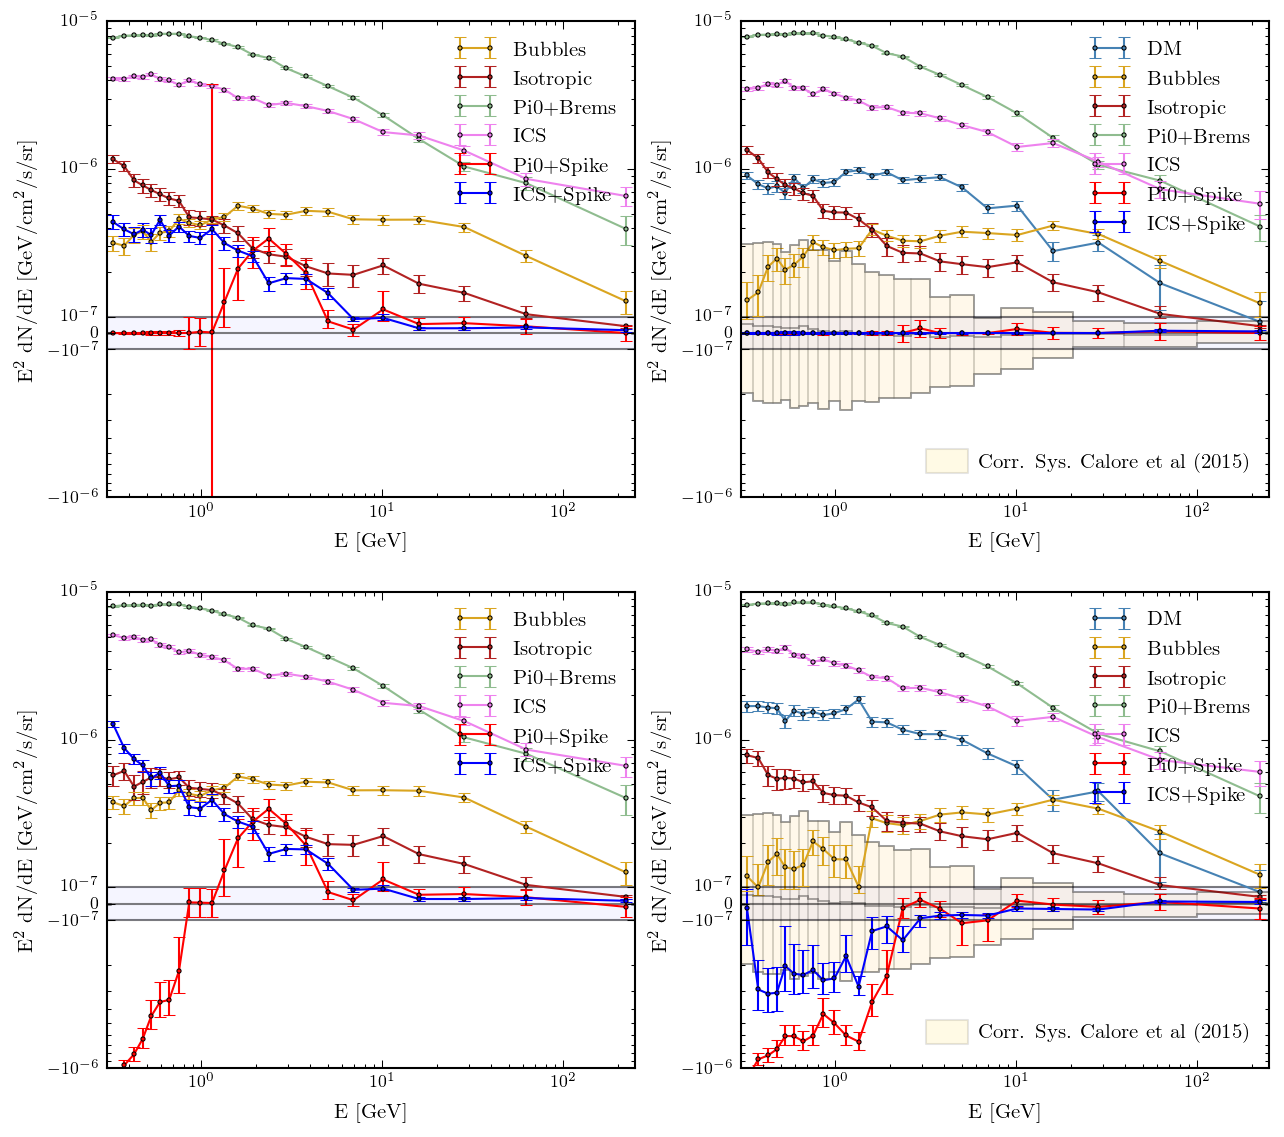

In [19]:
import cPickle as pickle
import h5py


def PlotSpec(keys, ylim, colors, h5_path, dm=True):
    
    
    models = ['spike_template.hdf5',]
    
    for i, model in enumerate(models):
        
        if i%1==0:
            h = h5py.File(model)
            if dm is True:
                fit = h[h5_path].attrs
            else:
                fit = h[h5_path].attrs
            
            print fit.keys()
            
            for j, key in enumerate(keys):
                lab = None
                if (key=='flux_DM') and (dm==False):
                    continue
                if i == 0:
                    lab = key.replace('flux_',"").replace('_','+')
                if i == 0:
                    plt.errorbar(fit['energies']/1e3, fit['energies']**2*fit[key]/1e3, fit['energies']**2*fit[key.replace('flux','fluxunc')][:,1]/1e3 ,
                                 label=lab,alpha=1, color=colors[j], marker='o', markersize=2, markeredgecolor=None)
                    
                    
                    if dm==True:
                        energy, mean  = np.genfromtxt('calore_fig_12_mean.dat', delimiter=',').T
                        energy, stdev = np.genfromtxt('calore_fig_12_upper.dat', delimiter=',').T
                        stdev -= mean
                        lower, upper, mean = list(mean-stdev), list(mean+stdev), list(mean)
                        plt.step(fit['bins']/1e3, [lower[0],]+lower, color='k', alpha=0.05)
                        plt.step(fit['bins']/1e3, [upper[0],]+upper, color='k', alpha=0.05)
                        plt.step(fit['bins']/1e3, [mean[0],]+mean, color='k', alpha=0.05)

                        prev = fit['bins'][0]/1e3
                        for k, end in enumerate(fit['bins'][1:]/1e3):    
                            plt.fill_between([prev,end], [lower[k],lower[k]] , [upper[k],upper[k]], alpha=0.01, color='gold', edgecolor=(0,0,0,0))
                            prev=end
                        
                else:
                    plt.loglog(fit['energies']/1e3, fit['energies']**2*fit[key]/1e3,label=lab,alpha=1, c=colors[j])
            
    if dm == True:
        plt.fill_between([.35,.43],[.05,.05],[.1,.1], alpha=.1, color='gold', edgecolor=(0,0,0,0), transform=plt.gca().transAxes)
        plt.text(.45,.075,'Corr. Sys. Calore et al (2015)', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
        
    
    plt.legend(frameon=False, fontsize=10, ncol=1)        
            
    plt.ylim(ylim)
    plt.xlim(3e-1,2.5e2)
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1])

plt.figure(figsize=(10,9))

components = ['flux_DM', 'flux_Bubbles', 'flux_Isotropic',u'flux_Pi0_Brems', u'flux_ICS', 'flux_Pi0_Spike','flux_ICS_Spike']
colors = ['steelblue','goldenrod','firebrick', 'darkseagreen','violet','red', 'blue']


#plt.subplot(gs[0,0])
#PlotSpec(keys=components, ylim=(5e-8,1e-5), colors=colors, h5_path='/fit_results/GC_no_dm_positive', dm=False)

def PlotCommon():
    linthresh = 1e-7
    plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10), linscaley=0.1)
    plt.xscale('log')
    #plt.grid(axis='y', which='both')
    plt.ylim(-1e-6,1e-5)
    plt.fill_between((.01,1e3), (-linthresh, -linthresh), (linthresh,linthresh), color='b', alpha=.04 )
    plt.hlines((-linthresh,0, linthresh),1e-3,1e5, alpha=.5, color='k')

plt.subplot(gs[0,0])
PlotSpec(keys=components, ylim=(5e-8,1e-5), colors=colors, h5_path='/fit_results/GC_no_dm_positive', dm=False)
PlotCommon()

plt.subplot(gs[0,1])
PlotSpec(keys=components, ylim=(5e-8,1e-5), colors=colors, h5_path='/fit_results/GC_positive', dm=True)
PlotCommon()
plt.subplot(gs[1,0])
PlotSpec(keys=components, ylim=(5e-8,1e-5), colors=colors, h5_path='/fit_results/GC_no_dm', dm=False)
PlotCommon()
plt.subplot(gs[1,1])
PlotSpec(keys=components, ylim=(5e-8,1e-5), colors=colors, h5_path='/fit_results/GC', dm=True)
PlotCommon()

plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/spike_spectral_plots_semilogy_P8.pdf', bbox_inches='tight')

In [11]:

h5 = h5py.File('./spike_template.hdf5')
for f in h5['fit_results']:
    print f
    
h5.close()

GC_no_dm
GC_no_dm_positive


In [91]:
AddFitMetadata('spike_template.hdf5', h5_path='/fit_results/GC_no_dm/', A=A, extra_dict={'residual':np.array([A.residual[i]*A.mask for i in range(A.n_bins)])})

Saving new residual... Shape =  (24, 786432)
